# FA24 - Assignment 4 - **Face Recognition**

### Instructions

- Download the dataset from Moodle.

- Do **NOT** forget to type in your name and AUBNET After this cell.

- Do **NOT** upload the dataset with your submission.

- **If an assignment contains a copied solution, the entire assignment will be awarded 0 points for all individuals submitting the same solution. Furthermore, any solutions generated by AI tools, will also receive 0 points.**

- Name the assignment as follows: **Face_Recognition.ipynb** . Failure to follow this naming convention will result in the notebook **not being graded**.

- For this assignment, you are required to utilize only the specified imported libraries for each section. Please `refrain` from `changing` or `substituting`  or `adding` the libraries provided. Failure to comply with this requirement may result in the assignment not being graded.

**CMPS 364 - Advanced Machine Learning**



**Assignment 4 Part II - Computer Vision - Face Recognition**



**By - Ralph Mouawad - rmm85 - 202204667**



**To - Dr. Shady Elbassuoni**

In [ ]:
aub_net="rmm85"



Face recognition is a biometric technology that identifies or verifies a person's identity using their facial features. Siamese Networks offer a powerful approach to face recognition by learning to differentiate between faces without requiring massive datasets for each individual.



#### **The Dataset**

- The dataset contains 1324 different individuals, with 2-50 images per person.

- The images are of size (128,128,3) and are encoded in RGB.

- Each folder and image is named with a number, i.e 0.jpg, 1.jpg

In [1]:
#### You are not allowed to Edit, Add or Remove any header other than the one provided.

import os

import time

import random

import gc

import psutil

import numpy as np

import cv2



import tensorflow as tf

from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.applications import Xception

from tensorflow.keras.applications.inception_v3 import preprocess_input

from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model



from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
# Setting random seeds to enable consistency while testing.

import zipfile

random.seed(5)

np.random.seed(5)

tf.random.set_seed(5)



### Set the Directory path to the dataset
directory = "/kaggle/input/face-recognition-dataset-cmps-364/data/Face Data/Face Dataset"

## **Data Processing**



We begin by reading the folders containing our dataset and then proceed to split the data into **training and testing sets**. This split is essential for model training and evaluation, as it allows us to train the model on one portion of the data (the training set) and validate its performance on unseen data (the testing set).



To maintain a realistic and unbiased evaluation, we split the dataset at the person level rather than at the individual image level. This approach ensures that images of the same individual are contained entirely within either the training set or the testing set, preventing overlap.

The dataset is divided into **90% training** and **10% testing**. This allocation provides the model with a substantial amount of data to learn diverse features during training.



The **split_dataset** function divides folders in a given directory into training and testing sets based on a specified split ratio. It shuffles the folders, assigns a portion to each set, counts the files within each folder, and returns dictionaries with folder names and file counts for both sets.

In [3]:
def split_dataset(directory, split):

   ## WARNING : USE  random.shuffle(folders)

   #############################

   ### Your code starts here ###

   #############################



    folders = os.listdir(directory)

    num_train = int(len(folders)*split)



    random.shuffle(folders)



    train_split, test_split = {}, {}



    # Training List

    for folder in folders[:num_train]:

      num_files = len(os.listdir(os.path.join(directory, folder)))

      train_split[folder] = num_files



    # Testing List

    for folder in folders[num_train:]:

      num_files = len(os.listdir(os.path.join(directory, folder)))

      test_split[folder] = num_files



   #############################

   #### Your code Ends here ####

   #############################

    return train_split, test_split

In [4]:
train_split, test_split = split_dataset(directory, split=0.9)



print("Length of training split:", len(train_split))

print("Length of testing split :", len(test_split))

# train_split, test list contains the folder names along with the number of files in the folder.

print("\nTest Split:", test_split)

Length of training split: 1512
Length of testing split : 168

Test Split: {'1629': 49, '1659': 2, '1553': 2, '1227': 2, '757': 3, '952': 9, '79': 2, '999': 3, '676': 5, '266': 6, '496': 2, '576': 2, '487': 2, '265': 2, '892': 2, '1668': 2, '511': 2, '971': 2, '590': 2, '53': 3, '841': 28, '633': 3, '533': 4, '269': 4, '946': 3, '683': 2, '852': 3, '687': 2, '975': 2, '1651': 2, '1395': 2, '1329': 30, '1051': 4, '130': 2, '631': 15, '585': 2, '504': 2, '1295': 2, '377': 3, '1624': 2, '351': 2, '972': 2, '1363': 3, '485': 2, '942': 5, '1311': 3, '281': 6, '677': 2, '408': 13, '335': 2, '630': 4, '397': 2, '88': 5, '872': 4, '1099': 4, '1438': 2, '507': 3, '1158': 2, '405': 2, '1632': 7, '826': 2, '453': 2, '657': 5, '664': 3, '883': 3, '479': 2, '560': 5, '558': 5, '624': 9, '729': 2, '241': 5, '1415': 2, '1465': 4, '728': 24, '534': 2, '199': 2, '1231': 4, '406': 2, '1248': 2, '1317': 2, '124': 2, '1338': 9, '1494': 4, '1237': 2, '1527': 2, '836': 9, '312': 11, '706': 2, '640': 2, '1519

**Question 1: Why is it important to ensure that images of the same person do not appear in both the training and testing sets?**



Insert your answer here :
- Ensure the model can recognize whether a person is in the database or not. If we have to classify a person as unrecognizable, we need to make sure the model won't misclassify him as someone else. 
- Improve the generalization of the model by letting it work on new/ unseen faces.
- Ensure the model is not trained on data that is in the test set (data leakage). That would let us think our model is working well, but when it has to classify unseen faces it might work bad.

### Creating Triplets



We use the train and test list to create triplets of **(anchor, postive, negative)** face data, where positive is the same person and negative is a different person than anchor.



Training will use triplets of images $(A, P, N)$:  



- A is an "Anchor" image--a picture of a person.

- P is a "Positive" image--a picture of the same person as the Anchor image.

- N is a "Negative" image--a picture of a different person than the Anchor image.





**Note: To optimize efficiency, we will delay loading images into memory until necessary.**

In [5]:
def generate_triplets(directory, folder_list, max_files=20):

    triplets = []

    folders = list(folder_list.keys())

    #############################

    ### Your code starts here ###

    #############################

    for folder in folders:

      path = os.path.join(directory, folder)

      files = list(os.listdir(path))[:max_files]

      num_files = len(files)

      for i in range(num_files -1):
          for j in range(i+1, num_files):

              anchor = (folder, f"{i}.jpg")
              positive = (folder, f"{j}.jpg")

              neg_folder = folder
              while neg_folder == folder:
                  neg_folder = random.choice(folders)
              neg_file = random.randint(0, folder_list[neg_folder] -1)

              negative = (neg_folder, f"{neg_file}.jpg")

            
              triplets.append((anchor, positive, negative))

     #############################

     #### Your code Ends here ####

     #############################

    random.shuffle(triplets)

    return triplets

In [6]:
##Create the train_triplet and test_triplet sets

train_triplet = generate_triplets(directory, train_split)

test_triplet  = generate_triplets(directory, test_split)



print("Number of training triplets:", len(train_triplet))

print("Number of testing triplets :", len(test_triplet))



print("\nExamples of triplets:")

for i in range(5):

    print(train_triplet[i])

Number of training triplets: 25005
Number of testing triplets : 2721

Examples of triplets:
(('1007', '12.jpg'), ('1007', '16.jpg'), ('1556', '1.jpg'))
(('1661', '2.jpg'), ('1661', '3.jpg'), ('861', '1.jpg'))
(('931', '6.jpg'), ('931', '19.jpg'), ('519', '2.jpg'))
(('1616', '5.jpg'), ('1616', '11.jpg'), ('1533', '0.jpg'))
(('868', '3.jpg'), ('868', '4.jpg'), ('142', '4.jpg'))


**Example of an expected output for the triplets.** <br>

(('1490', '7.jpg'), ('1490', '16.jpg'), ('1256', '4.jpg'))<br>

(('70', '5.jpg'), ('70', '6.jpg'), ('1477', '0.jpg'))<br>

(('792', '8.jpg'), ('792', '15.jpg'), ('38', '2.jpg'))<br>

(('629', '7.jpg'), ('629', '14.jpg'), ('280', '0.jpg'))<br>

(('1490', '1.jpg'), ('1490', '4.jpg'), ('616', '9.jpg'))<br>





**Note: If your data is not in the correct format, stop and organize it appropriately before proceeding.**

### Data Loading and Batching

**read_single_image** function, efficiently reads a single image from the dataset without consuming excessive memory.



Ensure that the image path is constructed correctly using the folder (index[0]) and file name (index[1]). The image is loaded in a reduced-size format to save memory, converted to RGB, resized to 128x128 pixels, and normalized to a 0-1 range for model input. If any error occurs during reading, the function returns a blank image of the correct size.


**Hint**: use the cv2 class to do the processing:<br>

 **cv2.IMREAD_REDUCED_COLOR_2**<br>

 **cv2.COLOR_BGR2RGB**<br>

 **cvtColor**<br>

In [7]:
def read_single_image(directory, index):



   #############################

   ### Your code starts here ###

   #############################

        try:

            path = os.path.join(directory, index[0], index[1])

            image = cv2.imread(path, cv2.IMREAD_REDUCED_COLOR_2)

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            image = cv2.resize(image, (128, 128))

            image = image.astype(np.float32) / 255



            return image

        except Exception as e:

            print(f"Error reading image: {e}")

            return np.zeros((128, 128, 3), dtype=np.float32)

   #############################

   #### Your code Ends here ####

   #############################

**generate_batch_triplets** function creates batches of triplet data (anchor, positive, negative) for model training, with an emphasis on memory efficiency.



Here’s some tips on how to implement it:



**Shuffle Indices:** Start by creating and shuffling an array of indices for random batch selection, ensuring varied training batches each epoch.<br>

**Batch Selection:** Loop through the dataset in steps of batch_size. For each step, select the corresponding indices, then retrieve triplets from triplet_list based on these indices.<br>

**Pre-Allocate Batch Arrays:** Set up empty arrays for anchors, positives, and negatives images, each with a shape of (batch_size, 128, 128, 3).

**Load Images into Batch:** Using *read_single_image*, read each image in the current triplet (anchor, positive, negative) and fill it into the respective array.<br>


In [8]:
def generate_batch_triplets(directory,triplet_list,batch_size):

    tr_size=len(triplet_list)

    indices = np.arange(tr_size)

    np.random.shuffle(indices)  # Shuffle for randomization



    for start_idx in range(0, tr_size, batch_size):

      #############################

      ### Your code starts here ###

      #############################
        # End index of the batch
        end_idx = min(start_idx + batch_size, tr_size)
        batch_indices = indices[start_idx:end_idx]

        # Initialize arrays for images
        anchors = np.zeros((batch_size, 128, 128, 3), dtype=np.float32)
        positives = np.zeros((batch_size, 128, 128, 3), dtype=np.float32)
        negatives = np.zeros((batch_size, 128, 128, 3), dtype=np.float32)


        # Populate the arrays
        for i, idx in enumerate(batch_indices):

            anchor_idx, positive_idx, negative_idx = triplet_list[idx]

            # Read every image and store
            anchors[i] = read_single_image(directory, anchor_idx)
            
            positives[i] = read_single_image(directory, positive_idx)
            
            negatives[i] = read_single_image(directory, negative_idx)
    







      #############################

      #### Your code Ends here ####

      #############################

        yield [anchors, positives, negatives]



        # Clear batch data

        del anchors, positives, negatives

        if start_idx % (batch_size * 5) == 0:

             gc.collect()

## **Creating the Model**



Unlike a conventional convolutional neural network (CNN) that classifies images into specific categories or labels, a Siamese Network operates by calculating the similarity or "distance" between any two given images. When two images share the same label, the network is trained to adjust its parameters—specifically, the weights and biases—such that it produces a smaller distance between them. Conversely, if the images belong to different labels, the network learns to generate a larger distance, effectively distinguishing between dissimilar images.



 <img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAABYwAAAGyCAYAAABHkIAVAAAMF2lDQ1BJQ0MgUHJvZmlsZQAASImVVwdUU0kXnldSCAktEIqU0JsgvUrvHelgIyQBQgkhEFTsyKKCa0FFBCu6CqLoWgBZKxYsLIK9L4ioKOtiwYbKP0kAXfcv57/nzJvv3bn3znfvm3lnBgB5O5ZAkIUqAJDNzxdGBXgzExKTmKQeQAKqQBYQAGCx8wRekZGhAMpY/3d5dxMg4v6ahTjWP8f/qyhyuHlsAJBIiFM4eexsiA8DgGuwBcJ8AAidUK8/K18gxm8hVhZCggAQyWKcJsWaYpwixVYSm5goH4h9ASBTWSxhGgBy4vjMAnYajCMngNiKz+HxId4GsTs7ncWBuBviidnZORDLUyE2SfkuTtrfYqaMx2Sx0saxNBeJkH15eYIs1pz/sxz/W7KzRGNz6MFGTRcGRolzhnWrzcwJEWPIHTnGTwmPgFgJ4gs8jsRejO+miwJjR+0H2Hk+sGaAAQAKOCzfEIhhLVGGKDPWaxTbsIQSX2iPhvPyg2JGcYowJ2o0PlrAzwoPHY2zLJ0bNIa3cPP8osdsUnn+QRDDlYYeLkyPiZfyRM8W8OLCIZaDuDMvMzpk1PdhYbpP+JiNUBQl5mwA8dtUoX+U1AZTy84bywuzZLMkc6lB7JmfHhMo9cUSuHkJoWMcOFxfPykHjMPlx45yw+Dq8o4a9S0RZEWO2mNbuFkBUdI6YwfyCqLHfK/mwwUmrQP2KIMVHCnlj70T5EfGSLnhOAgFPsAXMIEIthSQAzIAr2OgaQC+SUf8AQsIQRrgAotRzZhHvGSED5/RoBD8CREX5I37eUtGuaAA6r+Ma6VPC5AqGS2QeGSCJxBn4xq4O+6Kh8KnJ2w2uBPuPObHlB+blehH9CUGEv2JpuM82JB1FmxCwPs3uhDYc2F2Yi78sRy+xSM8IXQRHhFuELoJd0AceCyJMmo1k1ck/IE5E4SBbhjNfzS7FBizf8wGN4Ks7XFv3A3yh9xxBq4BLHA7mIkX7gFzs4fa7xmKxrl9q+WP84lZf5/PqF7OTM5+lEXK+JfxGbf6MYrPdzXiwD7kR0tsGXYIa8NOYxexY1gTYGInsWasHTsuxuMr4bFkJYzNFiXhlgnj8MZsrOqt+q0+/2N21igDoeR7g3zu7HzxhvDJEcwR8tLS85le8I/MZQbx2ZYTmTZW1o4AiP/v0t/HG4bkv40wLn3T5Z4CwLkUKtO+6Vj6ABx9AgD93Ted/mu4vVYDcLyTLRIWSHW4+EEAFCAPd4Y60Ab6wATmZAMcgCvwBH4gGESAGJAIZsCqp4NsyHoWmAcWgxJQBlaD9aAKbAU7QC3YBw6CJnAMnAbnwWXQCW6Ae3Bt9IEXYBC8A8MIgpAQGkJH1BEdxBAxR2wQJ8Qd8UNCkSgkEUlG0hA+IkLmIUuQMqQcqUK2I3XIr8hR5DRyEelC7iA9SD/yGvmEYigVVUa1UCN0EuqEeqEhaAw6HU1Dc9FCtBhdiVaiNehetBE9jV5Gb6Dd6At0CAOYLMbAdDELzAnzwSKwJCwVE2ILsFKsAqvBGrAW+K2vYd3YAPYRJ+J0nIlbwPUZiMfibDwXX4CvwKvwWrwRP4tfw3vwQfwrgUbQJJgTXAhBhARCGmEWoYRQQdhFOEI4B/dOH+EdkUhkEI2JjnBvJhIziHOJK4ibifuJp4hdxF7iEIlEUieZk9xIESQWKZ9UQtpI2ks6SbpK6iN9IMuSdcg2ZH9yEplPLiJXkPeQT5Cvkp+Sh2UUZAxlXGQiZDgyc2RWyeyUaZG5ItMnM0xRpBhT3CgxlAzKYkolpYFyjnKf8kZWVlZP1ll2iixPdpFspewB2QuyPbIfqUpUM6oPdRpVRF1J3U09Rb1DfUOj0YxonrQkWj5tJa2Odob2kPZBji5nKRckx5FbKFct1yh3Ve6lvIy8obyX/Az5QvkK+UPyV+QHFGQUjBR8FFgKCxSqFY4q3FIYUqQrWitGKGYrrlDco3hR8ZkSSclIyU+Jo1SstEPpjFIvHaPr033obPoS+k76OXqfMlHZWDlIOUO5THmfcofyoIqSip1KnMpslWqV4yrdDIxhxAhiZDFWMQ4ybjI+qWqpeqlyVZerNqheVX2vNkHNU42rVqq2X+2G2id1prqfeqb6GvUm9QcauIaZxhSNWRpbNM5pDExQnuA6gT2hdMLBCXc1UU0zzSjNuZo7NNs1h7S0tQK0BFobtc5oDWgztD21M7TXaZ/Q7teh67jr8HTW6ZzUec5UYXoxs5iVzLPMQV1N3UBdke523Q7dYT1jvVi9Ir39eg/0KfpO+qn66/Rb9QcNdAzCDOYZ1BvcNZQxdDJMN9xg2Gb43sjYKN5oqVGT0TNjNeMg40LjeuP7JjQTD5NckxqT66ZEUyfTTNPNpp1mqJm9WbpZtdkVc9TcwZxnvtm8ayJhovNE/sSaibcsqBZeFgUW9RY9lgzLUMsiyybLl5MMJiVNWjOpbdJXK3urLKudVveslayDrYusW6xf25jZsG2qba7b0mz9bRfaNtu+sjO349ptsbttT7cPs19q32r/xcHRQejQ4NDvaOCY7LjJ8ZaTslOk0wqnC84EZ2/nhc7HnD+6OLjkuxx0+cvVwjXTdY/rs8nGk7mTd07uddNzY7ltd+t2Z7onu29z7/bQ9WB51Hg88tT35Hju8nzqZeqV4bXX66W3lbfQ+4j3ex8Xn/k+p3wx3wDfUt8OPyW/WL8qv4f+ev5p/vX+gwH2AXMDTgUSAkMC1wTeCtIKYgfVBQ0GOwbPDz4bQg2JDqkKeRRqFioMbQlDw4LD1obdDzcM54c3RYCIoIi1EQ8ijSNzI3+bQpwSOaV6ypMo66h5UW3R9OiZ0Xui38V4x6yKuRdrEiuKbY2Tj5sWVxf3Pt43vjy+O2FSwvyEy4kaibzE5iRSUlzSrqShqX5T10/tm2Y/rWTazenG02dPvzhDY0bWjOMz5WeyZh5KJiTHJ+9J/syKYNWwhlKCUjalDLJ92BvYLzienHWcfq4bt5z7NNUttTz1WZpb2tq0/nSP9Ir0AZ4Pr4r3KiMwY2vG+8yIzN2ZI1nxWfuzydnJ2Uf5SvxM/tkc7ZzZOV0Cc0GJoDvXJXd97qAwRLgrD8mbntecrwyPOu0iE9FPop4C94Lqgg+z4mYdmq04mz+7fY7ZnOVznhb6F/4yF5/Lnts6T3fe4nk9873mb1+ALEhZ0LpQf2Hxwr5FAYtqF1MWZy7+vciqqLzo7ZL4JS3FWsWLint/CvipvkSuRFhya6nr0q3L8GW8ZR3LbZdvXP61lFN6qcyqrKLs8wr2iks/W/9c+fPIytSVHascVm1ZTVzNX31zjcea2nLF8sLy3rVhaxvXMdeVrnu7fub6ixV2FVs3UDaINnRXhlY2bzTYuHrj56r0qhvV3tX7N2luWr7p/WbO5qtbPLc0bNXaWrb10zbettvbA7Y31hjVVOwg7ijY8WRn3M62X5x+qdulsats15fd/N3dtVG1Z+sc6+r2aO5ZVY/Wi+r7907b27nPd19zg0XD9v2M/WUHwAHRgee/Jv9682DIwdZDTocaDhse3nSEfqS0EWmc0zjYlN7U3ZzY3HU0+Ghri2vLkd8sf9t9TPdY9XGV46tOUE4Unxg5WXhy6JTg1MDptNO9rTNb751JOHP97JSzHedCzl0473/+TJtX28kLbheOXXS5ePSS06Wmyw6XG9vt24/8bv/7kQ6HjsYrjleaO507W7omd5246nH19DXfa+evB12/fCP8RtfN2Ju3b0271X2bc/vZnaw7r+4W3B2+t+g+4X7pA4UHFQ81H9b8YfrH/m6H7uM9vj3tj6If3etl9754nPf4c1/xE9qTiqc6T+ue2Tw71u/f3/l86vO+F4IXwwMlfyr+uemlycvDf3n+1T6YMNj3Svhq5PWKN+pvdr+1e9s6FDn08F32u+H3pR/UP9R+dPrY9in+09PhWZ9Jnyu/mH5p+Rry9f5I9siIgCVkSY4CGGxoaioAr3cDQEuEZwd4j6PISe9fEkGkd0YJAv8JS+9oEnEAYLcnALGLAAiFZ5QtsBlCTIW9+Pgd4wlQW9vxNip5qbY20lhUeIshfBgZeaMFAKkFgC/CkZHhzSMjX3ZCsncAOJUrvfeJhQjP+NvUxKj9lgL4Uf4FrhdsPKW49tsAAAAJcEhZcwAAFiUAABYlAUlSJPAAAAGeaVRYdFhNTDpjb20uYWRvYmUueG1wAAAAAAA8eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJYTVAgQ29yZSA1LjQuMCI+CiAgIDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyI+CiAgICAgIDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiCiAgICAgICAgICAgIHhtbG5zOmV4aWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20vZXhpZi8xLjAvIj4KICAgICAgICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjE0MjA8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+NDM0PC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgPC9yZGY6RGVzY3JpcHRpb24+CiAgIDwvcmRmOlJERj4KPC94OnhtcG1ldGE+CnINWUUAAAAcaURPVAAAAAIAAAAAAAAA2QAAACgAAADZAAAA2QABSqPS6tEJAABAAElEQVR4Aey9CZxkZXnv/1R1VfXePQs7DDAg4IKoUf9Gr9ELAfW6Xa8SXC8u4IqiiIpgFFBQQANBkSjgluSjuFwTNF63xLizyNWAIpc9CMgmy0xPb1XV1f/f9zl1mhlmhsDkfsgJ/M5w+lSd5T3v+b7dH7q+88zvrS1qCS8mYAImYAImYAImYAImYAImYAImYAImYAImYAImYAIPewI1C+OH/feAAZiACZiACZiACZiACZiACZiACZiACZiACZiACZhAErAw9jeCCZiACZiACZiACZiACZiACZiACZiACZiACZiACZhAErAw9jeCCZiACZiACZiACZiACZiACZiACZiACZiACZiACZhAErAw9jeCCZiACZiACZiACZiACZiACZiACZiACZiACZiACZhAErAw9jeCCZiACZiACZiACZiACZiACZiACZiACZiACZiACZhAErAw9jeCCZiACZiACZiACZiACZiACZiACZiACZiACZiACZhAErAw9jeCCZiACZiACZiACZiACZiACZiACZiACZiACZiACZhAErAw9jeCCZiACZiACZiACZiACZiACZiACZiACZiACZiACZhAErAw9jeCCZiACZiACZiACZiACZiACZiACZiACZiACZiACZhAErAw9jeCCZiACZiACZiACZiACZiACZiACZiACZiACZiACZhAErAw9jeCCZiACZiACZiACZiACZiACZiACZiACZiACZiACZhAErAw9jeCCZiACZiACZiACZiACZiACZiACZiACZiACZiACZhAErAw9jeCCZiACZiACZiACZiACZiACZiACZiACZiACZiACZhAErAw9jeCCZiACZiACZiACZiACZiACZiACZiACZiACZiACZhAErAw9jeCCZiACZiACZiACZiACZiACZiACZiACZiACZiACZhAErAw9jeCCZiACZiACZiACZiACZiACZiACZiACZiACZiACZhAErAw9jeCCZiACZiACZiACZiACZiACZiACZiACZiACZiACZhAErAw9jeCCZiACZiACZiACZjA/3MC3W43Go3GA2q30+lEs9l8QNfc35OvvfbauPXWW/P07bbbLlavXn1/L/V5JmACJmACJmACJmACJvCwImBh/LAabj+sCZiACZiACZiACTxwApdeemk88YlPzAuPPPLIOOmkkzbZyNVXXx2nnnpqXHDBBcE1k5OT8chHPjLe8pa3xCtf+cqNrllcXIwvfOELccYZZ8SVV14Z09PTsdNOO8XTnva0OPHEE2O33Xbb6Jot3fH6178+zjnnnLz8sMMOy3tuaVu+zgRMwARMwARMwARMwAQeygQsjB/Ko+tnMwETMAETMAETMIF/J4Ferxcvf/nL4ytf+Uq29O53vztOOeWUjVq97rrr4pnPfGbccMMNGx1jx3Of+9z45je/GfV6fen4QQcdFF/96leX3q//YmhoKH7wgx/EU5/61PV3b/FrC+MtRucLTcAETMAETMAETMAEHmYELIwfZgPuxzUBEzABEzABEzCBf4vAHXfcEVdddVVQMfyxj30sLrnkkqVLNieM99lnn/j1r3+d52299dbxJ3/yJ3HxxRfH7373u6VrqUw+6qij8v25556bIpo3tVotnvGMZ8SjH/3o+PrXv74UHUGFMX3g+L93sTD+9xL09SZgAiZgAiZgAiZgAg8XAhbGD5eR9nOagAmYgAmYgAmYwP0kcPrpp8c73vGOTZ69KWF82223xbbbbpvnr1y5Mn71q1/FqlWrYmFhIQ4//PA488wz89iOO+4YN954Y75+7WtfG5///OfzNTL3rLPOyte33HJLxlJwLQtRFXvssUe+vr9fuPayyy7L+z/ucY/LqmYL4/tLz+eZgAmYgAmYgAmYgAk83AlYGD/cvwP8/CZgAiZgAiZgAiZwLwJkCr/zne9c2ssEduQNs2xKGJ933nnxohe9KI+/8IUvDN6Xy7/8y7/EE57whPJtUL28YsWKOPDAA+N//a//lfu//OUvB/EU5bJ+tTJVymV+cnl8c1v6ePzxx8dHP/rRmJmZydPIUeZ5fvSjHznDeHPgvN8ETMAETMAETMAETMAE1iNgYbweDL80ARMwARMwARMwARPYmMBLXvKSjIrgyOaE8d/93d/lhf/tv/23eOlLX7rUCNEWe+6559L7m266KXbYYYfMQS7jKQ4++OCc/I6TiLBYvXp1kJ1MjvGaNWui1WotXX9fL17xilfEl770pY1OITd55513jn/913/NY570biNE3mECJmACJmACJmACJmACSwQsjJdQ+IUJmIAJmIAJmIAJmMCmCPxbwnhT15T7/vzP/zxOPPHEfLt8+fK488478/Vdd90Vj3/845cyjqkq3nvvveMb3/hGrFu3Ls/5i7/4iw0qncs2N7X96U9/mrnJ5TGiKJ7//Odn/vJ3vvOdoEq6XCyMSxLemoAJmIAJmIAJmIAJmMDGBCyMN2biPSZgAiZgAiZgAiZgAusR2FJh/NWvfjWo+i1l7XHHHRfHHnvsUstkHT/pSU/KauKlnf0Xz3nOc+Lb3/72vXdv9j1y+Fvf+lYeRxaff/75MTw8nO/Xj8xgh4VxYvEXEzABEzABEzABEzABE9gkAQvjTWLxThMwARMwARMwARMwgZLAAxXGTDqHHKayuMw+fvKTnxz//M//HKOjo9nstddeGwcccECwLReOTU9Pl2/jiCOOiFNPPTXfv/KVr4xrrrlm6Vj54tBDDw3WnXbaKYi7YPnABz6QWcblOWz/+I//OC688MLcZWG8Phm/NgETMAETMAETMAETMIENCVgYb8jD70zABEzABEzABEzABO5F4IEI49tvvz0ntPvxj3+81Mqzn/3szBYmkqJcnva0p2UVMO+pJj7ttNMyu5hqYORwWZVMlTHHH/vYx8ZvfvOb8vKlLRXLRx99dFYTl3L6Bz/4Qey7775L5/DikEMOic9+9rO5z8J4AzR+YwImYAImYAImYAImYAIbELAw3gCH35iACZiACZiACZiACdybwP0Vxpdffnk873nPi+uuuy6baDQa8f73vz/IMWbiuXKZmpqKFStWLEnhH/7wh/HMZz6zPJyC+Lvf/W6+Z2K8k0466T6FMQJ4m222WbqeOAoqitdfLIzXp+HXJmACJmACJmACJmACJrB5AhbGm2fjIyZgAiZgAiZgAiZgAiJwf4Tx9ddfn5PY3X333cls1apVce655waVxPdeqD4uBXGtVguumZiYWDrtmGOOiY985CP5/k//9E/jH//xHwMZPTc3t3RO+WL77beP7bbbLq9HRLMgmBHN6y+77rpr0EcWVxivT8avTcAETMAETMAETMAETGBDAhbGG/LwOxMwARMwARMwARMwgXsRuD/CmAgIKoVZ/uiP/ii+973vxcqVK/P9vb9Qgbzbbrst7UYsv/SlL116//jHPz4uueSSfE9l8DnnnLN0bHMv1s8o3m+//eKf/umflk799a9/Hfvss8/SewvjJRR+YQImYAImYAImYAImYAIbEbAw3giJd5iACZiACZiACZiACaxP4N8SxldccUU88pGPXLqE15uTxcjfvfbaK3bfffel6Ipddtkl3vrWt2bsxN/+7d8Ga7l87Wtfywrn8v3mtl/5ylc2kM4HHXRQXnfrrbdmxfHvf//7pUstjJdQ+IUJmIAJmIAJmIAJmIAJbETAwngjJN5hAiZgAiZgAiZgAiawPoF/Sxh/5jOfiUMPPXT9Szb7+he/+EU86UlPCiamI27ivhak75e//OX7OmWDY7RHu/deyE9+4hOfGNybxcL43oT83gRMwARMwARMwARMwATuIWBhfA8LvzIBEzABEzABEzABE9gEgX9LGL/2ta+Nz3/+85u4cuNdpTDmCNnEb37zm+Pqq6/e4MSRkZF43/veF0ceeWQMDg5ucOy+3szPz8db3vKW+OxnP7t0GtefeeaZQaUx2cgsFsZLePzCBEzABEzABEzABEzABDYiYGG8ERLvMAETMAETMAETMAETeLAIdDqdINLiyiuvjJmZmdhjjz3iUY961AaT4D3QvvzhD3+Iiy66KJYtW5aVxQ9EOj/Qe/l8EzABEzABEzABEzABE3ioEbAwfqiNqJ/HBEzABEzABEzABEzABEzABEzABEzABEzABEzABLaQgIXxFoLzZSZgAiZgAiZgAiZgAiZgAiZgAiZgAiZgAiZgAibwUCNgYfxQG1E/jwmYgAmYgAmYgAmYgAmYgAmYgAmYgAmYgAmYgAlsIQEL4y0E58tMwARMwARMwARMwARMwARMwARMwARMwARMwARM4KFGwML4oTaifh4TMAETMAETMAETMAETMAETMAETMAETMAETMAET2EICFsZbCM6XmYAJmIAJmIAJmIAJmIAJmIAJmIAJmIAJmIAJmMBDjYCF8UNtRP08JmACJmACJmACJmACJmACJmACJmACJmACJmACJrCFBCyMtxCcLzMBEzABEzABEzABEzABEzABEzABEzABEzABEzCBhxoBC+OH2oj6eUzABEzABEzABEzABEzABEzABEzABEzABEzABExgCwlYGG8hOF9mAiZgAiZgAiZgAiZgAiZgAiZgAiZgAiZgAiZgAg81AhbGD7UR9fOYgAmYgAmYgAmYgAmYgAmYgAmYgAmYgAmYgAmYwBYSsDDeQnC+zARMwARMwARMwARMwARMwARMwARMwARMwARMwAQeagQsjB9qI+rnMQETMAETMAETMAETMAETMAETMAETMAETMAETMIEtJGBhvIXgfJkJmIAJmIAJmIAJmIAJmIAJmIAJmIAJmIAJmIAJPNQIWBg/1EbUz2MCJmACJmACJmACJmACJmACJmACJmACJmACJmACW0jAwngLwfkyEzABEzABEzABEzABEzABEzABEzABEzABEzABE3ioEbAwfqiNqJ/HBEzABEzABEzABEzABEzABEzABEzABEzABEzABLaQgIXxFoLzZSZgAiZgAiZgAiZgAiZgAiZgAiZgAiZgAiZgAibwUCNgYfxQG1E/jwmYgAmYgAmYgAmYgAmYgAmYgAmYgAmYgAmYgAlsIQEL4y0E58tMwARMwARMwARMwARMwARMwARMwARMwARMwARM4KFGwML4oTaifh4TMAETMAETMAETMAETMAETMAETMAETMAETMAET2EICFsZbCM6XmYAJmIAJmIAJmMDDhcDi4mJcd9118bKXvSxOPvnk2HfffSv76HNzc/H4xz8+PvGJT8R//a//NZrNZmX76o6ZgAmYgAmYgAmYgAmYQBUJWBhXcVTcJxMwARMwARMwAROoCIGFhYX42c9+lrL4u9/9bjz2sY+tSM82341erxd77bVXPO95z4sPfvCDMTExsfmTfcQETMAETMAETMAETMAETGADAhbGG+DwGxMwARMwARMwARMwgZIA4vWXv/xlvOAFL4if//znsXr16vLQf4ot/f0v/+W/xJlnnmlp/J9ixNxJEzABEzABEzABEzCBKhCwMK7CKLgPJmACJmACJmACJlBBAn/4wx9it912izPOOCMOPvjgjXp45513xmc+85kUssjZ9773vfGsZz1ro/PW33H55ZfH6aefHt/4xjfiCU94QhxzzDEpdctz5ufn4+yzz8422+12Hj/ooINibGysPCW3VD6fddZZ8ZSnPCWrnjcVPTE9PR177rlnfO5zn4v99tsvGo3GBm34jQmYgAmYgAmYgAmYgAmYwMYELIw3ZuI9JmACJmACJmACJvCwJ0AW8LHHHhtf+MIX4pZbbtmIx0033RRHHXVUXHHFFXHeeefFhRdeGEcccUS8//3vj0MOOWSj89nBee9617vigAMOiA996ENx6qmnphg+/vjj4/DDD4/Z2dk48sgj46KLLkrRy/aaa65Jgfya17wmhS95ygjsU045JW688cb48pe/HP/9v//3GBwc3OQ9//qv/zre+ta3ZgbzypUrN3mOd5qACZiACZiACZiACZiACdxDwML4HhZ+ZQImYAImYAImYAIm0Cdwxx13xO677x4/+tGP4nGPe9wGXKj8/f73vx9ve9vbUt4+97nPDaqRiX744Q9/GOeee25ss802G1xDNfJpp50WV155ZXzsYx+LVatWBfuQxQjp4447Lv7+7/8+qBx+85vfHMhdqpHf8Y53pGB+4xvfGOPj40EF8po1a7JC+cMf/nCcdNJJ9ymMEczbb7999u2FL3yhq4w3GBW/MQETMAETMAETMAETMIGNCVRCGH/961+P97znPRv3zntM4D+AwKc+9anYf//9/wPu7FuagAmYgAmYQDUIdLvdrOqlWhgRfO/lhhtuiDe84Q1x++23x/nnnx/EQSBmv/Od78Shhx4a73znO7NSeP3rLr300pTCTEBHZfGKFSvyGial4/+9J5xwQhx44IExMDCwFD8xNTWV93na056W7Q4PDy81+c1vfjOrlalUvq8KYy5AUH/gAx+Im2++OSYnJ5fa8AsTMAETMAETMAETMAETMIGNCVRCGPNPHfOfGTYbysnbJStLuqouqddqUdPKsphfFvODRfm+OMK7/qJzuYZVF+Y1PbXDaz581Ov1qLHm4X7belO+p5X12+Tei9rDB6DuQjd6vcUYqKudgbruUbSzdI3OKftaNlK0lT3XruI+akyXaGWrdVFtLi72+ivveV3u1zZ6xcMXzeQ96EP5HD2dy4Q0rAtay4U28p48L3fU+4XuQvABkH7W1P+GmAzoWWDDe1h1Op2YU+WOLhCvgeipb70F2l7QuKj99QH1+1TeM7d5vDhp/VPLc4rDcOX5y73a6gD95b/cvf4xHc7zc8uXew4W7WnfektxuBh/dhdn88z63lB2IfxY5+bmtc7peHHu9Mx0tkJ1Ex88vZiACZiACZjAw5XAzMxMPP7xj4+XvexlgdC990IMBZnAO+ywQ0ZR8DsWy/e+97140YteFK961asyX3j966gWpi2kL5XGpbhlH9EXJ554YuYVl9fwu8vb3/72uOSSS/LY05/+9PJQbh+IMKZaeo899ojf/va3sd12223Qjt+YgAmYgAmYgAmYgAmYgAlsSKBSwvg9xxweu+62czBBCRUlLVWrtFqtlKgLEpcIT8TlosRl6tB66sLQQ6Tw5MMK57cazahJhHIuWXgDEtGj+ieMQ8ND0Roaiobesy/FL/JX1xVr4UNrMoy1FMwDsaC2O7rvmrVr9U8g2zE+OhYj+qAz2GpGQ/ev67hUq7a9GEAiZ5/oH6K1G7Ks6q/kt7ijbnuddiy057S2o6e1KznblbTstLXVsWLtptgtJG1X13FlTfcb0H1bqroZL3L61O92u5PPOD03G9OzMymNF1JCc8N6NFuDktsDKaaRozPTM/lPMYe0n3/WOa4JZCbGJqIpZtPT6+IPt/8hqBpCjo+MjMaspOo6fWjkgyOCNfUrUrfvbNki3MslpXl/R4ppHaDv5Sm5T/1KES1maXN1sJDgErc6RpuI8GIRSb3mQyM6nC2CXWdkm+U9OBepvLhYyF+O8j2ix9AYatsTv8GhGBmfiOGRMX1YHY3fXX+T8gx/F91FRrAWU7PTccP11+Y/h7UwhqgXEzABEzCBhyuBdevWZYwDucSPfvSjN8JAtTAxFU960pOWhDH/j0YYP+c5zwmiH/gL2Py9oH91KYz5PYOq4H333TePbEoY/+QnP4n3ve99wXZkZCSrnZHXpZjmwgcijOnb1ltvHV/72tfiGc94xgbt9LvnjQmYgAmYgAmYgAmYgAmYQJ9A5YTxLqtXSWpOx7Q+qKQw1gQmVM72JH+7CGPJYmQjy/ofQpC1Da1NCdWGRDOCMoWxRGxD+8YnxmJIHziGJHt5jzCWSc3zqK5N8Tigq3Kf9rOVvOSeHUnZqam12rYlV8diVOJ5qNWIJqerLymNtc3LpSl7i13J7Xa0JVgRwsjhRVX26iFiXsJ2Xs/Gti0J256ZjY6kNtK4i0DWvVIUpyAtRCkzevNPPYcRnsMjsWzZshTGSN05SexptcO6TsK4rQrhtkT1op5pkcphWAw0s4oYZlQ0D0oWDw8Nx4SEMdU9yyaXpTAmD5B/Wvr7m27WU0SMjY6nLF4jeY8sbutei9j0FLO0tr4shnh/TO4tjLlEh5OxjmU1s3jxlwCpwtkHb20RxkjeQgzTYmrg4n35TtdxnNtw1+LO/Wv0roc01sHUymqLwuiu1sbgcIxOTMbg8FgMDo3E9RLG/3r9jdFZ0JiJV3t+Lm7416stjMFe4eXDJ59a4d65ayZQbQLHHPXOanfQvasEAf4fe/XVV8eTn/zkuO222/Iv4+/dsc0JYyIpyDPelDDmXzmRcUzV8Cte8Yogf5h2EMbcjwrjt7zlLXkr7otYPk65xv/wD/8QO++8c1YsP/vZz17qygMRxlz0zGc+M7j+3e9+d/5etdSQX5iACZiACZiACZiACZiACWxAoFrC+H2H6wPBjlkxOyuRmtXCkrsLPVXcqkq325GIpbpYwrBY+sZQb5DFVOAijAckWBGNXIM8bUo6j09OSBirMjgrjCVQOQdRycofCcu6BGvaRzVL5ERd+5C4iEQE9oIqgJePj8XYiIRxQ/dS2fDAoqqH9cEKcRzqZ6+rit9pCdZ1UxLf66I9O6eq4o72S+LKWnYlXjvat0BlMQJWz8TxhXmtbLXSr7rap0o6Bbb6MiCR2mq2JKoHY2R0NKU4Vnde181INlMFvE4VsrNqdw7xrAfpIk15JsQxq95zTUMCmYricVXbTipHcKutto4hCWSe8a67747b/3BHMhnVfaYktu+SSKa6mgluCoFb0OcrTRZL8SLv0d9ZsC2RFqy5gP1If8R4wVnaWM/HGDCyWVEsa6yu9hfEOTXFRbVxPoRe6/QcrjxPJ6Rk1p6sMuYeeo187uoYUrgxNBpjy1bE+LKtYmLZyrjy6mvj8iuujvmOqsB1bl3jd90Vl1kYl9grurUwrujAuFv/KQhYGP+nGKb/8E6uL4zv1u8Fm1q2JJKCdvgXZJ/85CdTEvOvwMrlsY99bFYd3/tf+NCX1772tUF82Ze+9KV46UtfWvw+owsfqDD+7Gc/Gz/UhHxnn3128S+1ypt7awImYAImYAImYAImYAImsAGBygnjVTvtIDk5l5WzKYwHW6ry7eTaaSOMlUmMHNRjsKbslRxsSDgSa1AIY2Xv9jN9OxK6LVUVT6gqNyMp1N7AgOIodG6RQ1xUFyOHybdVUykeB/ptduZnVSk8E7MSwIvqx8pJRTj0hXFL1bYNaUlkcU1rV1ET8zr3rltviTWq1J1ac3fMExOhPiOLFyUmKXetSV4So1HXAzTrisdAckoo91TN3NU5VEgjtwdUxTzQVCyG9pMjXOQzS2TT/xTAdWUOK3aDKmPdB2G8Th++ZiSl53T+vO7RlXNe0LNkxbGIFRnJekhFNIwq2mJifDKz/MYljqkgntb1U2vX5T/VpBp7Com8Zm3mGs9LmBda+J7vIXjds9wjhdmHGCaKoxyjQibngawYh0uOg8ZioFHI8XsymYsx5ho9Ri5UmlOVzD2RxZlVrSOZAc2z8X2h6mLuyPMWwlgMZI3bCGNVFo+t3Da23mFVbL/jLvEvv74sLv7VJaqeRoTXY0Ru/YpLLrYwTtrV/VIKY4uv6o6Re1Y9Av65qd6YVLlH/P/0mmuuiT/90z/Vv8a5fpNdveqqq+L5z39+/kslYivy//E6874yjDfV0Fe/+tVgYr0Xv/jFOSndkP5i/97LD37wgzj66KNzIj2Ecbk8UGF8xhln5MR61157bcZclO14awImYAImYAImYAImYAImsCGBagljZRivWrV9zKuStSOBShUsUQwpjFUpTDQE/5wRg4hETGGMH5QgLISxIilUhcskbgsSxeQPYxYHJT7HlymKQB9CWhLGSEoqdomxQBqXr5kEDpErw6vcYSqCdT9J4K4EdkciuNbrxOTocIxI4qYoVoWsDK/a0WR49EMVqovq+5RmE59WRc68coWpLKZydlHCciH7rt7S9/4DZMJDOSbajxhuUL2sflKF26VqWftY0a/IV6pmy7Wr/R31d16VyXNa27pHW+87OqGje3TVry6PxOsU0p3MZO4iUMWqpYrlCcU0DCmiQadlv8hAJgYDXlOKB1mDMNZzEXeRC31nSfbaLG15obW/oxDG9Jj63f5+HWN/mWGM5Ed+M/ke13XFFDGckwHmTYpxhhfPzJ1rgsYtuBt7UhgXnde7oh3uyErFMnEUbV1cGxyNwYkVsXK7VbHdql3iquuuj8uvvkbZzbOqum7E1qND8aNvnWdhnFyr+8Xiq7pj455Vl4B/bqo7NlXsGf/Pvfjii+PAAw/crDBeq7kdPve5zwVVu8RQbL/99vkX5MRHnHDCCRk9QaQFS/4/XP9v5/ez9Rek9PHHHx+XXXZZVhw/73nPW//w0uu//Mu/jK985Ss5Md6/J5LiggsuiJe85CWB7CYX2YsJmIAJmIAJmIAJmIAJmMCmCVRLGB/9tthJwhhZTJxEZvdK5FGJ2pGYJRIB6coHj1z7yhB5mBnGko8IZgQkopViU6InyC4em9BEccoepgI5JbEuKmMskM35WoxquldNYrQj2dtR1W63owxirdoRA2pzZFAT8eEkFzqqGC4mrsN1NlQh2+J+EpNzinBoK8pB1jOrYKkYpr/I7lStul/x4UkSWedQVUtkRFpQnUDlLAJ1XvnLsxLVyGL5bx0uJoRrK8aCifiQxYjgUorKAVM4rLWQyrwnjiFXiVjiK+apPlYl8RxRGHkt91Lus+Q8/YTPoCI8mCyvNTSY2chTU9Mp8ZHRJXu9KL6jdD/4l5VFetXfX4jhlMZL55b79Bz6w/0HJMf5AFlMYlNL4Y1MLu+TW86l1X71MMIY644SLs7TUe3K24hRZiTrdK5BIDPpXUfHe43hqA8rhmObHWLlDjvFzXfcGTfcels+44jyjVfpe+Qrn/krC2NYV3ix+Krw4LhrlSXgn5vKDk0lO8bvXSeffHJ8+tOf3qwwpuO/+tWv4qlPfWpWGjOZ3C9/+ct4zWtek3nDiGMWJq0js3iPPfbI9piHgeW3v/1tyuLf/OY3uUVOs5QS+uCDD45XvepVceONN+b1HH/1q1+9gXSmOvmYY47J7GOiLPj95b6Wm2++OQ444IC46KKLLIzvC5SPmYAJmIAJmIAJmIAJPOwJVEoYv1vCeIcdty0iHGT/qDBuaHK6DgJXsnIjYaxzUhJKCzYU7dCkKlbCE0lMparMqya4QxirKnh8NDOAm2qvgZCVWGwimKkw1rcBonhR+b89RTL0lJ/cnpmOOWUR9ySLWTVzXeYVt1RK3FK7rERREPEwoH1NSc9h3XtIfUYkU6XMPmRoTffpqmK5LQGcElP3J5+Y/bVWk1BhjKvEsMS4+rAoEYyEnddrhHFNwjP/6HwmuptW/5C/RC2U7SFFqUFGDiORM74hIxzSpfKEKZnbqtKelTQmtiIrkXUv4hgWa0U/6S+RHQ31i8kBaQc5nRJfY8BzUKlMX5G1ajb7mi/KHyeejzuyFV/59P5rTs43/XFDtBeMaISecJ9NCmPdSsDycmQzOhhhXJhivup1/sdeJDFCmkuIplB0h0w6wrg2vCxqI+NRHxmLO9dNxx1aqaTedqutYhtVjn/h439hYSyqVV4svqo8Ou5bVQn456aqI1PNfhHr9fGPfzxOO+20+xTG/B5AJfJ+++2neKe5GNPEwM94xjPi3HPPjWH96y4W4iQOO+yw2GeffeKv/uqvUhQfe+yxuf/lL395fOQjH4lddtllCcQXv/jFrDYmI5mF6z760Y+m6C3/cpr7Hn744ZlrTCYy92USvQ984AOx4447LrV17xcI47322ivYMk+DFxMwARMwARMwARMwARMwgU0TqJww3m77rTN/GOXYRFpK/iKKiUNAHK9fYYw8xTzyp8VEbkwKp+oSrimFcVMVwYOKGhgZG4mW9jclaqVGJY0lKyVZyRGWAY2eYie6TGyniep6kogd5QF3JI2RxYvdQhZL1yq+IlIWD0qqDkgaYzC5H20Pa+K4Yd2f+lkykFNeS8AS8UD/55SHzO0Q2VQUk5lcV/RESmMd4dnaCGvJWERrR8+NNMaxciOiNBZUNjyl/hER0VtUZyREaQspikItJLBiHdRGRjuIT0pbXZuPqutTGGvivVm1MSeB3JE0JrahJx6I25yIjr5JriO1uQcfznqS8FQZMw5MQMj7NL/ZwaKX2dX+F2RtVkv3xTEf9PL5+Zr7NA66D5Ka/UjejYUxFdjpgnUG1cO0oftyhYQ9C3fmer6SYcxzlMI4+64zOj31ZXAiBie3jbYqqqd1we1rp+IuRW5ss922sXrXXWKZqtjPOuVEC+NkWd0vFl/VHRv3rLoE/HNT3bGpYs/urzAu+87vCPzewf+j+X/6vReOcQ7/z2cSPeTyNttso/9F81fKGy+cy0p7rP+vFgvj/1ck3Y4JmIAJmIAJmIAJmMBDnUClhPGR7z1ME7BtnR8S+MDBBwviJRDGyNMUxnzo0KgUk7cVspiPEq3GYAw2tUrYEnPQUSUsJpFYheHRQVWSKL9Y1cYtKntVOVOTIV3QBxbWeUnDttbO1NqoKYqiodziAV1PBbHyKGRSuzEoydtUJTGSGBlMhXLxEUbVxpK+Q5LFhfxUdasELHELVM8itZG+xEtQYYxETUGq40WOr6p1+VBUfmhS3zhOtEbxnP3sYVX1shBDgfClMJgM4oaiIxqDQymM9VFNE+BxL0V3SObmhy1dgzCmapjK67oqoIm0mFOFMhPcrZuZKybJIx86rWshplO06rqU2/0+MxZIaKI1GJOuxDHSOD/YZe/SA5evlj7o5WR9S7KXqmjpbbWJAOc5eV440ee2uBeiW2MsLvdMaMeD8MESaayHZ9XxlMTcUS85P7fiAC3EMWdkJMVCLcZXbh87PeIx0WuNxJTG//JrrokrrrsuVuufye71yL1iVH9J8KmPfNDCGJ4VXiy+Kjw47lplCfjnprJDU8mOPVBhXMmH2ESnLIw3AcW7TMAETMAETMAETMAETGATBColjI846i0Sxlupm5KzKYuRg0WlLRW6CMqsUtEZyEE+0GBtqT5pSRYPaWUSNyav6yB6lXM7JGE8MtxSVp2OZXSEBCLClUgGVRTPsyKLZ2ZiUZnFTUVPDCswuKlrqUJelBxVya/aLmQz90NUcn+qoOuKcmhKUg/pn16m9NXxdod8YURwIVfnVb1MFERXfaKviFJEK5XEPQlSpCgyFonK8xKbQb85j/aLOIhCzCJW28hjzpMorjeUyazq6o5YzGv/rPKJEcbJRroUWQuPYoK7Vl7DtQhnxPO0hPmU8panJY5n+9XG6kRWKy9qy8r7lOEak5zATxY2JyJkTBC8PIf6VSxsi2vKyiDUej437epZWXleJpojM5n+wYuVZ0UYs2xOGEd9/TiK4i8N0hX3+8DIIM8z0zm3vB6IbXZcHY/5o6ekML5rrhMX//rX8S+/vTz2fMxj4jFaW2vvjjM++D4L46Rf3S8WX9UdG/esugT8c1PdsalizyyMqzgq7pMJmIAJmIAJmIAJmIAJPHgEKiWM3/HuN8e222+VcrGlOArcLCWinZzkjYne+nKyL2xTUkpCIjEHVW07yERt2g4gZCV+tTtGhiSLVVk8rFXT52Xl8IwqiWc1Md28Moo7kqWLar+utps6Pqoi1rEmsRW6saRuRxJ1QWJ0SFXEDVUnt5VPTIUtE9Ehc4sqX91T/eU9EpnYhnmdNysZi+heRA5LgpYREVQUI51ZsmJZ7SJkEc7oz8xiljBuZuxFv/pWp9M2f1LiIpNVLUycBNXC65RrPKUIjY4qZ6lCRkLDDxlLtAdsqL4eUl7voKqhW5rkjdgGIiyIuFizdl3ceffaWKeoirb6inRV6S8UJI/x04hu9RPBi8zXe56nyJdG5ktocx3SVuexZm/VDP1gLLgGWUwFNtXOZFRTYUx7TGoI147a4RwuWhLGajJxSXTTJjkiOfFdn2NWIescvh9gw5NTLd3NCmMxVb61Bih22m2PeOIf/0l0Bgbj5rXT8X9+c1lccsWVsddj9o69tdbvuDVOPfqdFsYaryovFl9VHh33raoE/HNT1ZGpZr8sjKs5Lu6VCZiACZiACZiACZiACTxYBColjN/+njcpT3arFIvEPNQl/DCFTLKW0jgrWhGKkoPaj1gsKnbr/QntJI0lHxuSlT0JSATxsCYyG27UY5g4CUVL1LV/+u67YmbN3dElL1gxEXU12JRoHNW5oxLL48o9XlTlbEfHZiVi51SJS9UvchcZjJhEDlMlOyDpiehlEjv2YToR24jUOcVD8BphjFxNYSwFi46l8reIitB1ujbb0L4UxpKoZCEje4m+yIxhSVbZ0OJ5Ebna39P57XY3IyXmJbaR0+Qld3WvzBiWDE6/qvaR0C3JXqTx2OhYjI+PZ5wFOcpzc+0UzndIGK+RPKbqmHsiijPage9GDYVunqK3jAuhz6UA7hLxoXEqK8BTMvOMeameV+x0ejF26h+SuBTGtIeIT2mcwhghXApjDfbSIvnLgVTC2q/vgSJ0gu+F4nuCyuJCGCONqTQmg1mCuzUUO+66ezz2iU+JbmMobp+ei0uvviZ+e9318Yg994pH7fXIqN3++/jYuw+3MF7iXc0XFl/VHBf3qtoE/HNT7fGpWu/4C9wXvOAFOaHd7bffXrXubXF/Lrjggth///3j1ltv9aR3W0zRF5qACZiACZiACZiACTwcCFRKGL/jqDfFym2Wp4ilEjbrSSUCEZEI2Mwy1ussLJVaXZAwZoK2zOeVdERCIoyRv8FEdRLEQzXFSRBNIVmZucRqZ0YTrsxKGNcQyJKX1AUTOTExMhxjVCRr7Uj2zqhid60qb9dJoqanVLM6PSXx0PBIytNUlurQomIsaghjrV2qkpGnOplc3gXkMxJZ+/RQnJLPSORETiqndqXB1YYeVq+pkh5VFfAAIlq7yCVmcrpFMhZ0ApIXcUp1MJKYCIoGk/5JilIVRLTDrCqFEd1tccjJ6YjYEKOWBPfk5GQsX7YsJiYm9YFpTCRrGWexZmpd3KXnvXvt2pghC1l9RhgvZKflZ/Wa9oHRkNSmOpjqZfqUOcHqIxXZCGuevbhCz6p7I/YHJO1ZOES+M1XkWa2sMeQZGGP+ciCro3U+98vBZqv3CS93wUpauC+MaRvRnn1NSSxpry3CuKu/NliEjSqqt95hVez2yL1jcUgZxmJ55e9viWtuvjV22XnX2GP17hG33Rgfe9dbLYzhXeHF4qvCg+OuVZaAf24qOzSV7Bh/+XvMMcfEOeecE3fccUcl+7glnbrkkkvi6U9/etxyyy0WxlsC0NeYgAmYgAmYgAmYgAk8bAhUShi/XcJ4621XpEQclpBNvajS0ZzwTkIxK2jXE8ZIQipwsxJXchXBOoBERNBqArO6MoPHVDVMxfC4KpabCGJVsk7ddWdM33VXyuKGZOMwE+Op8naE6Aayipk0T/eb1QR40+uU76vYiq7EL5ELyNqGcoNbyg9GYlKFgzBVN/RWXyRXe4hWKnTVFz50kfebW11PJXJNFc9ZYaz+IkVTxOqr/KbaYXI9+tCUWFW1sCpumaQOkVpUIVPVW0x+N0e7ahPRPCApOqB+DStLmSpiziWaYnp6XcyIxazymcmA5hlGdM7o6EgsX748pXFTghppPE2msUTzOj3vjKqMZ1R5TDzFPPdQ37KKN+9XCO+MlRCvuvpL+TD9JaqDviKtkeUpqxkTXc/4sDBuyGaEMbIfFghj/kIAbsjg8jydmpyTcQFZDeh4rvSatqnaltjW/akw7i4qo1njoNGOhZr6Ji4NCeOxFVvFiu12ivrIeHQl129eMxW3rp2KnXbcOXZbtXPM33BtfPQ9rjBO+BX+YvFV4cFx1ypLwD83lR2aSnbMkRSVHBZ3ygRMwARMwARMwARMwAQeNAIVE8bKMN5uZcrEkZHRrCBlYrh5soBV8coEa7zPSlxEohbiJxDG0oIpixcVI9Gdn40ZTWCGOF6mquEVY6OxcmIsWqoCrnfnY80df4i1d95ZRFEormDZ5IQk6pDaUhWs5CUCk2rXebVFle7srKptdX+k76Aqn8nxJUYBMcr+nMBNApSFimA+aCFmU2BqizBmH8KV+Im6JCsLz0HwAwK1yCWmWlpVx9hVLe35bsZFIGIRp9yXimRiKOYkV4m8QNSSo5yyWkJ15VaSoitXZuQE/bpb8Rt36lnvVIUQ8nhubiajNYioWL5iRVYaj0jO00ZRsVxUc8/OzGdMxYw4zIhjUb2rfqoyl34Xcrtf3Y1E1/NnxbT6QHU1In0uYyaKSQN5HiI9WHR1xmMQO0LeNM8LR5iXwjjvwZm6lx4yny+FudooK4sFNVtTqXifNcK4kMUL6ge14z3yixuK95AkHxgai/rweDTHJqM5uSymOr1Yp77uuMOOsbPWtVf9Nk55rzOMGaMqLxZfVR4d962qBPxzU9WRqWa/LIyrOS7ulQmYgAmYgAmYgAmYgAk8WAQqJYyPeO9hsf0O20g+apI6id5FqlQRj8oabksapyxGEmqlspTICiaia0qaDmgfkRPtaU38NrMuOhKjdVW4kkk8Ick7OarKWxW4MrHdrKIX5tati54EJTWvYxLKQ6oypgI2s4m1RVwiqMvK10IYd7OymBgFKl4RyGQrMxkc1baIXapjC2GMFi3kcQpjJCveF2cq6VkIZO3QeyRyQxXFCNectE3PgoxmAjsmgcuTOFECmDYRyWXEBe8z1kJ9IBJjQnET4xMT4jeSIntaPNatm9JayOL2vDiKCxW6Y+NFlvG4YimIAKFel+fmnvOaSG92XlXWYjCn8+fpj563eMZC5Oa9JWYzy5kJ+sSASme6yrMijWFIpXFZEZySXPduZp7yPcI48541HlQok4ucwljbvE7PVcR39MUx9cQJs+BNHAhynr5RYZzSWCx7VBdrsjvyixuS4vXBkVhsSY6PTURrfFnMqo059XPH7baPVdtuF7f99tL42AeOdiSFvqeqvFh8VXl03LeqEvDPTVVHppr9sjCu5ri4VyZgAiZgAiZgAiZgAibwYBGomDB+a+y0anvJ04EYHB7MaAdiFOYUp4AwlhXUKiUokUiYA3ESVBgjjImakEmN+am10VElbSiOQsowBiUviZoYkxAeVBRES4Z4gegDKlolRJmQjqphsnhTGFPxKvmJjyRSAunJZGxttY0gJkqBqtgUn0hlCWMqX5HGRWZxXxjTgPrHeWQYLyKTNarUE5dRFWQwlxPItVqDKUXZh4RmEjs5WglUXaS2aUtPn2K0owpj4iZoj9twChXGSNVBieIh5R+3MpZioC+8qd7VqufOrV4zyRySeETnTkgcj+i6BtESaq+jylvylpngb179mZPAJkN5Xv1C5iJmC6lb3F8AkgHSm0plxDE8UorrAcpoilKmI6XhPcjEhrqWZUkYp/hNSmJWCGOEeF2Vwmyzylh9SJGs49kfCePsk6qfUxiLFVEUvbokfFPVxfBQDEVN2cU9TXjXGBnLKuOOxH1H/dxxm21jB1Vl33jJr+JjHzrWwjhHpLpfLL6qOzbuWXUJ+OemumNTxZ5ZGFdxVNwnEzABEzABEzABEzABE3jwCFRKGL/zvW+LnXfdISUqcQVdTdjWleScV5ZwR8K4hkCUtKVyuCERPCjZp/nj9F67ldO7oMri3sxMLLbnJJJVTcwqo8qEdqOayK6V1cg6l+xfiWhZxpSSVNbmUlbLSnyWVbLIXvJ4eyl9JaozMkINI4KpulX/ELcsKZERntrD6zJaAkGqo8U5/VccZ8+A5DjSOAWr9iGLySxuq8qXywo1nrdbEtJMMIdApho6K5JpSO9zH3KVPkqwLup5FiRR6Q85v4WwlQRWlfGsYjuI8iCaggprco2byvpVqxL1ejY9xwL9UbNS8X1hXGQxFwK46D8PAT+6QJbxgO7LM9EHnqnoV3Fv7g8LKsURxqyIdEQ8+cU8Nx9SOQ9ZnP1VHxDhtJ1VxjwnwjiPF7nShTTWc2q3uq7sYia703PouqZiKIYki0cVQdEcHdc3jaIphsckjUdjQccX1c/tJIu3VSzJlRddGKd8+AQLY41llReLryqPjvtWVQL+uanqyFSzXxbG1RwX98oETMAETMAETMAETMAEHiwClRLGR0gY77rbTlnpi0zsUhVLNaxkMRXBdYnCmmRxXZWvTXnDIUSihGNNErIztSa669ZGTecTTcHEdZrvLnONB/V6WO01BpRRLLVJJAMrWcWYTiRtWbFLBSsVsik6JSuzklYmUmfmmhIUQapjiGdyd3mdR7XlJT6XPdm+tlS/Io+5lknt2K9dOgcZSsyCJLZ2UM1M9AWyuC0ZjRju5ao21DDHqWKWPc0VgYqsLdoq7klfMpohryPHlwn5eCYksjqjK+Y7CGNVbOtC+kL8x7CqjQcV3TBAjIP2c19kdDdXSeN+xXEZM1FUGfOUalEb+scNiMXIyQd1v4yooNpY3IFXsiR2gkrtRo6xKqnFcF7V3sRsMC4p05HGPIuaLYSx+p/tI+sRxYUsRiojkDlPbrwQxtp26L8k88jYshhfvjJWbL1tDE9MRk2xFDVNWMiqDqbYXqEK62XKsL70Jz+Jk085xcI4R7W6Xyy+qjs27ll1CfjnprpjU8WeWRhXcVTcJxMwARMwARMwARMwARN48AhUShi/46jDYvXuu6riVjETsr0dic22KmG7ioNYlFRUPaoEsGpuJRYbMoRNCcS6qlNryNXptbE4PZWyuCmh2FTlKFXGA6qsZTI7BDJilmCHFJeSkVTYIiHJC0YYF1m7wNeJuhd/mMQO2UtMRk6upy0LlcdUxlIti3TN6lftl57FcGrVK26ohWrZAclJqqaJfSADOeMruF7iEwnbJvJB0nROIpdKW/KLu3pGVmQsgrboo0RqBnIUVb3anbK0lKtd3YsqXl2ueyBREb+FqEZWC0j2OyeYEyees6k4jEEJ1CEJ46YyiKky5km4rqdLFvQWGUufi+xkSV4xy8gInUkf8MVlX5DgrGRRMxke25rGNHnqK/fM/apoJlOZCQ2JpGgj33UP2gJdIY71Rm0houl/EuWElMZFFXJxXr+Pap1nbnOK8otXbLVtbL39jrHTrrtJHK9QnvFgLGgMuno2KrsR6cPatnTfC/7x+/HR08+wMBbDKi8WX1UeHfetqgT8c1PVkalmvyyMqzku7pUJmIAJmIAJmIAJmIAJPFgEKiWMD3/3YbH7Hruq6hNhXO/LxBlFJCgUQVK1hfyV2KtLqA7IhjYkDuva1iVv6xKPA53ZGJJRbGnVg2lFahJOQCVvKtCUloWRREoiIiVFZTqRsvwp7CdKE+PIdapK1jktVcO2JD6byE/ZzJyAT+egMJl4L/N/GbWUxwhj2k69me2kMNZEb1Tdcj6SGPnalSjuKE+YzOKMZZA0npc4zYpePSeTzRUxDhLB2Ufu0a8s1kvtWhK1vO4ioMWko2yGNpPmyQmndOZ5UhjreSXdEcvlhHTEV5A/nMJYEpeoC7hQMSz3GotcxzNrk32m3whjqnvLPqScLqIscqe+INkHkMZih5zN6mq1BVPuN6C1I1GcERmqIkcYF1x1u2xXo8BD9fuSPOkK+3Rvqoxzy2hpF1KbimpyjOfpmp5lm+13iu132iVWrd5dwnh51JD1ao/YCr7P6Negrh/QX0r8+NvfiVM//VkL43IAK7q1+KrowLhblSbgn5tKD0/lOvdAhPGdd94Zn/nMZ+LMM8+M1atXx3vf+9541rOedb+f6bzzzovLLrssDjzwwNhzzz3zOv611dlnn51t8rvRMcccEwcddJAitMaW2v2J/lXQhz70objqqqviOc95Thx99NGx8847Lx3f1Iubb7459tprr2A7Ojq6qVO8zwRMwARMwARMwARMwARMQAQqJozfEqsfUVQYN1Rh3J5nsrsZmcCOoigkjNXhhiRhXZO+DUhastYlPgckfIdrPVWKLsa45OSQRCAT2nWVZdyRCOzp+sV+Na0MY1/kEuVQRB4gIqmIzSxhiUQZZN1J9pH7pQyuK65BGcisEqBUQCMyywxgJHJT8pN9XJn5vSk5sZvaof5lxa1kZemQqfDt9CUxOchZPaznIRcZeTwniTw9Nx8zWjOKQvu5mInfkM81ic6sANYNFqkiprM6TjvI3Pn2gnKHF2JWrOayYlnVzJRLq+9SvVp7WclM/EUZJ9HUhHBUGDckkOkvURZ6kaKXLcKZqupycr+UubotspYs4qIimgpnZLI4I4fVz6w01rNTzcuaVdaIZL3m2RHFs7OzOUHfghhkf7JdiWDGos8yJTZANdaI4sy0TmldjCOxHj2dizCmwjg04d12O+wc2+24c+ywapcYmRhX1TESHPldPB/PyUfGhr5X/unb346Pf/5cC2PxqPJi8VXl0XHfqkrAPzdVHZlq9uv+CuObbropjjrqqLjiiisC8XvhhRfGEUccEe9///vjkEMO+Tcf7je/+U0cd9xxsWbNmjj++OPjaU97Wv4+cOSRR8ZFF12UApntNddckwL5Na95jX53aMQJJ5wQn/jEJ1JM/+xnP4vrrrsuDjjggPjUpz4Vu+2222bva2G8WTQ+YAImYAImYAImYAImYAIbEKiWMH7XmwphLIlXyMS56CqSYhFhrJXJ7mqSiypJVZVxJ+UxVcZEVQzJZw4rLWKsL4zJPGbCvJ7Ea5F3K4mZ+RKSt8hCSUPEJ5XETNRGpu4QFcA6pqaKhYpmhKfWrDCmyphz9F6X55YPLrxH4pbVuIjWrF5GsiJ09aeQ0sV1yGj61lUfmcyvIym8IKlbrlQYzyFRJbtndU5ZAZ2iWMKYeAY60GNV+/Kk3IEvhXiWsG13yCruqQ2JYyqV1V5XcrWrkzraavo6CVr2U+lcSOOBuiIzqDZWjnEKY7HI6mI9Rr0ve1Pe6qlgR7+4Kc42J8nTvi7SvDzWryZOUQwjZYQgi5MX7WkfghxJPK9nJZYjozI0ztm2GkZE86yLPDfPCHhuiJovTHW+RzITsJE5xjqvrcGoK2Jjh1W7ZoXxdjvuFMOqTOqpT8mNprJ/9RjRdQ2Nww/+93fik3/7NQtj8ajyYvFV5dFx36pKwD83VR2Zavbr/ghjKn+///3vx9ve9rY444wz4rnPfW784Q9/yKrgH/7wh3HuuefGNttss9kH5C+KTz755BTF+++//5Iw/shHPpJ/8fzmN785VmpS2ssvvzze8Y53pBB+4xvfmH8h/brXvS7e8IY3LFUyP/OZz8xK4+985zuxzz77bPaeFsabReMDJmACJmACJmACJmACJrABgWoJ4yPfqAzjXXLSNCTtgiawY13U5HIyrNGTVFxQ9ER3ZkY5xu0UxYMSf4MSmkhjoihGVZk8pJzeRclHldpqojypVMQwklECeLFOta8my9PaU9Uy0rHVbMXQ4GCMDA1HSxW2A5KSyET8ZEPnpTSWLG60lEMsYZyZvJLBSFViDbISV3KV6l1Z0EJq6nqqgakCRqvSWEYq6P44zx6SWJKSZ+nqQ9MClcTzkrpa23reNhJVz9jWqoYwtim16beKiDOeIrWpGs8ohr4/Jb4iV72XC5Ys7mlFGivqQiJ5Xu3O6bnnF7uSyYhpZG2RSVxbFBfJ6KbuVVbz9nTrnvrMJIRZSa2qXURvlypiyVxWojJSGOe2mIAunxkGetiBFLNlBIQqufUMRQWz+DA2iGb1q6u+8AE0X6uPWV3MPfL5EeUCJ47FRHeIZB1LqUy9dCGMEdas7UXdR+O5atfdUxpvs90OMaR/frqgNhZ0HSvRGOpKDCtroz47Fz/+39+Nv/ri31kY5/drdb9YfFV3bNyz6hLwz011x6aKPbs/wviGG25IoRuB/QAAQABJREFUaXv77bfH+eefn7+j8K+LkLaHHnpovPOd7wwqhTe3nHbaafGLX/wixsfH49prr10SxlQb83tGGT8xNTWV96H6mHb5i3oWtsXvBREI5B//+Mfx9a9/3cJ4c8C93wRMwARMwARMwARMwAQeAIFKCeO3vfP1sdvuu0paSuBpXVQ2MbK4llsJY1Ubd2YVU7FunSa6a0dLIrMl6dfSuQ1FTiidNkb1AWJYwrjINla+sYRjDVmstab9rGTqllnERE4QNzGkydCGtTZVAcu9EZP8x4cWhDFZvOQPD0hI1zISohDFKVb7YnRJGOt8fZLJSARydBd1fppJKo/Rx0hOPUdP68K6KU3YNx2Lkse9uXYsZJVtW7JXk+BJlrMWfaFClw9HkrUIVqIntHbydSFs9TLjKJC5vQUqqJHGkqd6Ma+q3bZOmNc6q7ZntE4rtmNGK3KatmTTtUrw9ie9477I4l5dedGqwEasDw+P5BbRThVwUVm8oKxkVQprH++Jy0CWZ6W12CR7HWPhwx1/StleVDKLiq7jA2pGdVANrf6VkwqmMEe80z8thTBWf8VSd8z3KOO8v25DPnFP928Oj2qyu91VYbxzrNh6mxiUMO5pDLpqRnjUTxx/LYZ07/qMhPG3vheftjBOxlX+YvFV5dFx36pKwD83VR2Zavbr/ghjYij222+/2GGHHTKKgv+fs3zve9+LF73oRfGqV70qzjrrrE0+4D/8wz/EV77ylcwlvvTSS+Of//mfl4Tx+hcgoN/+9rfHJZdcEieeeGI8/elPX/9wvqYfL3/5y+OUU06JfffdN39v2+ik/g5XGG+OjPebgAmYgAmYgAmYgAmYwIYEKiWM33rEobG7KoxV/JlLjQgKreQUq/xUVbiSxTPrYm5qbQrjQWUWN/UBpSkJWVfFbKPXiRFJ1REJy6baINu4JhGKMEbUInsHVCU8ONyKwSFVCuvcVj+KgjiKISZiQ3Typy+NqSAmjiFziRHBlKRmJbE+GOWHI7acry7znmOSyyH5LEMZMaTAg9awBHJTx3St+iSbGzG7LhZnpqKnSpreOj2PKlwXVWXck8BdUDVwJ2XxnKp/tV+XSGmmhKXaloxiYiTaVOSqepgJ8hC+yNpiMj2qdnUbVc5yO7KFFcyhqlviKBZjWkJ2WmJ6SpJ6HcJYspfrwbyoa2pkIus6viCLF5QZjDAeVHUxlUDDqtwVFR1We3ktwlmr7sP96inXm+ovgpvHlfhX+1mRTMd0XSmMaZcJ8ApJj/AmIkPCWJXGTLDHmlkfjKCEcdGt7KjeSxb3a4uJpCByg5Emw7gmuT04OpYVxtvusFNMrtwqmiMjkveq0NZfGnQYNg1HQ2PX4ntkejZ+9M3vxdlf+ntXGBc/fpX9avFV2aFxxypMwD83FR6cCnbt/ghjRO/jHve4eNKTnrQkjPm9AGHMJHQvfOEL8/+nZRVw+ZhIW+Qu+0899dT48Ic/vElhzKR273vf+4LtiP7/zSR4L3vZy/L3B9qiEpmICrKT5/T7DOcSXbHVVluVt9poa2G8ERLvMAETMAETMAETMAETMIFNEqiUMD7s7a9ThTHCGLkoiaeV3GJiJeraV5NERRrPqypXs9rFgPa1JP1akrRNqULV8koYK5JC4nZAElAlqqpQpt5UVcXa3xoejMGRYa2lMJZY7kvjlqqAm5KJZBjjfrkm/6jtomIWYYtlLFcd7UtlhHFehBBGGEs+h/JzY3RCeQfjWjWrd3MoK40FHJOrHGZN5jenyuK1d0Vv7d3aro2YmdY+SWMJU1akcVsxHFQMF5PN8Uiqwu3LYnKJySFGqnaVS7GglXO7XfFLsyphrGdB5BJHkcJY72d0/bSuyQpjiWMmxpuXeE7hi4tFzKqBFLxqoVdbyIps4jgmJyZjTCKWLGLsbVYE0z890wLClvsmD3EQH97yvIxnD2lMx7Rm5bbYFxPiSdSLXVYn6Vi2JclM20yIhyDnmRDHXJ5/o8D3CMJYK3/0Lp+VeA7WhviPjk/Grrs9IiuMJ5evjJY+cPb0lwYL6lpHQ9ag2pzxhfGaqfjHb3w3zvnyNy2MGbMKLxZfFR4cd62yBPxzU9mhqWTH/j3CmEgK8ow3JYz5XebMM8+M//t//2+cfvrp+Rf3COOf/vSn8cEPfjDlcwnktttuC2IvjjvuuKAieeedd86K5Wc/+9l5CsJ4rX53+pu/+ZvMUEYGI6upMi5jK8q2yq2FcUnCWxMwARMwARMwARMwARO4bwKVEsZvPOx/9iuMsYKSxRKMiGJp2JTDA1QcS6J2VGUcqsKtK+e2KfHXkvhrqSwZYTwsMTxIxa8ko+xpTqiGjGyponhkbDRGxsckDiWOVWXMZGyI5MwplgjmD/eiwrmQxtpShpqSGCnMWojQdMWwzX39LcJY7aUwVhVujC3TOilhPBmLqjJeVD5ytqtnClUO1ySNF9feGYtr7oze3XdGSITXVCUjU5pxHF3FbnT1uiOpizjtqKI4V8leRPFcfz+VxojkQhoXURWFqRVFGdYUxmKxJIz1gW1aAnZG182o3Zk52tJx2ugLY65D8pZVvExYRzX28sllWWU8KCHLo2f/4KxrUxjrxoweX5HHKZ5zh94XO/JoEfVR5DLzwS7jPpC3ENJ/nEosRUeVxmQst/W8GVuRxlhNoIcli3sIY7bcUdchi9VtFXgPKf9Qwnj17rHd9jvFxORyVRhrDFRhTi4zkRSMfVNrb2425u9eE//4rX+Ks7/2LQtj8FZ4sfiq8OC4a5Ul4J+byg5NJTuG2D3ppJPiox/9aNx9992b7OOWRFKcc845mW3MhHZETaxTxNgnP/nJFMbvete74vnPf37+jrH+Dfk94rWvfW184QtfiC996Uvx0pe+VL9/6H/i6y1EWrzpTW8KZPKf//mfb3ayvd/97nex9957B+J4VDFVXkzABEzABEzABEzABEzABDZNoFLC+NWHvCT2fMSuErhMjKZV8g+Bm9JYspgq4gF9iKl1VV0sWYxAlu7TqopV3i90impjfY6oyxzmhHe6vjUoWawPBsPjEsaTCOOhrDZGGBM1wSR3qSqxlFpr/a0MZV8Iq0Gdc88HFN6XQHUNH1xYkcWsup/CfgthPCphPLIsFpvDqmwthDHBCrXOrITxbCxOSRSvuSvFMcJ4UZPgIcNlS1WRi/BW/ERfmLa1paq4eF+8Jn8YiZxVuep3V5XCyFu8KoK1K0asHe1DGKtlyWIJY503k6vEsWQxE+O1lXfc0TVFlAXCl4phqng1eWA+XiMmxydiQrEUYyOqMtaz8qGyzB0uq4wXk4ekLFXFuif9gB0T9iU2vc732iKhiaSAH/v0X3FM44KwzogKPR/PTmU11cZLGcYy+2QYpzDmPvzBGitWg6iLYcWBbK/J7lau3Frjr/5qYsOahDFjRLX4oLKsW1qZgLA7tU4T5pwff3Xe9yyMy2/tim4tvio6MO5WpQn456bSw1O5zvH/9pNPPjl+/vOfZ3Xvpjp41VVXpeCdnJzMSIryd6TNZRgjfhHGb3jDGzbVXO474YQT4phjjsnfA9Y/6Qc/+EEcffTRKZsRxvdeaJt84/333z9F9IoVK+59Sr6/7rrrMi7jV7/6VcZcbPIk7zQBEzABEzABEzABEzABE1AxLb9l/wcvVI285jWviVce/EIJ412iJYHYktRrqJq3IYNY1weXAYlLKoiRxg1EcQpjxU0oukBWVVtVHCOMZTaLXGNdS8yE8nSHJW9HJYuHJsZiSNumoikaQ4OSxdLEGUHRl8S6T5aoSq5iXBGWueh1+UFok6iwoJhO4ihSGEtKDimSQpEIyOKsMG4qDiErjNWWRGyNCuO2Koyn7opQJEWsUywFURuaCG9RUpjqaCIckK4dVdeyIk0zokECNSuNiW1QSXBGViB6dX4R3yAmep+ZxpzDKmZt7WtrtNdJDq+TJM5oCrZaZzuaEE+SvaOVKmOdms+/IFncW9TEg2KAWB8dGc1IimUTEzEkAauz8p5tVQIX/dDFGgO+qRDOfHvRVl2cqSrOWI8SovanMNYYoeyxycjgQiaj1RHARG0UcRYpjcWGvGREdp6v74fiPtQY5011Y2Kkm+rfUGylKIqJsQmJ4UFVMUvY92UxY99SZXOLvGmxRRr/4pLL4pPf/aGFcTk+Fd1afFV0YNytShPwz02lh6dynbs/kRTEQXzuc5+Lz372s0EMxfbbb59/iUx8BOKX6IknP/nJ+Wz5u0D/dyr+IrhcENPkGX/xi1/MSe/IKN7U71t/+Zd/mZPkHXvssVlFXF5fbmf0l+377bdffOhDH3IkRQnFWxMwARMwARMwARMwARP4dxColjD+n8+PPXbbWZWfrRSJLVWBIoxTEEsktiQUW9o2tNYVVxCqNF5U/mxPawpjic1BSeIhqkslC4clbUdGh4vqYsVRtMZGoqm1PqhJ1nQOCyJUn3D6K6a0XLUfA8lxrbzM1+tvea0lP9ykMEYaa21KfqpyNSQqVdIcNUVSyFJnJAVtMJHfIhnG88osliiOdWticbqQxTGvSe4kdBclbhGlxEx0JYhZs5JYfWV/Wb2rlxn1kPs4Xx/EFrQiu1M2ixNVyKwI4bbOn1ZbU5Kk01rXsc4rmoIqY2FAKqcw1pYICWTxgiYTVIPJChE7IgG/YvlyVRmLp6QrojpjMfRcC1p1Cz2miAlFseiFxpKM4hTD2knlMaKXvxygjbpWOC4gg/WMOUkeFzP+GtOGZDNSuj0/H/OK6kCCqwWtxVcGCE29mGPZ0/fAYIwoBmRydDxG9L1QhF30O8RgakWAM1wD6jATJF524+/jkz+5wMIY7hVeLL4qPDjuWmUJ+OemskNTyY7dH2FMx6nUfepTn5qVxl/72tfil7/8ZRYAkDeMOGZh0jriJ/bYY4/49Kc/HcuW6S/S11vuPeldKaEPPvjgeNWrXhU33nhjXn/ggQfGq1/96piens5YitWrV2fV8U477RTPe97zcrK7E088MVatWrVe6xu+dIbxhjz8zgRMwARMwARMwARMwAQ2R6BSwvhVCOPdd06JOKjKTyazS2ksudiQAM0IConCuiIbapKGTHy3mPEN7YymaNR6koQSmhLFRSWsqmEnxmNIcRTI4oYqiwe0qtRVE9lJ6koSynDeI4xLWSyRmcdSLOqL7p8CFIrsK77wor/04yoIP1azmaWhydV042IdHIuaJr2TpdaltI0wni0mvptZqxiKdbFIZbFk6KKqiJGeVAcXk9hJAkvwEk2BFOZDHLcvhGvRE9xsrxTMEsRI4x7yti+QS2Hc1jlIY6Io1qnNmRTGCzE119EEeMoyzipjVTTrFl2Es64v4h7UXyp6dSPE65CqdVcsX6bKXcV8UEmthcrmlMVcl+KYSmEd4AtRFFnJXVQRo3Z5Dp4hM6Q1HsRSIJRzP9fnMxQyuEmluI5nRIfYzDMZoKrJqTROcQ4QtbW+/B9VxvLYoMS2coxHEcZ6pjze3/J6abiIsFCfLr35ljj1p+dbGOeIVveLxVd1x8Y9qy4B/9xUd2yq2LP7K4z53ejiiy/O6t45zcEwNjYWz3jGM+Lcc8/Nf93FsxEncdhhh8U+++yzWWF8+eWX56R3SGCqjZkAj4xkFq4jS/mAAw7Q7xK1FMZ/9md/Ft/+9rfzOF9OPfXUeN3rXhfEY9zXYmF8X3R8zARMwARMwARMwARMwATuIVApYXzwwaUwliCUPCSWYlCrEoGzAjQQqpqgrDen6lxFOtQVT1CXyJRmVGVxTefWVfU6qMiE4RhXde+48nbH9eGhJWE8oNzizK9F5PYLTWUcMaN9aawtMjfXQkAiIXPRNoVx/225rzhYfqVRnSBpnSu3qavnqnTVDHt6AMliVslQmVjJbia3UzUxonhWz5SV0lTXFpXBTFRXCuKlqmHur4ze8p9rZj5w3l61tQhYyeCORCuVyL2UqWT+UqVMPnGxlsJ4VtJ4VpnFSOKp2TlJ43ZMSRqzH7Hc1jVdxX4s6NnVWy19NjpGlMMyifgJVk0imKJX98nMY/Wjw2R9un8hi6WY61QPa0u+sJZ8DLWLr69r3IiHQAhTRcx5fFCl0phnoZ0B7cuJCSWO64q7aEuKI41nxSwrjRmnFPGS1HpOJksclySeVHzGNpMrY3JY469zCmmse+pReJ+TG+rSAfWrru2FqmI68Uc/sTDOUaruF4uv6o6Ne1ZdAv65qe7YVLFn91cYl33ndyTiJfj9hPipey8c4xwmub0/C+ey0l75O8+9r7s/59z7GgvjexPxexMwARMwARMwARMwARPYNIFKCePXvfaFsccjdpYsLiaiG+xXGBMXQI7xwsx0CuOaZOGARGJTkrChDxRMejfYqsdwa0CieETraIxrkrPRsXFNdDcRDcni+pDkLfnCksq56DqVpxbCuJTGWUWrff2K1fI8PpQUr4tNGs/1d/QPp2Dm3JTGbCVJa7onoljSVLazL4wVp0CFtCI1evPtWFBV8YIkL3KXquIFPVcpXxclmFOgIpr799HHJ91dklj3YhfvEc1MLlcK4wVkL1W/2l/kHCs2guNa53SfeR1TYbGkcS+ri6fUj7USx1Qaz6ovbV2XE+bpDl3dJ/sjPjxaUx8GxyThJyWLJyfHU+bm/em3ZC+SF9lM7+jfohgwGV2ioe+Svkt/hARhTOwEk+IhhMuFtliLp+UyXaU38KFvTACIPO5oLWIsmBBR+dbq+zJNeLdcwnirMVVCDw3rewQxrDa0ZmVx+Vo8pKmzcvrnN9wQJ/zoZxbG5QBUdGvxVdGBcbcqTcA/N5Uensp1jv/3fvzjH4/TTjstrr/++sr1b0s7ZGG8peR8nQmYgAmYgAmYgAmYwMONQKWE8esP/R+x5x6rcrK7ugRjZhYjFyUBiWroKOeXCuOmZCFVx8OqTpWKVZwAc8wNKB6hqarXsYxKQGgOj4xFU+K4PthSdTHiVraRKArMpf6TeexLY211D1lcrX1hnCdwKieut/C2XMvd2Z52Sj4Wl5XSWVteZk4F2lML96DSRpP0LSpWAanbVZUvWcUq7s2MYeRsUdFLn4qqnJSv/b4gW5f6kLcsKoypMs6qXFXmUs3D2lUVcRdprL6lF9f5RQVxT+JY8lj3ntPxafG9S7mAU5r8bVbSGKHMNQrIiA6CNiWwhKz+IPRHNOEdkRTLl09mZTCymgnriuxk3VuvM6KCazWW5CEjw5n0ri7hTNUwq/7LfVQkIYwRwlQsD0ggZ2URyGhXK1XTOSmexlCPkc81r0iSOVWbdyWPexLdNT0z8SUrhsZi5fBYrFB18RgT3qlhpDHfV4xESmP1qc6qTiCjf3bDjRLGP7cwFp8qLxZfVR4d962qBPxzU9WRqWa/LIyrOS7ulQmYgAmYgAmYgAmYgAk8WASqJYwPebEqjHeKpuQdmbItyeImdk8yULOdRVcVxjVNfNaShUUYp1DWuU2J4NHhlnKLhzIigQy9EU3INqh1YFiT3DHBHaKY6lWdn1IY+SpZWFQZS8xSwSvRSGruko1NQUsHWHRu+R5bycKWfdkWclivsw3kqVZe5znFucU+CWCqbyWLEaC9flVxR+cidFmRw1Ks2RbtYTfLW/Fi6Z9n6jWVu1yBkEXaEl+B3E0RncIY2UvbVAqrfa3cq60bzSOMJXGpPCaKYq1k8brZeVUZa2I5qowljeclahUEklnB+Ty6ViQzZ3pcUn7liuUxyCSC4loIailm+qsHpx8d9aGDEEeMqx/0HTk8QBU5W1V9D6jqG4lMpXEhjqnMRuxKhOte3I9XSOEu1cS0z1CqDWI52LfAMbKt9RwN3WcFslgZ0ssGR2JU48/3U7ZDgyzaIo1renZkMv3/+Q03KZLCwrgAVN2vFl/VHRv3rLoE/HNT3bGpYs8sjKs4Ku6TCZiACZiACZiACZiACTx4BColjA+VMN5zdwljiV2EMLI40+5UQRrzc8ouno+65OCQzF9Txo8cWmIryDmeGCO3WFEUksWj2g5KFDcVRVDXpGw1VaumKMatpl+VKUTEskouyjbqdVHJmyYRWZtikS/9iyROC/vL4LBPC4cxwmVb2iJVkbeZL6y2C0msc3RecUwRE5KoPYSx7llMVofMpSKX67KDalj303variG6+7cqTKne52nFuUUXCmmcsljtZxwFVcJ9UZuZyDpR9c1F5bD6ltEUVDbrnmQbU2U8rSzjaU1cM6uIinm9n1W/ZvMGhQTuSXbTL4TvqIQ8k9+NDA9FS5MNIm47TEKobunsQhhL4M6rrXZbfZFA5mBW+yKKNS5NXdfQBId1SWPkcVNylwrjfDKw6QoeH9nb1V8WED9B3AVqv9Fs5bmctCCeXUWV1HWfhkT4clUWL1csxURjKEZ0nyJ2Qo30Fx6J6xDGyGLWCySMP2xhXCKq7Nbiq7JD445VmIB/bio8OBXsmoVxBQfFXTIBEzABEzABEzABEzCBB5FApYTxIRLGeymSoiV5hywekPhEECOLWWsSjg1J1kFkoYxfXTJzWIJxVPnETMK2THm6RFFQXdyQMB5QFEFNk6nJKhYVxmo3F+TvkuRVZbHaJStYX7T2TSIn8rJckLccy3P6O8vjtKX9Gcug8zJjV0I2xbCOFZXGOlnHiJvIqAaJ3DyeW+1T2ymX2eoPFbW8pw9Zbau+F3tRrnqO/rPQBc4ruke1bVFh3JWoLeIuispeqnu5B8q2qGRelCRW9TAVxmqkrUeg6ni23Y0ZCd5p8owljmdUaTyrPmavsm+FBEfpDrZaOSP6+PhoVnZz77ak7kLGaKB0xUJtzqUwVt6w2uL56S9ZxURQDCoupKUVcdxs9QWyBC8xEUh3WBZjBYuCZUdyOBkiknUe+cdZiyzWA+orwnhSEw1OtIZibKAVQ7W+MAaW+nTP1+JtUcusSe8kjE+yME4+Vf5i8VXl0XHfqkrAPzdVHZlq9svCuJrj4l6ZgAmYgAmYgAmYgAmYwINFoGLC+H/EXnvuklEUVBgTQ4EoJrdYZaqSxL2c6K6lLIEyu3h0aDDGR4ZjuWTxckljql6Hhqks1koUhaRksUoaI1lxxhKRKSGZ5I7KYolptrkPoVg4xWIMeJ3r+uLy3ucUIhNhjOSkkraj9ohoYDI4xDD3LIUwH8SQub2UxZKoOocu5Y2yaX0hLyEXaeIi6Lfoe+6j3lbd1Zpt9rdI48waJsNYwriUximOJVGZvE49yVgKeeIiy1gXpSzm2lIaK8MYWTw1MxMzVBmn6C1kdyl8yRImPmKILGNxX6FoCp4/K4Cp9hWDUvq21d6cRPK8VqTygp4/fbe+IJ0LadwstnpPlXFDoh/hzP0KTvrLA52vb1jxLdpn4jtkelOTCjbIPea1nqGlc8aagzHWaMWwZLESjFWNXlQtp4gXg3sWfUP0UV8kYXyyhfE9aCr6yuKrogPjblWagH9uKj08leuchXHlhsQdMgETMAETMAETMAETMIEHlUClhPGhh1JhvHORXSwMvdnZ6Ela9uZmNOnd/NJkd5rfTlEUkpXNgRiTLJ5QVfEyxVBMjiu7eHAoBiWRaxKPtYYqT3XekjSWUExTiZ2VtKRiNSeV6wtd2UkMbLFilvsiMfdxfnkN57HoXE5nPwJ1gSpevW5LlrYVm9BNYVxI4+JeXMK5kreSsAuSp8hk3pOwm5WuCO1cdT+6QJ9ZtM2XfFGEBPflXlwr/ZqyNtvVvbnvgqIZkMbI1uyXDLGccV8aK29YbShaWHEUVBczKZ7aY5/Om9d1sxL00+KPLJ5VP4uJ82hLr/O9apV17wFFgkxMTMTKrVZI8hbBD3OS/ERTkEnMMxGLgSymvY6yhqk6RgbzfFzf1HWDEs9ltTESmjEk9oJzSmFMfARSmupiYikWiMcAjf40dG5TYz1cb2QExYgk8rAqjwclips6PqBnq+uWBcS87J4v7NdChfEpPzrfk94VOCr71eKrskPjjlWYgH9uKjw4FeyahXEFB8VdMgETMAETMAETMAETMIEHkUC1hPHrXxyPVIXxoCpqqSJuT62L+bVrY0GT3S3Oz2au8TAT3Cm+YEQxBiOKokAYj48Ox6Sk8QTVxYqhoGq1hryUjCziKCSOlyqNEa4Q1heJUkQukRFpYFMYc0jH8hzO5XX/3L6gTUFMEykwySxWG8hiiVqqXudVAdvpUQXbP1Zep3YytgK5nCJXsjjvjcdEGUuwphjW/fT8FBYjTLMrvEQWZ5c0JZ7a4r7kJVMtnO3qfVY3I3SJpNC6qIOZk9w/L6uMJU9Vm5uCGInMpHfFpHi1rDKm33OqLKYqeFaCF2ncVds8W05kp/YzekLvkdSjYyOxbNmyrDZuqTp4TrKZ48RO0GGiMObVzrTGsZ2T03Gd+q6VMziPMRuSJB7ReBIpMqIq8YYEMMeyShvJjIAXN/qBNEaVc38Ywq6pKuMRtTOm7wGE8ZDkcVPP2tDwDug5sy4bhtmr3NzzRccvvOH3Fsb3EKnsK4uvyg6NO1ZhAv65qfDgVLBrFsYVHBR3yQRMwARMwARMwARMwAQeRAKVEsavf8OfxaP2kjBGIArCzF13xvQdd8b81NqsNh6RAB4bbMay0ZGUxKMSxaPDg4qhGIpxCUbWIU2E1qKyWLY1J4tDwFJlnGu/4rgvDcuKYuRlIYX75CUP73mvN/wnKVkI4kKSpqiUWC1FcSGAiaKQTO0LYyaxK9uW11ySuuQlI3rZR+OkT1Alm3qV/upFXeWwNaSxXue1Ep+810bv7yWMJYWpNmalgrdYqQRWX3ucm13vb5HDVBNrlUJFHBeyuB9VwTGtHcnZNpXGam9Ga5knjOTtSBjPquKb+1DpS3VwKXkRvbmfa3RjEYpFjWdb18woWqStPOMO1dWqVO5phSPPyJgNa4LCyYnJzEUe0xinMOYgrNSpBUnsrtol7oN+cCETB1KpzTlUEI+qjXFNwjdKHAVRFTptQGud+4g2zRWkYV8s7Ge58HcI4wtcYVzgqOxXi6/KDo07VmEC/rmp8OBUsGsWxhUcFHfJBEzABEzABEzABEzABB5EApUSxm9480vjMY9crUpiZRRLCE7ddnusue226K6bygzjcVWgTkoGLlNF63iuqkbV+xGksaQlK+Kx1Z80razIlX0tKowljWtMkEbpriQm6jAXiUbEJWK4fI+lpWq3eF8Iy5ykjirXXKVC+yKT91ldLHGZGcKL2mplwrZsF2lKW5zfb1evlu5X9iS36mtdx1JwShDzGtVJ97iA64um2GrVm6xkRqhKniJziYxg25EZRgyn69bVWY2s81MWsz+FsaSx2kEa9ySiqTgmwiIjKLSdVztzWvNeuoJnQtjOS/pSNUxmcU19bjYlfDXRIMKYGxYiXVXE9Fm4uYbKY6IpOkyC169CJlOYKuJRhL+qxBHGo2qHeIoBtUsucfkHaU+1cVtxFzwfLHhm5HPmUOvYqCJJxiSNR6kyVg5yvS+MCylfCuNNS2OE8Ud/bGGc3/MV/mLxVeHBcdcqS8A/N5Udmkp2zMK4ksPiTpmACZiACZiACZiACZjAg0agUsL4TYe9LPZ+9CNSFg9ICt51881x1+9vzhzjAQnCFeOjsVzrBLnFEsYT4xKUej0skTwsYTkoWdwkhiCjDCReJRyLhepcpLHWlMYSxxlR0aCUd0ncFnK3uKIUu4hGbC1CeEGSlOpZtghKpGhKzL7IzGxf5GpN59aIXKAauS+NaQfTWzRXqupsm31Z+Yoc1UqvB9R2ylTdu7hKp3KflKSFNNZLvZfETWHNlhVpLXGstS0z3OW4pGlRIcxz6L3aRw4jjFMaq90Uy9rHuWQOU62c7WhLxjH3oQ09XbbZYb+eldgK7s+xIU00OKyVaAjSjKlw5rpFFXhzXRvJjCienYsZZVPPzsymt2816rFckRbLJIsnx8Yz2gIOSh9JYVzXWA1I9LNCZ07xJLSTY6HnzSxnbXtqf0SiuBTGw6o2r+uZUhb32dMuYr78ztDLfM/2IkVSfOzHF7rCGBgVXiy+Kjw47lplCfjnprJDU8mOWRhXcljcKRMwARMwARMwARMwARN40AhUShi/+W2viL0ftbtkaTfqijxAFt998y1RlzwmomKlJrWjunhsuKUYiuEYUyTFkHKMBxVTMahqUoQx1cVN5KIkI8JYfrBYEIW5T/t1vK7za1pDsQU6UBhb1GyeL0krIYoQRhZTHdwlDkErlbHEIhBBkXY1jyOOkbHIS8lWiWK0bEpnvUoRrfOWzK96tNSt0gbrIH3NHGMdzwpjXVOTcGWhjYx40JaKYD7MZcWw+piT3JXSWPcvsoaRwEXlcJ6v+7BFGFOxjDDOrV4vyBbzqNyJGA2qizmPe5B5TH5xXqu+FMJY+dLaR17yvCqMi2rmrqqMNRZNTTooeY+075GjrPYWFSCc2c7iNj83F3NMfifRzMR/Q+RRS/hPSBRnZbGuRfAu6FzYI3YbGqeG2qaCuSUhzGR3yHmqlXMsENaIem2HlaE8okrzYTKRdV0pjGkrxXFfGJf8YctrVgtjaFR/sfiq/hi5h9Uj4J+b6o1JlXvE/2Nf8IIXxPnnnx933313lbv6gPp2wQUXxP777x+33nprjOpfNXkxARMwARMwARMwARMwARPYNIFqCePDXylhvJsEsWShpOJdksVrtA5KbY6oCnUrScVJSeLhIUnBfnZxS7K42RyQKNZWa0pjiWOqUhHG9yRPqDZV+5DGCMgBZdzWJB+joZXKVSqNsZNFSbGMJRXE/SpibdvI4jlVx0p4EqlAbm4ZM1FcgsSlohZJKnlJdTF/JCpZSylZDENhiYt9RcVrSmUdlOK+51wJ2hrCVdulymK9z6piJK6kdSGL+9KYfVoz17cviMvKYu5YRFIgsLN2mYfVa1X/9t03cRN5vt4XQvqe++ppl2QxVcttrcRMUI08L6HPWq81lDvcjGHFSSDwe0xUR38EqBDG7ZhTjjHCmP1kDo9pgrtcFUnR0jXkO3fFd15VyPBPYSwJ3KRyeHxCf1EwKtk/kEyyWhmR35fFSOMhnTuELJZ4Jp7kHmEsllQb9/8GAfblUo7NL1xhXCKp9Nbiq9LD485VlIB/bio6MBXtFv9y6PTTT4/TTjstbrjhhvvs5Z133hmf+cxn4swzz4zVq1fHe9/73njWs551n9dcddVV8YlPfCK++c1vxmMf+9g44ogjYt999126hv+/n3322dkmk+gec8wxcdBBB+UcB0sn6QX9POuss+IpT3lKttPU7wD3tdx4443x6Ec/Om7Wv2CzML4vUj5mAiZgAiZgAiZgAibwcCdQKWH8JgnjR+21a8gqRm/ddKy55ZZYqwzjMVWrjqsSdbmqQSY0wd3wYENRFMqqVbXxoCqMWy1JYEVRNBCWuUUWI4gRhJKwVJUijxHGagtZPKAPFTXJ4hriWGtRcUxkBRdI0upDCCsTrVHt2pkrsnepkO2q+jknWityHLJyGGmckhhpq/zinqSxWpHY1AFWLYjJYikEMq/VszyeZ+i84nya1J++LM6oC/pSCmJJVcRwTrSHkE2JzBX0gTbYFpXNKbXzRoUczmO6Jz3Ie+urLld7fPCi0rjfju6HjOYYbWruvFw7urLTl8XzOk7GcZsqYyS/9K7opqhtStaW7p0WmRwvs4d1XlfnNzQWVCEPUw2s6uGsCqdf/WgJ4iX0zak9YqTJDhm7QSqMFXnBmA/o2uSh+8MnJ9ETn6bObUkoZzzJen0QpHxehHw2yjuA0X6xiYtvIJLCGcZ9HPHLX10Sf/SEx5VvK7O1+KrMULgj/4kI+Odmywfrol/8n/j/nvzELW/gP+GV9zeS4qabboqjjjoqrrjiijjvvPPiwgsvTPn7/ve/Pw455JBNPvm3v/3teM973pPyd3x8PL7//e/H3nvvHccff3y8+MUvVr3AbBx55JFx0UUXxZ7/P3vnAVhnXa//b5KT5GSni7bMltmWloJsZQvKKkuBAgXxKvr3KuBFHIyLCBcZAore63VdRSlQEBBZAoIgILL3UIEySvfO3vk/n+/vvGlakjZpk/Sk/b3tm3POO37jeXOSnM95zvPdfnu/feeddxwgn3766XrTP+V/K/33f/+3XXXVVQYEvuWWW+zoo4/2IrxddprZCCjeYYcdIjBenUhxX1QgKhAViApEBaICUYGoQFRACmQdMB63w1bWqnzbpmXLrWrefKtZuNAq5Vit8IJ3KoymIndFchUDi8sVUVFYhPtUERQ5oEqBYl+FBQV9cRc7LBYw9ngKnMQAYwHKPLlZiaTIFSxOKUYhL7/QcgWlc/LlaVXmboikkINWgBhXcUsGGPt9uV1ws3pkhUCrQ03BR3cCA3LbmsUnBZw9wxhcyk6+3zgy3A+QMtwHEgN2PSeYOAgBWcBt4hYm+5ficg5GBUU99qIzKKZtH4R/8a4YC+QY6MqG4KzVftzF7rKVJoB0KcZjXMchhoJxqm+NgwJ+DotpX2K26bgWUdZmtdksAAwwpiBeE0BdY9SQoMsOfwHCHgvibastnMOag+uiYwrcCZzvruICQD5jVAPtmp83pGMCMHb1mIpD/Ty5h4vkMi/QLfDXYzM0hqQgYZ7GmVLESL6gcUrwOIjBlGgv8/2ghy4Yffr9cIvD+JoIjDOKmAGYjjnqCJswfoeObdlwJ4KvbLgKcQyDTYH4vFn7K4Z2R0853HacMG7tGxlkZ/YEGOP8BfaeeeaZBrw9/PDDbdGiRe4KfvTRR23GjBm2ySabrDTzBv09hSMY0HzllVf6vu9///v2gx/8wIHxWWedZZdffrn+Bmm1r3zlKzZs2DB788037etf/7odcsgh9uUvf9mAzDiQly9fbnfddZdx/hVXXBGB8UpKxwdRgahAVCAqEBWICkQFogJRgXVTIKuA8b//x6k2fvxYa9KLgJqFi6xKGXO1ixbaUMUVDNFaVpgWMFY0gaBxuYrfVVSUy00idyq5txS183/uIV0BAkUEHZZqf65gcY6cKXmsik7AVZwSMM4vKFIyRaHlqa0cxVuIeEpV0URBxobaOmvUGhzGjZ7B26L4BQeb2u+RBzoa8OgxDnqRAxhtaRUczQBjbwt+Gxiut+0YWee3KrahDUgMoBX4ZPWYB8FabskJDtsDKA7OYTWh8XkBN6g4c/dbnMOZxQEpjwIo9YBibWML5wHQHbIL1oasZ7WDjVjHsPJiDcjrEJvzAL9a8em2ZqBxkwNj5RI3Nqv4HUA7uKBx/7qDWPrmEfXB+e6KFgyWCGgFMC4QuE9pP8c6HBYk9v4zsDg4rNGTdgXo1T9O8bTyq9O6XkBjrju6A/g5N0/HAI3ZHr4TmLHmrBv6JeKCWzXG13Dfb9sNYHxtLHrnuvAFSML3xgmfPca2HjuGTVmxRPCVFZchDmKQKRCfN2t/wZKfhScef5yNHbPl2jc0iM7sCTAmquJLX/qSLdQb+2QdEwfBG+D333+/ffGLX7RzzjnHncKdp83fFqy4hPn9wkKcxdVXX+2AGGAMCObviNLSUt9fXV3t/Xz84x/3dov092CyEGlx7rnn2qWXXhqBcSJKvI0KRAWiAlGBqEBUICoQFYgK9IECWQWMv3bu6bajMozrly61ZYqjqBYwrhMwHiJAWAkwVo4tDuOKUsFiuYsrKiocGKfkJhUhdAgYMKCUcU4YYKHvS4AxzlcBZs8xluOYYmoFBWnLF4zOk3M5Ry94ZE/VKWpJ/+sVjdGglSJtZBeHSAoBY73gCY7VBFSLt/JCSGCzqTlTGM+zjAUyGY5uiI4ITmLyjlmVA4x7WCsF4NxJLPDaKMcuUQ/Nag9gvCJyAuoJFhf4FBTN9agG9Y+TNjNxoVN/wcbYHL7qxRuuX4+68KHgvAaqyoWr+bOmcF3rcR7g2c8j5kKrBs0tjmffTJMAWp3fqv6atY+xAovrcWAzF8FdXgQSIcGLR1zGXrhPxwKNGSZAN18wmf1J3w5y6cQ1CgDYobU0ANA3Ew2i85kHoLgwLae54il40cni52fm5ZCajWpPmzoW4H7ST7IZecL9dnvuwzn2wwiMO/RKABNvyJw89XjbbNPRHfvW551kXOd/+5z1OYzYd1RgUCkQnzdrf7kS7Qr0KaRpJ59oo0au7Jpd+5az98yeAGNiKA466CDbdNNNPYoiAcAPPvigHXPMMTZt2jR3E69ulvP0tx6wF9fwJZdc4r/fOx/P7/yzzz7bXn75Zbvssstsn3326bzbM5AjMF5JkvggKhAViApEBaICUYGoQFQgKtAnCmQVMP76t79oO47b2mqXLLalc+ZY9QIB48WLrEJu0nKtZdwKHg8pL7PK8nIrl8MYeJgnYOzQD+CYWRIwCxB0yOoQU0BUtylApUdRCJgKXBao3ZTaydV2gHFO4lgWHK2vq7U6OYxbyN4F5qoYGwCzTWCUPnHHgozBjsEJrGOIsWjSccBeOYdZvJicYChOYnfYcF/uYj5W2QiIlku3Ue3zEc+mJsFjtQ+QBdZ6/jJQV2A4T8X/ApDVfc3FM5eVu8yLqiQSI8RhqFNtE2N1SJ1EVLANFy7jJueX4nQFclSTOYzbl7ng9oW28s/BsRpJoLUTWB2nzq1FhzVqnA0ae70KAjY75Ga+0kPaBShPi9qmeZNP7H17XIS0l84OjjWGEI8RCth4NjNtSXOPuwDWOzQOUSCA8nyB/mIyjbn+XFPGn6zSiuvPXB38MyLNmX952uzzY4pafKp+xwSMZ9t1Tzxtd955pzuV/ICN+EsCSZAgLUB/6ikn2ojhw9a7Ism4NlRg/NJLL7lbjwJPfBx7Y1+efPJJh0VnnHGGP8c3dj3Wdv4b+vNmbXXpyXmJdhxbUlJsn5t2klVWVvTk1EF7TE+A8SuvvGKTJ0+23XbbrQMY87cIwPjQQw+1o446yn+fJr+HO4tBTjFF7S6++GJbKpMAxwKMaS9ZHn/8cbvggguM22IVyOX4qVOn+t9AyTHRYZwoEW+jAlGBqEBUICoQFYgKRAWiAn2rQFYB43O/82WbKIdxlT7euOjDWYqlWGD1gselgrjlAoO4iytV+G6IQHFFRZk7UvIBhgKEARhnKKA0cjevXrjADQGYoeidIKtgY0p5xTiLHViqbaAjwDgUwpPD2B3Ljk5Vf68h4yoOMLdBwLhZkLdVsRO4cT1Owa9JjoBpKP7W2FAv6CuXsQApgJgXUIyHTGKgalOzYDBuXIHhDmDssBiHrtzGOqdFxwt3enICIDS4ooGimivuYmCx22UFPTV5IhlCtrHgrs4PoHcFMPawCo0DkKrTHdwCjNNayfulUByZv0BjnMY4mIG7TlQzzl6gNzqyyt4smA0wbrN6AW+AMREVLTiJtV29hAgQHZuLULShuXnGMM5m6d7ZYcz4HUpr7Li0Hb4LGLseetyqiA9c3uwD/AKjS/XC3a+dxkLMSAKMcU13kGBAsabhERUaBkPpDIy5dIyXET8vh/F1j0dgjBosCSTZbttt7K233/GPB39u2lSPgglHrJ+vybg2VGBMlicFoQDHneHJ+lF74HrlZ5a/scMTttNC8atrr73WampqBOtKOu2Jd3ujwIb+vOmNFr09NtGOOIp33/vAhgyptNP0s7BEEHNDXdYFGBNJQZ7xmoAxoBgYfM0119izzz7rxfMuuugih8PoukBFj4m9uFhQ+Z577rEtt9zSHcuf/vSnO2SPwLhDingnKhAViApEBaICUYGoQFQgKtCnCmQVMD7v/K/YRDmMl+ojinPff09xFIusYdkSKxEMLNVHQSv04myIMu2GDqmw8vJSKy4pFfgljzgBxqDhsIRibQKkDgO1FQCq41JEMAgYA5oLBB3z1W5YBYwVeZGj/e0CkCycSx4xTlfiKJoERetUkK9Bt61yvEKjPS/XD7bghtX2xkZBZt22KpICYNwmsprk9jUIFHvmr0B0A+5iB8XAaCApTl4BVwETxkCsQ57GA9hOqbAfblzAqFhsx0RDxnCAxW0C1MDmDhezg2MdK4Ov6+IkVw90y+NCAeJCAV2Acb5ro6gI3dJfgfoBKOPIzSOSwnVUO3I4OzBWZUA175AYYFyLw1hjpyCeZPHIZAYKAAJQ5yjPGeibi/NYfRRI60JdA8YBUEdfYjkcdDMHtEMPVo/EEERnv6A0x+OIJt+QNnAno5XHYGg7+4KjWP2qc/gTYRQet6HB0SeAOFnCY7PnlWH8oxhJkcjSAYy/9Y2zbMatd9gHsz7Uc6/STl3PoCSBNxEYd1yqDeIOxbE+//nPdxTCSib1s5/9zH7/+9/bvffe6073ZHu87Z0CG/rzpndq9O7oRLtvfP1rNv3mW23+/AU2etRIO+WkE/S7TG8yb4BLT4BxX0RSIB1F7S4WFF62bJkXvttrr71WUpTf+fxs+O1vf2s333yznXjiif47noMiMF5JqvggKhAViApEBaICUYGoQFQgKtBnCmQVML7ggq/aTuO2sSXz5tqc9961WjmNyTMuFqQskSN1iLKLiaMYqo+ClinDmOJnwM0AjIX9VjBAh4odKglSusNYoDIA2JUjKYDHQOM8uY5FZD2nV69PvA0craw4gpsEeOsUUdGAg1iAEzLqsFEH84ImxEnIaUt8go5vAXrKWdsqYAwMbhHsbJRL1h25cioDnsn8Tfa1QlrVYhir5iXwydrhxvXH5DX7Yd4nL+ooTheANMA4aQ+nLvA4jM1PoXlcfPh/BWHzRVIlraWSWwFknMZp6VHkqwrLCbjm+yR9ZD42xsfMAcZA4npFUgCMiafAZUwP5Bxzy6ImJCbQmXwMnal9np2s+bibWFol7mHs0iE7WWBYejA/j+LQ2NrVYRI1wRsFK4BxcEQDqIHROKWT74UAjPEk80+LxsxOv5/5fknuR4cx2qxYEkgCmMUJP/0mgZIFC22k8junnXS88sMLVxw8gPc6j2sAux2wrjZWh3F3wHjAhN/AO9rQnzf9efk6a1dbW2u/vWGGLVNhNoqBUhQ0ye7tzzEMdNs9AcZvvfWWHXnkkV5P4umnn+6AuL3JME7mRRwFn6q4WOB4p512SjZ33P7lL3+x8847zwvpAYyTJQLjRIl4GxWICkQFogJRgahAVCAqEBXoWwWyChhfdMGZttOEbQMwnjnTqgHGiqRIC1CWyGE7VLCYOIqhKnZXUlqswmdyCuO+1doBCMln0OJf+SI46XEEOFAFE3NxGAtUesyDbvPk2i0QKCbXmEgKohaIU3CHskCsxzsIggJkm+QGrq2ttgZl7wHQ2JcD4BTUBIa6s1jbiVOgYB0uWXf8an8Awy1WDzCWu7iurjE4lQVQQ18Cuxo1YwRqe/4vMJzohszjVD775KbWvGCdQGrGRWwDtwBqB9XeP5BaMFkrkNWl0PEAWxzDwuLM0tc8beNxKpVjafVXJF1LVASwVLm1afWJE1nIPbRBDgYw2MGuHNg6t6GxRcBY85ITu14atekY1lZZehkngJqV8Yac5dYQe6GtjYBmNPO4CeVC61qzcJwO9wUXcbpQTmLfEb6gT0niMNY5fr21K7iNBZeB72og+Yg7t75oc9AitOMDzGx7/sO59uOYYRx00tfOkISNtcry/t2NM5Q3ucy23GJzm3rCcf486jhhgO6sOq4B6nbAuonA+MoB03pj6mhDf97057VcVbsleiP7d9Nn6Pd4vU3ccYJNOeLT/rumP8cw0G33BBhXVVXZb37zG/v1r39txFCMHj3a/xYhPuK//uu/7Kc//antvvvuPnR+/4c3gMMnuDrPhzfbAcb87dQ5kqLzMT/60Y/s1ltvte9+97sWIyk6KxPvRwWiAlGBqEBUICoQFYgKRAX6R4HsAsYXnmU7jd/Gls5XJMV771mV8utqFUtRJGAJMB4iVzEO4yEA4xK5izPAGGgMECTuIOMjdcAJ2GR1xy5QMYfYAkFYtQd49dxbAVKHxYKyOR2wOBRf48ULL3KAirzQIZrCIykEjCnCRvQDCzEJwGMK3TUqu9izjHUueb7kFnMuzt9mwVt3GOuYegHWBrmUk2JyrcBNjTE4oHE8k7McwDGEk3kBuSn4Fhy+YUyM0QvDKToDp3LIURY4dudycBmL7gZ4qj7wBguvy1UscCxgDB4vUPuFshoXFQrCFhVaqYrJFcs9WixQWyBKmw8j9n/MVujXITl17HARmzVoDIDiWqIptLYCi+lJ5wVDr74yP/VFQT7gdk5mTB73oXMdGktfX1xyfcksRekijUvX23OWw4tNokVwmHPrC9dJixcE5Lrrob760gGLeZTZ7vEUPOagTFcvzJprP4nAGFV8WRWSsBFX3e+m3+J5sttvt40dd8yUAXfXdTWuMOIN42t3wBgg8/zzz3sRqLfffts/mo3rjp8BZB1/6Utf6tKZl6jy1FNP2V133WXc8tHvsWPHenHHU045xX8eJsd1vl2u6w0Mwj34j3/8w7bffnsHQF/96lc7ckaT43leX3jhhZ5buvfee9tjjz3mRaoojDVixAjbddddPdd0//33T07x2xtvvNFee+01+/GPf+zjP+CAA1RQrNLzTDng0UcftYcfftguvfTSlc7jAT+PGR/5p/RDxin9UDBw3LhxHzn+qquusvHjx9uUKVPsgQce8FxUiuptuummXrjr3HPP3WBzkjf0581HLnYfbuhKu7lz5yme4vf+d8Fee+5mBx2wXx/2uP6b6gkwZpQvvvii8XzHaXzbbbfZCy+8YKeffro/FwHHLOQUn3322bbddtsZ4Hf69OkeMXPZZZfZxz/+cc8oJ3IGB/EhhxzSAaFPO+00mzZtmn344Yd+/mc/+1n73Oc+t9LPK+Jqzj//fKOto48+eo2ffJk7d67tsMMOxm3MRPfLE79EBaICUYGoQFQgKhAViApEBbpUILuA8X+eZZPGb2vLBIrnf/C+LVeWMS7j4gwwrlQkRSXQWC7jYhU8yxfg9PxhQV8KteU5FBalFAXEaYqzeCVgjEdV2wDLgEUKyXkxOVy7wOIOEKpMXXKLtQJKaYMXT63KCG6oV+SEoCjZxsBPPLSAY6AxkRWNzdpP7rEgDrB4BTAObt8GgWZfFeNAfrG3K9hJbjFjyJfbmUJuhXL3eiSFxuYF/NQPcQscw3i8bfUJoA7RFvRJHIVAtVbuE0nhlemgthlYDCCWkdhjJlI5xFKYwLDiHeTgLZdru1wQtlRrWtoUqD+Oz9NxAFZnq7ptFyhW12o6OI2JoaiXNjVyC9coaqNF+gKM2/JAxIDtEEUBrEYn4Hm7xkfERHBISwu5rpulB85gh/R0pgXYS2Gh0uISj8oo0Lj82gkU5wtqc53RkPklx/u151wfsW/O3GfwyeNwi5bJthcjMM6IEm66giTsWbhwkd2geAoKQu40aUc78vAVBYhWaqCfHnQ3rn7qbsCb7Q4YUwiPDM/rr7/eTj75ZDvwwAPtYx/7mBzfSx1+vv/++wZ8pdDUqgtF4zh/woQJBpDleXfHHXfYPP2M3WOPPeyRRx75CAB+/fXX7dhjj/X2cfQBWcgaBVxvttlmDofYliy4BIkp+clPfmLv6Q2///3f/7WDDjrIQezs2bMd+r777rvuEMRFmLyRA8QFYt93330OmSZOnOiA+ec//7k3/f3vf9/dh3y/dV74OPxxxx3nfQGhd9ttNy+QBagGBv3iF79wnTqfM2bMGIfWaf18RUs+2r755pt7GzNmzLBtttnGofoWW2zR+bQN4v6G/rzpz4vUnXYz333Pbr3tTv8ddPAnD7A9dvtYfw5jQNvuKTDm9/Vzzz3nz3Weo0RF7bfffsbzqUhv9LLwxhZvMhE1wRtDAGPenEmWk046yd8Q4vnHctNNN/lznoxkFs7j5yIwOfm5Qb9nnXWWP4+rq6u9X34u8rOFn0/dLREYd6dM3B4ViApEBaICUYGoQFQgKhAVWFmBrALGF3736zZpx+0EiRfZQjlKlsyZbcuUZ1wENJQDtkKQOADjCiuVw4RCqUcAAEAASURBVLhQbljgKhm/wOKUw9QEGOMoBsJqFcD0qAM9Bgo7StR93LqePejbFa8AwBRkDZnDAq/K1oUvAoXbBSXdDSzQAiDmcatiE0Leboh9aBK8bRRMxuXbogJvCTBuEQQN7l8BZyIptHJcowrd6Ux34XpUhuYBBE3mxKWC9fo4gbd5+T4nHMUUzKtTliJ5ijVaHRQDToVGYae8mCIuQx5lMDkbOhzF+aK/uIpxDxcpcmKEMqFZh1WWC8ymHRQTVyG6q/MEdrXqG8WhMW17HAXuYh3SottGadaQAGM5p1vUHagdYOw5xtIpx9fgMEYLYDENANZbmI9eaLYAjOlAi1+7zG2xXnQWZ4Ax8RRJpAjXnePJQU7OS94oCFc5tOMN8gVd9C+B32iV+e+H4DD+7yeesTvvvNOdSh3nbaR3uoMkyDF79hy76Zbb9KZKi+25x272yQP3GzCVVjeuARtEP3a0OmD8wx/+0MEIuZ377LNPxyh4c+uYY45xVy9ABGiTLIDX//f//p+DWvJBkwUgBNz9+te/7u7kBNCyH2cx8AYgfPvtt9uoUaOS09ztR1/0SeZoAnASYIzDd/78+V6Mauedd+44r16fzADw/OpXv3Ln8Re/+MWOfdzpLsO4K2DMzwvcivwswCmM8zlZGBfzxXmMMxlonSxjxoxxSA5ox9E4ZMiQZJd98MEHNmnSJDv00EPtlltu6di+odzZ0J83/XmdVqfdq6+/YXffc793f8xRR9iE8SveROnPMfV32z0Fxsk4/Hex/j7i5wGf4Fp14U0qjuE5y8J9Vv9dr3NWXda0f9Xje/o4AuOeKhWPiwpEBaICUYGoQFQgKhAV2NgVyCpgfMEl59ikidur0N0yWy7gsHDWB7ZY4DhfMLJQoA/3Ky7jYYqkKC0rseIiwU05YwGHwOI8rcFVnIHFvAjhv98KgQIXBW8D+BWwzLxG0aYAd5uDK9ePUbE4XjABGDsvK1yroZ1WB6rhCC96JxBM0TsArmcYq40WtdWkxwnodWAsONqs/rwHXmCliKGQu1jOtxBFgbcXYCzQKzdtUgBPk3HYXFNT486/qqpqjwfAtcv8PKcZLRS/ka/4jYJcaYOjWi15BIXALZnERQLwpekCqxR433TEcBs5bIgiP3Dx6sUcbbVoDnJLM4e2dgFZzUF3NJoA3RNoLPbrwLhe86vR3GtxTquPZjRVPzinc3lRqG0AYtzG5CoDoPVqUV1lgLGcyTiMAfBMnEvDdQMAFxGRIZdxoa4zwBgXI9cc2M81omBeeOHJeZorbxD4+eG6+PXX3eQFKFt9v74m11PdWATGQa/k6+ogCcfMnCl33e3BXXfg/vvY3nvtkZzar7drGle/dj4Aja8OGLMPh96ZZ575kZHwsW+cfZ3f8ACsAn732msvB7+rnsRzYt999/U4h0WK/+HNKpYLLrjArrvuOo+hwIG76kKEBDEYZIp+5jOf8d0JMObBqqA2OR9otMsuuxjwmIiLzmCpN8AYcH7OOee4sxFAverCvHBTDx061P72t7917B4zZoy7j3EnE1+x6vK1r33NgTa6bWjLhv686c/rtSbtnnr6OfvLo4/57ySy3cds9dHvrf4cX3+03Vtg3B9j6I82IzDuD1Vjm1GBqEBUICoQFYgKRAWiAhuiAlkFjM+/7FybtNM4a6urtSY53Obp457z9dHm1toay5GjtkwwFWA8fEilVSiaolSO48SNS1xDAoyTKApxxw5IyH3PEZYjkhxh4AbwIriABX8BxO4chleKHoogAhppk8xj4CQrkRAdAFKwshUXLsdqH+CSdrnF5YZ7lmgIboHFjQLJ9YKquIybBIuJcvAoCgFOituRpQw0zpPr17OKNaccrR6hoTHgzGFujZoDH8FcuHCBnIBVVltTp3EwQ8Czohq0FgpAs6blSi7QuXmy1VLcDmjs8RPKfx41fKiN1jpyWKXD4gI5gmXXtZaGOmuW3s3Ncv0KGAPFPXZD89WAXZ+2NgB8jvabz6VeY6oR8K0RMK7XvIDGbYxfuuQBgNV3O3pn1uAIF1BGQ22rV/EgcoxxC/NCFbjswFhtODCWy7iAeUkj4ki47sRXAOaJ5VDz7jIHACeRFDxhk2vFfRYH0rrFZezXjRtfc+wFFb37nyeeXQm4addGu6wJkiDMG2/+0+68617X6PBDD7GdJ0/qd716Mq5+H0Q/drAmYIx7F7i66sJ2nMA4az//+c/77ptvvtljGYhpAAx3tZCH/OCDD3ru7/Dhw/0QnLdTp071WImuzmEb2aN89JsMUZYEGOPeJWu5u+WGG24wsknJRSYOI1l6A4yJrWCMQPLulv/5n/8xADAfa08cyADjsWPHegRHV+fhuMYFzRtyG1q+6Yb+vOnqevbVtp5o99DDj9ozz73gv5tOPfkEGznyo8/RvhrPQLQTgfFAqBz7iApEBaICUYGoQFQgKhAViApkrwJZBYzP+/63bNLkcZYruNouh9cCZXLOf/89L3zXpGrcFL+rkNN0k2FDbWh5uTJ3Sy1NhIO7TSlop4wFwVtYYHASh2JzAVISf4CrV7EQApOhOJ1gqIAuxwIf/UThwwAqKTCX520DKnH5UmCNbUBQICMuNjJ5/bHGRoQFxfAAn8CTJgFUQHGAxYpd0LYGbaPYXbPgdLNgcwKngcWpAsFdzQeHcY7ao1190bwErVXwjdxNnLUU0yOKgixZPjpeU10jvqqWdCz7C1KZVQ7jfLZpsDIUW6HiOQoFhYcJto9Q/MSmmwwXMB6mqI+0oilS7ioGFDd1AGO5jFu1tileg6gO9ct4KZ0HLG51aCxQJNjeqPkAi6s1tzrNGWjcDlzXHFIAdYCx4C7XAsibYjtacr20r0GOw0ZlICfxEhqqz5vzfT5kKmtuaYFiPm5PdjV64+Ym3oMFtyLtcW3CytfMg8zlpS9fNH4dquPC8Wx78cN59tO/RWAcBDLrCSTh2OdffNkeePBh1/64Y460HbbfLmmiX257Oq5+6XwAGl0dMCaXl4J1XS1AzrKyMiNaggJ4LOR5EumAo5efDT1ZyDUePXq0F6KiiFR3yze+8Q1Fk8y2Z555xg9JgDFxEOQXd7dQJAuoTOwDxemSpafAGJDFJw6AwVdffXVy+kducRYT20H0xOGHH+77x4wZY5/61Kc83/gjJ2gDsP0LX/iCf3qDwnsb0rKhP2/681r1RDt+t/zx7vv8TbQSvan5uVNPskp9GmqwLvyuvuKKKzw7uLufOYNxbkTP8IYTTuMN7U2hwXg94pijAlGBqEBUICoQFYgKRAWyV4HsAsaXf8cmChinxPRSggKL5nyoLOMQS1ElN22e4G6ZIig2Gz5CwFOuWEHjIgFWIGISRUHqcItAbLPygR3WOrQNjl8eJ25f7ntshNp0R6uuEW2EgnjqX9A1pQJ0tM3qj+XWxeWL69hpo14gcq67jwUrHUwLhtYLuNY31LubOLiZQ4E7h8UaVyPjABgDVQGYIpe4ionXKFLshruMBacB2biigck4asv14rNIL0SBosBVXsSxVi1b7sAYZy2RDQ7QBUJzaVpapNQHhe5KCvIU61FomwsSbzlyRADvAscpwLXG3aBxJ7A7cUl7LIWcxozFXcZqV4hcPmVCLgDHclYLvjZLv1rlF1drrRF0rtcc2xWLgSM7JfpLLEWb3MsAYTKLQe7oCBxHP4reUTSQ/birmYfrrLbb5XJu1xjTckUXpYscinEdknO4lmrOoXp4qq2Axjx2RKwv3JJh7XvRhpO0hK9mL82eZ//75HPRYeyq9BwYc/gTf3vKHnviSYf2Jx5/bL9+JLsn8CYzhUF5szpgTKE2nMRdLV0BY4pA4cKdNWtWV6d0uQ03MkXkerKMHDnSM4E5NgHGQKZvf/vb3Z6eOKGvueYaj5VIDuwpMAZSE5Pxox/9yM4+++zk9I/cvqdPp4wdO9ZwGv/7v/+77wcYT5kyxbObP3KCNkRg3JUqcVtPf+bwN8Atv7/D3nt/lg3VJ6FOm3aS3twIhd8Gm4rM5corr7Qnn3zS7rnnnsE2/G7HS+FNcsp544o3nuISFYgKRAWiAlGBqEBUICoQFYgKdK1AlgHj82yCgHG+wKcQsFUtXmDLFsyzeXIZL54zx1rkqk0L6o7SC7GR+jjyJpVDrVRRBUUCre58FQQk5qFR0JE8XC+opsd+i7tY93HnAmF9FSxucYi5AtwCXfO0AiSBxIlbN1/3iXrAZYyT1eMp0FR9huJ5FHkBILdarSI16urrrE5Q193MDXLcygXLSpwE2cU+Do2F3OF24iLkIC5UpnCJIjfoF2cx+3SItguKy11cXFLiDmQAJ7C7nj5qWWtDETkdz9g9kgEgqliIHDVAJEVJYb4NLS2y4RWltqliKDbVR8/LBZ9LVTiwXZEOLYK1uHzrdQvQbgS0yxHdCizWfmAxDmO16GurxtfqARfcatXjGmBxfaNVK4+4TuczB4Ax/edqjrixAcLAaGAtsRS4Hon8aJJWRFbkK0MZ13ixcouJq2AMLaxyEvPiDqCOFpxfK0clgJtr6U5mQXdJoKvgvm3NHzc0/8LSUfBQ29mYAGP2oinA+Gd/fz4C4yBXjx3GmcPtwYceseeef1FvbuTbKSedYKNHjUx29eltT+FNn3Y6gI31JTDGaUxkxNKlS3s8A+IkdtttNwNOH3HEEas9jzevyAlmSYDxeeed567m7k588803PV8YOJtEZ3BsT4ExbmmcgRergB8O6u6Wl19+2Si6N2PGDDvxxBP9sDERGNv53z6nO8ni9m4U6M3PHD7xMv2mW2z+goVy6o+yU6Ye7z8Tu2k6azfHSIqsvTRxYFGBqEBUICoQFYgKRAWiAlGBAVEgq4Dxd6443yYow7hAjtQCwcSGGuXzLl9ms9952+brY4S1gh55gpnDVJxttIDxZsM2UZyCIKIAImAVqBkKyslRLDDZosfAwlbydHWAsLAgrB7rtlVkEdDoAFMQlyxi3L4BGCsuQf0TmZArl2xejuIQBIsdGAvssj3sA4QK0OpYj0PQuNWDx0UAjWtxGQue1tc1OzyulYvWYXEL4whjIB9YQxcwzrG04C0fKSf2grELRTtwBY7gUnJQLbhKfAbzaWdezFMrDuF24jWYi+6LznoMRI5ALbB4WEWZjRpaKXf2EBsxpMKGV1aoKB5xERoH49JYGxiroG+94DqxGcBuh8WCtbiN6DMAYwCx8osdFAvSSh/iJ9xhDDCurRcwVyE6tc9cCgVyiZjwvGLAvQAwC25u3NAAY4A1AHmIHM/l0qC0uFQASm3pewAnMVEZRFGQZ4wOZERXKb+ZMZJLDHDHic01BGwDgFncwc2tb2EQ0hRYzDdGx1HcN3t5znz7eQTGQQx97Q0k4SS0vuueP9nrb/xDwL/ITj3lRBum+Ji+Xno7rr7uv7/b60tgjNsXgLtkyRLP/O1q7MTa/PnPfzaKx40dO9bhMhCYuAdiJ3q6JMD4uOOO67LAXtLO/fffb4cddpj99a9/9SJ9yfaeAmOO33rrrf3c66+/Pjn9I7d33HGHF+TDSQg4ZonA2CIw/sh3ypo39PZnTk1Nrf12+s1eY2DrrcfYCZ85xv9OWHNP2XNEBMbZcy3iSKICUYGoQFQgKhAViApEBaIC60OBLAPG59k4AWMcxkrxtTYBw2a5aBfPmW2LZn+odbbVK4IhLfy3ieIZxowa7VnGFcUlDgmJeQCe4iQGDLvrWG3hMQUaA4lVos7dvc16TDSCF6XDZaxz2gHMwEYdB3B0eCw4ias4X2sCirmP8zg4jXPCvsR9LOjZ0Cj4qniHGqCx4ClrjZzAgNQmHMbKAwYHJ/Aaw2ueQobTRWkrU8wGkRTt7s4FGAcXLk7cXFFXxuUQVGOEkjNeDd7XHNoFNGubGKxD77Qcu2XKKB5aXua5xSMFi8sF3MtKiy1X5+UI4DbJodyIK1qF5wDGDdKF+AziNIDPba3KMFa7XiCQbgWK2zQ+oilwFrcrK1mZGoLichjLKVytIny1AsYSyDUqUOxEnhNjitQJ5gvysqBvPvpqjhJfRfpSVqn5F8tRjeat6hdoTIazX4PCtAC0oih0fn2d9JTDmAxj2C/XAo0caiOsb81oRWfqK6hHX7q34hD2+uEOjJ+KDuMgSO+BMeeh/+9v/6O9M/NdK9f33GmnTPXbpM2+uO0tvOmLPgeyjb4Exg8//LAdfPDB9uMf/9jOPPPMLqdx4YUX2mWXXWY4cnfaaSc/Ztttt1XRrpFGDnBXC5CZdnEiJ3nFCTAu0psFM2fO9AJ8XZ1LMb377rvPYzIqOmW89gYYf+Yzn7FHH33U3lfOPW8kdbUcc8wxDqXn6NMpjIllzJgYSREdxl19t6x+29r8zFmyZKn9bvoMvXlab5MmTrApRxy6+k6ybG8Exll2QeJwogJRgahAVCAqEBWICkQFogIDrEBWAeNvX/EdAePxCjoQABTQyxXUzZFrtnbpYkVTzJfT+B1bohf/zdXVNlTxBGM328yjKYaVlTvMxDEMTIUFiixmVoCxQJa2k28MMG4SIAYqe8YxgNmjKYI7l5xdohMcxKp/j6bIwOJ8wKVWnMbpgkK/xV2MS7aQVdsAya2Cok3Nje40BmpWV9XY8qpqW6bbRmUY434GtuKDbQekAjMFjAvllCanuEC3eQBiQVDiLnSYr34DKNYK1GZiucBhrTmCpLla3T2rwwvkuE0rGqBMmcUVgsND5DAeIufu0HIVClT0BXnJ7Y0N1ib3bkN1ldVrnLUOjCkIKFgssE20h4N0te8RHrplzK0e9ZCBxhq7AYw173oVvasFGAuO18ppTBxFLs5szQUojNuZaIlm9etj16kUxCPjOKVifIy3oqTUx94ugOzz1FxKtK24pMwhdbPmuFyZzdX6Hqirr/U3CMieBhhzrbj+vNBFHjpxuK4xezE8dBbspm+gMQs6+kN9eWXOPPv5Uy8MSCRFAiB8EFn+pbeACff3zbfcbh/OnuMOY5zGOI77akm06+24+qr//m6nL4ExY91zzz09Z5gs0s30M7PzsnjxYhs7dqyvAONkIS7iCyr+tmphumT/l7/8ZS8cd9ddd3kmMNsTYMz9U045xSMteF52XnAVA5rPPfdcu/zyyzvvckB92mmneZGtzjso2nfJJZfoTTj93Mgsr732mu2yyy5dtsMhgHKK21111VUruaTHjInAONueN8nzObm22XzbW+3mzJ1nN958qz4R02J777W7Hbj/vtk8vZXGFoHxSnLEB1GBqEBUICoQFYgKRAWiAlGBjU6BLAPGchhPFjAW2FO5NAfGAFGgZmNVlc1TEaMFiqbAaVwgmDtKsQqjlcW72fBN3H0rFCh4qa+sagOfsDt5tZlbYWA5YgU2BEIbBYkb5F71rF6cxqwCpSHeAWAcVtytQFt3FwOMBUAAxEUFaYfEgNnCfArvKXdXoLdI7tjAeFXUTg7dWsFTPg6+eNESW6i1VrEPuHdx6DJGWYu1hjGn5CxOK3qiQE7jfLXloFV9cVgAnhnnM9N0OKzMYoHOPEHPBLIDYImaoBhgEZnIxFwUy7nsqzKL1X6At3Jay73dIqduvRzGOHbrvFgfmgRYjBu6Ve2rqxUOY9cSXeUsdnexIinUH5EUQOZ6za22jmgLZRJrLEBjL+KHjgBjHM04jAWEgbU6W9cbcGwC8Bq35lsoR3IKgK77FBwsVKG7AkVRNHDNGlscvtfiilY7xHIA7XEgc20Axf6mAXe0BGCc0U/fDw6MfYc61OJfdSxHvzxbkRQD5DDekCEJugL3pt90qy1YuCiT4/lZL9zIvnVdEu16C2/Wtd+BOr+vgTGg+PDDD7dKFQql7X333Veu73Ijq/hb3/qWvfTSS/b00093uIuZJz8HAa4A3gsuuMCOP/5422abbfzxnXfeab/85S89f/j//u//OmRJgDFO5rvvvttziil+t/vuuxsF6IiiIB5j3LhxDnSHDRvWcS53JkyY4EAb9zFtEcXD0hUwZvvFyjD+3ve+Z6effroXtcMdjbP5T3/6k/eD+/mRRx5Z6ftuzJgIjLPteZM8n7mm2b6sjXZ82uLW2+7030WHHHyg7b7rLtk+TR9fBMaD4jLFQUYFogJRgahAVCAqEBWICkQF+k2BrALG37nyfBsvYEy2rRdvE8bLFcxLAfQEIJfKrbNg1iybM/Mda5IrtkjO1NGCDlsomqJIkJGcYVy5OQBYEUAgseKCM1EUcsZqo/zDGWAsuKk2vRAd4JiCdAKQrYKl5AJTvA5o7MXtgJ5k5GrFQQzELJFjskiQuJDHKUHN/AJFPxRZqdYiZQYX6ljoZYNcu4sFjBfMX2hzNf7lyjas1rY2OVzbAKoac4DGAqqAUrUNLAYa4wIu0GOyfT2OQnQTQzJwOFfzAhbr7I4IDzQr1PxZi3U+0Q7FgsaMp0juXcadxlksB3Wb4G4SRQHcq2clSoPsYkFfoLo7rzVOHMVegE/zAR7jMm5TtrODeWnjwFjXDEcy0LgOKK52dKhHaqSkDU5DoHdrBhijLdAYF3meWgRi52tyhYBijRXYXUzxO2mRK40lvhfVI+qCeA/yllvlBgcBe36xxgEwptMAjNW5HmjIfksBPPAwY/BbHxxnh+M57+X14DBeGwChIQ+KhRxPPpK9TPEFY7ba0k48/lj/PljXwSeAaUPVrq+BMXq/o09n4N596qmn3IHP84DnyR577GE//elPPb941evCpwvOP/98j5zA0Z+cQwQE4Peb3/ymv6mVnJcA45/85CeeHTxt2jR7/PHHw5tw6otilccee6zD5gQGJ+dyS94y8RiMi58XtMfSHTBmHw7nr33tax5vkYyP4phnnXWWXXrppf6pA45LljFjIjDOtufNhv585nvv1ddet7vvfcC/DY89+kgbP2775Fsya28jMM7aSxMHFhWICkQFogJRgahAVCAqEBUYEAWyChhf8IMLbMLkHQOkFdAA5gGMPZ6CnGGB1hp9hHr+B+/bsnlzrXrhQqssLbHNRoyQg1awFrgo6Mg/dxcLArbofLKLm1mJoRDUDA5jAWNBzXpB4lo5bYGmTcrgbcH9yyqgSTE1j6QQrMwXxAwgM22lgsUVgiYlytQFFOcLlgpVW7nGUlFWrFiFtJUIeAJ6yUmura6xhXJazp4z113Gi5YsUyyGxkJmMg5jtZ8n+JwrR21Y9ViQtFBtFAqa5rvjFuAKLBYg9VtgseIwNN8CAfICjYFxOBRWOwEQ5ws4C3ILvpAVTI6w/vscmwXLG5Wt6Ks0IK84RFHoNqMR0RnNAq0tbdJT56EprmFdFXcUiwbrbgKOBYwFixs13zrazsAeMpg9XkPH5ahzMpFbtA9w3O7AF2AsmKQ5Mmac0Q66iwTLpQsguQlnsc6rESymsB5wHwdkiKLQvDPu4jzgNY50XWsnxdxqIabD7+oLc/B/me8vP4Av2keG8S+efnFAIymyDd506NFHd5YqcxxojNN+3A7bGbAkQPu172BjAExrr87qz8SZT/REnT5RMH78+I9EVHR1NgD3rbfe8nWLLbaw7bbbriMTuPPxnYExEJelXj9jnn32WRXtLLbJkyevBJg7n5vcX6if6c8884y7mXEi93SZpTcSX3/9dWN8nLdqFEZP29mQj8vW5022jquvvxf+/tSz9shfH/fvzaknHGdbbblFX3fRp+31BBjzs4FPZ/H7mOf4YFjmzp1rO+ywg97An9vxKYbBMO44xqhAVCAqEBWICkQFogJRgajAQCuQVcD4oh9caDvusqPHGAAaWYB9wU0rp7FgYKtAx/KFC2yxiuDN/+A9B6aV+uhyZYlArV6wcBa42KMUZDFu0TnNWoGzwExAZgDFOGkDMK4TLHZgLCDZIngK0AQ8ghfd5SuImZZbt0iu3RKBaWDxUH2kG3BcJHdxnmgqERHlGkOlgPGQsiIrV3YwWccizw6ily5davPmL9BH9Bf7WqV5kPfbrNG2aa65FHQTfHZgDEAWBC2UG7hQ/QKMaQvY64X4BDtx4wKIcROn5WYOzmKgq1zEAq8OW+XW1X8/J9eJL0XxWpUhrIxloK7mjau6SYAcbRymZ26bBXMpItgs/YHGDuClLtAXZzFREwBb3fHHxGoQYUE7QHjgs6bmcJAcY4rV4dbGFezAWMcBj5WE7AC8WHMFFAOMGT+xFHQFyKUtoi7qlJHcoD5a1IY2q8vgKkablBzPvFnQruvAC11016DVP22EdjiHuwBjdFxp0Y6X5863X0ZgvJIsffFg/oKFHk/B99rOkyfZ4Ycesk7NbiyAaZ1EWg8ndwWM18MwYpfdKJCtz5tsHVc3Mq7T5j8/9Ig9+/yL/rt92skn2shNRqxTe/15ck+A8auvvupRNuSJE19TpjoJ2b5EYJztVyiOLyoQFYgKRAWiAlGBqEBUIFsUyCpg/L1r/tMm7jxRkRK4VrVCHH0NLuMCQb48Ac82OYKXL5xn8z5412MVZOO1Sly/yul1YCwy2KIsilaAZ8ZVDGhsELACFlfro/I1tZn4BYqwycHapO2NcjA3qVhbs44DLcJC00BhxUzwEepSOYjLVECuUi+KhlUOsXLl6pYQt0BOQ0ub5wRXCCgPKU/LZay4CqCnxg+krZOzb5mKtS1evNQWal0gp/TCpcusnr7JzpArOIf4CeUhp+Q2zifuQm0XCJ4Sh5EnIAvkBIqG+Aa5ikWDgcVFciPjzi0GFuscsn+d6zosJVoDUCw91FcrwFXwFbiT5DeH4n/kOAf3NbC4Rdq1aF7AYqB2iKXQ1QAWayweMaH7gGQ6Yzta40om6sMdxqL9uElXAONUAMYqCIjzmvgPco3zZJn2iA/BYkA3Dur2NkFhjZv4jBaNnbEA/3GM42qiWwfG+j7BYezacNV0rANjucOhyujPwjk+Vj1mS9jKDvaG5eW5C+xXz0SHcaJHX97O+nC2F8LDifbxvfawA/bfZ62b35gA01qLtB5OjMB4PYjeiy6z9XmTrePqhbQ9PpTfQ3feda+9+Y9/+d8Up596klVUlPf4/IE8sCfAmE8eHHnkkQ6Kn3jiCY+dGcgxrk1fERivjWrxnKhAVCAqEBWICkQFogJRgY1RgawCxpdde5EDYwqoeUE1YT3ycoF7gOACQcmUCF+ugGP98qW2dME8a6yp9uJtaeAuQBkCqBdlrQK47ngVHHVQLIhJwblaQeE6QeGQsSsQKhCJ07hRUQdN5OLq+HaB1TzB2DwB37RcxazFgsbFxF5oLcfRLGhcKldwiWBtSiPME58slUO2vLhAMRm6VaRCYb4csABWjb2R/gWqyXNdsnS5LRI8XlJVbVUC1zU4fnVUm0B5bioA4wKBY4AxMRhkJ5PTS8RFivgJQdXCArmJlU1MlENawDQtSJzWduInQp+AVTmyBdMBxS3Sw4Gx7lPcj4+RNjWHiA4gr2cWs033WwRr3V0MpJXyvkpWPXQAjMuYrGgcww6LpTt0vVUxHrSFtgBjR7Q6lngNz5bWdcVV3KzMaIAxK95l4DZZzeRDMz+udSg6KFEFiXEyA6TJfMYozfXlBj2AxqydgXG7YDfH6IsflzmF7wwtK4Cxg+eOLTiMIzB2ifrpy9vvzLTf3/5HXZp2++RB+9ueu++6Vj1tTIBprQRaTydFYLyehO9ht9n6vMnWcfVQ1l4fRjb4jFvvsPc/mGVDhw6x06ZNVc2Bol63098n9AQY9/cY+qP9CIz7Q9XYZlQgKhAViApEBaICUYGowIaoQFYB4yuu/Z6A8QSBQYIKBCAF91QaLUA/wUKyegHCua1N7jJuclhcay0N9dZaX2vtch5TRA3IyIuyJkUY1NZlILEyVKsEbKuUJxx4oty5epFG9EO19pG12aLjc0RF8wUi8+V2LSyS45VYCIHZcJsUYlPRO8HiYrKCBTkLFYdQIGhZquPK0vlyOucLHgvq5pOvG8Bqi9y05AVX19TY8qoaq5WLuVrgetGyKoHjGqtS300A2TwAcYCnhXIZ4xgGXKcEn3HSFui+F4QTxAZee3yD4LbnKIuM4ssm9zm4igVncVDjHG7CqStdtK9ZY3FoDEjWNncGy1UMYPfc4lYBZcFfYjxa1GJLjpzBGhvA2GGtroUXAwTupgRg9Zh/rTiAdR6AnpgLB7LSMoXjWToAe3E4N2uuzS04u4n+0BVWw96C2vECf7TvbWbeKNCc89WGFzPEzQxEZp6AYrVPkUQgM9tydPkZrPetuaoZ357A4fBIx4CP+e/HhPFHYIwu/bu8+vobdvc993snU474tE2auGOvO9zYAFOvBVpPJwCMR40aZVdeeaWdccYZ62kUsdvuFMjW5022jqs7HftiO/E8N9x0qy1QXM+mo0fZKScdv8Z8777otzdtRGDcG7XisVGBqEBUICoQFYgKRAWiAlGBDU+BrALGV157iYDxju4qTmAxrlIHgbp1+NquWIXGemtX/m5bU4Ocva2CpXIJy3HMKhJq7ThlBSzraxusanm1IK3yggVrcb42aHtKEDYlR2uxIiUAkWT6tghkApkdiOo6u4NWkBNnbwogm4GWISNY5wrmFsnRi7sX5zNF50pVpK5MK+7iEjmAxYuD41nt4aYlMxiHc63yi71AnNy2NTiP1X8dUFegk+gHoGaeIHS+YHSBxlog57LnGQOxHWADsckqVsE9h+gBEgOKgakQ8TYB4FaB36YMMCZ2A5exR01wX+7iECERXMFehE/j4Rbo6yAZAAy4B+AnwDjzHPCoCWVH5Kp/3L8AXorNEQPSKAexA2MRWdzBAGOPGdExRBI0CywBsonCwOmMCxp4Sxshlzg4qXEbA+8B58w3V9eC/nAQByAc8C8eblTzxQeaOIxpU1szYHgFNA6HarjKyO44016Rw/j/nn05Fr0L8vTb1yTHk++hL3z+VNtkxPBe9bUxAqZeCRQPjgp0oUC2Pm+ydVxdSNinm5ZXVdn//vzXHqG0y8472WGfPrhP21/XxiIwXlcF4/lRgahAVCAqEBWICkQFogJRgcGtQFYB46uu/S+bOHlHAUqcxcqilbYeSSGmB1zyInICoY01VYLFjSo01yZwmxKkLbSaxQusetF8a8NtrLWxrtFqqmpt6eJl7iyuE5jFJUvcRZGK4xWpQB1F7ICuDlozUNGhJ1EOarvNLbUBShILAbAmH5ioiCKtIQJCUFO4Ml/jYxxl6bSVAYwFmBlfjuCrF5pTjEZjI8X1iMNoEJQFDjPH4KJu1n0cvc0CuYBrModxP+flqS9lM6flJqYKOa7oVBJTIRhLUUAc1TrJQTGZv22CskDYFjl4m9zJy2OAseBwM+7rAI4TYAy4bXRYrP7VFjnBwS2sW8anuSEFXSXQNcfziUMkBBA3V/CYfRi8AcaAYD9W57rDWLrLDiwQzRiAxVqB+ooB8bxjdZDn11g6y01N/rNHb+g2LU1ZU+Qbqy9eyLISO4KTWt/E/ixEC3csM4iwySE0DyiG5+NhjD4PTgnO4mROrwoY//rZVyMwdjX758v8BQsyBfCabG0hycYKmPrnisRWNxYFsvV5k63j6s/vC37n3HXPn+z1N/6hQrrFdtqpU21IZWV/dtnrtnsCjKsEve+99145pRfY2Wef3es+1scJMZJifage+4wKRAWiAlGBqEBUICoQFRiMCmQVML7y2ksFjCcqkgJQHNZ2QUQWB8bEGgiE1lVXW7tcqikRwiIBxRK5T+uWLrS6JQutHfexPu7Z0qDsYncY1zikBcaKNpropeImFPtAzISAbIpYgwx0BD62CDYSx0C2MfAY9yqRB+4w9oxgzlMEhdZ82VdTGhsxEERllApqliuqolzg2IExcFJ5wK2Co7iL6xWZASzmvs9P+0Vafe0o9Kf5OtDF8azdGpKPNR9HsWBxfoEK+wle5zDuDPAEiOYkBwsKtwOMvXCdHLyK7wBAe5val9wSUxGiKBQhIbhLdrFHULgGwGySHQIwBmpzHQCt/gWAr7sU4PNICGnhecaZ/Xw0HSDchuZAYEF2oDI5xw6MdQ2BxRxXJ7gPRGeiOIwLdCwxG57P7C5q3RfYL5K25BzzpgEgvw0XtMaMMxwQDiQPsDgzRt2E7xwGpYVrgd6+qjvdrvAlh7kBjH8TgXHQqx++LlWRx99Nn+EO+/HjtrdjjjrCn9e97WpjBEy91SgeHxVYVYFsfd5k67hW1a8vHz/8l7/a088+70Vtp510gqJcRvZl833SVk+A8auvvmo77bSTr/fff7+NHj26T/ruz0YGAzBevGSp/en+P9unDjlQn8AZ0Z9yxLajAlGBqEBUICoQFYgKRAWiAt0qkFXA+IprLrEdBYwdTor2JbAY6AgwTglQtglu1i6vcgibr2kVKC4iLWDZWLXEmrRSEC8Hd6uctGTlAo2JYgB6yqJqOQKSIs2KSNAqfpgr+AgwBliuAMYcD2AUCFY0BDEJgEpfcwWZBT51ukNiIiA8cVkHlyoyAodxuW5L1A8guV3gthlnsWBxXV2tu4xxGgMvAbCew4uT2KGq8LPmAgBtUkyFQ1yB0Bz1nUv/uGwFjHN0POd5MTjmhT6aB6uIsPIvBFDbBY0Fq1sUS0ExOhzL7sp1h6/GlAHGTTq2AYCrfih016L5tKpJ589qzgvNaYaMteN6MG76TICxnMNoxDViOEROAISBw5wIbCfag3EGYCw4nQBjRYXUC6C7U1jnktlcJOBeLJd2MbfSskhZ0gDjtAAyQJlOmEsz40YnXecWtReiLTQu/ePahSVzx2/0Bd0za3KED1rnEElxfQTGK2Tpw3s1yu7+rWDxcj13x47Zyk747DH6VucZ0vtlYwRMvVcpnhEVWFmBbH3eZOu4Vlav7x4BigHGvMl64vHH+s/Dvmu971rqCTDm5/ojjzxiy5Yts1NPPbXvOu/HlgYDMH7tjTft3vse9L9z9txjN9v3E3v5G+/9KEtsOioQFYgKRAWiAlGBqEBUICrwEQWyChhffs33bMedVARLL6TaWRkuYNJvAMbK0wUY68VJs6IMgLFEPuQq17itXq7j+hor1FkFWvOUTZsj8tkGLBb9dLesGhJKzriX1bqgo3ZajqCpw9ZMf+0CocBYd9AKGANnKcbGmuKx2gE00zdtUGgPh3GRnLHFcsGWC2yW6pYifQDcRpzFWusb6gQ3FdegyAYAqTteHcbKVaz2HN7KmYvjtl7OWy9Ax3ECxBTDKyBzOV2kTGNiKdICboBjVqIpGI+wuFanpRpTO3nP7QEYE8mAuxi3cYimECDWvHEZB3ex7nOM5qFZBWBOU9KfGA+/FuijJYDhkFvc4TJmDFwrrcRRsNIP4JaCfcBBAHPIUFasiAAvURR1ZEtrvm0aL4XriPxIKwe6RK5iB8aCxhT5YyU+pFAaM291E+ZBOyoeSCE/cqIZaLuufYigUIMMgCUDidtVFW9VYJzkGL8yd6GA8SsxkiIo1mdfeUNgugo8LVy4yAs8nTz1eHfWrW0HGxtgWlud4nlRgc4KZOvzJlvH1Vm7vrpPBMUf777PmztqymE2ccL4vmq6z9vhEzxTpkyxv//97w6E+7yD9dTgU089ZQcffLDNnz/fSkpK1tMo1tztElzGDzxk738wyyorKuzQT3/Sth47Zs0nxiOiAlGBqEBUICoQFYgKRAWiAn2kQFYB48uuBhhPEBwVOhSk9CUDIb0gGpEGAq5VS5aooF2tO3dbBV9Zc5vrLdXS6LAWd2++wK5QqgCqWCFcWCC1SQC1SZDX4bHgKBEGrDmCygBXd82qD/p3SJy5zcFlrHGw34/Rue7kBc4KuIJTGW1aYBRoXKa4ixLdFgpsAqQb5CxuIldZcRkOjDUHco0ZE3CTiIUmOX69EJ4gaqPAJ9nD5Ap7tnCL9uuYHLlvc/MVzSBwDDQuEDT2An6K2QC2Eqzg4Jhbre0OjVvUPvMUCFZ/CTAG5jo41m0TLmjt8+xitUMkCFCV2AZiJID3vvAQUuvXJADjFS7jANnZ71ERGjt90USeXOAOtdUObmf6BRhThLBORQDrpQf9AeJxcXskhVzFAOMSRXyk0yGigpiKIlzGAsdEXBB5AShualARvUbNQW0GJzVu6rBqVJqMRq/2easgAcYAau3Rktmve0RSRIexi9JnX3jj4KZbbrPZs+fa8GFD7dRTTpRjvGid2t+YANM6CRVPjgp0UiBbnzfZOq5O0vXJ3Xffe99u+f0f/Pf+Jw/c3/bcY9c+abe/GuH393XXXWc//OEPbdasWf3VzYC3++GHH9qECRMMp3E2A+NEmJdfec3+8shj/kmsiTuON753SlSDIy5RgahAVCAqEBWICkQFogJRgf5WILuA8TXftQkAY2CxVmAfqDKJX6A4XaMcqUsWL7Lq5cutvqbaQSyRD3mCxQWKYRglJ8bQklIr1PnyoSrPlzgGiqS1h3xiQUNh3sAQAbbah0PY4ykAofoHuSS32Fc5YxOHcYCPAo/AXgFeNepxFkRlkGdcKGAMNAYWF1O0DdCqY5vkLm7GWay4jCa5LVmBqq1a1UQYm8YBXCV6Ilfn5qqNesHjGh27eFmVLa2qtlpB0UbNw6GxgHG6qETwTYXwcBxrnHkaQ3AtA4wBorQJLNatVnTAyRyALnnGgreMTxqR24wunh8tCYDFaOZWXqIDGJyW4CLOwGL00hyDyzhoBoAFCjss5nwpzfUELHMukJx9DZpbvUBvjYBxg+bIeexPCQQXKL6iUMUM07iLBYyLHRinrNRjKuQy1vaUILlDcEWPNAGLFUsBMG4RQG5uAlQDiNWqgDxthysuHdCEf8l8UIljtb42b6H9NkZSSKu+WbjOv7/jjzZz5ntWXl5mn5s21crKyta58Y0FMK2zUIOkgZ/97Ge211572c4777xOI543b5794Q9/sOOOO85Gjsy+TNh1mlwfnJytz5tsHVcfSN7RxLz5FPu8xaOYAMVAv2xfehJJkcyB35/8/h4My2CIpFhVR95Yf+jhR42oCgoAH3zQ/jZpov5WHiSarzqf+DgqEBWICkQFogJRgahAVGBwKJBVwPjSqy+yCZPGZTJ6BU31x7D8vg5soX+NiqGoUVXuxYsW6Xa5xzx43IMcvCkVd0sLBm4xYriNVLXx4jwVSMsAW48nAJjqmrSK4QIIhRQFUPVVENVduWo/F8IIXPT/AWACi3HH+i1/nAMXaUvA2POLBZsdGAt0Fgp0pgV7iwU7iwSOVwBjxUsIGLfICd1IkTdBb+ITWpoFadUeHRKBUVAgQKqPSKYERAHGtTq+uq7O5i1aYvMXLbXFy2usqk6wWarkpgROBYuLi0usGECu4wvUNy/ZGGauCHgOFByXscbbGRi3ChA7sM6A3SS7GJSKLq6NxgUwDkBYovk4aVtXRPA3L3ObPA7xHdqnzgGFuJk1OdcSN7Afp3EFl3ObYHGj1clhXKP5EUnBeaxc8wQa4yQulKPY9SzIs7LiQkFjaVSclhNZwFjNt8l93SqHuEdSCBgn8BhVZScO2rq+AQqT7RxguGYbDvLH3H9zwWK74fnXYiQF2q3jAkC4654/GR/BLpaj+FTB4mFDh6xjq+H0jQEw9YlQg6QR4mquuOIK++Y3v7lOI37yySftE5/4hH+EHgAdl5UVyNbnTbaOa2X11v7RUkVo/e6GUOxzxwnj7KgjD/PfdWvf4sCc2RNg/NZbb9mRRx7pbwQ+8cQTDjMHZnRr38tgBMbJbN997wO7XzEVfE9tucXmdtinD7Zh+uROXKICUYGoQFQgKhAViApEBaIC/aFAVgHj7/3gAhs3cZxn1OIgdYcvcFTQFsi5VBmoS7QuXrzY6gWJWxWlQNxDrZzG+QLGRcqf2GrUKNt0+HArV1xDWrm/xEUAhHVDBTvlASvWQkCzhYJw7j4mh1g7xTfhq85YOVYLNw6tHRgDSil2JwipHe1yB+cIxuJOXgGMU4LGAsaFARjnqy8NMrig5aJtFhgNxe/kOHZg3MLovGAcTuFSuS/LK4danqIX2FPb1GBVguTzFy6xuawLlthCuY1rKfImGJrKB55yXqnAcdqLxQFbyXrGFCyuq4FmQCmQW3DcV83boTEaODQWdNVxYQ25xsBjZAOW41xmEdINYBdgjCbuwtY23deB+s9+IG6mH2anxxS8ox0WgDFFCOukRa3mVovDWDAdoIzWWMqB0Tim83Ue+cdpRVoU6X55iYoKlqSVb1wkQK6kaq4Dq2zRrXIVB3dxcBqjq4/YobHuqW0iOlr0PRPmLFiPJoBtGtHx/1yyzG568Y0BBcZoku3L+d8+p9dDfODPf7HnX3jJ40OmnXS8jRrVd47PDR0w9VrsQX5CBMYDcwGz9XmTjGtgVFi3Xnr7s7BWb4gCiwF8Y8dsqWKfx3qe/7qNYmDO7gkwfvXVV22nnXayXXbZxf7617/2ySdI+nt2gxkYow1v9j/+t6fs6Wee879rPrH3nrb3XrsPmu+r/r6+sf2oQFQgKhAViApEBaICUYG+UyDrgPH4ncY7QKWwWZ4KuuUpP7hJTtT6mjpbqI914i5evnSpgHGAro0qJFevyIeUMn/T8sZuNXqUbbHJCBteVqEsYWX8CgbiHBYuFImERgoYK6ahRaCQInAA1ACMtV/gOBRLC+5a/5ilIKg7jAUw8wSuAaUAxjb90Q40VgNinBRso+idirMVkrtL8TtlGAsei0g6MCZKgxV3McXvAMZAW9FWB+SFRExoLRQMJUu4TvEV1YLMVTp+8bJqX5csr7VltQ3KNSZvWOOSRgVy4BLd4PENimwgygGncb4gK+CYacNDgaXk+7ZTAFDjdocx8NTdwAEWu8MYqKo5MXdYqwNzwdYMfnUA7E5gADGQV7fuDnZYHBzCAcQCnKW9tqeI2UB7LURiNDswFizGMd4BjOlDV0kdAeVTXH8BfuYgc7HyoHOsTPMjlgJgnOba0i5xF6jPvOT6xrXdotswZ82ba6oH7noG3rdQBDADijUejmOOAOt/LV5q018YWIexi5LlX3oLSR5/4u96Qft3fwE79YTjbKstt+jTGSaAqbfj6tNBxMb6TIEIjPtMytU2lK3Pm2Rcqx18luzszc+cJn3iZfrNt9q8efNt1MhNbNrJJ/gbaFkylTUOoyfAmN+tocBti960Hhy5uoMdGCcXjiKy9z3wZ68PwKd3Djv0EHcdJ/vjbVQgKhAViApEBaICUYGoQFRgXRXILmB8zQW24+QdBfDkSBXAy8chnJMSIF5mSxcvsQXzFii/eInVVC9XsbRaj6holDu1UU7cVGuzFQoEbyUnI+tmI0Yoy1jxDgKJeQ4F9UXQkoJ2pPW2ykosLiqgyBqgMc5Yj27QjhaBZMCiA1FBS+BkHqsAJRC4FeDb3ORru8CrCLJAZlpAs8hKlTFXInCcpjibXlABioHauKIBxg2KpQjAVrBZUJzc4pSOBR7TZ41A6rJa4ifqHBhX1wke1wuaK69Xcb0av3zTOhZ6y/jyNKcCgeLCtNzNAqpFim0oBBoLcue0A41x1wqcMk0HxnIoA06Bq7iNpZvHUIgue1wDx7rdGtAeVimH+dcfONrN9O2RFdzXgWE7+Fzn6x/ObsaXryKE3DJe5gcwrpXDmHniwKpXBjXQmRaIwfBz5Cj2QoPamtJY8rWWFiofGhgvjVlxZRdQCBBoDBRX21xDIioCtNZ9XUe0blJmMi/gm7hmEoJig34e11bXAEfzmwsVSfHcywPiMEbKbF8SkNMbSPKcXMUPyl3M9TzumCm2w/bb9vk012ZcfT6I2GCfKRCBcZ9JudqG4vNmtfKsdmdvteMNyltvv9Peffd9q6ysUH77SYOuUFlPgPFqRcvSnRsKMEZe/q574aVX7NG/Pq6iyk228+RJduD++6xzYdksvXRxWFGBqEBUICoQFYgKRAWiAgOsQBYC4wkOZVMCxeTSNqow2jI5P5cpLgBwvHx5lYBxldUJqNbLnQoABH7mNDcolqLZYfGYkaNsS0Hj4eXlVigISSwFDmDdNfgp4Fi0UFBLoFHgFdDp1lb98R1iG3DgZqIZgKc6JQGjPCB/uKG2Vs5n5QnLCVyg2ATcxQDjEmCxsoiLWXWf7hrlFAYY19VWe4G3Rp0X4KXArV5YuttZxzXJGVuH61ZQuZqsY4HOBnfFap/gdkt7nucXt0sbgLE7ewNnFdA2gdkcQWqBY0ViFCjSA+Ceq2NBvQlUBay2ORBXlq/DVfoP0Fg82WFqyFUOeuHMdvDrUJjOkgVIDHSl7XA/gb6Oi6UbC45sXNBAIbYA4pknwBiHMfOtF/Rn4RT6hh2HyAucvznKgpbDWH0Up1iB4iqEV1zkFc4LpTN5xu4Spg0cxUBxzcmvJXPV9wffR/TbLD2B0vrvY/frKn34PnhjwUK74dkIjP1i6EtvIQl5xX+8+z4//YjDPmWTd5qYNNWnt70dV592Pggae/zxx+2+++6zyy+/3N544w27+eab/ePiFJfcdddd7bzzzrMtt9zSZ3LPPffYAw884Lm/m266qe2zzz52zjnn+Btkq04VOEFbZJU+//zz/vFz2jviiCNsv/32W/Xwjse1+ll5/fXX21NPPWWvvfaa7bjjjp41fNJJJwmmVfrPhu4yjP/1r395n08//bTNnz/fJk+ebAcddJBNmzato/3kTswwTpTo+jY+b7rWpSdbe6Mdz5O7773fXnv9Tf89BSweMqSyJ91k1TERGGfV5VjtYGpqau3Bh/5i//jnW/49d8gnDzTysuMSFYgKRAWiAlGBqEBUICoQFVgXBbIMGF9oE3dShjGOz9x8q1Je7zJBYmBx1VIgcZ3yimusurraagHGAqvulBUUBBjjMt5qk020ymW86SjbpKLCinCQCkACjPmH+zUX9ypuYTlf8zIuZlzNzo3lUsWR2iw3aqPAsN8XZGQBeLYJJAOAa5ar6J6gbnNLo5WXltgQuYiAxcWKSihSm8VyvjowFvAEEOOIrlHWMtCmSYC0TiugtEH7GuR+bVB/5PlW6ZhaALO2tejcVhzN0sJytKrddq0mCIwbmeJzjIpZ5Sq/OS+vTfA0x+Mo8lX0L+Vz0xx1vkc8SAtcux5PgRs3swLHgcZtct6SY8xtmC2S6L4ekyuM6zv0xybpqLZwXHt2sdrWQy06wx28mf0CxcRlEEmhpqWX9JO+gGKgMVnGOGMCxFXfkFzNiLaAxQDpQp2bViRFWo+LdB9gXEJ2sxzktA0w9txm6RFczgLfumas7Q6MwxsPTeqbSIxWB8r0QfvqCAe2en1j3kL7XQTGXERfegNJ3pn5rv3+9j/699RBB+xre+25e9JMn9/2Zlx93vkgaPCaa66xc88911544QU7+OCDbe+997bdd9/dlirKZ/r06XpDqdCB74wZM+w///M/vWgVEPfdd9+1G264waZMmWK33377SjNdpgzW0047zf70pz857KVNQDAQ+LnnnrPzzz/fLrnkEn++dj7xgw8+sKOOOsr++c9/OoymGB0Ov4ceeshKS0sdVgOvuwLGjOH00083QDaQeBP9bAdUA7hp8ze/+Y2V603BZInAOFGi69v4vOlal55s7Y12Dz/ymOfL8skaYihG683rwbhEYDz4rtrb78y0+x982Kqqqm3smK3s0E9/Un+bDr43Kwaf8nHEUYGoQFQgKhAViApEBTZMBbIKGF929UUeSRGwX67NnzPP5s6Z63nFdYouaBBQrZWTAngBeAUItikOAscsQLFYub2j9cfxKOW5jVbl6GEUgxOwLBAUzAN8OhYUfwUsanteSs5XrfncAlcdarYLErc6jK4VoG4UuGXlXByr5PUBqmsErVvkbgY1jlCRvU03HS13L1EQcvZqa77gaoHuE5NQx/EC3NWCwcyjTvOoASDrftJ+o9yvDQKnDY1yTQM71W67wLkGKLAJNM6sfj84pB0aA2llG85l1eYc3QJbgbvkPxO3AIDHYZwvSM4KhA1uYL6pAajOMWTwAABAAElEQVSC5EmeMX1rzGynnRDX0dYBYgHC7ON/AK64tAGvvokGHfqCsdGT/tICVNznBSgOX6Bx4jCuFzBuUBE/ttEvUBl4i66ME6dxoQB/WisuYwrgFQsSA+NxdOPuBmOnNAZ14ZoXEO+hhhylq02yoptxF3PLGHRL1jF90Znfqsc35i2y6c+/GiMpJAtLTyHJh7Pn2E0zbvM3VwDFAOP+XHo6rv4cQza3nQBjQOyPf/xjO/roozuG+8orr7hLd4899rAFCxbYXXfdZZMmTerY/6tf/crOOOMMe/nll72YVbLj8MMPt8cee8xuu+02O/TQQ5PNfksf//Ef/2GXXXaZfec73+nYx8/nCRMm2JIlSwwn85577tmxj5/fAOhnnnnGgMpXXnmlffOb3+zYj4t53333tS9/+cs+B39OZ/bioD722GPt5JNP9n3JSREYJ0p0fRufN13r0pOtPdXumWeft4f+8lf/3XXCZ4+xrceO6UnzWXlMBMZZeVnWOCg+vfbY43+zZ59/UX935dl+++xte+y+q39PrvHkeEBUICoQFYgKRAWiAlGBqEBUoJMCWQWML7/6ezZx8kSB2QD4PvxglrHiIiaDlkJ3NXIYL1+23AvhOe8TLMZFWq7c3krFFAyT23dYWZkNryyzISWKLZD7FNCoEAd3GROvAAnFnZsA41R+oT6CDTDWUdqPq7hG7rlquTTqBTaAup6Pq3E14ArGHav9OHWBwqNGjrTNt9hcMRAhCzdHAJZCe7hvKTAHGA7AuMbbrRGI5jH5vbiYm1iBmDrWC86JyQK0cwR6cwDG0FjGjMNXt6LBUG/fDqxlU7KL8XukBA5gXWigMfCYc8lhLlAxPpxPrLyYwPmLqxe40ywADlgFsAJbaRcnsXbCVR2sss0Xp6zBAZyMIRyjM7WP+ylBXgrwOTDWeHEeO7TVPB0YS9uGBsV7CBg3MXdFZKhXnektOSwmW7iAdgDGelMAtzHxH2nFXBQpzzhf23KVwUzgBU7yIoHkIuUbh7gM3NQh5gIoDqxGZ+aI5uQ561snjFcu4zfnL7Ybnx+YondBxOz+2hNIskCFd6bfeIs/L4igIIqiv5eejKu/x5DN7SfA+OKLL7bvfve7HxnqFltsYR9++KHHVhx22GEr7Z8zZ45tttlmdvXVV9s3vvEN35fA25/+9Kf2la98ZaXjkwennnqqt4dLOXH93nTTTXbKKafY3Xff7S7m5Njklp8548ePt7feesuuuuqqlYDxJz7xCX9T8Nlnn+0SdDAWojPeeecdHy9tRmCcKNv1bXzedK1LT7b2RLvOkTxHHXmYTdxxfE+aztpjIjDO2kvTo4HNU5Ho++7/sxdd3GTEcC+Kt5mMDXGJCkQFogJRgahAVCAqEBWICvRUgawCxldcfYntvPNkz/tdXlVlwIt5+viyQ1wBPqIocPbiMgYg84IGuMw6rFyQWGt5cQDHQ8tKHCCXCSymBSvl9XVgTBE6KCJIMhcYK2dxrhzG3AesuttWfTkwVl8U1aMvFhyw9YLFRFIQKwEQBU4OkaN56LBhIRYBogpk1X+hXAFSOZIFhoHDtEnsBGtDE85acnUDLCVzlzF5prKgaK5AaQKFvaWE1OrWAa3mlCu3LffbfRtHBThK9w55dcfxq+aLRjh2gcbptIrGKdKBOAfyhTmTeTdpTElxOGA4XFo3Do0DiMZ5rIX2vBOGqIPoX/8cFOsEJKbfPMFiivFR/A+nMIX0AMbEb9TVZ+IoHN4K5FKAT2PINE8nOgfXsGA/wFjXR2ZiB8QFGYic9sJ+AtPyY8uLHYCxIkFCTIWc1TqONwF4cwCIzvULwFiOZune0sKbA/pe0FwY+5vzlshhHIGxXwR9WRMkWaY3bn534wy9iVNr22+3rYrcHdkl3Eva66vbNY2rr/oZrO0kwHhVl3Ayn8985jMe68AnNfh5sOqy+eabe0YwMREs//Zv/2Z/+MMfbPbs2f5zY9XjeQzYxbVMpEWSL0wcxvvvv2/kEPNzqqvl17/+tX3hC19YCRgz7p133tmIzDjxxBO7Os1hcokiaXA3f/WrX/VjIjDuUqqOjfF50yFFr++sSbv33v/AZtx6h/9NctCB+9lee+zW6z6y7YQIjLPtivR+PFxDnMaPPf6k/82z28d2tv33+4THEvW+tXhGVCAqEBWICkQFogJRgajAxqZAVgHjq67+L5u88yRbKpAxb/48W7xokS3Vx5ndESqYSX4xMRENingAbOLexaUG8BtWIWBcUW4VxWmrlLN4SEmxgHHayuU4TQvAFghA5gJBBQZxCwMIRYsFE+UqFlQUodW1FzgVwGxR2wngpR/gIgt9ES+R9E0WaJnczGUC1aW6BYngYHYAmQGqFLXzoneCzERR1OkW6IyjtlkxEM1+qzn4eARIBTlxFHe4iZ2zeMsOPhM3bwDLwGL4bQCeNKF7DnN9jhltWulHkFYHaoC5Xq29tFRwXeMukSObuAoW5gUgb1BMBC801HpoW3PxAnLeQdjGfhbnQA6MV4wDHfmXT/E9OZlxGTswVns4qusFyskurlchOiBxs6Btk9zF3A9zCbewaM4DGLPqMgrKy1Es8Jyv7cRUFMhhnFJ+s5Kd5aaWw1hwukjXhVzjjggO1xRoDPSXwxiXsUA+jmaAMU5jrtnrRFI8F4GxX1h9WR0kwWH/u+m3+HN1qy23sBOPP7ZL+Ji01Ze3qxtXX/YzWNtKgDHXiDeGVl2AsBTDe/XVV1fd5Y/HjBnjGcHAWBYK4fFmE5EU3S383ODNs4suusgulrOZZauttvJieEDk7pY333zTYys6O4wBxRTE+9vf/majRo3q7lQfF3Cac1kiMO5WKt8Rnzer12d1e1en3Xw5OW+46Vb//bnH7h+zgw86YHVNDZp9ERgPmku1xoGSafzAnx+2t96eqez4Evv0IZ+0Hbbfdo3nxQOiAlGBqEBUICoQFYgKRAU2bgWyChj/4JrLVPRuglzF81SAaabn/ZJ1STQELkaAJs7epia5fHHn6r6DVl3DSgrPyVWM05jsYqBxpQBGhXJui+TELRSsBBiLDjocDA5ZXK+KShA4xosrTOnAuNlhpgCv4LDHRDh4DcXw6hrqfBw0VawIjCGVQ6xIcBpYEkCxMnM9V1kt4mwViKQNYi0AsY0ZZzEgGQDdov0UmlP3vjoo1l0fnzaHJTiJc0VEc1gJm9DxrQKnvKijHXdaqy0e46bFIewxGjh3cTFLK+A0cRNAYj42PlzZy0OGDPWYCoAQEBVd6+uUD61j1ZqDYiI/KBSXgGlv34Ex42bgDIf9GSatbbRXKPdyIREYcjFyGHEbuKoB5qHon2IhdA6rOL0AOuMPbwIwH85xlzDAWLQYPSleqIkJHpNnTEyF3gwAJEsLrmKRig2ydgBj7SfWggKHjElnB2isfgDGrVoBxhTDe3X2ggiM/WqGL91BEmJZpguQLFiwUHEsm9gpJ53g17rTqf16t7tx9Wung6jxBBgnPxtXHTrA+L333rOnn3561V3+eMyYlYExERUHHHCA3XjjjV0en2ykKB1Zx9dff73/zOMNNbKNibfobuHnOz87OwNjiud1FaXRVRvMBcDMEoFxVwqt2BafNyu06O297rTjUxa/nX6zv5E9YfwOdvSUw/V7K/xO7G0f2XZ8BMbZdkXWfTxv/uNf9ueHH/G/p7fbdmsHxxgH4hIViApEBaICUYGoQFQgKhAV6EqBrALGV/zgEttm27GGY2f2h7MEFhXdILi4dNlSQeMqL1QGfPU4AeXtUtyDTF6AQ6nAcJlyjMsUs8AtzuIK3VYI6paSo6sXcXkCjTkOjAUJBQgJqXAfLVEUgEttc0AsqNnQSL5uY4C6gF31C7AGGHOfQnKA16GKoyjyeIeiQEtFTUPxtgCMER3ASiG9FuIXgLIehxDcxcBScCswFLcwYwAA43QGZjrQ1Pk+Wh3DcRwP3G4R9AQC067D5wyo5oWeO4yBx0m/GnvQrUVuaAH1ygp3740YMcI/npgnqOtzdKCLi7rZobHDb4A0bblmgGGt9MHYGY7Pge26rwUwC+gFGBUqZxjYyzGtGi/gPDiMg8tYzTg0x2XcLIdxgO0AcLnBNVdvC3cxbfjrcDXkwNhUDC8VgLGuLfnF5FSntY21IHEY67x8jYWP3hPz4TqrqTYB5lb1ib4OjtXfKwDjZ2PRu3AVu3YY8z1y8y2326wPZ/v3/qmnnGglXbhYkzb647Y7eNMffQ3GNtcEjE844QSPilgdMJ4yZYr95Cc/8elPnjzZyD2mcF13Cz8T+DlMPAT9sxAZQdG6a6+9trvTbK4ihzbddNOVgHEy/rfffls/pyq7PZcdFMPjUx4sERi7DN1+ic+bbqVZ446utOMTQ8DipUuX2ZittvRPWfB7b0NZIjDeUK7kyvPg0yCP/PVxe+HFV7yWxQH772NEVWwob3SsPNv4KCoQFYgKRAWiAlGBqEBUYF0UyCpgfNkVF9kmozbxGIolS5Z6YTmK3C1ZvMiqqpYHJygwVRAUByq5uxWKoRg+fJil5SAtxIkqlJqvinMlekx+MYXvuC0RMEwJauQKWibAM4QuAIszcQVqDyDmjlyBzcYMMAbGNugxEBmITfG2QmXllsqZMWRIpYBZiecCAzcxFzk31a3/AQ7kzWzUaYpdUF6voDVO3ma1yQlATF5oApbJ2G1inzJ+mxTZwP0WgeAWFXZLFtonWsHzjwWfacfBMcdpDsBWXMFo1I57VnPy/Rm4jKOEcW+2+WYOjdOC6xT9Q1egeH1Dvc+9kcgIAW7Od2DMBDRG/Q/wWHdyBF7RE5jMPGG6gFkAbSEZyQI6KbIidEyr2iIOolHtkWFcyxz1uFnQlkgK9uEwTuB0yDAOec4U5yMDWT2rD11HaUaRQaIp8tUvkRSsheqb7wNWco/JO86Xw5wChJ75rMd5CkMGkOOadpDPGOTExmF8QwTGUjEsq0ISrsttd9xlb78zU5Cu1E6bNtUq5FQf6GXVcQ10/9neXwJceV52tfQWGE+dOtVeeeUVj7Hoqj22UUQPqPzzn//cvvSlL/lhFLTbeuut7d577+3uNEsK6nV2GJOXfNxxx9lzzz1nu+66a7fnrrojAuNVFVn5cXzerKxHbx6tqh1vqN444/d6w2OejdSnLKYN8KcsejP2tT02AuO1VW5wnDd79hy774GHbKEK144aNdIOP/QQ/8TQ4Bh9HGVUICoQFYgKRAWiAlGBqMBAKJBVwPjC737LKirL/OOdgMuq5cttuVYcxhS7w9WaQE3gZKG7y8odflJYrUhguKK02EoFKvMFS/IFOPMFINNylJZQIE3cEpexiKRDTqFNx49EQjg8zMBVB6x6QcgY/L5AbD3Zw3JmUBgOyEs2KLnFRDuk5W4GuibZwwBgh6eYYnWsdmSuZYiooD/cvkRAQJfhOkBoYHWI2tA+gWKAdaOgKseRd+xgVsdxi4uZbZzDfuA524DO7gTGSe3wOLh1QxE7HLspKxdkBxiPUCQFDul8RTgArAHjTXJu8zHxBvXLLePE7cz5tM1gE0Dsg8/MjF3MFZBLWxSbyxe09+xhJIAZ6x/gulHt1Sj2guJ/FLsDFocMY94ECJEhHLsCGAONiZPQ3ImeECROsaqflBrOU99cW1aAcYFgcYfT2B3GOgZgrPu6I3CsTGV9P6ATcRTAYsBxBMYr/8jpDEm45nff+4C99vobVqTvdZzFvFGzPpbO41of/Wd7n30NjK+88kr7zne+Yy+++KIXo+tq/t///vftggsuWOkY8oXvu+8+e+edd/TzZkhXpzlc/uUvf7mSw5hCedtss419+9vftssuu6zL85566ik7/fTT/ZjPf/7zfkwExl1K1bExPm86pOj1nc7aAVJvvf1OmznzPausqLDPnTrV3fS9bjTLT+BvCz5p8Pe//90okLmhLPzsoCDn/PnzN8jr1pvrxPfyU08/a088+bT/7bXH7rvavp/Y2z+515t24rFRgahAVCAqEBWICkQFogIbpgJZBYy/8a0z9bHmAo9YwAEKKF6ioneAY4rdEUVA/EJ9fZ07VyvKK1TAo9RXj6VQlvBmcvtQ/E4U0Frra61ebeS1NsthLCeqYCZQEWDsqyAisRTuMhVcJRKBCId2QUsHuk0AWYFjtVUn1229spN5EcXYSjL9lpSUWkG6wAoEqykeRwYxYNLdxg6O+cahU62CnOqQ//rjnLZx1AKrBUwFavmoYCMF8RpVkE3zBNoCqlsEr4HCQGWcxfyRD7zVSDPtAHRpF6d0BuzqmAQYszNPYLVAERHpomJ3ZfNR7zLNgY+NM59c7XfXsiA5URwNzJcMZ42DFWBIOwks9sc+kwCKmR9zXgGMBWiBtGqXInVsx+GLi7hB86sRLK7RNW0EGGtFe9zRaMEbA6oeGMCwADDZzazaI+X0RoDG67nE9KdNuToecMz1De7ilHKMtQoc5+s8tucpp5o22jlH21nbcZa35fg1JZbitegwlr4rls6Q5KGHH7VnnnvB3wQ4ZepnFSMwesWBA3yv87gGuOtB0V1fA2M+5TFu3DibNGmS3XXXXf490FmImTNn2sc//nHbf//97ZZbbunY9dJLL9kuu+xiZ5xxhv3iF7/o2J7ceeGFF/wc2u/sMGb/aaedZnfeeadxzLbbrlyciZ/NH/vYx4zICuAy2cksERi7DN1+ic+bbqVZ447O2t197/326mtvWLEiWE4TLB7azZsha2w0yw/gzdvrrrvOfvjDH9qsWbOyfLQ9Hx6fhpgwYYLH4fD3T1zMi9fe/8DD9u5773sx5EM/9UnbdputozRRgahAVCAqEBWICkQFogIbuQJZBYz//cwvWnFJWtCw1VJypy5etMgWLVwocKqIBMFUYCKwgMe8WAMU8Ac/Wbk4fXH7bD5qlG2Ca1bAsaWu1pYvmGfNNdWW29yo4mgARUFbQVqAcQCsFFsLoNIdugKHnvsrMJw4filUR0xDg9oA1jI2gHGx+i5OgLGylHHV4q51p7H68kWQ1V2/GeDqrlaHxHK1ap7MCSDrsBgHs9ZmPQ5OanKTcQ/jEgYPa8RqF+cufbAFPXA9e26yOKvHVwhG+xzVZ65AKRnC+QKkxGik00WevYxuuKIpTOfZvgKuzK1Z/ZEbHTKcQ/E7HMbMwYv6cctcXL0MLNa57qgWLOfWXcXokNmON9iBsbYx50b1Uas+cBmT54zjmAzjDmAs6M3CuL0tzdnPh7krIrIgFRzRfpDG3Pb/2TsPeLuqKv+v1+59/aU3SogaEKQqVXroHRULYxkVZcaC1HFsCCgojoURFUUHFHWUz8CMOuqfQIBQQ5Ey9KYghJaQ/nr//75rn33fzeO9kAQCJ8k+yXnnnH12WXvte9/b53vX/W2NVTX5la9OvqlD17ogSQzAcgUwGWAuUKz2NUBaOFB26jgoWExXXCta45AijN2jpR8Rkuy7z5524023agwqXadzxhbTS3neiJNo15f+9bQ3ovnct/laA2M6/Ic//MHe+9732m677WYsSrfzzjt71OFNN91kZ5xxhn+Ax/n06Su/NtA0vuiii+yII46wM88807bffnt78cUX7eqrr/ZyX//61/14/vnn27/8y7+UfPvUU0/ZfvvtZ636Zgn9mTVrlmsVE7H8q1/9yq655hr75S9/aR/+8IdLZRIwLrlixJP0vhnRLauVGH23+267eEQmf4M/dPx7berUKatVfn3MxHzgwgsvdGDMBzMbyoZu+lZbbZWA8QgD+oC+QXTd9TdqwelOYxHHA2ftp4CMBNVHcFVKSh5IHkgeSB5IHkgeSB7YKDyQK2D88U9+0JqaGz2aFu8vXrTYoTFAFf1bgKLr9goYNzU22bRNNpE0RJ3r5Y4ZM9bGjxtnm2kBpcn6qnytwHBfR5stem6+dSxZbH3tbQ6M6wUS1WkHqi5FITjZhxSF6kb713dBYyAtwBhZhiBHocjfPmkOawMY1wGLNZF2YCzoWpMBYwCnSKnnA6wSLdsH1Mygr7eja45AYfqEZjLA2LWLdR4Ascp4IDQSEzoHoqpa6q+XZnKVbCAiuEvl2gXGYxkikbEbElopSFrji7/VWEERt74InSAxoJiIbOA2WsNRQgOYDTDuVp+pF3iNJEfQMMaOMlgsW1yCgr5mYJjoaoyslkYwEcCc++0IjIHc6kuPxtOBsYNpRVarzV70hLNxwG8OxgHd6A2rXuQpcK1HDAsYE73sEdeyjwhsBQ/rXqXVaywatNdqPGpVFs1qhEco7xHP8gewGMMGFGGMW5GlYNxZ9C5pGPtL139ESBJT3nXMkbb1W7eMl2/YMdqVgPHIQ7AugDEt3XffffaJT3zCtYV57/M+5ffHu971LtcuHk124kc/+pGdddZZtnjxYv+dQblN9LsbGQsiifk9NBwY0x75P/7xj9tVV13lH4zFNrfYYgv7zne+Y+95z3vIVtoSMC65YsST9L4Z0S2rlRh9R2Y+OHvfe46VPvcWq1V2fc20JsCYb4Jdcskl/uHQjBkzXMLm4IMPXmXXH3nkEY9g5lsLfBPhS1/6ku25554jllmk4AF+XxxwwAH+4VPMdOeddxq/Xx566CE77LDDfNHNKQoaWNWWgPGqvGP+zbLr5t5k9z/wkM8ZZ+23t+24w3b+u3vVJdPd5IHgAX/20d/5eCQ1nvN3fKQt/n3nHufle0wbqVxKSx5IHkgeSB5IHkgeWLceyBUw/tBH3mfjJ4zVAncrpF28zPiqcnt7gKHAVaCoawoLqjZLP3gTweE6aQmzYBvSFM2SqJi+2aY2deJEadlKaqCj1YFx57IlNiAZi6KAYoNAIlgTKQNALtC1zyN+gboCh7SjHYAI3ESWgehi1y8WjAVkAoyLAq5EGDfIDqJ0AcZE/epp0iGxQ17VMaD6o+1BggL4m7Wj+wBlIncdHgukAqV12yUUaIe+hQjlAI2JkkVKAsjSJVDaqujpZSuWOVDxCGnqUwWKoy1JOnjkswBrtaAxkVFo0NYCjJXGwy/Rwv5P5UJUddBv9shlh/VBBgMdY2xjvufSG/KFw2a1pRSf4HlEs8hulYB9mBgSxw281n3ZHIAxkhREGHf64nedLK6HDwRvsZ1yVUhJyN4CPlA7LG6nKh0aY7Nqk60aO9lHlDWaxsWiXgfSr26UrAmSFAUiiQf7tA+ofeSLZZf0mh0YA5zVpoYnjLvG/r5nX0zAuOz3TTkkOeyQA22nHbcvu/vGnUa7EjB+Y8YAkIvcRJN+9xExzAdQq7M988wz9uCDD0r7eoIvZsfvsNXZ0JKnHJqjM2fOtBkzZvjvv9Upm/IMeSC9b4Z8saZn0XeUO+qIQ227bbdZ0yrWu/yrC4yfe+451xJ/7LHH/JsId9xxh5166qn+jYITTjhhxH7zjQW+mXDQQQcZ3zL43ve+57D5nHPOsc997nMrlWFOgKwNQJpvFaCNzhzhlFNOsZ///Of+4TdrXfDh/tSpU2327Nn+e2mlSsouEjAuc8YqTp9+Zr5ddfW1koVbaptuMs2YA0ycOGEVJdKtjc0DvDfZOPozT/b8UZ4e5vPhG4d6FOBRwTfy+DOC0nj+4Jw05vfldZE+fA/PLTyHZJWFKtPP5IHkgeSB5IHkgeSBdeCBXAHj9x3/bps4abwtEZBYsODFTJ5BC89pEkKELlAVwAp8RIJi8qTJDisqBVUBoET8biqIPEmRxtWDgomKMF4hSYr+diQpeqxOgAKpAvRuwaTU68BYpJJIX4fEwGIijP3eYADGgs1dghY9imZFnxjN3xrpFtcp0rde8LagBfeAm+KdHvVKlC5Rw0x6fFLEDEkTIf33+ZJfClYqcwCpTIhkEUCcSGPyMSEqFKQ5LBmJfgHPPpFNpCrYiKpmotQprWG+su3AWDIUANCsBfWRqFzJMOgI3CU/0YAA2KKgap2kKeIkzCdnDoPVb/mBdoLUhUAuEcbeLvaHPqgqrxOZiHJgjM0lYCw/0U9gMTY5MBZIxq8sfNfa3inY3aHoaCK41Q7RxcqKTdRTLTrsgBubVVcExl6t2sWWfmlMYysRxuQvamwbtQBhY538pvHgAwKEOwKwRo2CiOogwYG2BX6WOdJ6Vl3a733mBfvlnfe7duoxxxyDqzfqLUISJCn23GO33Pgi2pWAcW6GJBmyHnggvW/WfpCi74i2RJZiY9iYF7ySJAUf5syZM8dOOukk++EPf2iHH364EQ2MDM0NN9xgl19+eUljPPqMaGR0kR9//HH/psBmm23ma1UAi5GrOfvss23rrbeO2R0mf/vb3/Z7ERgvXbrUjj/+ePvUpz5lRx99tAcWHHrooa5jDozmnHnZSFsCxiN5ZeQ05n/zbrvT5t1+p2fYY/ddfC7AXDJtG6cHwnNAAMQ8s8Rr5u6jfQjMPfLFjSeeckgc00c7lpfn9xLl+e/PHHpe4D572pIHkgeSB5IHkgeSB157D+QKGL/ruGMUfSZgvGSRLRQw7lO0LYvDQfaYJABiAY+NArUtAsZ8BRppBlFLAdyiFQVSWYCmqaHOBgQiB7Xo3YDkGgqSJWhQxGqtJhZFoKGAI7FtQsSqVyCWSFWAtO+CpgLGDjDVZieyCYoyRr+4V7ZU+OJpqkMRxQXByTokMRS1ShSvQ1aB6c4OLeYmmAuMJh35h6Lgb5F8gqYuA6F+AFwLSiPql2hi+tihheCAoMBryiIpgW1AVqKde1U/EBg5BrSV4wJ1lA1o1udRDot9AuUQWZ1Ve8DiWtkcbeHlxKQtwnGf+MlmwDztsRAfDwxE8ca5WJzzxQkafeAmUBpA7VG8MXJZ2sG0wNSQ/Cw0h5VA6eWtbbZseZsWE5Q+dDfA2IfZo7SrBHrdT6qPCWEN8Fhp7EhLYAu2AuX7MzhfrbSC8tXrdVCP5IaAMZIUyFQw3tgZNJHRmo6R1YLag0QzsAjhgN399PN26W33JmDMC0MbkGTXnd9uBx6wn1/n5UeENwkY52VEkh3rgwfS+2btRwnf7aLfhQfl7Hfh2vfolUsyp3glYDx//nw78cQT7SWtNXHbbbf5XIa/zUT5Il9z2mmn2emnn75SY/fff79DYT70J7J4nD7gpwza6D/5yU/s3HPPtRiZfO+999oPfvAD/wbZX/7yF/v0pz/tEcaA480339x23313n1/RAItk0hYwOgHjlVz+qi8WLV5iV82eY/OffU7z7jEebbzF9M1fdb2pgvXHA/w+YA/PSf0rwdpRe6FHgHIw7M8kI6WNVsFIeYelYVMExxzjs8loVab05IHkgeSB5IHkgeSBNfNAroDx0cccZc1jmm3pUmkXL35J0BRYzARFYJDIX0G9Wi1wN2H8eBsj+Ql0jGslSVEQkK2WLESVy0LIAYKcXfqKosJ1rVHAcIyigccL7FYJhg4qIgZYDOcEGSOzAJB1YOyToQA0PdJW7bmer6CmA2NJUqikoKa+XiU4SaRxpcCkT4KUDlztFeSmTFy8Dhjc0jLGI6KR0XD5CqX5BMcBqGQSVB+AFMAMoO5RxG2vomcDhA0LxVE3wDgs/id7vS1p/wqacg5U5xN3DvrvgFSWxmSPBCbipiiYWhCEBkQLw+t+1l/1HV/4hNCBOYv+oRsdADKQln5Sf9y49ihjwWLddGCMdjHSHEDtYEkGjIG2uscGNF7e2q6VuVtdyxhoLFerbupTWfwifziAVr2+8J387dHM2EElstXlPPS6GFT/QdGKGQ7axXodxMXv0DJGv7kEjFW3axnLvhB5TaQxC/6ZgPFz9rNb7k7AGP9q+98/zdbXrw/xcQ8p+fiZwFc+xiFZsX55IL1v1n68fv+/f7Zjjjo8d78L175Hr1ySucArAWNkKGbNmmXT9M0upCj4+83GopTHHnusw92f/vSnKzWGdjFwmA/SgbstWqyYjTS0zs877zzXM2auc/LJJ7u8xA477OC6yMDpKEmxUqW6QOscOQs03BMwHu6dV3/NXPG++x+066VvzBoXyLIcsP++/o23V197qiGPHmDMyyEx1zzTcAzPA2UPBGUdIAIYUMw2PF+8jseyYqXTtS0f7YpBIbSRtuSB5IHkgeSB5IHkgVfngVwB4yOOPMLlEpYvXyoN4yWaaTApEfclslZRqIBDdDNZMGmcIGxDXYONHTfexkmzuEr6tVBgQPMS7Sv0tcgqgcSpWgxvmiIiNhk/1volLdEuPTZpELiubSCPQFJNijQB6ufILnpJNDGwtLu7V5NjQeDuTklSCBhncFR80TWQicQFLvcJsqqk/xt0yCpoLfhbI0iLZufESRP11cyJLgVBVHGFwCUAtL83RDZDYvvUJlG9PV3SEO6UpIXS2NA4xqbuni7ZkS0S56B4SPaCfPiKyGPyB2jLtAt4LPhKZLUmekBjoC6Qmgmd6yOrbmC16y1ju7fHkQXvsE9fAVPlcY9tqUUHsWrBGyf6l+hg2va8bn4YQ2xzuMwDpfblrR22dHmrJDXaXZZiQH5VTg1hBo0B8qoLbWJsByC7d9U/GU2LSg+R4pXYJ/ulJSLpCukdK71OEd3sDQ3Sa9aHCdSjW744XohCCFHGERrTByQpfnzDHQkYM8DaYuRGuMrPzwS+8jMWyZL1xwPpfbP2Y0VUHX+HNqZtdYAx0cLA3J133rkEjIE2AGOgLXIRRP6Wg5sIjIlORr94//33d7cOB8ZEJ1PX5z//eXv00UcdIscI4/L64pgAiy+77DK79tprbZddRpcNSZIU0WNrd2zXt+DmXDfXHn7kMUH/Wjtw1n4bhab32nlr/SvFe46d33kEo/B7IAJYesO9+P4rP489LU+L5/H4epWnPTZ/dtDvbX8e4SEkbckDyQPJA8kDyQPJA2vsgXwB4yMO10Jy9QKI7YqmbYNH6g/9oEtCELGrqYrkBuq08MZEGztmnLU0Nds0weNN9dXEgqQIiPpd+NICW/jiC7Zg/jMCxJ02VWB5qoDxNAHj3vY2a120WLyYiFw9AIogAm2ZWgBPmWMEHklUc4g8Rq4CKIz8A5IY/UykNIHi6LrCuu+Lr2lyhdREjWQQgJ5UBtxlokIkDaCbr2CiH4w0BNHJAFFAMJCaaNmgp4wEhNrsRpZCQFf3/CtgasdhMlrKgsVEFqPrzMRI/70HToe51lWYIBFNS+QvwFXazdin3YGpAGpom/aBwwEMh/NgD+dMFtnDBBFoHOtm8sUerjn3tgDGgr+c+z23JsBi0oDX6niIMBYwXr6i1dqkZzzoID74rjzCGBkJrgHsbqNsAshTPZHDrm0soyrV7wrZWalxrdQgFtG1Fihu0sKE9dI0BpKDpBn3YBJ9wU52+UTyH/c9u8AuvuHOBIx95PL7I4Gv/I5Nsiy/Hkjvm/yOTR4tezXAGEkK9IxHAsZAKDSOiR7+h3/4B/vGN75hgGeA8V//+lePMEZu4uqrr7Z3v/vdDpRvvfVWjzD+p3/6J48wHu6vZ5991vOeLf3jgw8+2Oc6w/PE6wSMoyde3fHJp/5us6++TtJiy2365pu5TMW4cWNfXaWp9BvmgfAsMQSKee4gwCTC3ghheRYYnobRI6Wvbtq6LB+BN/AYe9jTljyQPJA8kDyQPJA8sPoeyBUwPvyIw2zMmDFBZkEyFEQYwyS7uhTdK5kHICkyBY2SohiryOEJ4yfYm940w2ZuuaXVCjQTQbt48UJ78YXn7e+PP2odWhhlgkDtJIHaKZK66G1vtxWLFykQVXULGgNQq0pSB2VyC4KPRNmyEJrHDQtA9kgiAlDLIi8eVaw0Fsrry0Avk6u6unoH2kXJIACDewSYycsDEhC5Gk1iLcxWo2hoJCG4jhMYjyJWXchC0HZfn9pm8b0MWNM2mr34gJ32yOvlcJPPgUDFYUNrmUhf7GCiRFvhKGCrvIMqMKC60YgeAsb0OdgQJ4/hSDx12IC+ISqXBsPEkTv0oxQd7HmyiZmygeS5hy0V9Fl+X74CSYrlethY4YvfDQKStVdrBxBXalyAvFwD9QkNxo8h4qHX66xFYkP+LGrcVatVqfuM7YCitFkoj3RkQBoUBQMoV4/lzx4x4wDpY3Qxrxv2B19YZD+74S8JGIehzu3PBL5yOzTJsBx7IL1vcjw4OTRtdYDx2khS0FUW6/3Rj37kkBiprbhtt912DpLRQ0bbGB1kPnD/85//7PIVyFEAjfnWVpS/YD4EJAY+sxBeoxYiXtWWgPGqvLNm9/D9zbfeZnfcebePx1577m6777qzzzXXrKaU+430APN85taMJ+/7uM7KqmyK0DjmKb8uP4/3hx+H5ym/Lj8fXi5eD89Tfl1+Xp4/RRxHb6Rj8kDyQPJA8kDywOp7IGfA+AiXbuCP/aBgMRIU1YrYBYMCNXmwAJqCKomaLQgC8lAxadIkaRnXCcQWtOCcJA5al9uSBQtcgmKMHjYmNDXYpJZmG+jWAnatK7RQWregYq9PirwNwUl/+IC6qjHacxuI/KUxbSHiWFIVWgAOCNwrMEmksctGUE57LYutoRGM7INgLbIWRCUDmX2BNiJjHeKqX7K9WhGyDq2VBlYlYjgAZqKWg8yFL8AHKKUutR2hKW1r8NxWygYTMuO5FmT1tuQnJkmcx2tKAcL7Va9LTqgu74uOrgsMiMYJ2twPtJMlYGr4hB6b47mfZTZkoFhJAS7rKPeE6GLZwKf8gsatiipGx3jJ0mW2QgvgKTZYlWmROvnFo681JkHDmHTZoddDnyQn2LGxUtcF1UWUMWC4Rv1EjoLoY3bW8K7R64cFEtG9Fm/Wi0iAHGBMlLL3h2holRPgr5F8xWMLl9mlNycNY0Yzz1sCX3kenWRbXj2Q3jd5HZl82rU6wPiJJ56wI4880nWI0TCO0Xur0jAeqbdXXHGFnXnmmR4lvOeee3rU8bx580bK6u0RlQxc5u/4IYcc4ovfnXTSSf7tsxELlSUmYFzmjNfodMHCl3xRvOdfeFGBHOPssEMPss023eQ1qj1Vs648wPuH4BNAMc8WPLvELc7543u6/Hr4OXlIi3mpozzP8Ovye7FcPL4e7ZeD49heOiYPJA8kDyQPJA8kD4zsgVwB4yOOOMqmTJsSIkyBgVqsDgkHgB7Rsh1IVXR0hMXfBI97FHlM5GyxWOv5iorc9ahbwdzejk4tctdnTUobK5g8vrnRKgVd+wWN+yRv0S+QW6M2gIpE/VYLUKqR4CWHpY6NIaLgV+FVJkQBHANue3oFnQUuB3S/iuhdgc6iwKTvspfo2DAR61GEdJdsFqzWkYhgCCigmjIF8urI5jrFkrFg8tYrWYo+RTgDqoG6YWG+IU1hQDUMlAkacFgH350gi3LTFSJ1AaksQEdEMUf8GKKYAdJhkhi1m913DotlI2ZqYxJHv0ngPEJg+sAeJog0Tp5gQ8gPsCYwmOPQXiG/AI3bO3scGi+WpvRyRRn3Q+ZlH+DWYTpRxqpALahlwLz8YOq/S0qEvlerXj40QOKjyFE+rcC/AGWVou06SZiQp4J+Mf4CxhoEtUUdAGPGoGAFfdjw+Eut9st596YI4zCUuf2ZwFduhyYZlmMPpPdNjgcnh6atDjBesWKF/fznP7dLL73UkKGYOnWqz3v+9Kc/2bnnnuvSE1FPmPkDdQJryre//e1vds4559hDDz3kEcdIWYRvEoVvNpGfCOOzJTfBoncf+9jHfJ7F3OP973+/bb311oa2MYEDbFdeeaXrKs+YMaM0typvLwHjcm+8dueM7933/J/dcNOtHiSx047b2/777uWBFK9dK6mm18ID8b0YnjX0zU3m5UzYN5KN/kdo7M8Z+l2StuSB5IHkgeSB5IHkgZE9kC9gfOTRPun3BeE0gUGXGGhcLajKomeuFeyLwmnxNy1g16W9X/AWiYFKhZACJh0GCggCh4WPrU7lmgQDm+sFlTUfqhZ81BONVqxDwzhEsQIUkaZwyQRNHIjABZCGHWQJWGRCoUXq9MDj0cb6NN6BsVJDtLAWlNNidgBg5CaYjAA6gb2s9t3jC+cJVKttjw5WfUxUXJ+XNgU6PcLYo4j1ib/yxSjjKFdBu94mwBNrALEqyz9osf6Tml2H+1VA4nCDm76FPoRoZTSaid6mDSZR7OhG6+A7BTgPvuDoTZXV6Y3SbGhX9/GfW4F96iMsPspVAIzleC0k2Gcdnd32kjSlly5bochhlRLcLmbAmAXtsFum4EUHxuq9/3Mb1AbTW8A8EcbstdpJAxZ7FLLK+tjKBvqowfAoY3SRXf+4Wq8tjZlHNKueh55fZL++7b4EjHFwjrcEvnI8OMm03HogvW9yOzS5NGx1gDGG33vvvbbHHnt45C+w9p577rGPfvSjhg4x4Jjt5ptvdqmJmTNn2sUXX+zSY6Q//PDDDosffPBBPx533HEkv2ybO3fuyxa9+/KXv2w/+clPPLoY2QrmWQsXLjTquuWWW2ynnXZ6WT0kJGA8oltes8RWfWPs6jnX2+NP/FWLDtfbwQfOsq3fuuVrVn+q6NV5gDk+H8jwfuE9HnWKqdWfFZjvaz7vzwJhYh/Os+eI8IwQ5v3xnOP6Vp6+8jxWo+eGjQ2Y+2ClH8kDyQPJA8kDyQOr6YFcAeMjjzxGkhSKEhForBDorRborVbUbrVHACtKVODPF4cTNAYYd2oRux5FGvcqcpcIVJ+86AjyrdF8piB6WFBd9aqrXnXUSd6irkaQVpMb35UTkEkUrmv9imw6gGUuBKn0zdFngJfKGwJYAzR2yKo8JWAsUMzkg2sANxug0qUk+MqXdJCRqWCyhq388/86BxZ7NLHyA8Z7BYcBxkhSMBfzPUJdomNlS4j2DfZ5Y/xQOv980yFGDXh7mhyyiB7yFshRuPyFzvEp6W5MqKLUJvXQdrzHGZuaybbSSZbGNQVkRRkwBs4zfj6GOvYogrpb/nBgvHS59ai/LHxXKAPGXo+qGlBUMQveDVYGn4XJKVBashPAX/kdPeM6Xiv4RelEa6tjHmWMdAcTQ0BytQrV64OIej1g+kRRZfEXFj8wf4H95o77EzCWL/K8JfCV59FJtuXVA+l9k9eRyaddqwuM+Xt811132axZs/xbVGgI77PPPnb55Ze7/jC9u/766+0zn/mMbb/99vbjH//YQfFZZ53l6egOf/Ob37Tp06eP6ogIjKkDHWOuTz/9dHv88ccdfDGnitt3v/tdO+GEE1wmI6aVHxMwLvfGujt//Im/CRxfJ73qNnvzm2bYoQcfoDFpXncNpppf0QO8p4kqBhaPCEnD1F1z/vCMEY+x4vLr8vN4P5v6r1fl6Qe+4HkgPi+V+pNOkgeSB5IHkgeSB5IHhEX5a/kGb5dddplHpBx5xNE2eeoURaAKtgq6sjhaJeAYTWCijJEpENwbkNREr+QoOttb/YjEhHeDSU4GjKsEVWvUrxodi4pWJdK4VkC4VsQQlCv26MAxRKQG6QSHxkoI0a3ijYBrb1FHJ6Qh+jhEAwte0p7+IUkBJOaTeuQzHBjTB23kCUBWUBYI7JHDArY6ApM94lhQmHMmc30OjDWpEzSOEcZuKe1nkzmH2sBYAdbQSNaOZwDmyk6GFXjqdiu41usVrEbqwmExC+fp2oGxW+pVheyhfIDIXo3qy5ryk+wiJOkn/gntRj9xC/NoP0RyewYS/AYRxb1a2A9JiqXLW/UVRuQmGHaiyTXOGmvlpGMZMBbY1lgKK5c+HAAA18j3+B1YXA8wFoxGioLIbiC8iqgOldJ5QfU2ChY364G2WQshIuuB//EHkP7h51+yy+98MAFj/J7jLYGvHA9OMi23Hkjvm9wOTS4NW11gHI1nzsHfU+YAAJjhG/fIw/xo2bJlDpeRkXi9IU0CxsNHZt1ds34HEhV33X2vgFy17bPXnrbLzju97mO+7nq4ftQc35u+normu8BR0uKzgs/bNVf2IJasSyvdUxr52Txvdr1SnvW4PL+D6B/PEpzHPnqH04/kgeSB5IHkgeSBjdwDuQLGx0iSYoo08AYdGGtCoyN7DSBWWsTVRO86NJaiRI80gTvaPNIYLWOgrKiow0GgMcC4WtMfJChipDGwuKjypINaiTwFSnLuu2CmbvseomEDlI3QmMzMmXwX8AQWB2AcFrELi6cJbuuBiEX5HHiqbp+EZZOpAIgzUJxBXIebOnepCPWDSOMhDWMV1AMYE5i4hyjocB1t4eHOZRe8Pf0o2/BNb78inCV3MbRonyQ1iDT2h7iQWU34FieBERjTA7bQd87Zh3rHebQt1BHuhQhj6TUD3jP7deLQGM1ioPHSpSts+Yo26xIw7lO/PeqBMdbucb9q1GE3i91pTEHG/RpfjGHMWCQPKRAijGuJTgYYawcWs9N3dI3h1A2KWB+jBRAb6uo98okoiy5pWvuYKN9jC5bYf9/9aALG8muetwS+8jw6yba8eiC9b/I6Mvm0i7+L559/vn372992wJtPK9fcqmeeeca23XZbl6ZoaGhY8wpSiTX2wAtaDO//zZ5jLI43adJEO0KL4k0lOCRt69wDgFCCInwNFZ3zfLLSFD6zIALkcoNKaeVTfjIMvyZJdTPPL99KacPzD7/OSXlsj98Sfb0/yCr3WzpPHkgeSB5IHkgeyJMHcgWM33u0NIynTLUBQLEiTQcVPTpYWe2wuEawr6AIUjSCWdxsQAAUWYoOyVK0K9KYRewG9VUron8BwdUVA75XSc4ALeNqwcaigHGtylYJOFYCEjUS5PWF2fwCsAlc1O7wWOBSYbL8CxOhOBnSkYXl/J8AJVHQ2ploxAjjyjJg7AOuIuQPUcXA3bA7rNSDGdG+pPXLHgfHir71Re/ojyZh8VPvCIuViPVZPSqPfAWAVOUdnusuczL84RHFWqTPF7hA7oKIWuV1qKo2y7cw3wsRxtQFmPWjauOSWsNcL/NFNkEcPlEkGZvZq+RLj3SG8HJDPsX7MtlW6OuKra2SF2GxP9kWZSzCZC203ydY7JHQKgowRn6EsyFgjG60Xid6zVQjL6I2BwXg0bYmbBlYjGZxs/T0xre0aLyVLH+3t/Haabe4EN9TS1rtD/f9NQFjhjnHWwJfOR6cZFpuPZDeN7kdmlwaxnziW9/6ls2bN6+kRZxLQ9fQqKeeesoOPfRQ116ur69fw9Ip+9p6gPntnX+5x26+dZ4HLuyy89tt373f6VGda1tnKrdqD+Bz5v2dku4DFDNPZ48gNx6pJZ6H+T5T9aF8sZXyPMPvl98j//D7pJXnGX6//N4bWR6f4asYbYwtaUseSB5IHkgeSB7YmD2QK2B86j9+wCaMn2AdAoedYn2DVQUbrClaTW2tFr/TXqeF6yQpUBQ8JgqXT8xXtLbashXLS9IUoqCCwBks1mJp1bqu0bFGoJHoYmQp0C8GJMfo0wCMBYVFIH0XUARwOpwV2AycUxHD2WRLufSPnwEmB/1jQWNBSSQVgMdAZPKT0cFyds6kyLWPdSSCd1C2RojsUhcgUaWz9/uRhpjkhXp4sYJsgbfkD3A5RAoDjYGpTHhiO/0Cpn1olvUEYOz6xQ6oszxUNMoW6gh1+rnyYofbk3kg9s8vuRUSvEaihIMfAe5ZOdFboreRn8C21rZ2a2uXvIgD4z7l4748q7LqpvfDI4w13t5vVQM05id14nuizolMZgE8jziW7wMsRoqC14IkSfS6aaqv8whj5Cm6FVnc1dWtY4/qUVuy6e9L2+3PD/4tAWMfvfz+SOArv2OTLMuvB9L7Jr9jk0fLmEdceOGFdsEFF9jTTz+dRxPXyqYkSbFWbnvNCi1fvsJmX3Od/e3Jp6ypqdEOOegA23Lmm1+z+lNFYd7MnB0JCmAx8DNtq+8BfMczRVFBSiF4ZfXLppzJA8kDyQPJA8kDG5oHcgWMf/Qvn7RxTU22cEWHLW6XLnGh1iqK9VZd12CF+garVTRIUXICBYE/olPbu3psiSafi5YtkTxFh/V0dWi1s14B4z4HwlU61ig6tUYQtShoHIGxRxgDVhVpC1CsEjD0XaGnwMoKYGW2EYHsuyJXiRom8tgBchZhXFWhNOVnd2ipT6aBxQ6MVV8lO0BSmwNkjvrHhISNI1q6fk2aQ9KYzqJ5ni3A0iwfkBg9ZKA52rtEEBMNRMQwcNXvA5sdFodF95Bf6NVigSGSObQHw6VB9TA0QuNs8aD2Qn2qW/Xxz/uv/jhkhdhisw4Oev0k9lP9xpfcc49RMf6QrwTtHWTL/jZF+LZ1dApo93hf3BrBW/JhRoDn2VEJNEczGpSwuxi1Jndqi8jiWkWg1xYVScELRFHa+ASZiiYtctcgaNxQq48P+kLExeAgbVTqtQQUN/v7kjab/fCTCRjLvXneEvjK8+gk2/LqgfS+yevI5NOuBIzzOS4bilUPP/KYzblurr7l1WFbbTnTDj5wfwfIG0r/3sh+8N51yTUF1QA9w/OFLPIpO8EWTKKZTw+de0JZ2svuZXPv8vTy8w2xPM90wHaOaUseSB5IHkgeSB7YWD2QK2B8xddPspnTN7Vlnb2+D1YXJSilT3gVtVuhXX+1fee8B2Dc02+LtGDaQi2cBnjs0CfpgwLEIsHSre0XNBY4lvRAjDAuaJJUAPhqrgQqHBRs9ShjTYSIhGWxNRa8I2rVwbFAI/q3UEqXV1Ae5lkBGGfcUjMw0jwd0Km9yqGxwDEQGXgsu0mPUJUjE624lc5KJ7ojIA1IBhhjI/mZBLJ7VLHD4rBY2xAwzhbVAxw7SBZMlm5xj+Q64mIXoV2wLG2UN5hZozRvy9vL2iQa229nfqCfAuVx0ulVKYf3D0e4TyIs5npoI7oYGEz0NJIb7ZIV6dSkdggYqzRjJJ/RZoDfGlLldV8o0fk7g6B9UNIjA7IPX9fI165lLGmQCjLLR0QTa+lE6RezKF6N1Rekaq3XBl/TY2iVxY8D8vdTixX5koDx0GDl9CyBr5wOTDIr1x5I75tcD0/ujEvAOHdDssEZxLcEr7/hZvu/+x5wMLf/vnvZ23faYaW55QbX6XXYoficgF/ZgcXDN83MNbcOM/rh9+L18GeUmM5xYyofn3Fq9Q3XBI3LXwXpPHkgeSB5IHlgY/JAroDx9f9+hu2+49skSSEY3CtIWSlILA3jIM8gCQpFhvYQNaspS5dAX0e/2UvLWu3FxctsWVuHrRAw9oXOBAlFTAUN+6xSR+QnwgJ44s0CmmLCDohd61fUkChaOCdyBtXSOa7RDtRE2zYEsgqU6j7o02GxjsK5AbgCXbX7dcxThSwFC/SpPmQqBDAdOANCHbaG6FkvR8PaqZstTFB0pejXAIc1tQMUA4H9KCiso2sfs4gdesQ6lkNk0lyvWAvJ9TosDsAY+QtvifZkSwTR3jZ2eFcAsENQmglonFxiG34hkpeoaY8yls3l9+MECw9RpR85aKMu7rskhdxHPzqRhpBcBlAb8M00lvtMzpQl67NgsQNjHZUhRIGrcn1+IGtVj8ZY+YuCwbUsgKcdYMwegLEkKTQGtRrfOkFldKpDH/VaIo9gMfvfFi0TMH4qRRgzWDneEvjK8eAk03LrgfS+ye3Q5NKwBIxzOSwbpFHzn33Orpo9xxYtXmLTtBjeYVoUb7IWx0vb6ntgOCwmMnZoPh7qiXNwroafk+b5eQ7wmXh2zY1sG14m1k8624ZYnj7Rvzp9SzFB4+yFkA7JA8kDyQPJAxuVB3IFjG/44Rm259vfJiWBCoFQTVkE8wgr7ZWcQh8avEBTDc+AYGxvRY11KXZ4kRZMW7BkhS3RcXlbVwCnaPkKLiM9MKDF3gYFjb0ugKX+uayCQ0/goRCwACKTAtLFQ3VUksPd7Dq7pyQBY0QMlF9QVZX6DogddE3kMAkj+pa92sExEDruIdqYSQd2+AZAzV5yQ5MvIgCEoBX+GqQn1G/13QEyachOqI8sXBcWtAMc9woSA4oByJwLEnMtEOtpgrFs9FGd5T+zQtlNapgeMily6QnvT7xJfvKwhXIObN3urB7PkN3ziofyZmccQVekMAAAQABJREFUtNFOaJ8IYyB3t9vZI1sBxiGS2aG6fEaEtYNwpbs+M+6WWS4Zon4MAn71j4UC0Y0uKoK4KEBf1OsDGZFK6LLaqNKhoIEtSlKkSBR51h/q0n+fDNL3JxYusaseeToBYx+r/P5I4Cu/Y5Msy68H0vsmv2OTR8sSMM7jqGy4NjHHve2Ov9it8+7wue7uu+1se71zd19MesPt9WvTszB3D+u6oFk8UmTxqlqKUJQ85eerKlN+r7xM+Xl5nlWdl5cpP19VmfJ75WXKz8vzrOq8vEz5eSxDGnuKNI4eScfkgeSB5IHkgY3JA7kCxjf+6HTb+x1bOxREW3hQmruDgOKOdkHjLs1kBByBrdI27q+us17tyzp6bVFbpy1v7bbl0j2O2rh90sTtUdlufS0L7d5eoKNAKAwa8AkxrVQEMNGsEGImA57stwHIStau5lwfN0Bm0qSXC/bMYLGIrsAm0haZzq8gZcWAJhfCylUVyFIIHAOMBTILRB1n52EConaxhsbKNkCms07gMNISgGHtaBY7RFYniDju03WMMEbSIegUC7xmkLgnizSmLP2mFTSVQ2tZm7QFyFWjK2kpKy85op1l5vmpu0sZgu3U6RfuNzKU9ym26MDY26vwsQAGMy69AvoAbh4YqCDIVmTAmH7iA+3ucn2Y4MRX+Sg/wGtCSTWAYukXFwSOa+RzpI3DDuA3RZgrj8a5VuC4WgMbFjTEUFlFPRq/JxYutj8/+mwCxnJLnrcEvvI8Osm2vHogvW/yOjL5tCsB43yOy4Zu1RJJzF119bX29DPzbUxLix16yAH2phlbbOjdflX9Y+7M/L9Da7lEWMycvnwePloD5flGOx+tLOmjlSlP31DK+zcZJfORIo1XNaLpXvJA8kDyQPLAhuaBfAHjCz9ne23/FusHHgr29msRu/7uDmkN9wjQSlaiWLDKQlHAuE4ho/U2UGy0HitY92C1IlUHtQv8KfK2H1CqyVNXZ5e1tbVJI1fg2OUsAJTkU/QteQRckSQQofTIVzFGHXUOtPQdfsmkSzs5/FwgUudVWRrRxQph1qRJsFMVSFLXAaSHQotkIt2AjIPLUwhmBmBc4xMOJh1D2sbhpeWwmOhb2cYksF/SHAEW69zBpvCu7vMw58CYvjgsBhhr4Thdhwhj9U+Q1SE5E0evHhgr+3Qd4KsM1n95TWkhnWtnv+RXoSA9AfINNXg1yjTkH9K1469w06916Vt5Ko25LrPaCBHGgw6L+wSMA9RWvYK5AOMKRQO7FAnAOIPG2MgmHu9AnXRvF/8KxNdIdqJG94gg9l0WVcsQYDHQuKB6kaYg2piF8HAC4zeg9gf6e+3xl5banx5/IQFjnJzjLYGvHA9OMi23Hkjvm9wOTS4NS8A4l8Oy0Rh1/wMP2XVzb7ROzePfts1b7cBZ+1lDQ/1G0//V7SjvU2AxzzrIJnDNxhw9Qtvy4/B6HSoz/8/m9eRN5Uf3H88aRBrz7Ja25IHkgeSB5IHkgY3BA7kCxtd9559tj7duZr2KCu7r0gJ2fd1W0d8t+CdZAekKF+q08ECxVgvg1Yr+1VlFscEGq+vDLjjLPImI3AGgqaJsuwWK27QCc5euxZOzXfrHSu/SBKtTkg2AY+As8LhHMFnMWRBZdTGB8omTx9/qteAkWAhSSFlAkp1zj3rOoLEYMoXEjzEEsEueMPGoEgB1cJyBzRh5HIGxv9goqzocBiM5AfDV7kegpuoMkhGZVAM2q58AY9+7kXVAiiODxeT3igVhMYRNR5e5wFlZH+knptN4AMHk9w4G+/XT0/2KjKpGc6VSWqybdMJ9/bqsTfcLpQIwRkIi6FLja8FiRfcCv4HJ7g+gsRoIkhTSGVZ/HA7jm1iHzGfclNGqFF2MP9FWJvq7Uo7Xy8VhMZC4RvURXVyU7+sVHVADMNZ9B8X4q79Hr5see0KL3v3vEy8lYMxQ5XhL4CvHg5NMy60H0vsmt0OTS8OYb1x44YV2wQUX2NNPP51LG9fGqBdeeMG22mor49jQ0LA2VaQyr5MHOjo67drrb7QHH3rYajV3O2DWvrb9dm/zuefrZEKum+E9yty/rbXNavQNO5+3j2JxhMYj3maO7vP2Ee96Yiofno/wA/rQRHInaDz66yXdSR5IHkgeSB7YcDyQK2B81dc+YjtNn2g9kp8gQrhYIwmBAtq0knPQXqkJUaWgn0RsFUKqBR1qarU2nFYBZncoKZwoODwowDjoGr9AYEX/auG8SoFm/ZW3Qe193QLFisbtFoQFJncKUHd0dFlrW7e1dvVZW/dg0P/VfQfAQEpNzMKicZo0aPxD1LFu6yLoI3M/I6MCoBBnj0rOXisOVwUuQ6SxACcAWRAz6gE7slXxUvTwy4AxshJB9iLA1gCUfXG7TKu4R9IbQfdY+dQu9ri12OjWcE30cgDRpZcxZmsL/RKsFVANMFiJ3iWVFphldymH7FwppUmm2++1kEQ6P+lQZkfWBjYBjHEVNvbLx70AY/UXQOxtyy/UQhHyYa9HIAsEu6axxkL//V6FXgtVek1gF42x0KGIuaKJ9QGD0ooKNa4VUK5XdHq9ogLq9TrQLeWTFEaPPpjo0UKJgsWDgsZ/Xdpuv/vrsgSM5ck8bwl85Xl0km159UB63+R1ZPJpVwLG+RyXjdGqvz/9jMtULF26zDbbdBNfFG/C+HEboytKfWYuzfy/tbXV5+YjySQwZw/PJaFYvA6z8zApj2mlistOht+L1xt7eR5OahXANNLCgmXuS6fJA8kDyQPJA8kDG4QHcgWMf//F42znN01xOAsYrK0tWp32QkFRooLHFZJ0YMLim0BhhaDxoHSCteSZ00PXFQbyCjACXh02iuhW1BQkZ1GviGSBZYFDj7AVSGYRPRaL60G+oqvH2jv7rL17wIFxhz617xRUDpG7RCSzMFuPqhYYhlZmZiBf4WCW9vgnqIkd4E52lzzQPYAmgLig9muBljov/3SaOgZUzm1TG76o3UoRxoK8gF7usQNNM5A6FIkcopDdHrfGEarOOOKiEOHri+apjrgx+cOt+NZ3EdVSWiio9ACR0XL2PJByNh3IEn/6hd+iBvrP7hk8S5CkCGkkh+hixkF9U8YgRxHacCEJ2dQvuEvfGS+Xp9BRrlL9+FDgndeF29mviPR+LXLXb3Va3K5O6Q36oKFBPm+qr9MHENKQViRyvwAxmth9Asb92pEXqZbg8ZMreuyXDyxIwDgbrrweEvjK68gku/LsgfS+yfPo5M+2BIzzNyYbs0V80+yWebfb7Xfc5W7Yc4/dbI/dd3E5so3NL8yr8QcyFBwBlyNt5IvPTOXn5XlHSydP+b3y81Q++KaxsdG/3Rh9XO6XdJ48kDyQPJA8kDywoXggV8D48pMPs723fZOChwuKGpUebW2d1QjyVldKkgLNYKgg9BFaCKkUNBaKFWgVYMzSKzz0VPe5zvJUVBONLFgsYKhV0ZSMCrE2oo+BjwgdKKF/oNJ6tHf2V1hbZ4+1tnfaihUrbLn2ZctaFYHcbl0CyYBLrx4k6tIJIVqWCRVnIT42RCTz0IVEBHAY7Su+AtnYFCYZ6AN75HIGmz2SVnkBwETcIkcR0nStKOLSufJ4JLH84BHJajZKVXh9soN/eMl33cc29tJ9txUnCMtGCJxF9gKPvQ8AZO7TLQfGANqQFvpK6bjJF14nmcMWr0spOlFXg63KQnrUL3ZgzM0yW3zxO7WLDjPQuFs+YCcqmZdAlca/0nWgAcZKUJ5qHQvaG2urrbmuYGMb6qxFundN9ZIzUX+A/h3tbdbeulzSJT0ejVxfW2MNuv9U+6B9/9a/JmCcjV9eDwl85XVkkl159kB63+R5dPJnG3OF1ZWkWLJkiV1yySV20UUX2YwZM+wLX/iCHXzwwa/YKdq44YYbbOnSpXbooYe+TCLijjvusL/85S/Sse30r4D/7ne/s89+9rP27ne/20HYnXfeaWeddZY9+uijtssuu9jXvvY1l5tYFcBJkhSvOCy5zvDSosV21ew59uxzz9u4cWPtsEMOtOmbb5Zrm19r43gWYIG79vZ219MdqX6fqWsC//K5esjNe2S0e+RI5XnGXLX/8CHPdDzfrep3zkjjk9KSB5IHkgeSB5IH1hcP5AoY/+7zR9u+O85UxKgWt6vSwnACxtVE40pmgEXviFgV4XMw6OQR+Kh90HUhuAcUBdR6oq71R1xyFEQYU1cFchaSW/CNLABDRRj7xsRA+fsVsdynvadfi+MJ2nboQYVFN9raJVvRqUhjl7BQNLIkLLjukB4y+rvK7u3StMNL1UbEcIgwFkTWhIKvjLEoRX19vVVLJgF5Cmz1nfx6eCJagOjifukpMyn0iGOlezSxg+QAkf2eAKluOYClLHtpYTx1yqN541GOipHFwGRnu97xEIHAZKe0Kx17fcE+pbsMhc+c1Df5iS3YHc7xXKgv9CWmhnQ5xLdQsDzCmLEbAsbB9kH/YEB5aV/Rw0h3AIyJRO5GrxlgrH7SvgPjzL5KXbPXanjrJEMxrqlee50fG2sLkqiQhrXGu62tVVHjWlBR58UajYdkTuoVxc5+/4JWO/eaBxIwHhrAXJ4l8JXLYUlG5dwD6X2T8wHKmXnMJ1YHGD/33HP2r//6r/bYY4/ZH/7wBwPynnrqqXbmmWfaCSecMGKv+Ps9d+5c+8pXvmK33XabffrTn7bzzjvPxowZU8rPQl4nn3yyXXzxxaW0PfbYw773ve/Z7rvvbueee6794Ac/sB//+McOmz//+c/br371K5szZ47tuuuupTLDTxIwHu6R9e+a18+9/3e/zb3xFl/wbYftt7VZ++3t8+v1rzdrZjHvyy7J6BHMwvNEmIsPRRKvWW0hN3W8GuC5sZan30R3Mw48M6UteSB5IHkgeSB5YEP0QK6A8eyz3mf7vWNL1yceHBQsFOStKmpCJLg3KLBbocXvAMcSnQ3RwUQIA0LLRqZPcBEoGbYAjFkor0afAkdtXqesgryD3VpYT3VHCDpAdKsgbqVHI+srXgLMRC+L22aL4mk1Yq2KR+TxSy8ttUWLl9pL2rsEMvtFjMkbAHYGimWLb/BPRcoyoahRlDOLJTDJKOgc1h3zMPkABAOMBwSMiRpmchgAL19B416QZSCf6/qqXSQyQlRygKmUoeUIZ7kGssYytOMe4ge+kg2Y4RNGOYMjoLYGbeAMHFeEjpVs8TpUlOIB0oe+kh4nnpyTQT99I2KB3rj0hhJlUgkYE1HdpwTddZ+gTQwwJiqbdICxR3cL2Hu1qlEeVY0BFOujAFMcuTVI85ro4injWmzS2CYb11gnDeNK6VZ3amGQFbZ0+RIvgzzF2DEtNk57ncaiVtc3PfGcfeF3dyZgHIYrtz8T+Mrt0CTDcuyB9L7J8eDk0DTmDa8EjJHsAtCedNJJ9sMf/tAOP/xwW7RokUcaEzl8+eWX26RJk17WOz4YR3sVuAwAnjlz5suAMfAXCH388cfb1ltv7R+m++K2+uCducWxxx5rEyZMcDC9xRZbeLuHHXaYXxOtPNrX9BMwftlwrLcJbfrW35zr5tojjz5u9YJ2Bx64n227zdbrbX9eyXBe9+gWL1u2zOfm5brFzLvj/Lv8GOuM9+P18GO8P/wY88X0eD38GO8PP8Z8MT1eDz/G+8OPMV9Mj9fDj/H+8GPMF9Pj9fBjvD/8GPPF9Hgdj/iaKGN+35AnbckDyQPJA8kDyQMbmgdyBYyv/eZHbd+3byVyKckIwcTKQtEqtA/qoUSzJMFHwUTBYl/YDnCoaNO46FtAjSrKgm3Sri2oXBXlBQKrpGFbrXOHl5IzcPkKaCV1CsCKIPrmYJNPiVVes7Gwl8leDAwqAlmQsrO715Yvb7eFi5bYCwte8muqQbnYdyZu/NNEwqEvkcLAUO0s0AY0RsuYVY298UBrVSKDvMo3EEKW3eZgHeoJRBevDH+jHnMJGDtIBpprBzhjg3bgskclY0uWhj9olDkOE53SLnAeo3sDMGYiiv30KfSDOrw4VWRp9Jd/3pFodOhh9jPc87FSXhi0Rxjr4ZHFCYnUxk8YhNREfDjsU8ZepXcqMpgIY+wEFaNQQlQxwiRFpdVqzFrqizamoWgTWhptrGBxXY3y6jXT3dmuqOJu2YE2dq01aoLXIF3jBj1k1Og1U6Wycx+bb/9y5W0JGJeNXR5PE/jK46gkm/LugfS+yfsI5cu+1QHG8+fPtxNPPFEfoL/kkcLMbZgHzJ492z7xiU/YaaedZqeffvqoHbvvvvvsnHPOsalTp64EjAHKlL3qqqscGH/gAx9wqEz9bLQBMH7yySft0ksvdTkKbDnmmGPsW9/6lu2///6jatsmYDzqcKy3N/76tydt9jXXKeq21WZsMd0OPeQABQQMRauvtx0bZjjvC2QokKNgHpu2/Higqalp1N85+bEyWZI8kDyQPJA8kDyw5h7IFTC+/nufCsAYriiwWSEdY2k32KBkHwa06BywGCmBPn1VsZ9rAd9eHfnq4oCgJ3rC1UW0j2utTosRFAQEKwRmKyX/QMTsoCZb/crLF4dcxVhRrU4tAba0qYcQ4PGgJA0cInOpiOMKwUsZI1CpONbKGsHLQUlR9DowfvbZF7VYnmxQXcDkAYHHQe0DDr1DxLDrD9O2YLVHzcoeYHE1wFigk8Y80ljn3g/ZAVwGiPpdpXN03WK1HaUlHAIDkYGt2tEBdkkL4LDK9ysv9bikAzAWWBzvCfKqw95vB7C0wS7bKxwYI0lBlC/pQyDbNZ+9TtUNKFYVAYbHax1lKze8PlnukhbeVGiP+wBn1KPRd+7V3uNH7FO/5bsqQfsIjQHGPUrv1AcH3cpXLRuJ2EavukqVaelDqxX0rddCd+MlRTG+uV7gWFBYr4WKwV5pFXdZd0eb1ahcU1ODNTc3+15wWRC1o/6B+K97+Bk79b9uScCY8cvxlsBXjgcnmZZbD6T3TW6HJpeGrQ4wJgJ41qxZNm3aNI8Wjl/LvuaaaxzofuhDH7Kf/vSno/ZvNGA8b948jxS+/vrrS2Xf9773uV7xNtts42kf/OAH7YorrrC3vvWt9p3vfMe++tWv+lzwt7/9raeVCg47ScB4mEM2kMsefdPv5lvm2Z133ePBBnvvubvttuvOmsNuGFIBvB+RokDvGwkE5tc8s8QjwxjP43H40Janx/N4TOVfnf+IMEZucEN5vQ1/7aTr5IHkgeSB5IGN1wO5AsY3/Ohk23tHSVIIDiJBIWLoe58+Ue/V3oOesC9YtsJ6gMgsfgZ91FarCVRtXb0Wyau1Qp2AsRaWKzCpEhRkGxRMHRBgHhAwJsq3UnuF0kQ7dRdcqDycA0glYQA4JR0bAJiixtqBwZKpEBiGNS9assKeff5FyRy02XLJVJA+oHz9msgRaRxlIICsNFCl8h5dTPQzQFSA0yN1dRMrgMZuB+fqGIvNKUk/wg3SgkxFAKssvucQWce4SB4Ruy5rIchK+wEuE70bIow9yligl8knjeE/qmfSSD/DUZBX/cdGrgG+tAsgDlHK4chCdNQToo1DZT6BxWoq1UZZFpvzq6w9HbwMUdDYBTDu1gcBRA8TWQ0MBqZjAzb1qh36yoJ3vXptEA3skFfnQsJWJzvrpUdcr7Ee21jrMhQNxWqrrZbdgsX6lEG+HLAGfZAwRhIUfHWxKM1iwHMVEekYKkdcK2B82hU3J2CMP3K8JfCV48FJpuXWA+l9k9uhyaVhfPh81FFHeeQwX4Efabv//vtthx12sJ133rkEjJkDAIyRhTj66KP97ynziJG20YAxeZlblC+m98wzz/hieqeccopNnjzZ5yLIVbAQHrZOmTLF/vSnP9k73vGOkZoqpd1+++2SLjjQFixY8LJF9kqZ0sl664EXFyy0/6dF8V58cYFNnDjBDj/kQNtkk2nrbX8wnPcU36Zcvny5nyPVlrZ8eYAxIsqYZ7zRft/ly+JkTfJA8kDyQPJA8sDqeSBXwHjuT061vbZ7sw2gCaxP0gGeyBT0SOuuW4uVdWfAGC1atPPYAIsFaQK3NLUoarTFqgUFHRoLCPofbgHBQdHdPuWnXmQsHBYTuSwIqacScdMAjAGYSFoQkQyRJJ2IYPR0OQcCS1pYsFMwWGnLVrTZiwsX26Kly22pzoHI/bonhWXlC3AXKqsarKD2agWK0S8uIpUB8dTOQxH9JC7Xo4tVFqAq4uo/kVygbbYIZgflE8o5BNYxQOMAcV3nmPvAXeoGIAu4xshjygDGAcmq2ndsiaAYQAvkHQLGANVgp9uq8kFGAgAN4CXKGBupzM3Uj6H6iFB+GTBWPpfMkI1ERQOM0ScmQoT68HkNemAAY9UGLO7RBwjAYqKNqxQB7jbK4UWNV6OiyOsL1Q6Nx9TptSBZilpJUdQoRBtgjJAIi9s1NUimQl9TLKpul7uQbR6p7LYP2JyH5wsY35SAcRzGnB4T+MrpwCSzcu2B9L7J9fDkzjg+HP7+979vF1xwgSH3MNI2GjBGkgI941cDjMvbAywjbUF7SFAceeSRfhvt5Msuu8z1kEn4+te/7gvojRs3rrz4SufPPvusEaVMpDHao2nb8DzAnPQvd99rN950q4PWd+y0g+23714+/14fe8t7ESmKuNAdc3J/MtBcnb6Wb8zlSYvHEe+l8uvEf4B8fqckoF/+qkvnyQPJA8kDyQPruwdyBYyvU4TxHm/dTHC4zToFiTu0oEWnJklEFXd3dQTQmQFLJkM1QEJJTzQ0N1lL8xjtLYK9kqCQjARyFSKlgoWCnQKL/YKRXBPKizww4JeF1AC7g0ywtDudJOJUwJI5WL9+VAv0VusT4yiL0KHI5s4eSSiokvbOblve1qFdEcYCxkTAsvfIRmAtkbCA4jot3tekSURzQ5MmrCx2h4gCfFX/ZNOg7AjIWGnY4vfCkRcYtrCVgLGgKfA2yksEkAscBgSHY5CiwI4QXeyRxwKzIUKYyGB21aPKgcMxmtdBMdeA8yy6Wlg1W2wP+YheQ2IDyOsSF2oPg11SI5gZ4LOcCSwG7DqQ5l4WQs1kFpkMfBQ0qHutS9IiRBiz4B82FAX+44S3R2MJMI5g3aUqVG+V7K8T3G8molwRxshSNEmGAikKBRhLgkL+7et2SeqmhnoHxk0aA/xfjUYydTiLZwwAxk/baVcmSYpsGHN7SOArt0OTDMuxB9L7JseDk0PTmEu80qJ360qSYiR3fPOb37R///d/d5ve//73u3byr3/9a/+Al6+Df/rTn7ZHHnnErrzySgfKfDg/0pYkKUbyyoaZhqbx1XOusyf++qQ1NjbYwQfOsrduNXO96izzZWT3kKIARDI/HmmLEHlN78X8qTzPXNnDVnRKdlyVb2JW8hAIAzDmd89o4xTzp2PyQPJA8kDyQPLA+uKBXAHj/z3vY/aOLSZaVwaMAcVA4+7uTgeLlaJ71QKERJ/WCQACi+slPVGvP9B1kqNA1wtYDJjsbe+Q/ESvdG4FWhXF2t8t+Qr9QSeCFj3cHoHJbhZDE9zt0YORskkzQtHIihwGM7tUQq9UiQUW0TAmurVb4HKF6m0XNKY8YJi6Ojq7rK2jU9Cz27oVKUvkLVMPQHFzFtXa0tjkwLKgCR/RrUBgJoIBGNM+U5UwXYGrEs3M1MXz+HHYOTarbSCqQ2IdHRgrjWuXjyBNfQSMoxXsUcZAY4fFARhjR4i2BZQHSOwyDYKpRN8qDFp2KKJavqA8wBjIGyKWQzvKFDbgMP84Uj4DxqpIqdq8z/Qj2IqPiRSnPoBxr0A8fajSGEZgzASMPD2SrMAfCDu7vaof/WJkKJqlVU2ksWLGram2YE11gvJSEKlm8Pt7BO21GF5zo/u/rk6TOQHjGo0BHyYE4ZEA0Oc89Hc77b9vTRHG+DnHWwJfOR6cZFpuPZDeN7kdmlwatjrA+IknnnA429LS4pIU/N1ne7UaxiM5BD3jL37xi74Y3rvf/W57z3veY7vttpv98z//s40fP96A1+gc77vvvvaVr3zFJk2aNFI1Hlm81VZbpQjjEb2zYSY++tgTds2111ubnife8uY32aEHH6BvJDatF50lyIPI4jY9F0XtYp9L64e/35hXZ+c8L8T3IJ3jmo208vNUfshn5b54LfwHKI7SFO789CN5IHkgeSB5IHlgPfdAroDxZScdYdtOapA+cZf1au8BIgoUolUMUAUW1zbUWcvYsTZmwgQbM3GiFdCilYat/9H3yZIAp6BjL5rCWphOtNRhZ4/gMTrELKTXrftdgsgdqru9p9vaBHoBv6pIka/SzO2vkESCIKbuIYnRr2hiZBFIWw7EFjAGIA8KhFYp+hhZBY8s7pbNKlMpSFuUTeMlfzBJdk6Tth7gGFAJpIzwFJt5KCPK1yEvveRcLyqZwG3tPhtUOhHGMU1HjzLW3Qz+Alqx0+vzOqlXacBi+c9lJBTBS3TwwCCAlLbCq5dIaCJugeMOyAWKw2MfbSJHIXuA7to9wjiDzy6F4VaG4GyfqAKKkbVQnVwDjXXiDdE3XyhPFSKdgS1BikJAWOPjtkklhCiKoqKGKU8kNFIVQGMNn6C2ALe8SOQyKm5EGDfqgwLkJyqVt0UaxmP0YUK1aHIExozF2JZma9QHC7XFeo2DZEwEpcNY4FRkOvps9gNP2Rm/m5eAcXhZ5PZnAl+5HZpkWI49kN43OR6cHJrGHOGVIowBWT//+c9dJgIZiqlTp2q+0e9awueee65ddNFFtssuu3jvfG6jOvnAN26r0jCOeeLxM5/5jD300EN2/vnn25ZbbmnoF++zzz4lYEz9e+21l2sYJ2AcvZaO0QNE6d5w4y129733uVzdvvvsaTu/fcdcR4Lymmahu8WLF1utvnU3tDGnDnCYPK+08dThzxKljKn8uvQfi98xXinKuPSCSyfJA8kDyQPJA+uxB3IFjH/8wT1tqwn11quJXZ8gIX/QgY1EmxYFBesUJVqvRQUamputXtEBnLMNKOo1QkVkDXpVdlDRqmgXE2TKgnC9ijBGiqJfxBFY3CWI2qm8HSrbrva69JAzUFGtBdYEi3s1SVMdnYBkHXuVD0mKPj3s9KgcUhWOSAGh+u/RyEBtRcoODvRao6QyWgS2p2rBjUkTxtv4seNcv5jHJHFNGezF1L0gCQEMR6KBiR87wHgA/V3l5R7//eDX4dzv6UfUIx6KNg7Q2KN4S8AYWQrZDehVXwDJVMkPulAl6QmPKtYxgl5uhwX2ZJscByymLMDY4TH+kj+A3fjApScyUOyRxQLG5XXRHhNWB9UqR1Qxvu0SfGciDzCmXiKaawT1/eukqpf8fGiALIWqdHuVrFxEEFdKq1jAWK+PKvmrQovbjW1qsLHN0hDTwFdp17KC8r0Ww9NrpkGTuEKNFkUULC7ooZXxIH46QPc+u+ZBAePf35aAsfyS5y2BrzyPTrItrx5I75u8jkw+7VodYIzl9957r+2xxx4eaYwcxD333GMf/ehHbfPNN3dwTJ6bb77ZTj75ZJs5c6ZdfPHFWnx2DMl211132dlnn23Tp0+38847z9OZA33+8593CP21r33NPv7xj9tNN93kUcNoFn/4wx/2D5OPPfZYYwG7K664wvbee29btGiRHXbYYUae4447zoA2I21JkmIkr2w8ac89/4JdNXuOLXxpkRZKnGyHH3qQTZk8cjT6G+0Vvsk3PLo4AuIYNeyBGqMYOlLekdJGKe7PI9wrbyuV96enlXwykv/41gXr6KQteSB5IHkgeSB5YH33QK6A8XeP2t5mjqsTmAzRpkhPEGk6bvxEG6to4hatjN2gP8JVWjQuyEeYdXd0uIRFhxbEa5c0RKu0jzs7ulyHGGBZKSwotunQt1uyCt3AYoHPTk3EugUju9gFQYk6dlgscePOHqUJOHcqwhmYicyEcKRLNhQEJ1lkr6hF1IC03UQhq3yfYCViFgXRzEljmmzq+DG2+bQpNm5Miy+yBuBE8zdQa0XD6hrwqdhWh8Ig3KhRPBwY+wQtEFeHvMBiOG2Axiqpevt14dBZcBeIDDAGDAO5XatZ/QYY98tWn+6IFNM+E0EiftArxiKufXKIPSrrkcsAdwfngrpqi0lsiHBWGxihinwhOgfOAT6jgVztUcZCtg7BwcXUqV1+I2IY33Zq/LoVQdGt+gHTVVVE/2oXNKZe74PaA1SHYGXVovLESwC6azUhayDKXF7UJwcCw402Th8mVFf06/6AIo0rrE660WP04UK9JEIK1dIvVrkaweZqQWaWM/QIdrVx7aNPJ2CsV0HetwS+8j5Cyb48eiC9b/I4Kvm1aXWBMfMTwO+sWbM8GrJRUmFE/l5++eX+FXp6iJwEEcLbb799CRj/9re/tTPOOMOef/55j8ZDSgLJCY5f/epX7d/+7d98jkB5yn33u9+1Aw44wOcnpPEV/Y985CP2xz/+0eckpH35y1+2U045xSbom12jbQkYj+aZjSed1/Ydd95lN996u89pd9357bb3Xu+0gub1edmwkTkyH4QQQMG8PG3rhwf4ncjvwZKEyPphdrIyeSB5IHkgeSB5YEQP5AoYn3/Etva2qWMcGiL10KBF7BpbxvheJ0kHtISRSOhx6Nsj8KtdsLFLgLhHwA9ZiHZJURAZ7LRRUBDQy8J2aA4DT3sFJXs5ancdYtXVi+yB7ndr7xJUBij36Eg7rhGs8ix+x6fFwGJgKLrIfb2SplCE7OCgAKrgbFNdUdITdbbZpHE2beI4mzhOtktftxotBd33CFrVVYFIsY5sDoqBluxKIzWkkSVcR2DsJfSDomFXGQCs78hPqKTvlAv1kYasBpDXo5AFfL0e/WT6yYJ0vrgdcDfcUCJ6ZwEGe2Sx+oqGcEm7WNclSQwZQh1EKKM97Ity6BxY78BYrQCyXR5Ded2fssFBvHzXKdDfLdCPrIeyqYzqoB7tzI/pu8tpKELaN4xUnzgQ1VyrCX6Tos89wljAuFFj0CSfF6oVmV5ToQeAKoHigstW1BYUqS4YTWQyOzIWIcpYDUuW4tpHnrHTfpc0jIOj8/szga/8jk2yLL8eSO+b/I5NHi1bXWAcbedvNR8oxw+hY3o8co88zBFWZyMve/wQe7Qy1Mu+qgXByssmYFzujY37fOmyZTb76uvsqb8/7ZrGaBujcZyHjTk7ATDLly/3aHkP5ND7IW7xmiNbfK/E40hp3ItbKh90ndeV/3gGIsp4dX/fxXFJx+SB5IHkgeSB5IG8eSBXwPgbR29vO20xxerq9cmsAHGzIovZaxQZih7BiqUrrHV5q61QZElre7svQNdJpKoALzGnA5KT8GtFBxP4KjZsfZpLOTAWZETwgOhdUCn3WWStV2AYUOs6xEgkKLoZYOxgU3mBqVVo6sqGoiKba3ROpHB7e6tgcacW05NmscBjjUKGJyqqePKEcTZj2mQB47GSQBCgVH5kMYC1HmGcPQAxcWPuthIwdttAvdjOT2wNE0E/D0leLlwrr8Ni5Vf/gNjcpG76Sf+Byf5ApXsB1lJ/yMNESW71yGmfNIXGSm1iM3IbTFzjwnOcA5FpN/RB0dIC+WggVwuoA9V98TwAsvzMVFaWhUhn1Rce7gT35Tdgf6cWC+wWOB7AWIF0on+JHHY5CzqpLegwq02fF5NPiepjhWyoVfRwM5rF9APt6BqijqV1XaxSZHG1PuEvODCuU7R6raKLh4BxhYCxALWqoizAmQjjU/77liRJgdNzvCXwlePBSabl1gPpfZPbocmlYWsKjHPZiRGMSsB4BKds5EkPPvyIXXvdDdah+ejWb93SDjpgf0WINrxhXmFuHbWLR/sghNk1c/m13VL5des/xrBZUnhEh/M8k7bkgeSB5IHkgeSB9dUDuQLGF33yENtj2zd7hDHhpX0ihMhEiIU6FF6+QqC4rUOLznVJd1gL1gk0EiksFQnxQ/1BHqzyxenQG3ZgKiAIJO7VH+5uFn9TOnGqRPgqyTV5w0JrROAGMNqrSFagaIWgZYUWSysWBX31B98jXjVB6yPSVrCzG1isCGNRZ4HJGkUS19qmUyb5PlWweHxLk+Cy4CeTOoFSGnTA6q+UYB82AEFjRDFH/rmEA0DW/6lA2ZyQMmFzeupRuQ6FAcZqxzWNvS1gMdAYYBxgtctLyA9en4oTocsCdQBe/B0BsNtFfcqLL3odGEtnWH3FX0BfB8ZZRUha1AjSegS2In7dd6qTReX4Tz3A6lgXmtARGBNd3CN/AvH5VyV7vByO0cY0yyOUVT6A6GAz/uzVa6BGbeP7Iu2L/FYqTFkxzTpXhLGii5sEkxsbaiVbUasF8gqSDJF+sWwrKCq6RscaSVY4ONb1dY8/YyddPjcBY/d8fn8k8JXfsUmW5dcD6X2T37HJo2UJGOdxVJJN68oDfNvt+htutvvuf1Bz/oLtv+/ettOO23uE+7pqc7R6mWMTXcxid0gblEcDM0+P15T3YA8dSY/XMQ/X8XykY8wf88XrmDemx/aGH2P+mC9ep/JhjHgmapIcXooy5pWRtuSB5IHkgeSB9dUDuQLGl5zxfttjuy092pdP15ctb7Plre2Ciz2CxD2KKO60Nh27BTCRjkCPWF+AtEGAp2CxTuCIDh/7AZXa+wVCXX4CEKybwGTnnDoMAD9VD5Mzon8DCA3QtVrgs0agOK52i1wCwLOzvU0SCp0qK13jvh5FtfZKH7fBJoxtsembTJVu8WTX0EUWQZapEWFf1e1tyh6llAFiXWRpQrAOuR0SC44GIBvy+4uLgtr84D+EVykLFFYbPNx5BLGXpbw3XYoyjhHOROuGjehiAVYHxqooA8ZR4sLBs3yGdjALCfYIjhNljA/wkztaFVWofLVgbYHoYvmMYwTG2IfBLkehMmg9s9AdesXoFrPgXU+35Ch0TfuAYnaAPnYAkFlAj8knEhmA6SpBeCZf2Ed0MkC5rrZG0L7oCwsO9PdoLDUu8ib6xc0amyZFijRrAZx6RYgXJXlRVD1FweWC7hcUCR3gcYVd//h8+/R/zknAOLxAcvszga/cDk0yLMceSO+bHA9ODk1LwDiHg5JMWuceeGb+s74o3uIlS20TzekPP+Qgm6gFrF+vjfkuc21gMXPtgr4dF0EtNpSfR5uYK/PsMOr9bH4/6v1Ufp34j7EcO3ZsaQzjeKVj8kDyQPJA8kDywPrkgVwB4+9/9r02c9OJtqJVoHjZCmsTmCWKGMjbo72rR5BYEyitSedRxUHFQBMlJkPQYaXDKNk9zlTzJ4+wBRQLOHqUaxZtG6JxBVpVCRGwPByFxdSCDAVRxUVFpQKNgcc9kqro0QJ3wOI+HSu0yJ0JTAKNp0iGggXuNp08waZqYtmkhfqQQEBnF7DqusKcBxNlG3BY6br2LNjLOXl17pBZ/WWLk8Bw7klUmZ2EMh5BvBIwVgb+awcPuzay6gtHOck3gLOArHaO0XNRwgLd4ACLFVEN4BUgxweAdfeV6gbmoltMdHFB0bsAYz5RdxANxGdTu8HvIXLbF7sD+gsYszuEVr3YEP7JbpUZ1Ligi1z+ybwDY6KZBY0dGAPuNXaAYaQpgMaDjKXGplcTbs4bFWHcpAiNMfpqGFrHQOM62cvuwFhmRnA897H59s+/vCoB4zByuf2ZwFduhyYZlmMPpPdNjgcnh6YlYJzDQUkmvS4eANTOu+1Om3f7nT4v3323nW2vd+6+0nx0XRnC+65dknsLFy706GKeCyIkjkfajucc2crzcT1SeiwT78cyXMdzjvH+8PRUPgSwRP9Enw33U7zPkaAjdp5f0pY8kDyQPJA8kDywPnogV8D4Sx88xKaNbQzAeEWrIKVAZRZFTCRxr+YxyE9w7pHFim7VrMiBMWASSFqZTXakrBuAaQZK+7WoWVj8jUjiKKsQ4CTwlv9yhiQRAJI1WrW7zmrr6rXQnupRM12CxOx9gEgiiwUlK6WZS4TxZlMn2Zunb2pTxo+1SWPGSCsXGCntYtWJEUwq/FSXA0p0WMytMmBcOsd+mC4F9IPLoS2rp3RP1/TPYXE4Es1LGuXJzalfuh1e5VB1QFrZQJQwsFZnKhvkOYDD9BegixSFHxVdTKRvnCQFKQqiigWLiTBWv11vTT5jITy3AdsE6aPkB/ITaBYTQQ58jzIXHumMCfTNfQAwRupCq1aTrg2dZNI4YmcXsiAaywr5lLaLsmNQ40xEN3C/X/bW1hYlWVFvY8eMtTECx0DjBsHleu1FIowzYFyUhMUNj863E3/x5wSMg7tz+zOBr9wOTTIsxx5I75scD04OTUvAOIeDkkx6XT2wePESu+rqa42o47Ga2x96yIE2Y4vNV7Lh2eeet02mTdU8NJuornR3zS/4Ft/SpUt9sbuV5CiYn/sEmTn7y8ElLZWnx5ZjGnP8VJ4HjJX9FP0zPN0zluVdW//xzDJGrx1/lomVpmPyQPJA8kDyQPLAeuSBXAHjf9hnO5vU3GA9An69gowusSB4KCTo0grISwyw6zruCpHlr7/D2QhofU6lNN1w+OoRroK7EVr6Qm5EGgs6wiaZMBBp67BYoLdYI3kDgcXaOtmicugaA097kaFwINlrgzqv0Wp2tfrQGBmKt0zfzCaMabJxgpKKsdViamWTRzUSGfBgBoy57ZBY7SK+4JxUFvun+2FOMwRP4wtK9YR8OnLOngFjzokO5p96pnQV51oFIjD2amLdGICPtNN/35VG5PVKGsPqZ4gupv/qt3tVi9NpEsQEqKCoXpej0DkTIxYJBBZTdbSJxfiI2GAijHZxd6eAsWAxwLcbCK96faE7FRqUU1TUh5U0h8O6JjraNaHVRrWilwHGDoVVL+3wMnD5CsY0RozLCYwr0Hj8uHGSCmm2sVpMsVER4PW1ikhWpHKt4LbWx3N4fP0jT1sCxv4qyfWPBL5yPTzJuJx6IL1vcjowOTUrAeOcDkwy63X1APPL+x94yK6be5MHOmz7tm3swFn7Kmq0ztA9vvhnv7BZ++9j22/3tldtF20xRya6mDk5ARgc48b9eF1+Pvx+vBePw+9zPfxeeVq8F4+pfPBAuT/Kz4f7J97jyAYwrtU3VuPYxfzpmDyQPDDkAX73XX311fbQQw/Z7rvvbvvvv//QzVHO/vznP9uuu+4q2aCJo+RY8+T777/fHnvsMXvve9+75oVXo8SZZ55pX//611cj51AW/MIHiHvuuedQYtnZ2tRZVjydJg+8ogdyBYyP2HlLm9BUH3R39Xc2Rt0CW5FWcOkJoKKAbEzz6FgAJf/428wfaI6eT6eipQ4rHVgGaNknoAg09r/lylsJhHQQCSyucWBcKNZZQVHGHlmMfq/AaZ+iin3uJog80NMlPVyzJunnTpccxVsUYTxWtjdrElktfYkqB5/gW0wKR6HMcI2hmgOG/ukks1VZS3lDRq5JjZsu/D8geOU9yk7QAlHGDo/JI0f5vawen3qqvVJUsZ8HG2isX3DXdYb1i7vTga6kOBRRDSym/xgOFCaiN8pQBGCsia3SS5HCqpJ2eegEGAPrXeKC6GItdAcwpn6kIwDJLCpY5TIWbiHx4bIxQPzY12oWEdQ4KVl+0AcKKuf1qx13VHaMUdDxWJCtLS2CxQLGE5pbNE6N1qIPJuolS8FeWx2A8bUPPmkn/Mf/pgjj+HLL6TGBr5wOTDIr1x5I75tcD0/ujEvAOHdDkgx6Az3Q3t5h115/gz308KNaN6PWDhA0JvIYmFyvAJN/OvFjnv5qTOQ919bWZi+++KI1a77K3NchYzbvp+4IHeO9eIzPBrF98o10L5UPzxjRN/G4Lv1Xp9cHsIfnl7QlDyQPvNwDvA/f8573OCQGFl988cW27bbb2imnnPLyzFnKvffea/vss4/dfPPNtuOOO46ab3Vu/PKXv/T35wc/+EGbO3eu3XHHHfaFL3xhdYqucZ5DDjnEwfiaFPzZz37meujHHXfciMXWps4RK0qJyQOjeCBXwPjgd2xtYxvrPLIY7WEng/xt1+68kwmQ70FuAiDJ5EdLt3lenwh5RvIzWUIOIcBhjy4majm77hf09YqzRdscgFYBiyVVUKjVQm4FLbBWsI5ugU3tRBkzmUMvtwLg3N2uCNVK2VtvWwgYI0nRrMjVBkWu1sgGgDEQk1+CDk7VGuexL9z2c9nPkS0znWJh90QQcLbFE+57KhHS2ZlH1upcgDy0p75yL4syVqLaoS2iqVnsTv0QoMV7YWIpKI9sBwvcaZHBLgFjIoBdu1lgNi52R/Qwkx4W4kC6gwgIfMeOdnFpMkp/HFyXyVEIOndrkbsuLVbnwFjQmPbQIa6R79FDDuWxW6TbHRHdEyQqsN0/GeCetxGgNP3zMtGXKk+9RJdjV70m+GMEiidpAYrJ48fZZOlON2qs6gvSM5YuRa3G8ur/e9z+8aL/TsDYPZvfHwl85XdskmX59UB63+R3bPJoWQLGeRyVZNMb7YEnn/q7zb76Oi3KvXwlU3bacXs7TJIVr2aLchRIUjQ1Nfn8PszPM3AcK2f6y1w3HjnVnDjOv0vZsrSX3Yvl4jGVX6f+Y1zG6VuOPDelLXkgeeDlHrj77rvtBz/4gf3iF7/wm7CaPfbYw2677bYRP2hB1vJDH/qQf7D2uc99bo2AMXWXf3izbNkyO//8850VnHDCCfbMM884MH7Xu97l7e+www620047uV1PPfWUg9v77rvPZsyYYZtvvrm98MILdv3117stgNv4PifQ7oYbbvBvphAtzYdGbOT57W9/69CYDwYPO+wwb5t7lKGuBQsW2Dvf+U57y1veQrINB8bz58+3G2+80aZOnWr77ruvHXHEEWsMob3i9CN5YDU9kCtgvP/bt/EoXYCn80AmRBkAjEcHwUpjnuMAVkewp2ZK+i+YqHOKwEd54AH0EjUbFl4Lka79Aoncq5BeMdHFVQBPRZoWBUCBoETOBmmFKutSdHE3usWqk1Y9CFawub+rQ1q4NTaxpdGmT51sW2w61RpZeE0AskqZK4OB3g8/VdlQR2Y3fcBQ2R375ue0oozY7zA4K1QqHSuhNvzkVumoAlG/2M91x8Gx+zLkdd/IRyEqu9IjeoPPQlv8EnU5CqKAAbssSqdfXkQG4y/q45cskBgfcWRhOkAv0b9IQgTvqz7vR4C5+B9ZC+rjK3ydHe1+3q1IYx8HlULeAgkKH1P1BdjstYSKPN0ht/J6rxWl7dHMciJlqIcybp/scVhMfwS7uV8tO5sbGmzSuLE2ddIEmzZpkqQpij6GtTXIUlTY7HsftRMv/l0CxvJ8nrcEvvI8Osm2vHogvW/yOjL5tIv5AA9R3/72t40Hqg1l42GQyCUe8ho0J0hb8sCaeoC57I9/eqnms10rFf3oR/7Bpk2dslLa6l4wT+Ur2S+99JIHaCBhQFo5BI7Xw49MuJkXR7hMm/E8ledBK2zD/Rav17X/eD4BGCdZijgS6Zg8sLIHLrzwQn+PAIHj9o//+I/25S9/2bbccsuYVDqeccYZdvzxx9ull15qn/zkJ18RGANi/+u//ssuu+wy++lPf2pbbLFFqS5+55599tkObalr8eLF9sUvftGOPfZYnytccskl9oEPfMDe//732znnnGOPP/64g+LPfOYz9txzz9k3vvENO/HEEx3y/v73v7f/+Z//cT5y+OGHu43wDSKmZ8+ebUXJeG6zzTZ2wAEH2FFHHeXR0cBfQDlrRR1zzDEOfwHFv/71r+3II4/0tsuBMRHVX/va14z2mZsBjrHjmmuuKfUpnSQPvNYeyBUw3nMnAePm8AlMBI90mEXNQlRpBiL56870SJOpsDFR4qs+ipyF6ArCIsnAAw/AkyN/sIN2MQveARi1iJpLHAh6ChZHCEqkLPIU1EH1AEegM1DUI2gljjEoaYZ+AdUWAccp41pssykTtU/yaNVijcCp2q5w6OloU1UBOWUx8xYq1e7nGK97AOPSpA7blSVC89hFrym7oC7fyKiNe/5P9x2cxrZjPdl98hKNjXSESLkALdHG2Baga5CjAOxmshGaFPciRyFg7JvyhohigXV9Ug6c9Toy6J51RVmz/mIHfpcPAdDtHR2++nOHgHG36mYH+gKKCwWAcaXyyr8MTtZXXEaf0FZ2yRHVrSv3WbXKeXS595OI6n6rLdb6TpuMnUuJ6Dio8mgXT9LChNMmT7JNNKlvqldEuCA/0cX6b1ff/ZB97ud/SsA4jHZufybwlduhSYbl2APpfZPjwcmhacybvvWtb3mEzR//+MccWrh2JhEhdOihhxpfZ63XgrhpSx5YUw/cdPM8u2Xe7S8rNmXKZPuYoHFpPv+yHKMnMM/t0Bz5+eefL0UXj5473VmfPMDYEklIhKE/o65PxidbkwdeBw+cddZZttdee9lBBx1Uau300083JBiINC7f5syZ4xHAX/nKVxyargoY820NADFlqOsjH/nIiH/3h0tSAIkBtmzMGU499VRnAwBj3sNoBrMBhX/zm9+4TjnXlOODaIAwQPvaa68l2W655RYH4sDiGTNmuEZyjEQmgpmIZeA3fwM++9nPehl+b6BZPG/ePPuP//iPkiQFPiJCecKECZ6P+dn3v//9UluemH4kD7zGHsgXMH7722xcS5N3EVAYt4hFHbRG+OmJ4Q75QqQsMFSoWeSyX7ASaIi8AqCYCGMiix1IKj+Q1HVziZIVOOYcgIweL7IUKi4ASYSyyqhciKiVfq7SKgSQBxV5PLahzjaZON6mTRxnUyVxUKxWpCztAztVARGvzj3pjO9ZrzIYit0BHId0gKunkU7kLEcVBAb7lpUL6cBYnZHm/4NCcpSgoAxA3cFzVh6/VAqshwhj/MR5gMW+2B3+0idcaAx3CxoDdIHlfdoBy/ySBBhXI0UhP4WoYiKMiS7OtIUxNGs3QnuAM3rFbW3t+mXI3mG9iqRAvzhEJxPZrTrURm+v4L58rs5lfaY65CV0TRJ+dXIcYDc2xchkJDiKBS3Cp0/wGHsH1SxW2KMIadVZJyg9prnJgfFmm0yzZsmJNGkMKwWaB9THawWMz75ybgLGwfO5/ZnAV26HJhmWYw+k902OByeHpvE3l6ifCy64wJ5++ukcWrh2JhFZvNVWW6UI47Vz30ZfaskSAYhLLgtz0hG8ccjBB9g7dtphhDurTmK+umLFCtcvbmlp8cxxfh6P5TWUp3Eet6FAGp6Lwvw+HmMejuVpqfy69x9wiMXveIZKW/JA8sDKHiBKF9kH5BnihtTExz72sZIcBOlLlizxiGKihWEPRNmOBoy/9KUv2QMPPGCf+tSnvN7y33OxjXgcDoyRwqA8G3MhJB+uuuoqjzAGbAOE+VD9zW9+s0cFx3rQnyc6+LzzzjOA9z333OMSFOgzz5w507MBfAHYcQM6A31POukkt3W77baLtzy6+Dvf+Y63PVaSmkBv2gdAxw2mcvTRRydgHB2SjuvEA/kCxu94m40f0zzUUcioNpiofjo4jCCUlIBU4x96pBYEQQVs2YCHfYKPRMsyESP6tF9RpoBkZXT93gArBYwFO5FWqJQsAbC4TgveAVp7MlgMii3qjz0wuRJgLIAsCqkF1Bpsc0UWT1aU8aSxzSZebBJVUOuyUr9gfPdrJUXbsj6Rhy38DDbHnsSeuV6zeqmipY3JYNZCmLDiHIFUoWH3j9cZKlWaoqw9v7Cz6vBo3gpNVhyqK6eAMTHHRN/2C5j2SE+Yr8ShLwww7tG5g3b1mehf9iFgDGjHd0D6ENkdzfR+q90Y0Y2kB7/QWMyDKGNkKfqUNqBxqZG/HT6rDjYkMYDXg/KxT3y9L+oJ/SBd0eEO35WXW/zBYFy8H0qo1jjVCAz7InuKLkeLmQ8NWCCvIChdryjjqZMUEb7JVC1812RNgsb9iqLuUQT03HsfsR9cfWcCxvJmnrcEvvI8Osm2vHogvW/yOjL5tCsB43yOS7LqjfcAX29ua2/3IAgCIYbO2/x546gjDl0jMEjvQ1EAAAozSURBVMj8ljr5KvRyaSOjXxw37kW4uxLwYAIcJ90x8wjHVD4f/mNoJk6cWNI3HWGoUlLywEbrAaQi4A9IO8QNyQYiaydPnhyT7Cc/+YldccUVNkmykmx33XWXA1okJFgAr3z7hWQeiBJGWgJtYhafHG0bDozLF70bDowPPvhgj3rmdyttDpeC8G9iO5cwZx+33367ffe733UgzLebhi9QF4ExfQAI77rrriUzkaigH1deeWUpwng4MObvBnIZMZq5VDidJA+8hh7IFzCWhnGMMHYa6B0NWDjgQWZIAZiKIPI/mzAJqmb/xD+9KFwYSYLuLkkqaCIGvAylhRaJhhWgLAFP1/VVOVVYV1tU1GmjA+Nu4CXtaVLGp8M1ikIGCFcCjAUZJyoaesamU2ySIPf4pgar5p6DW0WsCrK6ljARsZipOnyy5xM8/XD7w0SGSZ/bXyLD9NkL2CAKGyGDd8z7rLvx6BHEgtOxPdoKDfoZOUvyFx6NG6OKyeftSeIBYKy+dgmsdiqqGKBL9C8L0nmUtOoIUB39YqKBQzQ29fnCeapnpYksJshAQD2SEB2qs90n121eN/pvRPwClvnFCrivyvoe5UM4AojVMRwQNs6JMnb3hcX0KMsfAV+kUOfYox8uRdKrtrvVJ9cxVn1UA+AeP26MTZk8URHGjfrqSJ2DcRb4u+PRJ+03tz2cgHHm7rweEvjK68gku/LsgfS+yfPo5M+2NQHGRP3wVcyLLrrIZsyY4auL81C1qu2JJ57wRW6IrNl77739K59xYRnK8fCIbh918s0non3e9773lRaOIQ8PSOgs83VONAZZ1XyTTTbh1qhbijAe1TXpxhvkAebLzLsXLlzo82a0btmGg2LyrU66Z0rlc+U/fp+OHz/en1eGPy/F8UrH5IGN1QMs8vbhD3/YF27j/fHss8+6fAQLwLG1trau9EFa9NOqIozJA0sAMCP3ANwlP5G6w7df/epX/vsCDeW5c+e65AXzCbbRgDH3ALpEAMfoYTSXd9llF5s+fbqn/+d//ifZ/j975/NK3RaH8d070X27t/QmRQbMiCgpxUTyLxgwQFIkRQbUHUhRZjIgZWLKRDFQBkqUgVKSn4UM7ugyMLp1Z3d9nmOddzv3HI57vees8/qu4uyz114/9rPP/rGe/aznG+3v70tFTEyITITx7u6ulMTM6iKhVu7u7lYQvLiHMcH4ZmZm5K/MdswE29raMsIYMCz9MASCIoyLHen6rfj5zbqeizxTmNh/eRm7RWW5fwkqljxRqvoUmahtXK4jGFGaopLFHoE8LkT6owyEp5qAoKVCgqO54HfO15bnMkhmyrCRlLSOiPzi7BCwnEBl/IuzPij+7dfoqwt+V+RUrV9YT02QxfpMEKeuBiXfFl+onz0g+YcH/6mV6qzbgj6rE4m1/E+U1ZKqUGus/J7xfWOWXB20lNxvt5ywwiDTLcPLOozACpJXimwUvg4zweNKg5WCzDl1MkSxlpWZ2CKli2oQEpuLNYS9vKAhoV39IoOf958+UR+Jmngg5k/Hi+XkcSMz8QeObINiHHsNBcyT2tnruxM3Cdrh2CeU3pR1y64cavGvjmTGNxnCGnU1/bv848/o6a+/jTB2UIWcjPgK+ehY30JFwM6bUI9MmP3KljAm2Mrk5KQ8+TY3NzXQwu8Pjz9UPekS0z3xH2Q6J8FbiI7OIA1/QKZrQp4xnfPo6EgBb/i8vb0VgdzX16f7NgMz1EYMpBgIMiXz/v5egWXq6+vTNat1RhhnhMYy8oQA5xqiCvyL8dV+ORZI0yk90KdZn+0qK58YcGSLV+p2/wE/jjFEFf6mfsyTWq19/3kQgAC9u7uLCGjGC8/a2tqopqZGgQ9D2EuuNYi3mM2A8j2EtLq6qvF3VVWVXgIvLi4KN2YnNzc3R+fn5//q5luEcbwAQeeok+cN2ognYhpAEGMLwTmajcKY8jc3N7KR4Phi3YUaenl5WdfwoaEhWV/hW0z9+Axjh5WJMGbGNF7OV1dXUUVFhfZ3fn5eQfLihDFt9vf3R42Njbpv8Lva2dnRX3yfbPljEeAZ9eLiQi8E4irwj20l3NqCIozDhcl69pkQIMopbw0thYmAEV9hHhfrVdgI2HkT9vEJrXfZEMYMhPHiY5DFQIyplY+Pj1IF7+3tRWtra8mpo37/UAqhiCEfnz8evFEbT09Pa7DFgAlVMS988R5ElXd5eRmNjY2JTB4cHIwIZANxzH0aj0MCSjEw53tnZ6fK4ReaLhlhnA4VW5dPBPitY0UBiYN/MYQx4gZPHLNMin/32/h+IyxBqOK3s/Lh4UfQOwg6hCqWfk4EUImiEN3e3tY5HN9LXhSgRJ2ampJyNJ6Xy2Vm5HDf5f7d29sry4Nctv9aW1wLIdvLy8tf2+x/5cWvjfGKHh4eROjHLYHi+a8t81zBzJBU9TJ2EbwMhADO9kURL8yZtfXWbCnuF1xTeP6x9OMR4NyFrEcMgdDhs6UgCGOmHvIGyZIhEAIC3Cx89NIQ+mN9eImAEV8v8bBvhkA2CNh5kw1Kto1HIBvCGJIWz0EGWqiGme3DYAwlz8DAQDQ+Pi6lsK+TT1QaExMTGrCiuIE8oS0ewDc2NjTVsq2tTfEJGAyRIJlpp6WlRfXiGYjCGBUyVhTYUlEH3n4Q1kzPrK6uVtnUf0YYpyJi3/ONALPwIAggSlIJh3z3zdr/OAS4PvICjGueJ/8/rnarKZ8IcN/jnjQ3N5fsBuNIlKzcn5j98vT0lMxjRgwzZMrKypLrcrEA39LU1BSdnZ2pudAI41xgYG0YAu9F4Pj4WOcN5Ywwfi96tr0hYAgYAnlAwIivPIBuTRY8AnbeFPwhzOkOQMASFXx4eFhTLdM1fn19HbW3t0sNxBROr6CB0CXQDH6AKysrL4qur6/LR7Crq0tKY0+cQBijzEJ1TJs+MRAfHR3VFFXyIIUhpLHBgDAm2EtRUZGIavIODw8jHu6ZrpkuGWGcDhVbl08EIHF46QKhhMKY3zxJ58az/QHr/Lnil1M//T5Y+TDx4/pYUlKi65U/lv6Y2WdhI4AN08LCgnYCZSges3jyxtXkJycn0bSbSYN1EwnPfu6bvEjIVeKeic2BT0YYeyTs0xDIjADnMgEUSUYYZ8bJcgwBQ8AQCAYBT3wF0yHriCFQQAj8PjleQL21ruYLAUgnIpATtRtvvnTp9PQ0amhokPLCE8aUgzAmGjgqKiyePDlCHlHPUQuPjIwkCWPWQxgzmJ6dnVWAO8ocHBxItcUn3q74+KEopn4IY5RSPLxXVlaqe62trW8Sxnj9YWPB1ELqtGQI5BMBfvt4iRLgiKnIXlWfbZ84T6jjrbS0tCQ7hJ6enuSmzBDgfOzo6FDgyWTGOxaybT9TlZ+pPC/hSktLLfBdph9Dga7HhgLvfc5D1MR47tfV1WXcG4KWcV8k4eUPuZyLRAA5znVeXNBXfo9GGOcCeWujkBHwlmt+Hz4rYfwPAAAA//+q36/CAABAAElEQVTsnQeAXVW5ttf0TBIghRJCCBOQLk2kSYsQpCgoINUGiKCg3IuA+FvBBiJgQdALUvQqUiKKoIDUUESuolKklxBKSICQPpn+v8+3zjqz5+TMZCak7DP5VnJm7736evcpaz/729+q6lIIHlwBV8AVqBAFvvf9Cyukp95NVyB/CnzlzC/mr1Peo9wpwNTw+eefD3vvvXd46aWXyvbv0UcfDdtss01473vfGx566KFQXV0dKHfrrbeGAw44IBx00EHhD3/4Q6iqqrLypP3iF78IJ5xwQvj85z8ffvKTn1haZ2dn+Na3vhXOPvvs8J3vfCd85StfsfiZM2eGl19+OZx11lnh5ptvDuPHjw+XXnppmDhxYvjoRz9qcRdddFE46qijwuWXXx4uvPBC68Ptt98ettxyy7J9vuKKK8JXv/pVG9vQoUPL5vFIV2BFKcBnYsGCBeG1116zJocMGVJsmrTsZyftFzNoJ5snG89+Nm3fffcNa6+9dvjf//3fYraHH344HHLIIeHMM88MJ510UjE+7WTLZ/dTOtsU397eHubOnRtWW221UFdXZ1lSWjafJWT+ZPNkom03m5bdz+brLZ482bTs/soqTx/WXHPNwPcO35UeBocCO+20U/i///s/G8xll10Wjj/++D4HNmfOnLDDDjuEZ599NtTW1obHHnssbLbZZn2WeaeJs2fPDltttVV45ZVX7Pfvxz/+cZg/f3741Kc+Fa666qp3Wr2XdwUGjQItLS3hhRdeCDfddFO45pprwr/+9a8eY/v6179u89UekavAQZV+wBwYrwIn2ofoCrgCroAr4Aq4Aq5AfxRgavjcc8/ZhS0Xm+XC008/Hfbaa68wduzYIjAm31/+8pfwkY98JHz84x83wJste+2114aTTz7ZIG8CxqQDjH/4wx+G7373u4vBK/py7LHHhl/+8pfht7/9bTjiiCPCG2+8YRfmt9xySwBWpQAY+/nPfx6amppSVI/tT3/60/Cf//wn/OhHPwoNDQ090vzAFVjRCnCzZN68eQZyGhsbQ01NjXWhKugmi/73dolGepf+9RZKy++3335hrbXWKgJj0p959pnw7W9/Oxx++OHhQx/6UI+qSsv3SNRBafv//ve/7TN/ySWX2M2igZYvV/+yHH+5+gei37Io39HREUaPHh2GDx9ePM+l9fpxZSnw+uuv2+8fn9NDDz00TJ48uV8DeOSRR8K2225reb/2ta/Z57BfBZcyEzdVgV/vec97wt/+9rcwatQoB8ZLqaUXG5wKXHfddWbIwNyyr+DAuC91PM0VcAVcAVfAFXAFXAFXYJVRAMvirbfeOrz66qsGOUoHjoUUoGmNNdYwYJwsIPsCxr///e/DKaecYnCpv8CYdu+6667w//7f/wtf/OIXDRiX9uXLX/6ywWku2Pfcc89egQwXzFzYf+lLXypaQpbW5ceuwIpSAIiIZe60adPCiBEjBtYsvLgAldNnr7cKSoGx5RtA+bL1ZsoDwLhJlIBx2fylkZnyS+p/aVE7rrDy3BzgHK+++uq9fj+VHadH5lYBnpj5zGc+Y/374x//GA488MB+9/Xd73633bzcdNNNw1NPPdXvcgPNyE3Wo48+OvD0Ak8VbLHFFvYkgFsYD1RJzz+YFfjNb35j1vflxsh3N0+7ERwYl1PI41wBV8AVcAVcAVfAFXAFVjkFuKBcd911w3333Ve0hsqKAOi68sorA24ecENBXgAY7iNwLQE84tFbAhZYTLqBz+eee25YuHChuZDA0qm1tdUsjF988UVzP7Hxxhtnm7F9LIKxAPnmN78ZsCLOhgcffNAu2t/1rneZ5XBv1sX0AStLHjXkMWJ/LDyrou+vDAWwjseCn4vRkSNHmgsK3qelFrwAVeJ7Cym9uFUNWQva/fff3977v/rVr8pWUSxXaGeg7WeBMW0NtPw7bb9SymNdDDTGFYGHylfgwx/+cAAUcz5nzZplILa/o/qv//ovc8tE/ieeeCJsvvnm/S3a73x8r3DTl+8YnuD57//+byuL6xgHxv2W0TP2osD06dPD+973Ppvb8UQZT4gNJOCyjM8B4eqrrw677rrrQIqvsLxvv/22WeXToAPjFSa7N+QKuAKugCvgCrgCroArkGcFmpubbQKPj2J8B5cL+HfbZZddzNIY695//vOf4ZhjjjF/w4BjAsCZiwJA8P/8z/+YWwksgk8//XSbfP/6178OPJZ73HHHhW984xtFCP3JT37S3Frgd5Hy+C3G52J6bJ+6sWbmIhi3GADqTTbZhOiygYtnfC5jzYU/Vw+uwMpWoK2tLXAxynsTdwW9hoI1bW/p+EHmxgmfx6lTpwasF7lZs91229nnBQtj3vNZYAwwwt83VvcbbLBBj6qB07h7+cc//mE3ebCK5UYM1vljxowp5l20aJHl42kE/KLy+eQzRn78nxeD+t/R2RFuu+02s3LEZ3N9fX0YN25cALqV+9y+9dZb4d5777XvlzHrjAnPPvdsuP/++638OuusY5aSWHRST28BII9/dXQByvE0xIYbbmjj4GZVX+HJJ58037S428B9DX7R99hjj8W06quOYprGX1VdFXA7wo2B5Oe5mO47FacANzo5l9z8BJo98MADAxrDjTfeaFb5FOJm6GGHHTag8kvKzGeYz+Ddd99trqPuuOOOok90B8ZLUs/T+6sAbsl4j+Gfne/1gXy3ffCDHwx//vOfbf7GUzbZuV1/218R+RwY6/dLXyhMQzy4Aq6AK+AKuAKugCvgCrgCpgDWwkBgfA7j1w0rvtLAFBKoxEUD8AgLOqAK/hKBIwTcSVAHlk4AY2ASABr3Elgdkw8gzGJ3wB8sTfBpjI9kAuV+8IMfhH322cf6QL/wZ4w1C4uTJFAFDOorsKjez372s/DMM89YH/rK62muwIpQAGAMGOWmSJ/AWJ1JVrSl/WJxShbaAtpivQrY5OIbCL3bbruZT29AL8CYz00KfHYmTZoUvve974UjjzwyRdsifB/72McCi1ryGDvQGet//LUCA87SIpT4RCXwvYDFP2AWAM2CbnyGN9poo3D99dcX66Q8N5LoEwt88TQCoI3PIhfjn/vc58IZZ5xRzM8OC4nRL74r8DvOApeUZRw8qYBLHGA3PsuBFaUBi08W86MedGHRL9oCBAOAWfwyjSNblu+k888/3+plPJSjr9xoAmjw3cTNq4EGzh96AqrRsdz36UDrXBXz33XPvWHTTTYO641dd6UOn89YutHCe4mnagYSeH+mzzyfQVwuLcvAIrCnnXaa3SRhYb3111+/WL0D46IUK30nL+/npRUCVw5YFxNwOYZrov4Efk+4Ych8DgOCc845pz/FVkoeB8YOjFfKG88bdQVcAVfAFXAFXAFXIO8K8Cjr+PHjDRx/4AMf6LW7gGMm/kCQclYipJEn+yg2YIYXriFK3UOQlxf1lYIV4rFk4aKXV2l6uU7SDlbIXNxMnDixbB/LlfM4V2B5KoCV4ptvvmnAGHcp9p7HMfHi92bk10U9KYkHxHKBzmeABR2xdKyuqrZ8ANUTTzzRbo4ApbGs7Q0Ys5AkddA+4AqLR26wsCBeWhxy6otTw9nfOtusfH/3u9/ZjZykDRa8QGn6cMD+B/ToJ9bPBxxwQGhrbQtXXHmFQd9UjptMPGmAlRnWzzySjDsL/idg3NTUZJ/XH//ox2GLLbdIRW3xLvzHTpgwIWCtmfpP+dlzZttTD7jNoU+77767YmO96AKgBrBfddVV1mb6rmHLEwt/+tOfzNc6N7rS99nCBQvD17/xdYMi3MBivClky6d2Ulpxq/M3pHGIQUIHxkVVBrxz+ZX/G2bMfCNsOKEp7L7bLisNHGcXruNG6AknnDDgsfA+4GYLi7ri2mlZBQAxTxi0tLTYQpcJ6KX6HRgnJVb+Ni/v56VVgifRmFsxV+RpEdxM9CdwUy7dJORmHL688xocGOsnWT9ybmGc13eo98sVcAVcAVfAFXAFXIGVpABACws/rKewCKnUgLUV7i6ARMmqq1LH4v0ePArw+cJKF4vZrJVsgp/ZkZbGcYwFIT5UuUhnMasUUl4u4nFHQRtAUwBpCsBmLIyx1M9aGONiBqCE+wjqSYH9OXPmGIjCXQxuZNIlJG4bEjA2H8bKm9KoB0vfyy+/3G7WZOsjDxa/LJ752c9+tggQaAtXElgAY+WL6wysklOd1EGeCy64IFx88cXmNz3rAxagC8TDyhkL6ZQ/laduFgLDAjsL0VkUDEiOrvQ5G2iP8rjOwTr7zjvvLMLkbL7StlIa5bG+5jyz5djDwBVIgC2VXFngOLl6oB9L61KC3yIsjXn/41t/WQQg8Y477mhPCGAJn7X0T/U7ME5KrPxtXt7P70QJvit5eosbIPyWcfNzSYEnNx5//HFzOfTXv/51SdlXaroDYwfGK/UN6I27Aq6AK+AKuAKugCuQZwWwTuTRWx7Fxo1EpQUuyLk4wYqRbak1c6WNx/s7eBQAGM+cOdMs5gGJAMm+QGI2nQWH9txzT4O++O8mZNOTSixMyQ0fgDH7qX5cWfDUQBYYUx6IyoV/OSBKOgCK9GTZTDulwDi1zRZrZOpi0a0sKM32FctoPpu4l0j9w8IYYAzMTospZcuwj49jAC7lcFlDHFCbMbCwJZA6G7LlWUATdzo33HBD0YoaS0xAOjCQvpYGymNZChxnIU58KGdDtv5sfNqnTmBKVoeUtry23/v+hcur6lzVu6LBMe+bZGWOL33efwMNWP3zfsPXMD6Gl0XAahPrTW6wYGlc7gZpJQNjfz8vi3fJsq2DG22sdUHgezEtZNdbK6x1sf3221syBgk8KVIacFfEb+OyCrhkSS5kBlqnA2MHxgN9z3h+V8AVcAVcAVfAFXAFVhkFgCBY5jLB57FxFiqplACQY0EtHhfmUXOsFT24AnlRIAFjfBgnq6wETPnclQbSUjwQFpcTWHZlYVVpeS52eTw9WdOm8oAqygFjcUmRAj6KWYgSP8Zf+MIXerV8zvYlQVTcP2BhTEjtpHrZZsuwj6sYoC+fT3yfX3bZZYsB43PPPbfoM7i0PL6NDzroILM05nFoAtZqWEADqEuBbmn5bB/Zx1861p60mU2zivWH8pwzFhXEIvrUU09NScUteQjlyuPegxsDbFO+YsHltOOAbfkI+4tf/KIIuv7+978XgdlAWsP6nZstS7NoXrl2uNEBfOa9xw3S9FkszevAuFSR/B2v6Bsg71QBFjvF7z3vaYBwX+GUU04xn/SsX8GTa6xrURrweZ99+qM0faDH78RPsgNjB8YDfb95flfAFXAFXAFXwBVwBVYpBbgAxeIDH6MsMgdMynvAshirFx4vxwoxLcKX9357/1YdBYCPM2bMWOwxXj5vSwKKWAsDe7F0BHRmQ2l5Focjz1UZlxS4VcDCGOvjrEsK+sNn5m9/+5uBzZ133jnwev/73x/e9a53ZZuxfdoCFCSXFLjAKG2fjPPmzQtYogHIuAHFomFAa/wME6gfYEygPNa/WBiXAnHLUPiDOwugMK4pEjAGdgO9sWwGYiwppL7iFx1oTRluMvUVcAOCX2ZcX6Ty2fzl4khPFsYrEhhn+zUY9vPyCH8WGGPJy02EgQY+l/j/5vP14IMPDrR4j/y4n+EzzsKS3Mzgc9NbqGRg3NuYKjU+L+/nd6rfT37yk6JlMTcQS3+TUv385q233nrmu595JN/X5YID43KqrLw492G88rT3ll0BV8AVcAVcAVfAFagYBfCFyqJYWBkffPDBue03C22xuB0AigsXd0OR21O1SncsWRgDT9dZZx3TIsFGtgTAcbk4IClQaMqUKbboUALM5fICY3kcF8ic6kzAGOiM395sefLwmD11Y7GLBTRhghaYY5G6fffdN/apsJAcEBh/qVgYk5b6TBnGCEygbfZ5RB4oy3gB0Fg+A7iamprs85r6j0sK/AzzyDL9z9aZ9p968qlw4EE9gTGWxfg1xgKbBTtT3rSlT2k/LVBHmwl6b7bZZqYVcT3yFs5DiiPfFz7/BVXW0xVI6n+58ivDwtgGMYj+JMC2si0wsy4p7rvvPnsfD1Rm3v+4huHmAwstvpOAOxUWdaVOPo/Dhg3rtToHxr1Ks8IT8vJ+fqcDx3UZi9/xHY/rMn6fyoXf//734ZBDDrEk3LBgEV8ucOMDy95lFdZee+0wZsyYparOLYz1M6cftMWfeVoqOb2QK+AKuAKugCvgCrgCroAr4Aq4Aq7AkhTIAuO111rb4OOSyqR04BCWtJMnT46WtFzNlVlHDbcPWD/i0zcBY+rAujdZGJtLil7Kk5cbRbiOwKryueeeM2iMO4xQKINFGcD4oosuskX2KJMCi+Nde+21AYsxrIHpS/EGTqE8kBm4myyMKctj/gBjFq/ba6+9UnU9tk8+8WQ46MPRJcVBBx5k42cBsq9+9avh6quvNlccPQqUHmTGPHPGzLDrbruGk08+2dzXlGYte5wpn7Qom68QyVMOvuhdXwotOe2ue+4Nm26ycVhv7LpLzrwcc3AzhZuSBCzOS92fWMIS/uCG5s033wyf+MQnzN3TErL3mnzNNdeYNX5NTU24//77zWK518xKcGDclzorNi0v7+dlMWp+R/j+5WYgNxlra2sXqxbf9zfeeKPdlOM3iJt3eQ8OjB0Y5/096v1zBVwBV8AVcAVcAVfAFXAFXIFBpgDAGBg7depUu8hO1qkMM+1nt2n4XGTjrxTfv9///vfN2r9oNVu4AE/lsCQGyGLJe8UVV1gV5E3xuKRIFsa4jcA1AwsEATezdVJfR0eHLbLHFmCWwC8WjYcddphZEie/qeTH3QRuYbCgZDGkFLL1ArTxsczj+VgTk0bAwphHllnQLvllLS3/1FNPmQ9jFvnCJQVt8mj/pz71qcCidlhdJh3YpkAb9P+WW24xP9BNTU2WxMJ7tIXbnWy51F8y0V+s6bAWXmONNaxcaV4iS+M4xuoTC+sVueidddD/LHMFcEORHrvH1QvvuYEG3kN8B+BfH8v4pQmAOfoB1OLmzLe//e0lVuPAeIkSeYalUOC2224r3jC86aabzB98thp+63BH0dbWFr7+9a/bQsrZ9LzuOzB2YJzX96b3yxVwBVwBV8AVcAVcAVfAFXAFBqkCwCIsDLG04pHZgYQ5c+aYz90tt9zSrGl7K4sVMta2WWBMXtoEJCdgTNyzzz5r7mZ4pBg3EeUCfnuxBAZYc/FPwMI4AWN8GKcAVMO3MW5sjj322BTdY/vEE08ErM6w1gQYp4CFcQLGvVoYy4cxoBhgzOJ3hOSOBiu3m2++OVXXYwvwBmzPnDkzPPTQQwZ/ycCYH3jggXDXXXcVFyHsUVAHWGmfc845Zt2NBXR/A8AYUAcwrqurK4Lx/pb3fPlSgBsr6f0P7AX6DiRkIRSQF9i7NIHPMO5jxo0bZ367uRmxpMAie83NzWYV/a1vfauYHet36vHgCiyNAtxM4+Yb7iR44uT666/vUQ034viccAOOJ1U23HDDHul5Pch+VisJdC9LPd0lxbJU0+tyBVwBV8AVcAVcAVfAFXAFXAFXYAkKYGmFtSrWvsCaZMnKllDOSjXlIR3rYqyGsaYFXqa0VJ6F63AdwTEWvJdffnkxD8AYuAswBvamsPvuuxvQ/MMf/mCr12frBAgAcQHLgFYegSckYIwVMSA2tY/FMhbGH/rQh8ynZXY8lJs/f771++mnnw60S/9SniwwzvowTv2hPBbGCRjjEiClXXLJJWYlfMYZZ4TPfOYzxTpT3fif/fKXv2xtA9SJJ/znP/8x/5rogg9OHqlOdbLFmhP/7UOGDDGonPzEpvLZvNSX2mOLdiNGjAijRo1yYIw4FR5aWlrC8OHDQ3t7e/jCF75g1vUDGRI3M5IbC9yu8LTA0gTeTwCtZRE+//nPm1uZZVGX17FqKsBvETchsJ7npgrvzxS2224786+95557hnvuuSdF537rwNgtjHP/JvUOugKugCvgCrgCroAr4Aq4Aq7A4FIAYMzFKMAY61OsAxN8TCNNEJLj7D7HwObjjjuuCE6x5mXRKyy88GXKonj45MX1AhbMwOVUfxEYf1vA+PAIjKmfC3ng1RZbbGFl8TkMICU/PoxZqOhLX/pS+PSnP00X5Da5Krz62qu2MB3gmTSsfNddN/qYZZE8Hk8+/vjjAz4uceMASMB1xC9/+UtzRwEw5nFlrHexDAYyAIxxKYFLCoCxtaX+pf5z/KQsjLFOxsI4C4wB0Yzh4YcfNhiOFSaW2LNmzbL+Uyf9AxwPbRwq98MRGDN+6sLSGbiB32UW6JsxY4YBYhYmmz59esAFwY477hj7pPFny2f7l+0zYBGftUBjLIw9VL4CkyZNssUVsZRk8bqBBD4nWOsTsLbcaKONBlK8mJf31ECBMRb2BN7vya0Mx3xXYAXqwRVYWgX4neC9zPcgi4+edNJJVhWLivJdSuB7nu/WvgJPeXBDcFkFbpjuvPPOS1WdA2MHxkv1xvFCroAr4Aq4Aq6AK+AKuAKugCvgCiytAkDE2bNnh6nyYVxbUxsahzZaVYAcAhfd7Ge3xKc49rF0PPvss8Mtf74lNC9qJsoCK8Lz+O/BBx9sMBVgDPAlUB5IjTUwj8MDegG/CXwCjbESA+xmA76NAb9HHnlkEdymvmDJjF9gwuqrr27Al37TP+rCYjmBKvIAbLHMBHJjWXzeeecRbZaaAN4EjIHeWQtj8qQ2AcaMD/DGonep/6TTFvE8Fg1ATgFAxnhPPfVUg7epruz48cWJ24nXX389FbMt8JwF9YAPjI1QrjxxhOx541xzTgDm5RaDsgL+p6IUAIhhlUvAOp2bLP0NwCus9IFo+ABfkcF9GK9ItVe9ttKNFHzT44uecNppp4ULL7zQrPL5Xk1PZ/SmDkCZG4rLKvBECd/pSxMcGOt3Tj9m8RdvaRT0Mq6AK+AKuAKugCvgCrgCroAr4Aq4AgNSAKjJwnAvvfSSgVWsT5c2UBfWXbyAw8DN5DJiaeqkvmnTphlYxsIYy18sKbMWiaX1Mo5kLdnU1NQjGV/NuLLAbzN9w5dvNmC5i8X1+PHjs9HveJ/LXMZB21hjYv2GK4H+BCy48bGMjhMmTDDgm2Bwf8pn8wCMx44dazD9nZyXbJ2+v3IVePXVV22BSN5j5557bjjzzDP71SE+I5tvvrm5s+BmCn5RV2RwYLwi1V712sJnPq6LCHx/brzxxuYbmyc18GWfFl/tSxkHxn2ps+LTHBiveM29RVfAFXAFXAFXwBVwBVwBV8AVWIUVwK8t1q+4kMBdAqAX+JSsVpM06ThtiU/7bAnZcinNEvQnHact8WmfLcHLd+uetDFh9Ccdpy3xaZ8tYUn6ca5ZJA1Y3Rd0t8r8T8UosNNOO5kVJTcDcLOypBse3DBh0TncpRAGapm8LIRxYLwsVPQ6elNg0aJF9gQJT89wE4UFV5O/bp5C2WOPPXormst4tzDW751+4NzCOJdvT++UK+AKuAKugCvgCrgCroAr4AoMRgW4BMPfL64fsFZMfn8TjOzPmMvlLRfXW13l8paL8/LlFSinVbk4IDFQcejQoQ6My0tZkbFZa0r8ZOM7vK8nBdKj+Qx27733Np/avQ38zjvvNP/jpLNw5MSJE3vLOqB4B8YDksszL4UC+MNm8VFukuGaApdEPN3Bkx58P1ZScGDswLiS3q/eV1fAFXAFXAFXwBVwBVwBV8AVGAQKAIyxxsKnI36MEzBOtjwJPGYvsEnLxmfzJkmycSl/Ns3Ll/cLndWI/axO2bRsfFbrbJ5sefaTW4/GxsaKAyZpXL4tr8BRRx0VrrnmGkvcddddDZRtvfXWPTLzBAFuK1hUkfcMCzuyEBhArbfw3e9+N3zta1+zZHx8n3HGGb1lHVC8A+MByeWZl0KBf/7zn2H77bfvURJ/+en93CMh5wcOjB0Y5/wt6t1zBVwBV8AVcAVcAVfAFXAFXIHBqACLwr3xxhvm+3fNNddczO9wgpPZsfc3jjL9zVsun5dfNvrhhgBAyPltaGhwYJx9Mw+C/ebm5oDP1euuu644Gvx04/ObGwT4Fcf1BE8TEMaNGxduvPFGWzyxWKDMjgPjMqJ4VMUosO2224ZHHnnE+ssTFnwOluSyJY+Dc2DswDiP70vvkyvgCrgCroAr4Aq4Aq6AK+AKDHIFWOgN60MupoG2WP8leJu2SJD2s9sgp4Jd+kdcCsmiOLv18itXP4Ax1uNA49ra2h7nK50331a+Aj//+c/Dj370o/D000+XHcywYcPC0UcfHVjobsyYMWXzZCMdGGfV8P1KU+Ciiy4Kp5xyinV70qRJ4fbbb6+0IVh/HRg7MK7IN6532hVwBVwBV8AVcAVcAVfAFXAFKluBjo6OMGfOnDBt2rTAIkEsfEfIguHk9iCNNKWlfBZfgMelebJ5S9O8fNR5eevHTYH111/fbgYAjD0MbgVY/A5o/Morr4SFCxea72rOPz6I11hjjcE9eB+dK1BQAL/FBx98sB3hsuWII45wbSpUAV/0rkJPnHfbFXAFXAFXwBVwBVwBV8AVcAUqV4HOzk57VJ1F715++eUePk2zVsLlrIiXNGov39Pfc9Ir6ZKOe9umfGmb8pUep/jSbcrHucMNARamPJrtwRVwBVyBwa7ARz7yEXO9Mnr0aFvUFXc8HipTAQfGlXnevNeugCvgCrgCroAr4Aq4Aq6AK1DBCgAVWfhuxowZtoI8rgsAjMkyOIFi8hGWFJ+kWFK+3ur18lGBZaVfe3u7WRZzXln4LumedPatK+AKuAKDTQH88o8dOzbw/XfqqaeGCy+8cLANcZUajwPjVep0+2BdAVfAFXAFXAFXwBVwBVwBVyAPCgCCcVnw1ltvhRdeeMGAYl+PrcONMy6LBzwEL79i9eNmALCYBe/q6+sHfL68gCvgCrgClabABRdcEE4//XTz2f7EE0+EjTfeuNKG4P3NKODAOCOG77oCroAr4Aq4Aq6AK+AKuAKugCuwohTACmvu3LnhpZdeMnDMgliyMRbZ1KJ2Gcti+sNxsn5N/SMvi98RUpqXz4d+LHg3fvz4MGLEiFBTU5NOmW9dAVfAFRiUCuBaaauttjLf/Mcff3y47LLLBuU4V6VBOTBelc62j9UVcAVcAVfAFXAFXAFXwBVwBXKjAH6MWRwLP8ZYGbNAVjHAgcU+lzp4+ZWmHwsaYlW83nrrheHDh7v/4qV+E3tBV8AVyKsCPB3Dzc511lkn3HXXXeG8884Ljz/+uLngeeaZZ3r+nuV1EN6vPhVwYNynPJ7oCrgCroAr4Aq4Aq6AK+AKuAKuwPJRAKvhlpaWgN/H5557LjQ2Nobhw4ab1XCyGKbltJ+2qTfpOG0tb8HquEecfFmUtVAuE5+slr181Gxp9F/YvNAgytprr+3+i9Ob1beugCswqBQAEu+99949xlRbWxuuvfbacMghh/SI94PKVMCBcWWeN++1K+AKuAKugCvgCrgCroAr4AoMAgVwSzF79uzw4osvhrffftv83vY2rAR9U3r2OLuf0ku3pXmyx9n90nLpuDRP9ji7n/KXbkvzZI+z+6Xl0nFpnuxxdj/lL92W5skeZ/dLy6Xj0jzZ4+w+NwFwRzFy5MhQV1eXivvWFXAFXIFBo8CUKVPCxIkTi+N597vfHb75zW+Gj370o8U436lsBRwYV/b58967Aq6AK+AKuAKugCvgCrgCrkAFK4BbigULFoRXXnnF3FKMGzeu6MIACEnoy9qXtBSy+YnLHpfupzq9/LLVjxsAQ4YMKbqjcP/F6d3pW1fAFRhsCrz55pvmUomnKVjk08PgUsCB8eA6nz4aV8AVcAVcAVfAFXAFXAFXwBWoIAUAuVikzpw5Mzz//PMGh0eNGlVBI/CuZhXAJzXgxN1RZFXxfVfAFXAFXIFKU8CBcaWdMe+vK+AKuAKugCvgCrgCroAr4AoMKgWSWwoWEJr+2vQwfoPxRZ/Dcmhc9GnMoAHMyTqY47Rf3LJSnv6nfF5+xemHtTgvFi8cMWKEu6PgDerBFXAFXAFXoCIVcGBckafNO+0KuAKugCvgCrgCrsCKV+CSSy4Jhx12WFhrrbVWfOMDaPGss84KX/rSl8LQoUMHUMqzugIrTwEgI5ap06dPD88++2wYPXq0uTVYeT3ylpdGgUWLFpnfYiyMhw0bVnQtsjR1eRlXwBVwBVwBV2BlKuDAeGWq7227Aq6AK+AKuAKugCtQAQrwuDw+OVnMBBib98DCYTzSz0rdhx9+eN676/1zBcwauLW1NcyaNcsWv2MRvPXWW8/ikSf5GU5Ww2lLGvuElMcOCn9K01K5tCVbaR4v361AqTZJt7Qt1a+5uTlssMEG9v1TX19f9px01+57roAr4Aq4Aq5AfhVwYJzfc+M9cwVcAVfAFXAFXAFXYKUrgNUjlnKVBl8BOtXV1eG0004L559//krX0TvgCixJgY6OjjBv3rzw2muvheeeey6MGTMmJOiYwOWS6iiXnlxVlEvrT5yXrypC9b70wrp4+PDh5o6CrS9215danuYKuAKugCuQdwUcGOf9DHn/XAFXwBVwBVwBV8AVWIkKAIv6gq6vvvpquPHGG839w6GHHhpWW221PnuLr9Ybbrgh4Kv1/e9/f3jve9+7WP7HHnssPPzww/ZY/gc/+MHFHuvGgvj222+3cvvss489Ar5YJYpIltH33Xdf2G233cpl8ThXIDcKAIV5z7Lq/AsvvBDmz58fxo4da7CynPUwHU+Wrgkol8uX8pQbaErz8n1baZfTtVR/bq7hu5jF7hoaGty6uNwbzuNcAVfAFXAFKkYBB8YVc6q8o66AK+AKuAKugCvgCqxYBa677rpwxBFH9Gpdd9NNN4WDDjooXHnllWHq1Knh7LPPtsfpm5qaynYUuDxu3LhwwgknhE984hNh9913D3vssUeYMmWK5Qda4UqCx/GzYe7cuUUQjUsM2smGvqyfUx/xEdsb9MnW5fuuwMpUgBsqWBm/8sor4fnnnw/4wgU+JqBL33gfZ4+z/S2XVhpXeuzluxUop01pXOkxpbEuxmc6wHj11VcPtbW13ZX6nivgCrgCroArUIEKODCuwJPmXXYFXAFXwBVwBVwBV2B5KwCQwqUDlryTJk1arLnkJ/jiiy8OJ510kqUfffTR4be//W3g0XrKlgZAyzbbbBP+/e9/W9Ibb7xh1nipDhbV+8EPfhCeeuope5z74IMPDjfffHMRKgPSgDFPP/102HjjjcP1119vQJvK+gLCtAvUPuaYY6xd/+MK5FUB3sfJyhhgzHuemyx8HnkfE7L7aRzl4lJaaZlyecvFefluBbL6ZPdTDqzBk3VxY2Nj8VyldN+6Aq6AK+AKuAKVpkAugPGTTz4Z7r777krTzvs7SBXYb7/9woYbbjhIR+fDcgVcAVfAFXAF+qdAsswFjpQLp59+erjgggvCggULzLKOPM8880zYdNNNy0LmZF2c4HCqsxSCZcEvbQOem2Sx/OKLLwbaPPLII3u4sTjxxBPDpZde2iukpp0ljSX1xbeuQB4UyFoZ45pirbXWCkDI9FmsCrIw1r/SkP0slUvz8gW3E8tYP1xR4IoHsM8Nrbq6ulL5/dgVcAVcAVfAFag4BXIBjK+44orw6U9/uuLE8w4PTgUmT54c8MHowRVwBVwBV8AVWJUV2Hbbbc2yuLcF40h/5JFHeoDa5DM462YiadgbMM7Wkx7rTmXYTpgwwQ4BxtTP4/nZcNVVV4Vjjz22Rz+y6ewD4IA4POa/3nrrlSb7sSuQKwUAu7zXscDnfc82fQ5IKwXDHCcYzEBSehpUaZmUnsp4+aXXDw2bm5vDBhtsENZcc80wZMiQsk9XpHPhW1fAFXAFXAFXoFIUyBUw3nzjMWHkGkM1y+mWL01oijF2YzhmiJMb9nWPXY9vtbd3ZF7tob1DL10gYKnS1al8PMYVixarKzm0eJooFx/7oklauqGfMrHNxHFI3qqqwqOY7BfitAnVykxKVejkMFRVk64cZCKkuuKRRXcVki1nqlf5mKTEWlIhKpEexOtlE0G1X239KVSi9qwNxaGJRhQPVVI5C8fUp9bImqq2npC3GFHoIRtlLIbe07PnM7tvjRQaov6uTvVf583OnY1F55B0/qd8dtizrZpCP4jtmRI7R91omE2nHzw1O39ha3jjrfnBgXHxRPqOK+AKuAKuwCqqAL+1WPY++uijYauttlpMhZROQl8WwdmCCRhnXVKQngXGpW4ssNwbNmxY6MtHMeXnzJljYC3bXun+yJEjw3e/+92i+4zSdD92BfKkAG5dcEfB5wbXFPjH5T2cDcxh07w4u5/N09d+tkx2v68y2bRsmex+Nk9f+9ky2f2+ymTTsmWy+9k8fe1ny2T3+yqTTaMM/tWxAGdxQqyM3XdxViHfdwVcAVfAFahkBXIFjHd+T1MYOWJYUU9+hBcLRQoIzGSSRJ4IF4HDbW3pBTxus1dHh5CqgLFltdzdtZZrAx5Zrmny0loCxl1VLJ5CXd395LjakCR1cBD7SRmrlwswuwgTuKzWy7KQpwCXlWb/CuOkZlqNfScSpKu8JECKGZrljQUoS2Dy2NHZoRd9rA41tTWhukY4NXawMLlUJTru1AVh92RTvVd+FY9B6SktNkrDKag15euy/N3xXV0RYadcUeOCDtZkzBvjUy7VztgLr04Dxuq/zh31JXCc0illbfMnE3oA4+4uFXNQnnYplUpyXK3ztKC5NUx79W0HxkW1fMcVcAVcAVdgVVUg+RbG4rfUohdN+F2u0byiFP7yO5t1IVGqX/rt/+Mf/xgOPPDA8I9//CPssMMOlq2c32N8Ij/44IO9wuDHHnssbL311gZtgDV9BdxZ/O53v+u1rr7KeporsKIV4LOElfGsWbPCSy+9FKZNmxYmTJhgnzv6kua0fe331WcvH68J3ol+bW1tJjHWxSzWyXdl+o7rS3tPcwVcAVfAFXAFKkGB3ALjXn9sjfIl+AjMjOCQCxcuNLqBMdbFAGNZGAOMRVwjxoRYDvzUFPsDcKRRAvVQXaY+jHc5Fp6NaWQhP3nYUF77LJxbQxrxJNo4sAouAFIroj+WitVv3I/HjB9srK0isMa1Lfu2E+sxC2MrICBao9wCw/SPAGTuVA1dikOXCJ3pjzJU0bNC4FC7tB6HXaggpSsVe2lLJ66gDf2lV+S2l+qNdcc+JD3TlqJJV2AxkJjzyXlNx0xsEzgmf6Epbbu1qZEuxf4msk/mQkhZi/1VPH1wYJwU8q0r4Aq4Aq6AKxDMqjEttNWbHlg7zp49236b0+85v8kA41KQnOrAYhiXEJTLhqampsVAbvI7zG9/qj9bJrm/YAG8TTbZJJtUdh+4jKsMFuvz4ApUggLMhfERPmPGjIAvYz4/LKxG4DOR5sDl9lNc2paONxtfbj/Fpa2X76kAuvBkA9+TY8aMsSchuInmwRVwBVwBV8AVGCwKiNElhLbyhpR8GO+8/YTokkJd4Uc4hcxuhISioqTHCUycLDGMTlnUdgPjrIWxACTM2FAi28VDUiHbVsoV4wr9sYwRPVNd7Ie2ypxgMPkNBiu2iFNFaoGZuIYAr1ZjXawt/Qb4Ui2wuDDAwib1FNhdSKO86qnRxRhQOuLR2H6iwZTCspj6gMYWVM5cX1hH6bj1QobXVaGFthMxVuauLsFuytEW/RZsph4D0LLUVrSlWb2K7xJgNviMsvZfcZZIv7rzx2Lqs+o03UgrEGzYbsHG2i48IygGFvNCn7hvetEm/VMobAqtoTutWDfUr9SLYnIxPykplb44MO7WyPdcAVfAFXAFXIHkPiL93pZTpJwriVTuvPPOC2eccUa5YhbH7ztg+brrrgtHHHHEYovkpcXzerNwpl+Uv/32283Pcq8NZRJS3/oaUya777oCZRXgvQvEnT9frwULtZ2v7QKL2+19u4Thw7uflixbwQAiea9ixQqYxP820JgbNSysRiCdeWwxMLnNHBK/WJ5i5jJpXr7f+uEuZI011jBgPGLECPOR3uNcZHT2XVfAFXAFXAFXoBIVyCUwzv7YZudAJnD0zaDdCB2jS4o44SkHjJlkYWFMPoOE+sM2G0qhY2yze7bVsw/dsJJ4XgXmacCTVixO2xrt1CidFxa+NdVCvIoD1XZ1dQgURwjaIStoAK8iraxB1GgqXOimgLFguEoxansUrba6NtQWADRxaJbgq2o1Vw74cLZ6VYuNWf1QVrvAqlJfAL3timhVWwaD0UZwtqODHbWlgVXLlUVdXa3V0wG4VRrj4w8btOtUXREYc5zVJzaoblqgBBd31Gv9LRyTSBYxdAvUkYAxlhXxmHq7oTEZY1uxTPrrwDgpMXi33/v+hYN3cD4yV2AFKPCVM7+4AlrxJipdgTvuuCPss88+9lvb21gS7J05c6b58CRfgrJZ38f8Xmfndqk+LH15jBvYkrX6TfFZWEwdAOi0AB/Q7Fe/+pW5tUj1nXXWWeEb3/iGzTVSXHY7derUMGHChD7HlM3v+65AVgEs2q+46jfh7RLr+JTn3VtuHg760P7pcJltmRPT9ptvvmmuKQDH48ePD/X19b2+l/m88ZlJofSY+HJxveUvl7dc3KpSnu8mAucB/8W+0F068751BVwBV8AVGEwK5A4Yj+rhw7iM1H0CYxa+iz6MW1ujSwqAsfnBhccKUHZPnSJwzLbAvMpgqCKZBPUWUhLb4kuZAcG0APgEgNbWVoU60eI6YLEeUbKF56xSgU8gtmBou/rX2tZq7jPoHG4jsOitFoRl34I6BjDWzC+my59FQ01dERiblXGBWmNV3NHJgn+ytpYW7YVyaez01yx8BZy7qgSCgb1YCKttsyJWv9rlBxo4q4yhpr7OJqRMVllUsKM9PhaaNECzTo2xM9SqPJNT4LwiFdAQ1xkxb7TiJc6gsaVFcBwhuuJVhrK8sCqmzQ5B73TswNhkXeX/ODBe5d8CLsA7VMCB8TsUcBUp/oMf/CD861//CldffXWvI+b3md903DxMmTLF8k0QkCW8+OKLtk2+kI866qgedSV4SybmammhqLTIHfGnnXZaeO2112whqUsvvTTcd999Ybfddgt77rlnuPfee3ukP/TQQ2btl/pB+dKQ+kK/PbgCS6PAP/757/CX2+9arCi+az/7mWPllkCLdy+HkFxTvP766/bZwuI4fdbKNcd7PF3LZPfL5S0Xly2T3S+Xt1xctkx2v1zecnHZMtn9cnnLxWXLZPfL5S0Xly2T3Scvxyx0l1xRDB8+vPj9Va4uj3MFXAFXwBVwBSpVgYoHxgjPvD++ItQEFnPxkV5x4TRAZDcwJr9K8cd++G1Hf9LkKh0rxnYT9OQgglDBTmFS4g0SawuztQXtwKeCqPUCu7wAxlgY4xcDq2ImGnS4QwC2tbU1tLS22JZo6gYuYzVQU1Nr9VsZlaMtQHKd1VkTanWRliA0I2GRO6yK2+S7ubW1TU0UfP6poEavfwBdBqC+WMflOEPguLq2ziyEAcbWp5bW0EFZ9blOwLhOk+BO4DbAWFvKqiumHvWxaB4WxkLMEfRaSoTBERgDjRcHxgkUmyWzarQ6VSH6JGAMKM+6pAAim360T+O2tY39cQvjbi0G614Cxg69BusZ9nEtLwX8s7O8lB2c9QKMeez+LFnt9hWygBdLYRZ/YiG7BIATpE1QGb/En/zkJ82H8cUXXxxOOumkHtUvPg/rTuZ3/6qrrgrHHntsd2RmD0jd1NSUiem5S3kAN3MZth5cgYEqwHvof35xlRai6+kHe9999grbv2fbgVbX7/y0y3UNoBgrfm648FkZO3aszYeZRTPTJ6TPEGXYz25TOnHZfS/ff/14AmKdddYx7XFJwTVb0txE9T+ugCvgCrgCrsAgUSBXwHiX925Y9GGc9NU8Jwab18TJfYwjAShp7NUmQ1jXRh/GwOIITrGWxeoYaGwhWSgbPI4YlflVnDaBVKkzviyWff3jv0xyC21i00tfdMEBKpWv3FrB1Rpt7Vj9qK+rCQ2aQAB38TfMNATwCTRWZ60/wFmsgFutr4KxBkfpp2AzoFYgF2vjKupV0VoR6Vq5iKgVSOY6J+lA/7j4aRUoZjKJiwvGg4WyTRS1z7yQyaFtC8eixcpDfZroKC8tU08LdTAuxdXVqQ919QaQSQNI47YigVvKdJmFMfi8AIxpHAtpWS4DjK0ddZb6DBIrjW2NxoMyUW9lU4h97AmMu+PiQnjpOJbo+be6cH7pQvJhzJhTiJopTRH0NwX6s6C5Lbz82tth8uTJ4dBDD01Jvs2ZAg69cnZCvDsVo4B/dirmVOWio/0FxqmzzLXsd16/9aWBtASQAV1rr712GDp0+VhilradPWb+QB8dGGdV8f3+KjBnztxwm6yLn3v+hTi/Lkwwx6yzdjj2Ux+zuP7WtTT5mHvjmmLWrFnh5ZdfNvcUuGbhRo2HFaMAi3Wuttpq5ooC7d0VxYrR3VtxBVwBV8AVWDkKVBAwhgxHuCjGqFDYN92iVWqHJm4AU6x22Sb3FO0CqYDOKmBiAfpGQgwwtsoK6oMRE8BkWzgW1rRsBh6BsCxpB+oEGHcIfHaFeoHdWsBuVaf5LAb48sIKmBZsYbuCdSz77W3AV164kBAgVd855iIGsFxbK1grYFwv/8FYKEdYrK2sj9lXiQg9Vc7KAp1tzPj8ld9kgerqwkq9ZqGrOg30ClhzLPvhmE8jwJLZVvVVR+lLm7TqZMjqOxd4tYLGaGsWzLroA3Szj39kFOzQuFk8L1kwY23cZVbM2PsWoLGOEzDGlzP+nQ0aWz6TXX+kk9rhZX22LXpgVQyMpu/p2E6Glcn+KQXGlMuG3oAx0Hrhwtbw8vTZDoyzguVw36FXDk+Kd6kiFPDPTkWcptx0cqDAODcd76MjDoz7EMeTelWA+SeuKKbce7/m2u3hPdttbeuS/P3hf1mZYz55dBi77pheyy/LBK4TmpubA5b706ZNs4Xw1l9//YBLDDMS0cQ3bVO76ThtiU/7bAl8NrJxHKdQLj4bt6qU52kKxo3fYm56NTY2xuunJJRvXQFXwBVwBVyBQaZAroFxgntRc01oEjAWhuQHOxuY1gATWwVNIzQGGEfXDLhoaO9oC9VQUMO33SVjPd11pWq768+0ZXMnAVCsZ7uoCziM+4nOUCdoKsZrcLeurtpALxa0xpwN1hZArfaxdsbyGetiW0iORvXqBqWqWhM1rIkbBJ2HNgg8Y1ksgCtjXr1Uh9pWVQZt8YHMmAHC6lwEwILNjNXqVHtMdplkGpAGUgNqlR3LZVuMjzEZiAYmk6B0gWpb9E59oB763SmYjGuKuKBehLetgFz6DxxXvdhZd+hcsQWsV1epL6RhUax8WWAMRGb4KdBOfHUDYhsDGgp20//uPOpnSSgFxtlk5r6pLUpmLYw53w6Ms2rld9+hV37Pjfcs3wr4Zyff5ydvvXNgnLcz4v1ZGQpMf31G+POtt4cZM2aGtbW42f77TQrrjV3X5t2X/uKXYaONmsJ+H5i0wrrGHJi5MO5iZsyYYVbGbJuamuypQDrCnJZ8/Qnl8paL662ucnnLxVV6eRa5wyAJOD9mzJiA32KMbRirB1fAFXAFXAFXYLAqkFtgvPjvr36Q+wGMzcWD/PdGa9tobcwPPPBYvhNAzXYuU/3xh75cXDrlWWBMvgIU1TwMeCuOK5AruFvVYVbG9QaLZUFrsFiQs0MvAdW4YBsQNE70WDzO+kgavSpYA9MqkzxQqwFjweLGhnqzLDbYSu4ugV+lm89hTRpbND6AMP6Na2uVV7AY62CmikwqsbTGojmCdOUFuhqoBUDjFkIuIoDF2jcOTh8AyowByGtuMdAhAlc1FX0aCx4DkVuxNkZXyigTFsb0D5/RVVpYT4NTXQDp6JIiC4xjnDJnQgLC0aI4wm7iEvRO6WxLJ6U6O1YTY5fymVp77pLiwLinJpVy5NCrUs6U9zNvCvhnJ29nJN/9cWCc7/PjvVu+CnDtcO/9fw1//8e/DAzuvuvOYacd36v5MjP0GF6a9rIsTdcKjUOGpKgVsmX+y5x+/vz5Yfr06QaNcVOx0UYbWf9IJ2gWbnPhLNTMzp2zc+jSPF6+W7+kdVrkDr/FuOzLamaC+x9XwBVwBVwBV2CQKZBLYAyYXDww7SHwF2i7eKYOgdTowzi6Z0iANALjVhFEcGL3RC8CUOqJMNRqX6xe0lJblKbtGkORZlEsoCp3xQaNG7QDMBZfFSQWMhVMZdspaIx7CwBqh/YN4grasjif+QTWxA5LXoCvMtIbA7l1ckeBSwpe+EFWUwapQcFgZqyTcWPBOJnA1snXMC9cTFgbIrtYA5sOWsiuRS/2bTE8AWrqNOtic7ER6wSyGoiWGHG6qb/qE/XXYOVsC/FFLGt51Ye2TukNCFdWynZqnJ3AY7Q2YMy2GxgzTuoDUgOk4z9l4QQUAhPaLCDOwmP202SY7Nl9bgnQ7/jib/lAigPj8trkPdahV97PkPcvrwr4ZyevZyaf/Tr55JPDvHnzwq9+9at8dnApesX8AatA5khZ8LcUVXmRQazAs8+9EG79yx16/88PG26IBfHeYYQgYZ4C72Xm9CyCBzTGPQX7G2644dK/t5kcZyfjAx3wICyPxnPnzg3rrbdeWHfddUNa5M6/Pwb65vD8roAr4Aq4ApWoQO6A8agRvS+CEsEteBEYufiMBmCc/BZHcJwsjFtsUhWBcXc5OHCxzkJ0NxxOp1PtFYAx7hYMGQN1tY8vYfFh+RrWInUyNwYY12ofG9tOWfWKFMvCOFrIUkUCxkBeXGfw4qIF4Ik1sfkdLsBU3E+Y/2Bd2NSqblqu0dZ8GasuYGer2mgTEKY8d7pZpbdWwJgeAIdNC6XTTsuiFnuUijjGA/zloqkGkKt/LBjIq0OvdiyGDQADuVFaQFsUnDJ1WDAXfB4ny+N2Jq1YGmss5odZZbqA0AaiM/6MNSZ0i8BYrRowZmT8i2e0cBpsTIwLfRIs5ji7zzEhbdlnNARSgOq9hZjenYom7pKiW4887zn0yvPZ8b7lWQH/7OT57OSvb4cddpgB41tvvTV/nVvKHiVgzFzI1m5Yynq82OBUgBskt91+d3jm2efCsGFDw6S9JoYtt9gst4Nl/ourBEDxa6+9ZtAYq2Ogcbp2SZ3nODtfLj0mX4pL21Q2m5bi+srTV1ollU9AfuzYsYEXiwviK9phcTqLvnUFXAFXwBUY7ArkChi/b4cNw8g1egJjJh3ZUESLio8p/I2PXNnddvwVA1JtEbh2g6StrQBjWRhnfBinamP9qivTTM82SYsvmyCINLJ4Xq1gKCBXDDXUCxI31ANTBVVxWizo2iV4XWXuKCLkTC4pAKD0bZH6Qz+ZvAFRsSYGEFcDYwWNawG0WOGqX9WqU01Zep0arFV/ALMtAsEAYxa3AxbzAsbi9qK5eZH5SWZRPYPTBYCMBTD1WlvaIiK60Q+2wOI21Q0w1n/Fq32yKR9uNoDauLyos23sMwvoUYa+MLlqBz5LH7Vk5wb/xtEtBe4pCpbFGh9xZmWMvsqJP2W2KdAfXF5E7SJ4Jy71N01805ZyWWCs02Qhmx5jElBOR2pXfXBg3K1HnvcceuX57Hjf8qyAf3byfHby1zd3SZG/c+I9Wj4KME98+F+PhHum3Kfrhraw7TZbhb0m7h6GrGBXE0szOubEQOPZs2cXLY3xb9zU1OQ3RZZG0EIZnk4FxCdYPHLkSLvO8htN70BUL+oKuAKugCtQcQrkFhj3hLbdusb4DOA1KhjdEDBpwsVDBMaAY0FVgVJzSSFAC/zED3I2pPpSnLhhMaQ0tsBifAjDg8GbWBOTFUCMS4qhjXIFAd0VLMXHcA2WxmoLH8YdBlK7+wVUBbAmeIt1cK1e5h6CdgCzgFXVTX9oF4BsVsi0IZJLIrMLRAAAQABJREFUHbiAoDe2IJ4si6O7iGB1LwIYy09yhzRpM5/O+C6WXbLqZbKDWw2waZcW7WNQjBF9gM1AY6yNqZ74aBWsPglG4+4C6+cYjxIqpzrxWWxWycB64LGqpX/Uib/kLpWN5FltA4s5NmAcabT+mt04WwKTd1620B79MVAc41jcMEHjlDcW4nxwVhiZXnHXji2OzhQCe1hpp8B4HBgnNfK9deiV7/PjvcuvAv7Zye+5yWPPHBjn8ax4n5a1Aixmx6J2LG631pqjw/777hPGjRu7rJtZbvUxV2ZO3NLSUoTGL7/8ssHOpqYmg5zkIcS5fu/7pKfQ3zLZegdL+ebmZnu6AliMGwpgMTcPHBand4dvXQFXwBVwBVYVBXIJjLMTjtITUZoWjzXB0fynwwBjckvBwnfJwljQ2CyM40QIyNkdsvvExokUgDjVndqMEBewKRcU8kUBuxUXloVxtRa8wBWEygoW44qiVnEGjAVgbWE4+StuaYkr7AKQKQyIjW4e6szlA2CYOmmPf9UyubU49QUYDagFJgOMAcHKqWPigMksvoB3YwFf1c+LdrEwNkAtaMyEUpksvxBxYay4m6DROF5GD8jmH1ls7IX+mGUyFtA6jhPUCHCpiwXz6BGgGVDdwiJ7WAeTpv6lF+1o0AVgTJs61pjQFMtpegVlpn5epcA4guPohiNNZmORwnlLlFgVReRNas/AmMidXqTS7oKFreHl6bPD5MmTw6GHHkq0hxwq4NArhyfFu1QRCvhnpyJOU2466cA4N6fCO7IcFMCS+L4HHgz/9/eHDQTuustOYeed3luRUDDOyXtC41dffTWwEN748ePLWkrbXFjz7CUFZuZ2TVCScbCWx6UH8B1YPGbMGHND4bC45OT7oSvgCrgCrsAqo0DugPGoEcP6FN8AZiZH9lgcNUJSc0mB/2KgsRZ702NFWBnLT4KmPaBBw5KZWrK7cfKUFmbLpgBvgaXwVVxDmP9iWcsCjBvqa63WLi0Ax0J3+BrGZzFUMt75lx9hAWOsfTkGFONKIvkDZlG82DNtAaeaxAGHzdpY+cwCV+AVaJsmaWyrBVyBrSyaB8pm0ggkZg5owFVtmXsOAWsgM5M+NIhQWEXUqEFoBkq79FtbC4Xj2A4WxgLT1pdqjQEgHX0WM87IaYHGQN6u6AYDaK0G8GccgTH7CRhH9xQGkFWvWVGrUcZJv+PkN1pNJIviCIsXd0kRO2sFDdLbsYZQDhibthoXZ9leCFUIDoyTEvneOvTK9/nx3uVXAf/s5Pfc5LFnDozzeFa8T8tCgeeeZ1G7O7WY2bwwoWm8FrWbJCvSEcui6pVWR5o7J5/GM2bMCEDjmTNnhnXWWcfAJ3kI2euI3jpcLm+5uMFUHsCONgkWs8AdPovdsri3s+zxroAr4Aq4AoNdgVwB41132CiM7GXRu94mN8Sn0ClqCVzEJUWExREaA4vxY9zVL2AcJ1LJcjfVzSSJpgwWC3DWC5ziu7hOEXXsyy8FLiSAxZ0CqVW4dACkam6Gmwf606o71lj+Wj0CvExAotUwmFRBZcCcjEhI1mAweXipatsChuOYI/g1WKwKq8gDnNUYk/Vxyoelb7usrdsFcgHFwGjyAFRtsTttcZ3BPzVq/RNFFssVyFW9AGV8HtdhXSxAzj/grbn+kLa4oiiUZhSqU24xNM7omkJtAIzVR6ByBMdYGKdXdFXBOPB6XA4Y9/RhDERe3MKYdjlH+EG2fY673xoxsvDX3kuk8+IEFYID46REvrcOvfJ9frx3+VXAPzv5PTd57JkD4zyeFe/TO1EA69Hb77wnPPnUM2Ho0Maw9157hq223OKdVJm7stFIpUUwfG544403DBq//vrrWsRvWFhvvfVs/m7XCzYL7rv7Nl/OzJPT8WArz7UAWjU2NppGa6+9dlh99dXdZ3Hfbw9PdQVcAVfAFVgFFMg1MI7AM50Fw3s6gAJGEtgjXUASMBuBMYuvsfAdwDhaF7PtFBTF+UEqn2pmC8SNW4CpkKhgaTZkgXG98jZqkTqsjG0hOGW1fdzyAooNGNMXWTzLPYMtcreIhfdkXaxJCX6AsUg26+KCFXEXmXFnATSWX2HcX5jPYPn6NUtjjm2hOR0L2kbwK+4qKorlL4vlpbFZGnE2hgiQGXtcyE79U1vRXQUQWa4ypFUHoFttA5E7GIP1QzXSPlbU8rFcr7vsDfUNBo7R3iyMbZFBFsmLL2Ax7ZsrDOnQKnjf2WX4u+iWogtYbG4p2ALA1YbExqFGUh29mfTSzywwTvGkpUAcgS3gOYVywJg8NuElf6FMyu/AOCmR761Dr3yfH+9dfhXwz05+z00ee+bAOI9nxfu0NAow9/vXvx8Nd2tRO9Y22XqrLQ0WN1bAonYDHS9j5cV1D4D8zTfftMXwpk+fbtchG4zfINTV11me4nUUE2JNn9McmTbTftoW48hYktcm1CVxqVza5rU8Ftlvv/12GDVqlPkrXnPNNcNqq61WWEg8XZXQew+ugCvgCrgCrsCqp0BugXFxElM8J4b3dKQZiV4R8LKvowLtBVQCGAGZ5rc348MY1xQd7arDKGIsF8taFcU6qKsUGDPZsbz6UytTX1xRDBUwZrE58V6zLK4TVNWheqa81gdBWIPFgqZYF+tFNVjs1mmBugibBYHVXrUAcRdgVO4sooVxpyyPZX0sQFwjuIqbiOS+gjgArvVJdBbUapbK8mEM3DUtVCdQmmNcPpCXtiNQj1A9adQqiL0QVxkCu8BjLINbO1plHSzXGhQyPQDH1Zpg1tvd9yGCxoq2QBbymbVxB+42ZP0bVUAG1SmQrDzt0t3cU6hPWBybhTGQG2CsMZqvZiupalVf7HM8nxEYR4BM/cBiXta/2I24r3bS1I7TrMOyAY1IsxcDKAQHxkmJfG8deuX7/Hjv8quAf3bye27y2DMHxnk8K96ngSowU5ajf771jvDaa9PD6NGjtKjdpDB+/XEDrabi8jNPZm6+YMEC82WMiwqg8ezZs4suKtKgbF6s+XDapni2WWvilJ62KV86TtsUn+fy9O2tt94yjXDZwQtojCU2i5GXGg5lx+T7roAr4Aq4Aq7AqqJALoExE47FQzfY604H7nbnBSDiaiHB0DYWXstYGQNwMZxl+mN/C0WzdTBBABhn48hL68KcBozr5fcAC2PcM9A8lrG4pkjAGJcUHdYuVs68dKy2q2vqIizWnX1cWyRIiv0tVsm4s8DKGAiNmwvgcBEaqy0sjIHDgOAuwWJzU6G+1ikemEu6+TTWGGrrGgrAWJXRSQ0ANkq5CNWBw7IulgXCQq0GzAIPi+S2Y5HAOtsWADtQVmPG8hjrZNpu1CN8Q2RprBqtLWtTfWsXLG7XmDs62wr64WACX8ksRigXFdqB13eYewopVlWwMjZorHGpj8Be6qWznMssGM5ajyeL4wSMs1scc8QaVEvctePsH84t47IXohSCA+OkRL63Dr3yfX68d/lVwD87+T03eezZQIAxvlJvvPFGPeY/1BaNxUKvrwDIuuGGG8JLL70Udtlll7Dbbrv1mj3lPfzww3vk4RHy66+/3uI+/OEP26PkPTKUOWC+wDyPeaIDoTICDaIo5v/3//Wh8LeH/m7n+n277Bjet/OONpcdRMPscyi83/n8YEULKOYzg3sKtszpx40bZ9cZ5EvXPdn9xSpnyqy5dWme7HF2P6/l0QNYzPcUoBgXFPgrxiUF111Ji8X67xGugCvgCrgCrsAqpkCugPFuO76rDx/Gi09QmLVkf9SZx6Q76oBaJknJl3GbwCjg1oAxJJH/9tKfQkigOELjGM/ExwJAU1H1opoNAsZD5L+YtsklXiqfxgK6ONAFrmKpaz6Ltehea4SttFVTO0TAuEG+j4WeBYfBluasQWWAzJRl2TjgaS2+kc3tRb0mL3XWSPIpbC4cuOjROGplnVsvi9/6IeSLVsVMAmnHLIx1YWSDjaMwaMyidLSH9S86LVy4MCxc1CxwvDAsEDxuFjxuaZe/ZcFroG+7+tqiRfMgrPX18tes9gi4zagXqK5VXKfyonenrKSjjhG62wg1HvHy+NKIO3RswNigsRCvoDF1oW8K6J4Fw5xXLvDwAZ2NJ386R2wdGCcFB+/WodfgPbc+suWrgH92lq++g632/gLjm266KRx00EHhyiuvDFOnTg1nn312ePHFF0NTU1NZSYBVAJps2GOPPcKUKVOyUcX9PffcM9x77709IO8ll1wSTj75ZFvICxBGuO+++/oEz+RhnuDAGCUGd3jhhanhlr/cEebMmRs2GL++WRWPGjVycA+6l9HxnmcOnXVRgbUxL/wcjx49Oqy11lo9r6dUhpCusdI8m+PS/RSX8lIum6f0OJvG/oosT19YBBA9GHOyKk7+irPXf+T14Aq4Aq6AK+AKrOoK5BoYd08+CtDWbEK7qaLmLQr8ifCWXEDFZGEMXEzuIHBJ0Sbo2RswBnISaDM7YShObAReAZoNArlDxHvrqrFW1oWH4li4rl5+KoC/uEzoEDhlkbnWFlncYlarus0St1qPOMnCFsyMGwosk6uBxCqDOwoAMj6RDRYDjGvrDc7yaJQ6Re/ooNWnv7J2rhO4rjeL3/ohDbIqFnjFLYXy4vbCgLFaoQz50Yc5IBqY+w7t4IJikfwrLwIY6zV/YbOg8YKwoKVZ/ofVf+XpUCHcVeD7GH2iu4voO5lx1TfQVpwgJvcRdh6UH4PuKllWd0kDFgHs0KJ8bWyxNDZfxvS34JKCThYCumfBMJM7rIzb1Se2pKVzE/NGq2TAcwpqZrFAXpucKiXqwd8Y3MI4KZHvrUOvfJ8f711+FfDPTn7PTR571h9gnHx/XnzxxeGkk06yYRx99NHht7/9bQ/Amx0fv8GPPvpo2Gqrrex3fLvttguPPPJI2fxXXXVVOPbYY6048wrmZ/PmzbMFqbAg5UY51s1YSvYFnVP7zAEcGCc1Bt8W9wt33DUl/OeJp2QtOiTs/f49zV/x4BvpwEfEPJrPTLMMQ/jc4tsYeIqlLfFjxoyxz9USa2baXGZ+vcRyKcNKKM93DmPmu2PEiBEGiwHGWBXzVIS7oEgnx7eugCvgCrgCrkBPBXIOjHt2tvSICUCctXQD4whsZTmboK0mQWZlLIvfdr3wqwsppGwsHuuIdaX4mGbphUZJB+YOkSUx0LiqSz6JBXpxK4E/Yixvq4CaApptcunQLjhtFs2aVQFYAbhVsqjVtQpkVRa1umgRTmWRPICxKKjqwu1DlVkg18tKuF5lsOZtkBWvctmFFRa/0FnAcz2wuH5IGDqk0Raki1BawBTorDSD4DYxizO7QtPmyoJh4XCCxelaBdPNJYXA8QKg8YJ5Ya4WysDauE2uJgy8apzRNYUEVEXmjgNKrFDfoAXxWMRPOtAm54DJJ+cAvQHC+CoGGsvI24BxO6M3C2NZIpOu+mMvrUrTiAs72gTMA7gB1tGKuRsmkzsBY/ZVm+qyLsa3BpGFYNqnA215K8QTEiPnL2wNL0+fHSZPnmyP1MZY/5s3BRx65e2MeH8qRQH/7FTKmcpHP/sDjE8//fRwwQUXmJ9UwAvhmWeeCZtuumm4/fbbw6RJk3oMht/rO++8s0d8gsIArTQXo1CyRD7hhBPCpZdeWgTKgB/CyJHdFqMTJkww1xZXX321pfX2x4Fxb8pUdjzn9ZFHHw933n2vzWffveUWYdLee4ahcjHgoVsBdGIezZyfBfESOAYes8/nb9111zWISimOKZO2KY5tufj+xq3I8nPmzJGl+RzzTcyCdlhU46t4+PDhunaJT2dmv3fomwdXwBVwBVwBV8AViApUGDDugRSLFxaGGpnUaEydIpTd7hYEi0uBsdwxaO4DVhR3pT6VU1n9Z2ZkdcZW4gTJ4lUzcfW1wGK5e1C5zo4WA8ZA5Ab5JMbNRJesddvbWkKbFpHDwljXPqpP/oTlUgJgLDKqMkyy5HZCuBLrYrMwpn51CmBcSxuyKK6X1UwDwFj7WBoDTMVNrX81qg8gXC9YPKShMTQKGNcqHwvjVWFhLKjNPqQX2EpgjLbH4KmHSP0ByGK1i/U1j6stUt/nL5gfZmtyNXf+PDsGLEfgi4UwFtzqN9BcdWLtWyP3HA2Cxg2ycq6XK4wuuaegrhZp344vCo27WuMBGLcCjIV15elYi+ABi9VP82scVadTcS9aDDP5NGAsMWmrQ5bYXbjU0HGyMiaPBcbFOdRBOeti8qSstm/HhbLad2CMKvkPDr3yf468h/lUwD87+Twvee1Vf4Dxtttuu5h1MDBqyJAh/bL45bccN1rXXnttKPVRzO/5K6+8Eh544IFwxBFHFIFxqV4JUPN4/ZJ8JzNfcAvjUgUr+/iNN94Mt9x2R3jl1dfCqJEjwv777WNuKCp7VMuv9zav1ucAww58+WJ1O2vWLLM0xtoYFy98JoGrWOCmQLkEVrP7pekpLW1L0zkuTcvGpbS0XZrylAGAY3HOdxGAmPFwk4nvCOKiG7/oPi+14VtXwBVwBVwBV8AV6KlA7oDxqJHDCj3sBnmpy8ltRDpmG/EgiDBiRqAiFyDcQQeEAi57WBgLduIaAaLIRYOBRTssuKKgUk2K8MkLUNb1il7qi+KGYkmrSRR2tW1tixTXERoEQhsFdmuVt12WxW0Cxix4B7RmYlWNuwVZGLMYHdiZl7KGaoHPasFXYuLid3IxYW4oagwUD5GbB9qqBQALqAKMGWudYHGDFp2rbxgqv8V6CRjXNwwxQAyQVYM2CWILPOcRTgs0yjCkD5a6tGlwVWPD53KHtDI3GtKLx9XmzBUw1iQSC4QFmlBWA6GxIGac6otVpjrQr13wHOtiwPVqw4abXlgtL8IXsqy66Qt+irEobuXcaDxtuKYwlky8qaC6Yp9ih6W72mHCyCu5uGBbVRhDSktbyqXJbKpj8a3ayry1KJvCvAUt4eXX57iFcRIkp1uHXjk9Md6t3Cvgn53cn6JcdXBJwJjfT+ZRhKx1cIpvamoyX8blBkUeFqwDBBPwf3zMMcfYPn8OPPBAs1I+//zzQ/JXnFxSpEysv3D88ceb+wvieLyex8z7CqlvpXX1VcbT8qkA8/wHtKjdg1rUjrDLzjuEXXfZKc6B89nlXPWKzwKfW8AxnyXAMZAVeMwLq1zyjFhjRBi95mj7rKc5NvHsZ7fZwWXT7NqDPwrLuzxjYQxcx/DEA6A4vQDFLGqX3E+kvmT77fuugCvgCrgCroAr0FOBfAHjnd4VRo3oCYw1H1Hgj+307L3FprSYzuQFC1ggKJPJBIyBxriJ4CIBK9+BAGNQL5dEjVpYrg74qQlWhxaFAyTXCuo2CJayUF0HsLi9VaBW/ojVBhdSwF4mJZ0iqzRLLwHRNfgsBhhrDsUxfpBxbYF1sb1ktYw/3iqIrLbc7cc9xRDB4SFYFGu/rp6JT2OoURmj0ORXPea7WMXMhYT0oFWQbITFERjTJ/4BfrEIps9og24tck0BLJ43f64B47myOLaLQepmAT71t0NlVFL7tKPyGgtaDBPExtoYS2Ssu1vwQUFflBG/xZ3qIz6MW2R53Ab4lV/neDqA9+hVgMb0Wy/OJy/ap39s9SeOpRBPev+DA+P+a5XPnA698nlevFf5V8A/O/k/R3nq4ZKAMb/HzE222Wab8O9//7vYdX6Tmf80NfUOjAFUN998s7mnwN0EIS1ad//994fdd9/dfvuJv6rgx9jmIZojpIBlMe2eeeaZttge8QAjLAd7C6lvDox7U6gy4l+c+lK49bY7w9uyhh2//riw376TwpqjR1VG53PWSz4TfB64XgK0Ao6BxYBXrI2x3McSGatc/P+yQJzB1nh5YaOhDovLjC3FpW1KKh4vo/J8L9BPvlPYBwzTT6yJsZBOoBj3E3wvpZtcqT++dQVcAVfAFXAFXIHeFcg1MO6+LuACofsigeEUJybGCrvTYYfAy2hhjB/haGWMywVeHXIbEd00AFdjnTBZrFsN8JpWQEoWodPEQkQXWGz+iwWMZQQs1xO4RZBjBe3XyYVEnS6Y5JBC/osjLDYLXvXDkKzqpX55UVC7EYYCl2vkkAHwiRUt/oAbzM8xbihkxazF66hTrasNXEwIJAsUNzYOtReTthq5pKipbbCtOo4gERYDXVWfRhBBrI1HaWqHfiULY1ivelQAssQLxoqkM2lkgUAe41ogULxgwUK5alggS2H5ZVaa6SSwzZjkJEJb6aM2cRWhSgTUa8IQLTTCmDrUXotcc7Rry/g7GYv63aaDRToPLVoQsEtjM22UBhi3cWgsFlKftWUSyIv+qaNxLIV4Jp/9D7HuckWwMJ7mPoz7L+VKyunQayUJ781WvAL+2an4U7hCB3DccccZPMISuLcAlAHW8Puc5mX8JjOfKgXJvdXxj3/8I+ywww7hvPPOC6eccoqBKeAx5QHSp556qvkwfvHFF82/Kk9ZlYYTTzzR8jz99NNhk002KU0uHjOHACizdXBUlKVidhYICt6pRe0e/8+T9j7Za+LuYdtttqqY/ue5o2mOzXUTgJgnDBM8BiCzz7UBLmeGDRtmPoCBx3xGCXz+03w87afvBNITKC63HWh5rvHoE5CYzzLWxIBhAHGCxPgo5noJi2L66J93VPbgCrgCroAr4AoMTIGKBMbZCYiRSxtzhLHRJQWWshEaF4GxwGVbixa9E6gkj6Y2mtyAgjWJEUMsBca4m1AOIVuAqNxFCJIOkeVsFda0AqpqILqQqJNPY8HR6CZBC8Qp3sCsrJyN2MInmUQBQdUQ/wDGcvurY9rAFQVWyoBiuaDQhQyWxrVyZcELFxR1ujhqHDosvmRdzHFtjfoi61xMfOk/Y2EyhOsI7VicEiMXphVdzCVYzKTQJnW6qEt+gC0OaKw0JmLNzQvjS4vgLRAwXriwOTTLv3Eb1tNMvETOuyQMbderj1gpY53M+OvlToMJGuNuVV1tuLsA8solRZX8LrPfLGfGQGOsittViVkXCzajU/H80r9CX+lXenXhViQTnyaojHfJAcV5SZsSauzA2GTJ/R+HXrk/Rd7BnCrgn52cnpicdgvLXQDRT3/60157WM6H8auvvhrGjRtnAPiMM87otWw2gd99gPFhhx0WJkyYkE3qsX/aaacF3FSUhqlTp1q5JQFjfveZKzkwLlUw38ect0cf+48tagfM3HKLzbSo3cQwrLDQYr57X1m9S3Ntrp+Aw1gd8z0AME4vjoG1pPN5wtUD0BaQDKQtnV8XFYiXX8XD/u7QB9pjiyU0bab2AMXpRfv0hZtKWdcTxeuK/jbo+VwBV8AVcAVcAVfAFMgtMI4/7jgrIHRDvsV+9CGWFqKFcJro9ATGWBnHV4dcJJDHLGNZcK1QvgiMZTGLNS4vArA4AeNGgdAqWRZ3tDabW4raeiyCBXU1cTEgK6tk/AbjC7hNkyjANL6CubNdIwti+s4L2+Ga6tgG6QBjFs1jwbsa9Ym89fKLPEQuJxobh8UJ2DBcPehOuVxRmHWx8qCLOK1NzADFNYLNttgdZtAJimqPoRgYZtzqE32MwNWcQVgG9CLOFtfTfktLsywMBIk1McefsU3WdLxQx7ibqKGvGn+Nxk9fzUezynd0tFp/sDDGglvdMyvvLDBuU38Wydq7WS/ZJAVsuUWhlV/AGC1TUMdLwbCdu2L/o+UxE9NeJ6epruI2o03hHKckB8ZJiXxvHXrl+/x47/KrgH928ntu8tizJbmkoM/XXXed+SHO+g9OwPjRRx8NW20VrT/5jV5s/pYZNGksfAcwxrIxBR4jP+ecc8LZZ59t/pA32GCDsvUkYAxMLGeBnOqjHw6MkxqVsX3zrVnhlltvDy+/8moYKVcD++27d5jQtEFldL6Ce8lnhTk31wcJHvP5AtwCjPmcsp9ALvCYF2UwfjEDGJ6a1Gc4HSdLXz6DKZA/2w5GK7SXnhQlDfgLiOaVQDFwOL2IT5CYttL1VmrDt66AK+AKuAKugCuwdArkChjvvvPGGR/GDCg94gjkI6RtPIp/BWEtvhQYYynbZpMOW/ROELelpdUmIEw+CGZhjHWrAUsMcwU5AcZKYypjFxZKxR2FWRjLArgaQivXEyxYVwssFuglvdMsl3F5IRcMAqGtsmbGvBdwStlaAd600Jxt5b6BlqPvYvktls/iugJ8rZcV7jBZFA/FqrjghqKOhe3ssSrVI8tjfBUDfjvlC5hQY8C5AIzVH9I1GKXoxaRPrwiNtaWc/ECgQ5dwrXZsQpiAMVbCrfLH3CKL4kW6m//2nNl2R59F7BbI8njhogWyEhbmVZv4Va4zq+g4OcQfM7q3y9oYFxdAYxRVk7IkVldkjczidy1YMUujVvWjS+ORUBIdxx6cg9hn+p0mrNZ/+ktcARjTfxtDIZ8JsYQ/1G2LHhbyUV8KDoyTEvneOvTK9/nx3uVXAf/s5Pfc5LFn/QHGNk/SfGOPPfYIU6ZMsWFMmDDBtriQILzxxhth7bXXDkcddVT4zW9+EzbccMNw6KGHhnPPPddA0umnnx4uv/xy85lqBUr+pEXv+L3nNzzV98c//tEWxwMsAZRKF84rqcYOU3/dwricOvmK47w++Le/hwcefMg6tvOO7w277bqzvWfy1dPB35s0307GOFj5AocByLwwKkn7xJOehb6US3XYPL4w905gl+svXgDlBJf5TAObeQGEsRzObgHECUYnEJ3qG/xnxEfoCrgCroAr4AqsGAUqHhgnWAwYZbLBRIRJSZzURH+8ERjzaBUTGIFMpRNYkI5yCRkmYAwsZtIh81ZLxWAXMFxfp8mM6q8WDAUc12LVq8mNmGgExbojDjDuZGIkEErfamwCpImQ9uN/9VN10yqgmXqHCLo2cuecR7oEiBMsbpD7iWhVLAte3D4IqAK5scSlf13AYkis9oHXRQtj6gfAamtBAwS46k+ExwaMpZG5oJAbDcFfc1dBHr0AshEYMxls1gJ40cJ4kQByMxNErI9bsTTWUnZogCWBgDjAmxfNtssSuw0t0Et5WPSvQy8pJzHr5KqiU/XIT5osvqsYm8ozviIwpuP0RW1kYbGdO+IAzTo/nOfs5DMOuPe/6McwU6BsCvMWtoZpr70dJk+ebBezKd63+VLAoVe+zof3pnIU8M9O5ZyrPPS0P8CYfmJhiKUfgcWmsALGLzHgh5AAb4LKye+xJeoPrij6cl1xVWHRu/R7zWJco0b1XOAsa82c6i23pQ7meswd2HrIpwJTX5qmRe3uCLPeni33JmPD/vvuE9Zac3Q+O7sK9SrNtxP8jdda0SIYQJxAMfsJGLMlXyqTrsGSbHwO0ysBY2Bx6SvBYeITIKacQ+KkpG9dAVdgVVRg+vTp9h26zjrr2HyL79yxY8euilKsMmP+1re+ZYtDv//977en8N7znveEfffdd7mNv6KBcYS6BSgqBMvEgckMk5EOQU8mKCzgVgqMAaVQ4giMbdcENj/AcF1eisHaWDXaQnfA4XoWuNNxrUClEKhNUoC/1IX/3jYWhhMkBcziooH+1BS2UEqgLNmByNENRa38Itfb41X2iNXQ4XbRNdzcTzQKArOwXZ25megS3DZ8rQoMGmtbzYWPeLFNtGShjJWxAVHwtAHjwvtG/bMLLdxv2L60kUV0B+419AIY0z/ccNhkUPq1aiytgsNYCixYOD8+eiZ4bPH6Ilq4SL7LlIcFBgHGNmETAMetRqMWvSMAjVsF6I2om2LVoa1LF2jKj4uKFlliA4w57pJP5s4sMFZfCL0BY7RME9A0gbUCS/jTFzCeL2D8kgPjJSi48pMdeq38c+A9qEwF/LNTmedtZfW6v8A49Y/5j81HNMcpDaQlgExagkbkX9qQfvsHUgdlyM/8YSDllraPXm5gCiyUpepdd99r/oqHyIJ04p67he223drmmAOryXMvbwX4LBHY8nlO23gNFteSSfspnTzpRdkEe9OWz2SCwdkt6aTxSnkp78EVcAVcgVVZAb5b99xzz8ATV9yMZ5+Finmqy8PgVYCnbb785S+Hs846K4wePTocd9xxgTn78goVB4yZKPQIQFALTDKywDhOVtJd7lbcROgRKXOXACw1eBvzG0VVHXEiosmI9rEANp/CxBeOG2RqzKterzrBZH1GddGR3CLIBYbVjwWzILOALYvbRZ/E2lctLAxH/7k73iir4mGyKB4+fFhYfXVW8k0LNbBgnECxACoAuFqWt1Vy2aAqo0sHlQd60tdabXFpAXzGSlcJNpRObUknMJ2jTeZ12DUrRTGdZmndIdcRnXKvUVUFQI8Wu9E6WgsGms9nWWQXoPF8W/hOi1wIFAON2WJpbBeB6i8Qvk11dQoSry4LIyb6BKySWSiPRe3USbVcE9rVTZb702mwhe+A252MkXTyFQLnIQuM+VLkhRgWXzjOTj5T2ew2+57JuqPI5mEflxQOjEtVyd+xQ6/8nRPvUWUo4J+dyjhPeenlQIFxXvrdVz+YLzA/cmDcl0orJ+2xx58Id9x1j9wbLAqbb7ZJ+MCk9xct11dOj7zVpVGAzxghOzfPxpWrMztPZz+9yJtNK1fW41wBV8AVWFUV4GkuXH398Ic/DE8++aRtL7300lVVjlVm3DyZhyuob37zm+Hiiy8OL730kj2tt7wEqChgDChdLBgwjpOLaixUZf0LVORigFcExjwuBTBuseN2A8bRQrgwr7FqIzAGqmIUG/0LA32xvAW9JmA8BGCcfPOaJbP8Fgu+4vKidZHalbuFOrmvGGr+tvCxpUerqgWAcUEhlw24mRgmdxOkY42LX65aAWLzdSxIzEJyNQKoLGBXBTCWdTHANTrIAAYLJOtVq75hrYwP4S7lBQlb59kDGNN3/iXdDBrHSRw+hoG9nZ1tysEieOilY+KkGz6ZO6RZh6yJybeweUG0NJa1Mb6Nm1kAD3/GmtjXaXy022Y+o1sMFvPoWI10wm1Fh/Sj79EuuxqvydE9hdhviyyMu6z/Dowli4d+KODQqx8ieRZXoIwC/tkpI4pH9aqAA+NepfGEZajArFlvh1vkfuKlaS+HEWusEfb7wN7yc920DFvwqlwBV8AVcAVcgcGnwB133BE+/elPh7/85S9h1qxZ4fDDDw8333xz2GabbQbfYH1ERQV+/OMfh/Hjx4eDDz7Y1gDBp//HP/7xYvqy3sktMBbrVADU2o6Nuwg+7Sj+AYjGPBGkJmCcoDHAGOAZLYzlZqFwDMi0ULRQhq/KclfV0bYtdMex1R5dSdQrcYi4bL0ia83CuEqQVAvEFRZ3aBEsbmvlsawgq4jasMYaq8sf8dC4YIMsivFV3CAXFADjBhZykGVuvayN683thCykBXlt8Tr8c2nffBUDfgWH7cVY1SfiAcZmwaxjcwlBnigatFv/pQx1aFttvpojKI6WxHLnYIAYn2K4owAW439ZL0Fi4LESIjgW0DUYLkC8QNB4/oJ58mMsH8a6qzFffgvnL5ivrqkdvagbaMzCd+bf2fqOrTaAOEJi/Bi3KZ/5M9YpQL9O/BfjkoKXxpMCZ9YsFOiLyiSr4ti3eGOAdLM6LuRNZbPbrHWCWxhnlanMfYdelXnevNcrXwH/7Kz8c1BJPXBgXElnq/L6ilHHgw9pUbu/PmTzuJ123D7svusu9hRe5Y3Ge+wKuAKugCvgCqxYBQDG++yzT/j73/9uRpHve9/7wj333GOuKVJPHnnkkXCV1oKYNm2ageQPfOADYYcddrCn4VMetjCVP//5z+FPf/pTeO2112ytiIkTJ4YjjzzSWFbKe9ddd5lR5u677x6uueYaW/AY3rbffvuFj33sY8aeHnzwQavrmWeeCVtttVX4zGc+E/CxXBroG4Cb7frrrx/wyfuhD32oNFvZ45tuusncMTDmP/zhD+HGG2+0xVe33XZbq2PLLbcsW+65556z/Fhnr7XWWoHyjDHLi1599dXw+9//Pnz+858P999/vwH53XbbLaAd4fnnnw9YcrPdZBM9EaV46sFgsjT87W9/C7fffnt47LHHbI2PnXfeORxyyCE92qOeu+++Oxx//PEB7RgbcYzhuOOO01oO43pUe+yxx5plMS5t0faCCy6Qx4LVe+RZlge5BMaJe5YOtBQY24ktAl+AMW4feMN3WxkDi3kT40sXn7v4MyYOa1oRVssv812dNHgrgNV4q1w9CHqqPvAlyJP4eh03KKJejoOrBDHbRUGpb9EiFoLDh7GgqLnkrdbCL41hlHzJDNdCMA2ywG2URfEwLWiHzxEgcYS+QOIaWR8LANfSnqyGBU9tATusi9WeWQorPsJfNU4fyc9L+zWCwWaJrLwW1NEqgHGhLNbJuOogJPgaF7iT5a/AMNbEXV3Rl3G7dAIaK4HMgsZYS+OegsUCW2X6DiCeJ3cU82VhvCgsWLAwzJs/31xO1Mh3MW44VFBwF3tidFQ/cBOifwBj/Ba3S2sWvGsvAOR2XHrgjsIWvot+jOkr5QnWZ/Uluaagv325pCB/ach+ATgwLlWn8o4delXeOfMe50MB/+zk4zxUSi8cGFfKmaq8fk57+RWzKn7rrVlanGfdcMB+k8LaunDz4Aq4Aq6AK+AKuAL9UwDuAddKa0Sk/cQ+Jk+ebJanwFz8GwNLAcLrrruuAUq4FAHjO6yTAc/HHHOMwdvXX3/drFe32GILA5iwJcLnPvc5W9sKi2aekp84cWKYOXNm+MlPfhK++MUvhs033zx86UtfsnaBxPhXnjp1avjnP/8pV6zDrQ7+4ErhzDPPNFi73XbbhRdffDH8+te/DgcccEC47LLLFgPaxYKFnY985CNhs802C08//XQA8B544IHWHyA60PznP/+5jSVb7oYbbgjA1v33398A74wZMwx6U8+1115b7N+UKVMsDwCdeunf2WefbUD7r3/9a9hrr71MT2A9cP2WW26x8wAcxqdwCvgYPv/888NHP/rRsP3225vrCPpAe1dffbUtFE1egPfJJ58cTjzxRAPVRx99tDHDO++8Mzz00EN2zljYbmWF3AHj0SPTG6kc+CtAUamVPgjA3hiAvnE/QUb8C2Mda8C44JO3xSyMAaSCpWqCF0EY1iAreBPQWacPBR8MO1Y6zLVef+rUhOxhQ5WAc6tgKovCNTcLGDfLWrZQWX19bVhz9BpFYDxEdxtwPzG0EfcUctUg2EuLwEvaqKurMaiML+K4WJ4gstxSVJsPY8FigWH7kBosBhjjpkJxwOACPNYBw7BgcFl9NbBMnWqDACgGBkd9gOoCwrIwxi1Fp8aDlTEuKbqUByAO/e7QsYFkpeOPeMGCufqSiFbGuKNYYFbGC3QauqK7DcFxrIEBx/SIcwJAJg5g3NZZZQvdtesYrIy1Ma4qumrqQ1ddgy18R1+LZemH8tDnZDXOSQMgE8d5ZEuI4yqcUIuJf9L7Iubp1imTxXbdh3GpIvk8duiVz/Pivcq/Av7Zyf85ylMPHRjn6WwMjr7gc++ue+4Ljzz6uD1xN3GP3cJ7ttumOH8fHKP0UbgCroAr4Aq4AitfAeAtlsBZv8bA20033TRcdNFF4YQTTrBOAkuxpn388cd7WAJj+YvFLtByxx13tLwAY4DuhRdeGE455ZTiIDn+2te+ZnXfdtttxYX3YDWjRo0KP/vZzwIglPDAAw8EoCtWtVjmpjB9+nQ7Bs5+8pOfTNFltwDj++67z4DuL37xiyI0JzMWtywKh4XzhAkTrDxAGlALlD7ssMOKdc6dO9estD/4wQ+Gb3zjGxYPMJ40aVIA0l555ZUBaJ7Cvvvua3OWW2+9NUUF6thwww3DZz/72fCd73zH4rFQ/sQnPmHWydkxvv3229YeVt5oQgAY416CPrCfbgCQtvfeexs8x+3Iygq5AsZ77LyJIOuwghYR/BUYsOIAwt3AuCiYAeNuWEx8AocAxnZBXayAsZAFFrPFn7H561UTMFQCaBjmSnu4eqgXaMWy2NAucUoU1xUsVl4gpkArdS9a1CY/vkBjwVAZv8JmG4fWhzHrrBVGyhcboBiLYqAxFsuAVBbcA3SDVFkAb9hQLX43bKhNnusEiWsFhM2PsUFfgd8CMAYAF1+Kq9EicWZprHwMI70YCIvlpRWGKW+aWL8jyMUKGw06gMV6mVU2EF1xihA0FojV+DqlGVa9WCPjA3qBLIztxSJ4BR/GWBm3K0+1fBbXNwCzOR/Swrax7Q61165622RqvFD6Y2EMMKZL7QLfWWBs5TUeVWGgOZ1PIDFfOtY/acj55ZXSld2O2WaDA+OsGpW/79Cr8s+hj2DlKOCfnZWje6W26sC4Us9cPvv9+BNPhjvuvCcsXNgcNtt0Y1vULmttlM9ee69cAVfAFXAFXIHKVABL4lNPPdUsfrMjAIJiXXzUUUdZNNa+c+bMCV/5yley2Wx/o402MhCMZS4BYAwsBcBmQ4LLv/zlLxeDvR/+8IcNup5zzjlWZC/BYqx2Abul4YorrgjMP1nEr68AMMY9Bgu+jdRT/dkAGwJw77rrruFHP/qRJR133HE2xt/97nfZrLZPPYceemjAqhp/wADjiRMnGmjH5UM27LTTTubS46c//Wk22kAv1sYnnXSSxQPaqSO1n82MiwrgMPB+7NixRWDMmIHa2cCCht/+9rfNR3U2fkXuVwgwBh0CcwGupUFw0tBizENqAohsgcPxBTAGFgONFYclLf8KFsqLA2OBWpVP0LhWMFReFwwgR+vbWG+zgPGChW0GjGWYK3cS1fIhMiSMXW/dsNqw4aFBQBjYjE9iICxWvZ2CpuQFlmJJDDBeTSb60Qp5iLbycTykwYAv7iUAnhEMC8aaxXDBwhiwDERWOrDY/PwyftrTQnIAYwAzwSxyBVnFbYXGlR+rX8Fhsy7+/+ydB3xc1Zm+P2lm1Kstdww2LfTeewhJKIGEEkwPJJvNbtruBgj/dJZsNuWXbLLJppcloZkSkgVCJ9QQaiihEwIGY3BXL6OR9H+f7+pKo7EkS7Jkj+Rz4Wru3HLuOe+dGc888877qQxdD07j3v6JynrnKHzX445jxVJoX2B7e3urxtqiKArAcbNyjVs1fmUaK7YCr3BSVN3zi3WtIld0dF1iYEwcRQsub/VDXm7vd6dUjYBxkcdTDAaM1WGHwREwjhzG2cCY7a4BouZMARjnCDLJ7wboNckvYOj+JlMgPHc2mfST8sQBGE/Ky5Z3nV67tt5uvf1Oe/W11/X+uNKL2m27zdZ518/QoaBAUCAoEBQICkwlBYg4AJBecskl7natrKwc0fCItgDEAk5xzRI3wS0TwJgIilzwCiydN2+ePfvsswMcuRxDNi+/sv/Rj37k5r9yRbYSHUEucO703HPP2S677CLe1ObwNnd7fB9gDOsju3iwCYcxERH3KJ6CabvttrOvfOUrgxaHa2lp8TgKHMnsFwNjHM+zZ8/24+M/X/va14wZNzIwOTuCIt6HvjNG2sHhnTvRb+I8iKcgggNX8Yc+9CEH2rn73nfffYarmTY31ZTHwDhy+/YLE4HT/vvx0rrAmC1cCKIQcAE7IJbLuKOTDGNBYz0JKLYGNPX84l7k7HEQ4psy7MpNLNgq+FigfcCaDosBsdpeSNs6nrZaBYubW+U0lsMYYFlSmrTaaeWeyVaq4naAZgfP2tgj6BpFKSi+QkyWvjHhQC7TtzxlDo7Lrbam2h+0RYp3IJ+YHOAEjmEvjoerWD5ngKzWsQyS9fGqB/Lb+rbIoQxMjiC7Rzc4MBZ8Zp3GRsE7dxebtOiNpQBosw1o7H3lVjOxFBmAe0bxG8rfaJarmDxjn+WwbtU6dFV3HZKn1DdgNxPKgOdxGGdkLe4HxsRVFHiucXcyjqSIxhNDXsYVzYwRyA10p384i3sdxoxL+zG549iX+v/EbbEm/oKgf2v/Uoik6Ncin5cC9MrnqxP6ls8KhOdOPl+d/OtbAMb5d00mU4943/nwo4/bA396yD8g7rfPXnboIRSFSU2mYYS+BgWCAkGBoEBQYFIqQHQqYPOXv/ylw0hiEE444QR3AONszZ5w2eIOpuga7mEKqgF0KQ5HREQ2MKZdnMDZUwyMly5d6uA4exvAmJgFcoVpm/gGfmGUzWji/WE6cCbylnE3DzUBjBcsWDCog5djgNM4mF955RU3jAJocQ9HNbfWbbWpqckhNhEQgF5uYX1xtGt8BKyJ98dAdIAyTmJyjomf2HbbbX03nMLEWADdt9xyy/jQAbeMjcxnsovjDGOymHMnYjcoqheAsR5wH/nIR+zQA95h06fFGcbIBQSMoCPLPKjWfWDF2wHHxDdE4JYHG29Wuah8S5JOq+idMnjbKXxHJEUvMI5hLkcnFY2AEziBm1jnKuwRPO3JRNBYjBX+6dt1nm5ByjY5a3EXt7R2OzDWoVZZVWx1M6psxrTpcg/Lbat2gM1ezA7Iq/PQt06B0nY92dKaM+qP6KwRR1FRVm51OpasF76ZKJHbuEgwuRDHcEr5x0BjuYZx5xYmIqCMTIzas4J1CySOCuehh06uc3oEh5zN9Nsf+Fruwe2s8Ym+Rm5jHMeMWZqxrQ8as5+yoB0YCxxTPLBDgLhV+cWNzY1W39xija3Nvl7DtXI9GflAADB2wKuxZdSGTqmxFyrDWG1p/Nyn6B0xFQ6Mi0r7HMbqlLodaQUL1v+uWzbE9v6rXc9mjnbwNv1YP75vqW8hGxhzSPYEMH592VojIJ6fJYQpPxUI0Cs/r0voVf4rEJ47+X+N8qmHARjn09WYXH1ZunSZ3XzbHbZq1WqbM3uWitq9W7mIMyfXIEJvgwJBgaBAUCAoMAUUgIdRdI6CbVdccYW9/PLLds0113hOL8PDMUtcBJnGOF4By9WKVmWiWBtO2mxgDEgFQmdPIwXGxD4QlQGYJmN5qAmgPBTc5RiAMbwsF1zH7TEemM7jjz/uDAkADhDHrTvUxD7ExQKMKYwH6xpuIvOZPGbOwy1ZyuQ0x2P861//6m7pwdqYOXOmw272Xx8wprhee3v7YM1slHX55TA+cAdlGGcD434NAMFMwwJjwVHwMfB0IDCWy1jAuD2t6AS5jFnuIhNB8FQ7gnAFh4HEAq2acRjjJBbSjGYBT7irZ/KKCgOmAa+tre3W1kIcReQwLiouULXDcpsxo9aqK8uspFjZxXrQ+VxUbMWCvUBpXMBg2g5BWIBxhx4AHe0dXnAO92+pAHFlRZVVVVYLQFdZRXWVJQVhk+Qgy4mL61g9VDwFLl7d6p6odgRU1dceIDVZyNoviqVQfwVmfdawAbHqRASMVeiuqzvtxe0AzpEeuHcjZ7FDWYF3XMZdGTmMgcXpdofwOI2bFPK9qqHJGhRP0SYgT8xFqRf3A2yTUQyU7nUGcwk1fooFqjueY4zLukPXokfjsuKyfmAMLO4FxnTZobH+eEE9fQHg8R46l04YAW5t831UVE+XUgpzLv4MnGJgzHbfJ2szwPiNAIyzFMnPxQC98vO6hF7lvwLhuZP/1yifehiAcT5djcnRFz7Q3H3vA/bEk0+7ceDwQw+2ffbec5D37pNjPKGXQYGgQFAgKBAUmIwKUIjt0UcftcMPP3xAETXGcuaZZxpOYMAobmGiKs4//3yHxrljnT9/vn3hC18YN2BM+4BZis+ddNJJuadzJzRAG+dudvG33B0Bxq+//rqD8Nxt3GeMRNECxpmA04BvXL25E+9dgL+4gunbUMAYUI7jlxzj3BoMn/vc54zigX//+9+9eXKVf/rTn9qpp56ae7o+oIx7GyAfgPE6Eq27gm8GcBgfNgQwhm/GU/ZytI6NsfOY2yy4KJiIyxg3cacyINoEjDt0oXnwdJEJ4dQQWOx+XRCsO4IjYAxIpiwb0FjIUkAWdzGOXVyyfFPT2qooBoBxqyIu0nrwl6f0TUeV1dXVyClcbOUCp6XKIqbgHbC4RFAUpzGd7FI/HRwLfgKL2/UNBrdEP8BtU9oXh3GVvt2pleO4XE9knMZJHMaCwYUqeCcarKaYcRFrMDrQYbnuAWvJEuZ8BQxIm4HcuHF92DoHY4hjKbqAsNIL0B61JdDLfVzHortRxrGK1Qm488KCpjiNm+UwXlnfaGtl4yfPOKN1JSVFlioiLgOHsE6kM/q51DT97dQ10eERNNZyHzCWw7hHrmn0Ye7mVpM7k2lFbdEOsDiaBYy1THQI/XaY3K3rw2OA/aPDaSJrok/RXXqWPQVgnK1G/i4H6JW/1yb0LL8VCM+d/L4++da7D3/4w8ZP9K699tp869qY+8N7Qj6AcJv7M8MxNxoOdAWee/5Fu+Ouu1XfotW2324be++7j/QPoUGeoEBQICgQFAgKBAU2rgJr1671fF1iIHAOZ08UvaPAHZEKsRv2kUcecWdx9n64c/fZZx/78Y9/PK7AmPgG4heIwcidTjnlFHvxxRcNd+5wE8CY/GKykImPyJ5wOxN7AcCl4B7Tl770Jb9PXESuc/mCCy5w9/Ebb7zhxQCHAsbwJlzNxEj8x3/8R/Yp7a677nL3Mu+bib8499xzPQ4DwJw7AeDJL2aMvCcNwDhXoUHuDwWMc93Escs4u4loH4BpRAd7GaNDwSiSQnASYOwOY8FOkd2M8owdkEIONReILAKLfVYzCcFhYiRiYOyNFaigm8ArwBOXKsC0Vdm9Lc2dgsbAVZN1v9ym11UrVqNaoDglaFxipcQzECchqFuEwziOkQA+JyN42SVI3NEWuYzdcdwR9S8l0Mw3PtOn1wkaT1M8RZlcxlEMBU5j+iI0rNteYBxhUv11XOqOaJ4QOJKJ3PC10ZAFXAGsgFYgcbc+PHW6O5hlngxR1vJAYAw0BmjHwDgteNyiAnir6htsTUOjNcllnNY3NEXFSY/jABiDbvmrVtWuFtTfLkFrit9l6IOES3MLKC4qESmX05jx9AJjjgHbR0AYYByR5j6HsT70ufja0YGxYL6PUyf103HKARO96dViwHpT/9vt9TdDJEWOLHl3N0CvvLskoUOTRIHw3JkkFypPunnRRRcJ/rVYbiXoPOnemLrBewlAcQDGY5Jv0IPq9R7w1tvvsr+/+pres1YIFL/LgfGgO4eVQYGgQFAgKBAUCApsFAWIOwB+4rLFFQucJFeXzN399tvPIxToyDve8Q7f/rOf/cyBKe+VbrzxRqNw3OrVqx2QkoXMRNG7DYmkoA2Ky+21114e3/Dtb39bBXGrvJBeDLJvvvnmYaMjaANgDOwG8l566aUerwEXBMJ+8IMflIGzzt3AMU8EoOMyjsdNJERDQ4ODW5zHgHWylpmGAsZsQxPeFwN8DzvsMNdr5cqV7iQmzuL2229nN1u+fLmf78QTT7Tvfve7PkaczD//+c/dzQ3sJvaCKQBjl2H4P4MB4/jiZh85MmAMEIQDxxnGkcOYBzbu4g4BT6AnwBdYCcUEGJM1nBDgJB2YOAru4y4WWfV9ZGMV7MXZC6Qt8KJ5RFI0N0bAWKsURVHj7uIaRUgUyWELNKagHTEXAE5gMQ7hFFnEyjcu8NwLnUcAlQ8vuJ7JW+5UP+mvCKhiLUqsZlqtP+jLlOVChUkcw6lUiU4Z9YWeepyE+u6j158Y/KIjmcfc+n+6dQCL0xg4DMp1YIyTWC5jALI7drWeWwFad/UKFjMG8pbJgibPOK25taPNYTHAuLG5SVnOLf4zRNfKua/6pA9nXA8HudKa83dorO1puYPVH8BxVyHAuNgKBcTdxc2Y4r5qmePJV44yjNUv9YV85LiQoHbgqmsfNIkmnWqdafhIigCM1xEsD1cE6JWHFyV0aVIoEJ47k+Iy5U0nRxNJgVOEN7/8lI8aAOurxM17Hd5s88HlwAMPHLRSNkLw/oPMvcEqafPm/4477nC9yHfj53/rm3gvEYDx+lQa2XauzSMqanffA3/297D77LWHHX7Ywf4+dWQthL2CAkGBoEBQICgQFJgoBQCiuGHJLSZCYdasWe4qXrRokf3whz90JymgNlEAAEAASURBVCznfvrpp+3000/3mAqK4eE83n333Q2AS/E49iU+gnbGAxhzzueee87OOusse+qpp2yrrbby94Oc+3vf+96IakkBjHfeeWfj/R+/iKuvr/f3H7w3BBgDv3lPmj3xXpVz3nfffUbUBk5k3q/iFmZc8TQcMIbR4UhGE7gc7RDvcfTRRzsMnj59etyMF/gDQt9zzz22YMEC32/evHmeu3zEEUf07ReAcZ8UQy/EwPjwg3YcJsOY4yPP6ECYDBWMZ4ypwqK6S/yC5+fqDS0wts9hrItMJEV3LzAGQMqjaylgsQ7Eqws0Tuo+aBNXLdCUc3suMHEQ2iMt4NnS0mbNTZ0KoVbBOgHgmTPrZFOvVf5wuSIlALXu//XeqQEB4yIBZM3FAsYCyhSFIxfZoy7kjO2isJxmYLZHNgvk8k1QaVmpdJlmFXJuUN2xQODaoykUS1Gg4+hbF/ERDk3RQPnAjNHdw9JM/7sLWeCaWzQiK5lboCrQ2KGw78+5dV9tAZK1wSEtMBlAm/HigW3qJ/BdkRyCx/XKMF4rYNygeIo2AWNgcZF0cg0LdXKAMWqqTV0W3U9YW3tamcedDrO71IkugfhuwfSEAHmCon7qn6uOiBzH9VR/HDz3wuLIbay9evsIkg7AmEfa1J4C9Jra1zeMbuIUCM+didN2KrY8UmCMC4Wq23yweO2117ya9quvvmoLFiwYVBacGDg7sidcGrxBjyfek1xyySXeVk1NjfEBIHu6+OKLfVv2On56OFhWXPY+ARhnqzH25TeXvWW33HqHrVi5yovZUdSO4nZhCgoEBYICQYGgQFAgvxTAJfzCCy84IN5mm236Ctpl95L3XcQ1AJl32223ARm9fLnP+zaiFsZ74v0d8Jj2Fy5c6OxrJOeIgTEF+5iAwcz0vUQxrsNNzc3N7kSmsN+22247pi+60SmOtyD+IhsU556bMbIvYBxgPNmmvCp6NxQwFtfsm7KXo5VsjGfAaASM+VDAA58ZAAskbhcsxmUMTMUpyzZgJMg1JTDpwLjvPq3jZMVZS4k6gLGcvfomISG42aFYCxzGLcowVnP+DcbMmTOsprrGc4utgHOmHUzTEi7bVELxFALGOIyLSilep3PiFhZcxS3sDl/Op37RJ0ZFpESxcpCrKX4nEF2i5ULlEgOSdaTyl4GxOJQ1HvVdo1ZXu72Somc1a71Hc8jFC6sFYTukVhuJlGbaUR8iXXWs9orU1N7eXnSLGwig3S3d0sopBmzjMG6Tw7i+qdmBcX1jgzW3NLpTmxiOlPQS+1XbynxWq11qD/BbKDBMnAcZ0Jy/R3pm1K8u9SlVUqoxsy4CxuqsQ2a/lvSHmevq0DjKMFajWh/B5PUBY1RVEz4x2uwpRFJkq5G/ywF65e+1CT3LbwXCcye/r0++9W4kwJg3weS54bT4+Mc/7kPgJ5BXXXWVv/cYLCeY92m4WXbddVf/N33PPfd0h0l2TAQ/V3zyyScNFwwuF5bjiXw4fr5Ixt12223nGcvsx8R7BdofagrAeChlRraeSLJ7VNTu8See0nvZlB126EG2r4raDXadR9Zi2CsoEBQICgQFggJBgaDA6BTIBcajOzrsPRoF8hoY577pHzqSohdxCgQOCozdYazsXZFdbOSAVKCxF4ATPXRgrA8YAGPSbQk1IMNYpFjANwbGUSRFsYAx7t52FahrE/BsawfUJlScrsZmzpjhtnbAMlC1tbXZ4yVAsB5FIWCcKIxiKUrLSywlp3FK0BawCsjEVYy7F+BLNARgNyWgyrckuJbLZasHGAOLgaoJgLH+g396BrGOw3XLcktzi7XL/RtFcQhqC3BnpANjdhCtDGTgN27nIrmWk4rH4A0/ALtQy2Quk0HMvrQP/CZrGVDbJXexu7Z1H2DcoHOtIce4fq01NjXouB53GAPCEynaEQynj/og1yVwnUwVWwuwvbXN4XkMjLu1X5G+uUpIXwfGnFx9Upc997gPGvcBY7mLgfmjBMYOjXvHpZu+qam53Za8ucauu+66Ef0Uou/AsLBRFQjQa6PKHU42hRQIz50pdDE3wlBGAoz5Wd53vvMdzzqOf/oH7CUPj7iIo446akBPAbYUBsleT/bceeedNyjsXbhwoR+PYzmeOOdpp53mhVjidR/72Mf854fZ0Dneln0bgHG2GqNbfuHFl+z2O+9WseMW227brT2ruKqqcnSNhL2DAkGBoEBQICgQFAgKbKACARhvoICjOHwzAsZyxpK/K/AZw0+cqthNwbUKdxDMBdiSYdzjERUOKHuBMXEIKbl9SxwYJwRjBUtbOtSW3MCKmqhRXsnMOln1VegOaIvVvUnwFLBMEbciFXRLFspVXEDRuqTiJUqtTNC4mHgKtcuHGKIpYmjdqbgHIo4B1BXlwGLtX8r+xe7qAEAnFEkBMAaSA4n5oITTGFjdoIiIttZWL1DXJkdIW1ublnFDC4BrLIWFgOqkYHFKDmb1TeCaHJaSkggklyhLOMU5BLO7urodOAOMAdmeHazbTmlDeHdja4utVm7MajmNGnRL9nNSkRxFiuko8iJ9SXc/ZwC9or8A42bBYiI9ihRB0aNxKAhDmcXaX+OkoF/kMJabWJp4kUHpk3EgLpgOINZYvR+61YKPCQ1H4jAOwHjkrxC/uXyxnXHaKf4lxciPmtg9A/SaWH1D61NXgfDcGdu1vfzKa+y0U0/Kq9fBsY1kdEeNBBjvscce67iDcaHyRXduzMRgZ+d9Fu+BhoqToH1+9pcNjGmf90LZUwydAzDOVmV8lhsaG+02FbX72yuv+k9U33PUEbbDO7Yfn8ZDK0GBoEBQICgQFAgKBAVGqUAAxqMUbAN2zy9gfPBONr22Ysjh5DqMIwcyERRYUZkHTg4Q9WEko0gKIhXSyt9Ny2nbKaDKzAcVmWgdzHqpNAFJbskwLlSRu265YbWTA0ogMDAXqEohuy6Bz5amVsHUAkVQlFvdzFlWU1PtgLdLuceNimdYK8dtk5wYnFc5DOpnFD3hsRBy4ZYJLldVVShuguMUVyG4CrgFXHcr8oFz49LFWUwcBdCYInjsV6T9k2qzUPm/YrdyD+P6zfSOMy1g3RRBYo2zo0OQnHELFnu0hCCr2KpnKFNAr1Af1phwFyc1NkAycLqM88nRjCcZQEu0h8dSSAt8x4DkdkHklrZWweI1tnrNGmvSBzv6QpNe+E/tEEkBLMZhDDxnbm5pVf/SVixHcYGAe0abMupUivHpgyagmFxm1hUIsBPS0eXAWFC4FxZ7hrFfn15g7Pw/ipzQ8NRDHeuPDZ2y95Zx6562RM5p7jHxWAmRFJEW2X8BTNtvt62dfOLxfRpmb98UywF6bQrVwzmnggLhuTO2q4hu79h+WzvpA/nzOji2kYzuqPUBY/7djKMIeD/V/+9stH7BggUDQG/22Tn22muv9cgJ1pN/fO6552bv4suDAeN1dtKKke4X93l9YHmwc2xu67imjz7+hN13/5/8/ePeKmp3xGGHuNFhc9MijDcoEBQICgQFggJBgfxRgFxmorGIKAvTxCowaYFx/MEkuh0cGCNd5LqNoDGF7/qBcbsDYzgiTl5SdomCSIgkEvLAfeIbnKzqTXOXYKsIroPa2NnS3NjqjuHq6mk2e/Zsd16kVMwOkBkB4wYB42bFVijzV813Cy7rFNreI4jbLqgq2FxarLiJSn+wU+G7UgAZ16867lCbA3A11wpGV6q6ZZkAa0rAGHBMlrK4ttplfFHBPIBwp2I3WgVxOwDjArrEb3SpAwBbzs2HAD40OThFOo0L+BshVK3QNsA17meAMZEVuJ/JhuA8Dmo5Svuldb4WuZdXrVlta/TEbRIoT2fkjtbuxRoH4ehcI4e/Or5AkJssY37SSOG7ktIyS8p93Unb6kNS+c7FVLTU+YDMnQimY3poQ8dpN7+mURE+H7y6G0VtaLPkAhiDihlNBIzjx4pWMTRNA4FxpIUFYIw0OVMMmPbac3c7+j3vytm6ae7Gffr8RZ/ZNB0IZw0KTFIFwnNnbBcu1m2P3Xc1inttLtP6gDHvJXAH52YMx1B2OGDcql9A3XTTTR5PQSVrpvvvv98OOeSQAfKOBAT/9a9/9SInjXLCUu16uCnuWwDGw6lkqpD+tt186x22fAUFCmfYse89yubOnTP8QWFrUCAoEBQICgQFggJBgaDAlFJgUgLjbAA4GDCOt/PBgA80fDDICJgCjAGonmOcFjDWetBhoSIovCyb4KQ4p89kCRdAJ4GPgEtBWMAsmb+lcsACHVub2wRuy2xG3Wx/I10qRy7fdOis1qyiLM0tLQK3bcr5JQaDNtSXDNC1S/nGLVqnuAq1DwCmSuMMvSmfXjddcRXlcg8XWrugb1r9xNlcN63WC+rhNi7W/sUCxsRR9KhPOIsdDAOLHRBT3E+QWuu7tA5Y7JBYfRa99XOSTuw6AYwFuGOQjFboAxgGuCZxOCsSg5+X4iRCM87HsbBXztGkeIlVgsWrV620hsZ6PxYYXtILnAsoXCctAb4FynDuVBuAdOI6SsrK5SouFVDu8fUUwQMiFyRSchcrO1nXoVvnAme74ZtbHe8uY5zOujY9uvWYCi5XAMZSaPymGJTQ4hGHHWwHHbj/+DU+xpbiPgVgPEYBw2GbrQLhuTO2Sx/rxtGHHHSAF/oaW0uT66j1AWNGwxfd9Yqi4j1G9nsv3i/kguShRv/YY4/Zvvvua9/61rfswgsvHLDb+oBxHH9BAbztt19/TEIAxgPkXecOv0jDUYyzmHoZhx1yoO237959TvJ1DggrggJBgaBAUCAoEBQICgQFpqwCkw4Yxx9I4isS3Yd6MsNDo1uW+4ExDlzNcgkTywD8BdZ2KTqhQB9yHBYLfyr0QKBWhdrUVo9AKFASKgqUJRcY2IvrFlcwWLmjrV2u32qbO2ee5rkeKwEwJo6hXcXgAKPMFHpLd+IqFrgWOO4GXuv8Hcr/BegSC0FSQ1LuZOBsTW2N1QogE5sBWM6ov9OmVctlXGtVcs+UChYXKweY8XE8cLdD+6R785nJaI6jJ4C7uIe1a6yQhqQCd9IJKJ1U3APZzPHPSoGxfABrbgHotnrbwOnycoFqjR192SeeMoK1xEusXLVa0HilrW1YK/ib7s17Lhb8LdKJpbA6wHmJl+hQPEZTk4ry4TAur1C7AsbaCnymHwDjQumY0XFpXR99DHXY7A5jlnV+ro1nUAOL1bYDcYfHunZ+Li5dcBjH12mst9mghDaOP+5o23WXncba3LgcF/dpqgLjJ5980v785z/bqaeeatOVjb65Tw8++KBnpH70ox/d7DJkx/vaT/XnznjrFbcX68a/f/z78l792mJv/epiqk8jAcYA3aeeesr/XY7fR7z55pu2xRZbDAqAh9IMbUcLjLkWnHOw4npDnSc+hvcRcX+H2ndzW//Sy3+z2+74o96fNds2Wy/0XxVVV4efem5uj4Mw3qBAUCAoEBQICgQFggKxAnkFjI84ZOdhMoyBf3G3o9sIDkewOFru3x5/sIscxr2RFL3AGAALAM5kBIwVZ1CIm1hw0YGxIGVCMw5jXLESSJbWXmDc2aX8YmUYK6aBdrsFkKdPq7P587e0WTNnWpGKtRUpyiGlYm+dKkLHTMwCwDiTKdCyIKYcsAXKHc4Ad9UHd/EKjqoDOk0UC5FSlMP02mm+rb1dxer0002iHaYJJNdU11iFXLlERACC03IUO3xWW4zJ3dMaF7ERDlHVf29XTTMUJm4LGafaILc4xTL5xZqjPOMexUW0WysOaQFr2gQa4zJOaXxMrq962ClYTQG7VQLGK+UwXrN2leCwdMIprAJ6RFowtujUETBuFSgmkqKjI9MHjNkOMCZ6orik1BKK4dCnOUVVaL2OJsvYi945MObaaIND4wCM/YJM0J8YlLz7qHfaHXfe7R+wTz3lRNt64VYTdMb1Nxv3aaoCYyDNZz/7WQMc49DbXCae07yu5L6Wn3/++fZf//VfXkiUL9TCNHYFpvpzZ+zKDH9krNtxx7zH/nDL7b7zie9/n+24w/odrcO3nN9bRwKMr7nmGs8hXrFihc2YMcMHFAPjp59+2nbddVdfB6jNfW5nj55tgxW+G85hjLv5N7/5jR1//PF9TV188cX25S9/eUgYHIBxn1R9C42NTXb7nX+0l15+xU0L737XEbbTju/o2x4WggJBgaBAUCAoEBQICgQFNk8F8hAYD5U/x4eNCDtyqfo/eMSAAXDcP8XbgRA4SToFezOa3WHssLbd3bOy6Doo5miAMfEPSYfGapf/dEoKvnUI3BJJkZBDltgE4i2K5PKdPXO2bbnllnIAT7PipIrRAYzJMRZwpvid5wYruzgjuKzTC3TSpvA0WcBqVwNRRK8syXRAM8CUCAfyivlg0y5w2yZwS6G9WpzHchmXy4Er8uz5we4sVmxFWo5lnMVRNIUyiwWMIcP8R78p4OcuX0FwVCyUkxo3dUrRESmNXEOO4LHOw88Q0Yxzt+jcTU2NrncKWC6Qi4u60GMmuq1D4yDDmODxFStX2Jo1q7zfxdKgVLAYV7KGG00+tqQAs9oVZOZ6FJeR2awid9rD3dDqc5GAcUq5yQXqB6DY8401XpZB6gB4h+GMUdeX5eg+8RTBYdyr9rjcxKAEOPvHe+63hx5+VI+BlJ19xiKbNWvmuJxjtI1k92m0x06G/TdXYDxTX7qdd9559s1vfnPAZfrJT37ixbH+8Ic/+JdWAzaGO6NSYKo/d0Ylxih2ztbtwYcesXvufUD/XiZs0QdPtAVbbTmKlibXriMBxjGAPeyww+zee+/1AS5cuNBvX331Vb9duZIc3Jl2+umn2xVXXGFbb721nXzyyfaNb3zD329ccMEF9stf/tLWrl27jkC8l1uwYME6xfMOP/xwu++++4wvlJYtW+bZxQ8//LDHe8X9WKcxrYj7GxzGkRaPKXri3vv/JGNAp+25x272ziMOVZwYv6ILU1AgKBAUCAoEBYICQYGgwOauwCQCxrBVcGE0xUA4uoVIMvdP8fYYGJMb3JnOAsYCrN2CnT1yAbvLWIfSflLNJFVMDrdtAtIpSEnsA/ERUM3IgUu+cIcK1VXbFoqjmL/FfP+wUiKQCjBOymHspFkH6HCB2ggYp2WXBRxDPQsEcb3H+jDUXRjBXPKRE2pD9l8HxMRKtJGBLIdxsRe+I8e42t/Md6nfwGKfVUCP+xkAtUdUKE6j12Hs42fsAsA4koHHfGACfBNFUcQsJy+dAlSzHijsDma10aGcYQrJ4F5GY7bhduannEDpDkFqMppXq+jdihXL5TRe6fuVlkTAGMjcd2k01gKdr0nZz62K8yC3uKRUec29+zjY1xiKFFGRIjNZ64mq6BQQzmhfZgfGugXE9wgia1ARMNYt4wrAWPKP45QNStD3hptusWefe8EjSj509un+eBzH042oqew+jeiASbZTAMYDgfEku3x53d2p/tyZKPFzdbv9zrsN0Ma/h2efceom+/JsosYbtzsSYMy+FLCL3f81NTW21VZbGbnEfPnMFAPjGCrHuce+UX8Gi6J44IEH7Oyzz7bXXnvNd+PXFhTFo6jdpZde6l8uxcdn3wKpAcxDTQEYR8q8vXyFF7V7++3lcobX2THvPcq2mDd3KNnC+qBAUCAoEBQICgQFggJBgc1QgSkJjIHFzHwwiIBxFEnR7zAWXM0ok1iwE2DcF0khO3GKaAY5b8VwfXsXReQolic4i7MYN2yhoCofkGZMn2Vbzptv8+bM0fpiK4uBsaCoaLP3oUDW3UIBaHVFjmC1qdmBMTBZ4JP/gKLAVyAsecYA45Tcyu3KEsbhS6ZwVUWlF5epkvOY7OG0YHda0RPkFqe1PUKpUXuAZsaNY4Rjo5gK7a9IDsA525IFAsaMR3OJzonDmAlonNKH4GKBb6I5onbS1iiXcafa4wNghfoQAeNua8fVrPVr1q5RNe3lchkv920litUoVSRFUVHkVHGXMddFbuZGjalNsRTA35ISxWvgsNYIMoK+nep7ShrjMk5KU+F8OYvlDgcaCxDj0Bbz1i2QXcrFwFjb6asq5EXg2FuMr4Gjea1x/q+/2odlVmjiccLU1NJur7+51q677jp3P/nKzfxPLigB6l997fX22pI3FMdSa+ecdZp/gbAxZcrt08Y898Y4VwDGARhP1ONsqj93NpZu/JvxfzfebM89/6J/ecbrYK1A6VSbRgqM43Hz3oP3Bsy5E9tigMw2//dat4Ptm3vseN7f3IEx7wvve0BF7R57wl3yhxx8gB2w3z4b/TqM5zUNbQUFggJBgaBAUCAoEBQICkyMApMCGIsz+tQfSRGtiNaz3A8EY2dxLFcMjSl6FxW8EzTtzf0FGMtm7A5jJTPIVasPL7QGyMWxSvSBPuQARNvbOr3YXZmKv+ECbpfzdu6suTZn1myrUxwFP+Er1QyABejyc1U+CBXwwUltO8sUNQV4ktEA4HXHL6CzF13Sd6IsKCQHYQYY4+yFZ+Isrq6q8p9kMyY+fDkYpp+AVLUB7PU21GZDc7M7g5t1S5E54DR5x/SbqIniolIBXeUSy9Wc1HmTgra4qt1ZLZt1ke4zA88pLofTOQLTFP4r8XHRD5y+7erjShzGgsVrdctEHEWZigPyAdFhto/NdA1wO0dxGkRLpJT7DCB3iMu4NB4cx0n1LSlw3S1onRZSJ45Cu3ushk6p86pVLXj0R69zGve0R4ioNdD54FPvuXyfgXs0NbfbkjfXBGCcJctggIkvIS674hpd75U2b94cO2PRKR5TknXYhC4O1qcJPeFGbnwoYHzrrbfa448/bl/4whfsb3/7m1111VX2xz/+0V8HcN/94z/+o+22225D9vahhx6yG264wbitr6+3hQsX2vvf/34788wz/fVqsAMbGhrsV7/6lfFT7xdeeMG2335723fffe0Tn/iElZUpGidr4suEL37xi3bCCSfYgQce6D8X//nPf27kmJJtuvfee9uxxx5r/JQ8e+In6s8884x9//vf9/4fccQRhkvxoosu8t3uueceu+uuu+yrX/1q9mG+zBd39O/RRx/18xAPxHkoGLjDDjussz9Oxh133NEzT2+77Ta76aabjKJ6c+fOtX322cf4aXzslFzn4CmwYqo/dybqEg2mG4/3a677nb362usOi4HGFIedStNogfFkGPvmDIxf/tvfVdTuLr03bNLr/1Ze1G4qftExGR6HoY9BgaBAUCAoEBQICgQFJoMCeQ+MIygcSdm/DBiN5e1b8BUAU2Y+FMQTYBFnrTuMcQu7azgqetfjGcbKJtbOQGOK3QFIWR8BYwFOAde2toyAbZkBjAGZgE/iKGbWzbBq/USyVBC1ROtx7QJZk3IhJwWNAcb0JJrpV7QM/OQDJzPZwuo1J/f7uIbjPGLGgeMXYAzIAMDGsBioTYMOiTVm4jKA1EDc1coCXLVmjdUL+LQr/gEgS3wFxebq6xsEx4mMKBX0icBxeVlJ5CoWvMXwW6KcWlzGKbUHAM/I0cwM5I5BOMqL21pLus1WrF7pALFRIAqwX1Za4nNC8Bmoy7g5tl3xFfRT/F5wWCvVL8aI85jlLu1LLAbu4oTmHvUnre3uwtbuOqzPYdzFesH1KKOZa6at2odWmQaHxvQaYN+/H/syBWAc6ZD9dzBQ4lqpivqvL7/KP3huv902dvKJJ/jjMPvYiVoeqk8Tdb6N3e5QwJhCeL/+9a/959hnnHGGvfOd77S99trLcz+Bn0uWLPF8UIBt7kTROI7faaed7AgBWV53rr/+env77bdtv/32s7vvvnsdAPzss8/aiSee6O2/973vtXe84x32/PPPG+B63rx5/sUK6+IpKo5ZbD/4wQ/sNf2M/Mc//rEdeeSRDmIpggX05efiX/nKV7woFa9bTEBcIPbNN9/sefC77LKLA+af/vSnvv0///M/7ZJLLvEvunxF75+XX37ZTjrpJD8XEBrg+8Ybbziofuutt+xnP/uZoVP2tGDBAofWFPBEy0WLFtkWW2zhbSxevNi22WYbh+rz58/PPmzKLE/1585EXaihdOMxf/lV1+p5tNxjKc46/VTP7Z+ofmzsdi9WATm+dP72t7+9sU89Yefj/SBf6PMauLHdzRM2qPU03KR/r++462574cWXrVxf9L3rXYfbLjvtuJ6jwuagQFAgKBAUCAoEBYICQYHNXYFJBowjwBCDhsEuHtuYc4ExHw7IMM4olgEA3ClXbJciHXqIghB4BOsqgEEUUbMD4+jW3cgdGcGKLv0EX2C4XFEJKnZH0bi5s+fY9NppVllW7sCYoneRUxfQqmWBz8hhrP640RhQCeSM8njpE3CXW/pMxAKF3/gQiqPXYbHczIBiYiBK5Nol4gLgTUQGYBtzbgIXsKAuIJbzEd+wRqB4zdp6h8OtioAA7LYJHOMsXK7sOtzWQGNcgtU11RpHjcag7GLB3qTIeYWAbwl5zDoBucyFrmnUVxzNnAfIzViaO9rsbbmLVyi/uEV5xwkdX66c4xI5jBOK5pC8PkYKBeJGBoD3KKYDaNwpCN2tXGelJ0ewW22jbUL7JNSfHrmepY5mteEz+uHU1q0DY7mMpR9F/dDDB6r9IiDM39yJx1AAxrmqDHV/KFDC/qtWrbbfXL7YnfB77bm7u5WGamc81w/Xp/E8z6Zqazhg/N3vftdfC2688UY75JBD+rrIa8IHPvCBPljK60U8AV7/6Z/+yUEtACieACfA3X/91391d3IMaNmOsxh4ChD+7W9/a7Nnz44Ps6VLl/q5OOeTTz7Z90VBDIxx+C5fvtzo4x577NF3HK9pn/70p+0Xv/iF4Tz+h3/4h75tLAxV9G4wYMyvJLbbbjv/Ag1YjvM5nugX48V5DKQGWsfTAgFjIDmgnSJ6ZKnG0+uvv2677rqrHX300Xb11VfHq6fU7VR/7kzUxRpOtxa53HkdXKt/bxdsNV+F8E5yIDlRfdmY7d5yyy0ea8Vry1SZeF/Frxf4omqqT4z1L088ZXerSCOvz3vsvqtR1I5fl4UpKBAUCAoEBYICQYGgQFAgKLA+BfIaGItRDphiGDxgZc6deJ9sYMwykRQRLI7yiIl6oFBcAdAVSClY292jeAq/D1LUyQWT03LEdrQpJzjdY3V11YqlKFHGbrFDm5l1M62mUs7f0jIrVVZvSoC4KKHCd3IBJwQ6CwVkCwQ/PSpCgFVkxaMjAMRp9ScGxsDPKKJCIFiwgzf2/OwfN3GpgC5FXoi8IEMZ+orDuB8YR7EXhbIFe0E+nYNYh2Z9iCWKokP9b5GruEPj5WeIqwX5lsl916JlMo2Bs2WVFR6rUSn3dLHa0f8akyI2BKiLBaxLiiiElxI0FlJX23Hecg/nknObTOJlK962latWWJvcSLiTcS4Xq89xjIiPSX1gfGQUFwquA7GJyODa0DZ6ebiGpC/UeYHGGrRD8i6B64zWe+E7j/aIgXEUTRG5wiN3OLQ4AOOcJ8YY7w4HSmjyjaVv2pWLr/PH8hGHHWwHHbj/GM808sPW16eRt5Sfew4HjNlGdMOnPvWpdTpPQSiKSv3+97/3qAl2AKwCfg844AAHv7kH8dp46KGHepzDqlWrvIgX+xB78d///d8eQ4EDN3ciQoIYjGuuuaYv7zsGxuybC2rj43nN23PPPf0LMSIucPrF02iAMeD8M5/5jBfWAlDnTowLN/U0xQX96U9/6tu8YMECw32MO5n4itzpk5/8pANtdJuK01R/7kzUNVufbvxq59eCxtQc2HGH7e0DJxzX90XKRPVpY7TLF0xTzWHMa4P/EkuvRVPZYbx8xUq75dY79H7vbaubPs2OOfrdKtA8b2M8bMI5ggJBgaBAUCAoEBQICgQFpogCeQeM6+TiHWyKQfBQ21jPB4F4v3iZ9TjpiEMAbuJy7RRE7Uy3C6ySXxwB4wKPNhBA9vvE6spzDDBuU+avZjFam1ZbqZgFRTgI4tYpiqK2usYqyyusrFjRDnLDpgSLi5XJW6wMXgchakMdojEBUrmAtewZxfqgQqSFRynofERSdOtcQF1yggEvQGR+Nl0upyBuwSgTOXJOA4zjfWge13ESFzDwRSsoHNchMMstY3RHteBwa0urOwcb5IRqbmqyZt1vleuvXecjRoNIDYfE6mt5WbFAdbliOOSqFgAGlAOsPd4D3XReddsBcIPaemv5W7Zq9WrB9fa+OIqU+iT1fT8AeEeHNNc4yShOyKVNI7iecVl7cUD1gTaBxhqwoHGRg2Oge7eAO9A4chVHDmOAc6Sdrq/acIex4DOwGGTMLY8DJh4XTD1efY+t0ewre/+ESIpsNaLl9YES9uJnrtf//kY/4PjjjrZdd9kpOniC/o6kTxN06o3S7PqAMe5d4GruxHqcwDhrzzvvPN9MzjGxDPfdd5+D4dxjuE8e8u233+65v3V1db4LztvTTjvNYyUGO4Z1Bx10kEdTXHvttb5LDIxx75K1PNR02WWX2TnnnOO5yMRhxNNogDGxFfQRSD7U9MMf/tAAwC+++GKfA3nBggW2cOFCj+AY7Dgc17iggWRTMct4qj93Brum47FuJLotX7HCLr/yGv+Sdu+99rD3vrvf2T4efdgUbfBaBAQHHE+VaaoDY76Uv/9Pf7aHH3ncgfjBB+1vB+6/74Av56bKtQzjCAoEBYICQYGgQFAgKBAUmFgFJgUwjmFffJstSfa6GBJnr2Nf1uNsc5cxwFiAtBN42QuMgcQUv9NODoxBi8xk4gJAO+SCZZfqqgqBVOIhqlTsbpZuKz16oVyO2TI5jIsEOIHFRXLP4tyVtZjTOzAuSAKPCb4QuHZ4DeTE1Rw5ZIHAuNo6NLNcIGBK1hywmHMCV0GcDmwBwkBlHRsXugPmRsA4in/AZewz5xBM7RZIZRxtch4zfs7lAFlgZG19o5YVWyGgnlI/yS6uUPRGdXWlspOrrFzgGmCcTAncitKiG5oCv2mrvrHBf4LOT3KJ8CjRvhQAxGXdLRc3MBdHN0CJ2GLGBjQGBLMOiMw1K1RMhZp1KEx2cYF0TACNNbYeh8ZEU/RGUmg/74OuC7nHnAMAzzWkDaYIGUfL/X+B7mgJmB44RcB4dSh6lyXLSEAJuz/2+BN2+513+wfUU0850bZWQZ2Jmkbap4k6/0S3OxwwJpeXWJnBJiAnv0YgWoICeExf/vKXjUgH4iBScu2PZCKyYc6cOUbuMUXxhprOP/98I5v4kUce8V1iYEwcBPnFQ01PPPGER0IQ+0BxungaKTDm9YwoHWDwcNmqOIuJ7SB6gmJ7TADj97znPZ5vHJ83+xbY/pGPfMRzmym8N9Wmqf7cmajrNVLdlrz+hi2+5np/v3H4oQcbsG4yTwEYT66r98orr9qtt99lDYoGIx7l6PceJaNDf+zO5BpN6G1QICgQFAgKBAWCAkGBoMCmViCvgPE7D9nZc4KzRcmGv/FyfJu9H8vDAWMHrXL1RoXv5L5V7i4QWVRY5FAO1ziOQu14wq3AKPELaYFVHMmck+iJcjmKa6prHRiXcl8wtUIOY9y5xEakBDlx6wI/cc066FUusAKD/X4Phe0ccGaBXQFgXCEUp0srRoJxpOTqxeGGg5nzcBxAFFgLlMVBDBct8HZ7C971ngOQi6MaIJ1hfGqvR8A4chqr6BwjBOKqjZZW5Ro3tQiQrFF0RZN1aV2RHMYViqeoqGC8AuRyVRcXC94CgNUWxe+ic8gpreX6+rW2Uj9/bNSHFIBykfYtEpwi9xigzP7pTlzaAs0OzcXQgeqKm4jb4fq5XrrFRawrop2UZUxeNKBLkJmc5m5JSoYx4BmdurTQD4w1VqAx29TOUMA4usJ+lTlt39TY3G5Llq4KwLhPEbORghIO+eM999tDDz/q8SVnnbHIZs9a1wWb1fSYF0fTpzGfZBMeOBwwplAbTuLBpsGAMe5iXLgUgxvphBuZInIjmWbpizMAM1MMjL/xjW94RuhQx8dO6O985zseKxHvN1JgDKQmJuN73/ue/cu//Et8+Dq3r6nw3sKFCw2n8cc//nHfDjA+/vjjPbt5nQO0IgDjwVQJ60bzmpP9i4tjFQNAbuxknQIwnhxXjmLGFLV7/oWX/Fdw7zry8An/pc/kUCb0MigQFAgKBAWCAkGBoEBQYEMUyGtgnAuGuZ+7LnvwgwFj9o/AYq/DuFPgtJNIijbrBrribhVglRAqu0bxNc1aju4rcqEjyhVOyPGaVMYuABXHxuwZs6LIiBKgcakDUlzGSaIU9F9CMJR8PMysQFExzggYC3gCMykWR4YwkIUCfABg8pIpAEexvFJBWtzFOOmIpgB4p+m39vMoCwFk4KsaFVjlRtrgytU5OS9wFg9tNPaMH+8F/HQ+oKoQsw4SgGVWJ1vlPG5tVdaxADlJy8RJpASOicKg6F1SsFgb1A6F+fpnYPCatatt9WoVvJPDsUBtcYxHckhHIjaIo/DidtIBJ3RGbm7cxQlFeBToHFwPNMGVzTiinGLppL4lpClwGVdyj2bAewZgDNBX+zEwxk2Ny7gwAOPsp8QGL48GlPBYu+GmW+zZ517Q86TMPnT26fpypXqD+5DbwGj6lHvsZLg/nsAYpzGREWvXrh3x0ImT2GeffQw4fdxxxw17HM9XcoKZYmD8uc99zl3NQx34/PPPe75wdnQG+44UGOOW5nX4Yv1MHgf1UNNTTz3lRfcWL15sixYt8t0WLAjAGCE+f9FnhpItrB9EgdG+5lBoDKcnz4+TTzzett9u20Fazf9VARjn9zXi39wnnnzai9rxPmu3XXe2d73zMH//mN89D70LCgQFggJBgaBAUCAoEBSYDArkLTDmg1b2FN+Pb7O3xcu8eWZ79j4sa7XAopy5ctl24bQFzgrSZjT39MZSJHS6FMcKlhIckZBDOKn7XYK6mV7XrwilfvJdYTOmT5cTerqVCRZXuMu4VPnFZAALGAM99V8SyAkw1n9k8gJE+Rtl8EaxFBR8A7LQt7SiMgC6HFssx3KVoiCIvAAWA1/ZBjAmh5kJZ7G7ddVHVexzMMxYiaUo1LYu7dcjd7GfXTA1ob7QCWIn0orjwIEsvqpVUTs6rbcBECZ/g2bRU3/8fo/W0R7bgdFRxAfO6LSyi1cKSK3yuAshXgfWnMvHpQ8xac+Lpt+CyQLGnXJzc4IEbmxFTgDMtbv3nbgIdx1zWsajTOgIGCsPWccCmHEY6zJGzmIcxhpIRrMX44usx97e4A5j6aB+cD7m7Ck4jLPViJZHC0p4XFx97fX22pI3BBJr7ZyzTnPH07otj33NaPs09jNtmiPHExjj9gXgrlmzxjN/BxtRQ0OD3XHHHUbxuIULFzpcBgIT90DsxEinGBifdNJJgxbYi9u59dZb7ZhjjrF7773Xi/TF60cKjNl/66239mMvvfTS+PB1bq+//novyEcExh577OHbFywIwBghAjBe5+Ey7IqxvOaQI3v/A3/2f7/POO2USVlwLADjYR8Wm3TjipWr7Jbb7lAs0Fv+b+0xip/Yasv5m7RP4eRBgaBAUCAoEBQICgQFggJTS4G8BMa5wDdb8uxt2euzl/v3EX6FfAoN4tCl0JxHUggCd3YqakKgslsOWRzGSblziwVb5WF1nJjgOGCkQC3AmOMTcrzW1lTbTBWGqlJWaAXu4tJyB2JFcgWTXRzFUcjlq7YAxmrMQbGfH9jqDl0yfZVDTI6yAC59JIoCKIzL1l3M0+qsQucgmqJHoJrMYXcXqx9MOHRx2+rTqJYZIe5o1itwQjMu5AgYA44FwLWO/4DegPLIJYxLV/BU2yJHNC3QRgSg6XMEhgW1BYm75QzuFtymH6zntq2t1VatWqEc5DXuTga0u8NZ26I4CkB9tD9tk0eMBhQCBB4nFeXBuHs7r3OAuOlX1DePrnCHMS5jxVgUJQWG5TLWdiAxckSwOOprASu0LQLCuUjYFWKEdEXnGThtbGAcQ4iBvcjPe6MBTDidLrviGluxcqWKos2xMxadMuL83JGMPtZtNH0aSbv5ss94AuO77rrLjjrqKPv+979vn/rUpwYd4he/+EX72te+Zjhyd9ttN99n2223NeImyAEebAIy0y5O5DivOAbG/Dri73//uxfgG+xYiundfPPNHpNRneVAHw0wPvnkk+2ee+6xJUuW+C8xBjvPBz7wAYfSy5Yt63PcBWD8Xy5VPj134ufzYNcw39aNVrdbb7/T/vLE0/oSuNjOPnORzZwRFZXMt3EN1Z8AjIdSZtOt533XAw8+rKJ2j/l7x4MO2M8OOnA//2Ji0/UqnDkoEBQICgQFggJBgaBAUGAqKpBXwPjIQ3fpyzCOoW98O5j4udtih3G8L5m4zou1IgLG5PhGrtgM8Q6AU90WyDlL5EKpsnIBx4UAR4HHTjmAyS/uFmAG2pYpemJG3TTNdVZaUqwoCoBxmZaVYSyomRI09kiK3mgFzo9LFgBK9nCn5jg6gfgJIDHwMinXbHt7FDeRFEStqqqyGTNmKke40sEzIMaL1Tm0BYjqf+IntG+hjsVtTGSGw2KdD0zqwNhLxEVYlBhl7SFkLFiqsaGVw1ma0zEJAHSvWAUJWlC/0UCwt7M3f7hLywDj2BUNGGxpaVR+8XKrb6j36vBAdYAx2c9p6YdbmAnA7MvaRuYwfQUYJ9R/x7vqFmf1/Ti37jCrMe1T7LC4QPomBJjxgOMwzqgdEihwbVNIkGMLBKM5LILGvsQ9n6LHSwSN2RJv1eE+BWAc6TDY39GCEvJ0L73sKuVaN+nn2NvoZ9kn+Ifbwdoe7boYMI22T6M9z6bafzyBMWPYf//9PWf4wQcfFMCfN2BYq1evtoULF/oMMI6nOMs3tzBdvP1jH/uYF4674YYbPBOY9TEwZvnMM8/0SAuPpmFF74SrGNB8wQUX2Ne//vV4td8CqM855xxj/NkTRfsuueQS/9IsXv/MM8/YnnvuOWg77AMop7jdt771rQEu6QULgsMYffLpuRM/n+lXvk+j1Y1/Z6///U324ksv64uNcvvQWaermGxVvg+zr38jAcZkgt90003+fiH3PVlfQ3m0wDXhPQrvF7idTNPfX12iqJM7VTeiwbacv4XhKp4+PYoEmkzjCH0NCgQFggJBgaBAUCAoEBSYHApMWmA82AeTCBhHkLh/GUAII1UUg+cX9zpkBYuJUwAYU/guJeAKMOaWSIaMYGhHWwSMoZI4h6srqqxOb86nTa+xUoHLsuKSCBbrtkTF2YoBoIKafAgBzcq8G8FMnTvK8BWZBOjqAwsF7gCygFMK5LW0tPp9Iihqa4HSMzyOgn3bBF6jgnhEUigOQiSV2AlgcQyMUxTckxsZQEO77AegjaFoBIx1elaoTd/Qe1ugPI4oP5gPT/QRvYjNQDMB4y65nzPkKxNFEcV54HIhn7i5udFWqAhXfcNad0xHSDoqdkeRvV4GreOAu4wXEBydw0E3wFvr6APgmnMSS8EYySfulj6JQsVSSFcAebKoRLBcER1qolPtZQNjj9PQuhgWo132lK/AeLQQIntM+by8atVq+80VVzvo22vP3e3o97xrXLobA6apqtt4A2NA8bHHHms1NTUOYw899FD/Uoqs4s9+9rP25JNP2sMPP9znLuYi8foBcAXwfuELX7APfvCDts022/j93//+9/bzn//czjvvPPvlL3/Zd01jYIyT+cYbb/Sc4osuusj23XdfowAdURTEY+ywww4OdKcr2id72mmnnRxo4z6mLX5pwTQYMGb9xcow/vd//3c799xzvagd7miczbfccoufB/fz3XffrSKMRezuUwDG+eswnqrPZ55Li6+53l5/Y2kU03OmYnrKSuOHZF7fjgQYx+/FJguA5X3BZAPGvD+884/3eH2AUr1HPFI5xbvvtkteP3ZC54ICQYGgQFAgKBAUCAoEBSa/AnkJjOMPIPFtLHPu/Xg9hBMwGQFClnVH4DO61X3di9yyioJQBETkLiaSAvewgLGAbkoAtkSwlSxj7gM7MwK1ZBjrYM80rq6U81fAeDrAGEBcXKTcYkFjwdoSQYmiRJEDW5zFuHc79UGR+AUK3sXZwkQxkC/cWN/oDhf25cMLbuOUgHVFeYXV1E63Wv1U27OL1UZLq9y66iuQ1oGxQGpSheiAxqRMMPiEYDE/ey1Sn4h9cKeuPhhF4QzaBXoNPwWi6n+lTkiXqLgfQ0Yr38zwNV76ne51RdMWecQ4jLsEjsl/Jk+5o73VmhoFjFe8bU1NDe4wdkarhoj+wOXsl0Jn8uPVLoC8S4CefgGKkxpzYSrKXaZjuLBhvgDmjMbZ4xEXgsUAY0VSpATnAcYkIov/9wL5yGFMv3GL8ziIZ+3WN8WPh2jkkRxs9D7rdlM5jKcqKEHbN5a+aVcuvs4fj0ccdrB+Ors/qzdoCsB4+aD64equVIzNT3/6U6PYXfb0yiuvuHv3oYce8ue3P9/1wN9vv/3sRz/6kecXZ+/PMs/7z3/+8x450dTUFL1G6BiKcQJ+L7zwwgFRIzEw/sEPfuDZwWeddZbdf//9/prF85Evw0488USHzTEMzj4necvEY7Avr320xzQUMGYbDudPfvKTHm8Rj4lCoZ/+9Kftq1/9qn69oezzrGnBguAwRo58es2Z6s9n9PaYnisV07Nipc2ZM9vOPO2D+iIjxaa8nkYCjBkbz1VeeybDxOvLZAHG9PWpp5+xP959n7VL51123smOOvLwSfOFw2R4PIQ+BgWCAkGBoEBQICgQFAgKDK1A3gHjuunRzzUjuDew44OtA/7FUDJCgODPaGJ9fAwAl6J3A4FxbySF4GRSpNgzjHHlCpZmBIq7BXFx1YpKivMWWg1REYqkoJhXKYBWBdmKVbStWLAYx3GiUPBT+/EmPwKeaoM+CH6kVBAPN3CPLL7A6DUrlfmrDwDa1T+8AFKrBKRxAVZX1zg4ZmxEV7S0tjl0ARaTecxYcM0VCj4DXol4APbiMC6Rc6mkrNzvs431ETLXX93xNbqVrxcPtNaJuqpNIjiiYnPSScudaKBbB94s69wA40xGrmuAsWbyi5vq6235yuXW3NLkHxo9CkP9o1m3WEeXQk5g+q2VDoxxPys+QpoDvtGGZc6PEzvqUgSMtUFgWXEZhQByRYYI0OtiCRjLjaxxZLiumnEvc27c4gyaa+ARGL3n5yZ6LPD46IfjrOcaMAVgHOkw3n9fePFl/Sz7Rm/2+OPea7vusvMGnWJzAEwbJNAwB7e0tHhWcWtrq+24447rRFQMdijPpZdfftnn+fPn23bbbdeXCZy9fzYwBuIytbW12aOPPirAUWa77777AMCcfWy8vFK514888oi7mXEij3R644037NlnnzX6x3G5URgjbWeq75ePz5187NNEPA6am1vsN5cv1q9xGmzrhQvsgye/P+8fpyMBxhOh1US2yevZZADG/ELnltvu9C9da2trPH5iwVZbTqQ0oe2gQFAgKBAUCAoEBYICQYGgwAAFJj0w7oeA0bgieBxBwHWAscBvp+AoURQUfutMt1uXnDHk3pIBDDAuhFYCNwGkuGSVedwjp12hGpsmmEt+8bRpNVZSrCJ3ApjMRFEUCRwrPEGwU/BSxzqs7I2NSArkksOLu5g4BsDK6uWrFOfQLABLbIPyk1U8z9uWg7lS4JhcZKIZOgSM2wSM40gH2ucDTwyMAbHA3A65jwuTckmr4FRlldzJcu4CZ7Wrg1I+IHGeeKKonwNjja27vRdI4yR2WAwwVtwD4FX/danYHf0klsJnaQfsbhV8alSxO4Bxq9zGUcRHlPdcAOhlFjFHC2bAtlaqPTmVe4FxSkXsiuQ8LMB5rfMTfwFXBu4TSdGjPhcIFosW+22yqNSjKbq1vlP9c6itQRJh0Q+MI43QiTme+h8rARjHmmys28cef8Juv/Nu/6B+6ikfcGAy1nNvLoBprPpsquMGA8abqi/hvIMrkI/PnXzs0+DqbfjaNWvXOjRu1b/pO++0g53wvmP83+cNb3liWgjAeGJ0XV+rD6mg3T33PuC7Hbj/vnbwQfuv82uJ9bURtgcFggJBgaBAUCAoEBQICgQFNlSBvALG7zps1xEWvcNV3O8kzhaB9WwCFAJI491wt4pH9gJj5fIKFqc1d/OzZ4CxjikR+JWX1QEybtrOds1e9E4wVqx19sxZNkvF6GqnVctVDCyWO1Ygk3xjit31CHLiTKbAHZnAxYK3qRI5j1UQj/5kNANNga8NqxqsUU4jXLowzfKyClVQn6l85GnK7qxQ+3LdCukCTtspHgdF1RrGlBCITqlNcG7GM4WVJ0yUg+4T8VAqN1+ZfjaelAsZdy5uO7KV3anr0RSRNoW4cSlo19rscRdEaACKOz0OQpAXXCwBu3oAxjiMlfkMNJZDukOQuUWu4rVrV9uKNSusA/jO8dJLh+nDTbE7roG4rj3QmGugcwKMaR2InSqRjqUxMNbx0oahRsCYMQtrF0Twm/4nUwLGGld2jnEnkB6QrgP7Iim0DJwPwFgS5sn0x3vut4ceftR/in3WGYts9qyZY+rZ5gSYxiTQJjooAONNJPwoTpuPz5187NMoJB31rm+/vdwuv+oavf/otP323UsRA0eMuo2NdcBIgPFLL72kqI0Vdsghh2ysbm3QeXhPkO8O478+86w9+dQz7iquqxuY9b5Bgw8HBwWCAkGBoEBQICgQFAgKBAVGoUBeA+PBofBwsJiR5wJjwLLcp8BK8cdOAVicsADjTrlkcRiLdApuRsA4CWF2h7EgbLvyelWczl3IWj939hybM2uWCt/VymGsPF1BWGBxQhCXDyAZtZXBkSx4mSKiQvA2ocgFZiIntNqhMUC5rbHVGurXWot+pkpEBbEWNTW1VkMchYBvUm0zFly2nWoT+JlwYKrzqt2UHM1AVwArhekoIOd0XOcBVlfVVCuaQu1ovwQgXIA5istgeOqI/i9QP1Tdz7pwB9N33XdgDPiWBh51oXF39jqMgejdAsb0t6OjzZqbGh0Yr6lf7eAaJ3JacFuJyoKCpT4GB+jAZiC0tnfiLha5J5oDRzRAvbhEcR3qN27pfmCMc5o8Yo1L4yHLmFiKlNotBBgLgmcEvzvVVhRJEV1jIjZ6fI7uB2DMcyI/Jq7FjTfdas8897y+FCmzD519uh7v1aPu3OYGmEYt0CY6IADjTST8KE6bj8+dfOzTKCQd066vvva6XX3t9f6+5MgjDrUD5CLNx2l9wDiGr/Sdf9f5dzzfp7jP+d5f+jn4e+B8Vzj0LygQFAgKBAWCAkGBoEBQYKookF/A+PDdrG5aVDil/40ywLd/6l/fvy5egvX2A2P4aQSPWUvuLy5UB8YCn0RSpHuBcYE+6IhdWgmF5NhZ4LQbeCpY3KEMTsAyUHjenLmCxrM9x7hUxeVw+To0FrxkArpS0M7f6Kslis/Fxe6AtsQrAI2JfQCu4DBubJTLuLlV5y+Uy7hMsLjci+glBEh7gKyKxWAGQvNhLKlzFsl9XFxapmgG7UPsBTnAmom88LYFkKuUt1xaXi4YW+LgOqW8ZUAy+gCM+bDEONVp6+loF5yVm1r3PeLBIazOixtYZNnXa5tnGDtsV0yGIDPAuH7tGjmNidYgrkLwWg7jQjmCidRwqK2xkmPqkF7gOI27GLex/oPSF8tdXCxojE5d+oDkhQi5VhozkJlYC9cNpzHjL9a4BYyByO7Y1r70GbDOlwJ6QDsw5np7LIhfmew/PEhCJEW2Ihtzmcfd1df+zl5b8rpngZ9z1mlWJif+aKbNETCNRp9NtS+vabP1+vjNb37TPvrRj26qboTzDqNAPj538rFPw0g4bpuee/5F+/0Nf/D23nfse223XTcs233cOpbV0PqAMbuyzxNPPGFXXnll1pH5uzhZgHH+Khh6FhQICgQFggJBgaBAUCAosLkokFfA+CiAcW/Ru/gCRIC4HxpHUDj6bFCXAABAAElEQVTeOvBWrNBNtgDBwcByBreugK7HKwiqpgVKI4dxl8CvcoTJ/RUk7RHY7JEbtkOFoZi75KilKN682XMFjefYjOl1ViJoSY5wSXGx8osFg3Vy2nUns6BYS0ubO4EL5YqVT8Rdvu6+0QA85kFrmwVaG1Q0rnltvYNO2vE8ZB2TBP4Ci+Uu5paxibMKxsq9W1yiyIlKK6oos2JFT1TIpZkUPNZpHMw2K1u4RKC4VC5O4imSAsxkLHsshaA1UydF/aSBFnzuApADjDX+bjl9cRgzu7tY44mgsTTz7GcK8bVYk2B3g6B3l9rqVEQFAD6tZUA6wBhtAMGNjY0OmNOCzRGEFgj3i0XmsoBxKQUBk4LTVJNvl/NZwFjXqVtOZwA5wFirLCPtCtVuocaCwxjAHIHiCBYTf0FhP89LFjzGlc0UPxa4Ri5SAMauy6b688STT3sxH85PnvG222w9qq5sroBpVCKFnYMCgyiQj8+dfOzTINKN+yq+SP3F/15mTU3NtmCr+XbGaR8c93NsaIMf/vCH1b8mu/baaze0qbw5ni8tk7zf0O1kcETnjXChI0GBoEBQICgQFAgKBAWCApudApMKGA8NiyNATBRBNA0OjMUTBT5x7QqMyg3XKfiZUTRF5DCOgLF7T/VBQtRYzt8mS7dG2byJwm6bO2uObTFnns2sm+HAGCBaKnckt/QNYMzcoVgGitsI7/rsucO4kQWEcfkCMAsFeCkch0u3saFe/VCshPpPljIxF0W4k4G78az4BWesup+UW7hEMLi8skZztcCwIKoAM0C0U5nEQFw6VFpWauUCykWKfMDtmxCIjhy72ldjpLCfCLqDY4AxkRQOdHthsRe70zrykdNEUQDZ1T66UbCvUR8kuQWop9sixzZtFGmsZQLVpRSzUz8aNMZWAeYO8pLVdreoLgBYnRYsFniXhjiwuXrt7boeWugWJO8WNGY9buIuQd4MoFeQnkgKbSBVQ45qQHoMjLXGQTHxIwEYS568m3AWL74m+in2u4483Pbfd+9R93FzBUyjFiocEBTIUSAfnzv52Kcc2cb9Lv+WXrH4Olu27C3VLqizs85c5O8jxv1EG9jgRRddpC+/W+x//ud/NrCl/Dk8OIzz51qEngQFggJBgaBAUCAoEBQICuS3AnkKjPujJCJHaCQiUDZ7ip2j/fuAEJmyj4/WsKW7W9ARYAzYFTDGEQsw1gqB2gK5e1VUTUBWWFIkMm2tAsYZRSz0CIJ2y3E8d9Zs20Iu41l1M/3DXbFAMXnD5Yp+oBAd7eLcpQL6W2+9pXzfBp1DmFPAkz5RfK44VSz3r2a5mclLxuUChAWOdgtSK1DBoTJREiUCqV44Ty5c4CrOZG31ZTKOixOKplBxuVSvu1joVH1QQb2GRmtXxjDRFRUCxrh4PVO5UDnG9EVjpEAckReMDUc1oJcMYQe6Atd+XwX1uO3QbYcgMYCbn52TX9wkCNwsZ5THTUijjD4A4/BlIl4DbchaxnGNG7lVINgdxoqkyOg6UlCvUJoxRoAxAB3HcEcfMCYCAweQ8pcTKetSm/JCW4/2K9C4ZPl2PTK6phLOoXE0HkBxAMZ+IfLsz/IVK+2yK672xxCgGGA8lmlzBExj0SkcExTIVSAfnzv52Kdc3cbzPv8mXvvb/7NX/v6qVSs66kNnn+b/To/nOcarrZFEUozXuTZWOwEYbyylw3mCAkGBoEBQICgQFAgKBAUmuwJ5CIyrMcdqyqHDrMlaFcHirBVZVyJ7v6zVETDWh7U+YIzDWBC0R7BTQgjAChgLYoJ3e3qBMTBVB7qrdvbMmTZfDmOAMe5ZB8YCslWaU0WpPmDcJmC8dOkyW7JkiTJ+G7WebN5Od/mWl1VYTWWllQn4EoGRSgmAKkAZmIyZmFxfXLWlFcoyBvbKSZySU5i4BkArTluEKBAoTWlOai5U3+Wx9eMB0ERd4Pwt1H5EUuCCLlaMRV+Osda7GVvj4sMrbmN3EwsYA41xagOKfSaaQ1ES7YqcAObiACa/uElQGucRERU4qnH5JgR1+aknE8tMGbXdpmOAxWkyjoHQ9Fcu44TGXqrM5hKNr4CICZ07BsbEXOAELyygaKAiKAS6O+Wi7la7BcqPlmByKpPZzFgA/EDjCIIHYOzS59WfBsWS/Pqyq/S4bLEdd9jePnDCce4+H0snNzfANBaNwjFBgcEUyMfnTj72aTDtxmMdsPLGP9xmzzz7nGe3n60M9+nTasej6QlpYyTAeOHChfbaa6/5e4n+L/EnpDvj0mgAxuMiY2gkKBAUCAoEBYICQYGgQFBgM1Ag74DxjLqaIWUXH/RpJLA494MLHxK6FesQO4y75OrFLQsw7tYtUDglGJkSiAQYd2t7e1urx0QUaFuHlmfW1XkkxRw5jctVdI4MYxy8lQLAZAa7K1eu2I72tK14e6W9+OIL9uabbymnuNlamtscjk6rqbG6qlpTWINcxnIcCzSnVPSN+AgKwBEfwVxWCSwut5TWFRQlVSxOTmS4KMAYaCpAmmAGlro7WVvEaBlnu3KAyR3EoYvLt0xtl9JfuZuTGp8a8P36ohwEiLsdGlPkTtBV54phcafWA4VxEqMHM6C4qbFJTupWdxa3S0Mc1kRzFCtjGCDfhWtZc5oYC+lLBjKwuEMQmHNglE5oXOXl0q7XYcw5yZUmkoLsZo/p0I6JIjmsBaIzAGOdh6J3ZBjjZ3Zg3AeLpYWuVQDG/jTJmz98YXDZ5Ytt1eo1tuX8Lez0RSf7FyRj7eDmBJjGqlE4LigwmAL5+NzJxz4Npt14rLvr7vvs4Uce83+Xzzz9gzZ3zuzxaHbC2hgJMI7fa02WTOAAjCfs4RIaDgoEBYICQYGgQFAgKBAUmGIK5BUwfvcRewxS9K5fcbKAh5pimBxvjz/ExPe5BS5GwLhThdqUxSuYmZE7tlvuV1y2SbFYit8p7MBBMlm9uHdFUK29pdXqamtU9G6uzVUsRUV5hWBvkcdRODCWkzeCrgKWArWtjW3291dftVdfXWJL31hm9WsarbZmmuFSrhM0VsaD4CZZyQK0ctvisiXaIpoFiylop3UpFYRLylGLw1Y2XIfFHk+h/gJ83VWrdojMUGP+H7EUFNIhcgPGjsPY+yugSz6y01oH6EB08oRxFgNaicXQrZa96J0AbifQVzq0Cw63SoNWOZdbWwXABY3b29p7t6cdFtN3ojSIrmjDkazbDuIq1Le02unAYSxtxO01FLmjgdk6hrFTHI9+dOi4QsC+HNmdrpGc1MVlujAqUqNr0639CgTZcRiLE6ttjboXGHvRO2kSgLEucZ5MfGlw1dW/tTeWvmkz6qYbjjq+WNiQaXMCTBuiUzg2KJCrQD4+d/KxT7m6jcf9hx953O66+179813oxT63XrhgPJqd0DZGAoz9C2K9H+EXV5NhCsB4Mlyl0MegQFAgKBAUCAoEBYICQYF8UCCvgfG6EHhwYJy7H8ICjGNoDPMFpkYOY3J+5XIVMCZ3NyMYStE2oiciYEzEgyIo5Iok31dWXAHgTgfGtdWVNk+wGGBcWVFpRQK55YpUqJQbGPApzuoQF+Da2d5pK1esUjTFm/b6a0vtrTeXK6+w2ubNnSvoPEfn1HnVLkXq0h2KxJB7Fvcvxe5wAvPhq4hZbuNi5uIoVoJcYs8GFnRVsrJ1YcfVMpESOIM5N/C4SWC3TVCXwnbEUtBPQJ07jAWeAcnIQm6wt+PHCV6rTSAybl9cwcRC4K5ul8OY9jy3WPCY+wBpMps5qkIaUGCPSApgMu7jVsFf3MfuHJa7GFicQSSBX/KLifHA+ZxSv8gwJgqDyItCQDCF9DzqQqxYY49dxRntV6iICo+kUP8zQHOAsfKTGbuECMBYuuTDxAfz3/3fTfbCiy/7c+RDZ51uVVWVG9y1zQUwbbBQk6SBn/zkJ3bAAQfYHnvssUE9fvvtt+13v/udnXTSSTZr1qwNamuqHpyPz5187NN4X/+/KoLixptu9WZPOP4Y22WnHcf7FBPS3kiA8YSceAIbDcB4AsUNTQcFggJBgaBAUCAoEBQICkwpBfIWGEcQGKwZTbn3B66P70WguPeIPmDMfT4kiC0KXspRK4janZHzVbcZRSBQAK+H+AadRHHCiqFQDINgp8TxiIMubW9X4bZyOWG98N2cLRz+EklRpozhKhWuIVIiinrQuXQOIhWaG5tt9crVtuzNt+0NQWNA8Lx5c23BwoXaFTcwecrK9hUYlYVYEFsF5eTaZS5KpsRVkzLWqridzlOiWIZS5RCXKvKB/OSCYhWCK1K0hCh3gaItenAHu+uYDOKuqNCcoDFQNyV3LtnJAGOWC/qAsSIeJLFwuUNWNALaOkQGFksfXNgdgr9tgsatAGNFUbQro7mTmAltQ8uUwHmlQCBxFDiVAcYtAGNiLATGOx0WC9IDpXW+AkHfhOaUwC/ZykRTFMh1xbmJr4C8ZwTR03IYcwmSGnuhNJAl2bp0XIGcySLOHs/R5S5r9dvBscbeC4671JYDZF2V/i8O1Jijci9rqFH3T5ynsbndlixdZdddd52dfPLJ/RsnaCkGJRPU/Lg2+/mLPjPq9m6/82577PEn/MuPc85cZDNm1I26jcEOiHUbS58Gay+s27QKkN/+jW98wy688MIN6siDDz5oBx98sP35z392AL1BjU3Rg/PxuRP3aTJIPpbXHIrbUeSOf4+OUqHP/VTwc7JMARhPlisV+hkUCAoEBYICQYGgQFAgKBAUGH8F8hoYjyaCAmn6XcXZoDlajoCxis8pw6BLMBT3MA7jTgHjLoFJYiSKiElgdzl1AcYy/TpIxg3Mfdy5M1Xwbsu5861u2jSPVCiXs7aqusozjAsFeAGPPTpHprPL2pVb3NzYYmvXrLWlS5YJCHdZnX6Wv9W2W1tJteIbyor8HIDZomSxtTa12JpVq2zV8hVWrPv0ibaSAtkJAeWkIjmKPZO4zBJlxZaoEGzVLZEV4q1CoZwcYCyHs0BxqyA3oLdLwLYCYCzQDKQtjKM91C6F4zKKxACe+gxo1RzDYsAwRfxop0UAukUQnMJ0aAeg1uFyFpe7w7pAEBdI3Cbg3QJg1n7A4naBcLKQcSIXuLsYYEzBvyKHzRS8E513hzRF8nBFA4xxGeMKTwq0A4xxGXcDvAXRuwHG6rA+g7vmOIsjWIzLmhnwrUKADoh5dERTD3kYmuLx8pjhscEEMH7tjQCMXYycP6MFJQ89/Kj98Z77Pav4tFNPsq22nJ/T4tjvxoBptH0a+xnDkROpQADGE6nuwLbz8bkT92lgT/Pz3mhfc5Yte8uuWHyt/xLnwAP2tXcefmh+DmyIXgVgPIQwYXVQICgQFAgKBAWCAkGBoEBQYDNQYNIBYwDlUBPZgJGDNNojdpbG++NGxeVKcRaHkoBMgWB3GGtdEbEQnABg7MXXcKwKLis6IqPoiC7B22nV02yL2fMUSzHbYWeZYGmlHMbA2AIBYyeROo9lepT3K2iqua2x1dauavBlcntrZ06z2i1nWnVdrZWRVZyU01Yu2tbmFmtc22gtAscVpeUeAdEiR2+6tR1rtG8nNzhB8TfNqXI5jgWeyym6R8E82aMTvfCXQn3pdFsEjQVuy5VjXKJoi5RArWcYA1KBpYLkUfpxpBKuZwAqURS4fXEotwCelV/chmtYMzC6S9sZbJHGg7uYcXUIIjeov55VrGW/VRstaQFmyK7Ol8DCLUCc0JhTzABgXbcod1h6S3vypDMdciTLpd2t8SQEzwsVxVEoh3SP3Mg9CQFjQW8lQEfA2N3FAs46LorliIAx0Rq5U7Sq32G8KYFxbt/y8X4Mc0YDSp557nm74cZbfDgfOOE422nHd4zr0MbSp3HtQGhsXBUIwHhc5Ry2sfDcGVaeITeORbfVKvL5mysW+xeou+6ykx1/3NFDtp+vGwIwztcrE/oVFAgKBAWCAkGBoEBQICgQFJh4BfISGMdQONdhHK/PlSUGw+vuP5Auw3E9FkFgMcoPViwFblmPQYiAMSXhoJA4j8ku1h8DvpILnG5LW1lJmc2um2VbbbVAxdoEbFX8jvzeMi0rmTfqmnIXKNzmsFjwt61J0Qxyr7a1CE4LQBcKehbXVVp5TaVVT6u16dOnW1VljWIe5MZVPAVguqqyyqMpiIHA5Vss0FtfX6/ieWu0vs0aGxtVNy/tDt+UnLfl5RTNU1yFiuQBYT2rWG5jQDfQt1guZLKPKS7nquC0pQCeYC05yLHzVgN2x24a4CsNyBSO4igEi9UXoDHF6IiAIG+5XPnIJRT8k5u3TfvW0y/p1qOLBSRu1jE4jIVyHQz7+R0Y4zBOKfM4pTNGGczkMBMD4k5hAWlc2rRbGANjQeOCklQfMBaT977Sl27PMRZClr5+jblmOjZ3CsA4V5Hh748WlLy25HVbfM317vCeqJ9fj7ZPw48wbN3UCgRgvPGuQHjujE3r0epG0dlfX36V/p1usm23WWinnPR+L3Y3trNvuqMCMN502oczBwWCAkGBoEBQICgQFAgKBAU2tQJ5B4xn1FW5JhEE7ge+64PFHLReYKx9cJ0SpUBeMA7ajGBqt0AtYJg4iggYR0CZKArcxhTBY8JlK2+sTauZZttsvZ2cvVGhN1zCFcoyLlQnZYgVkFV8hPYDrhLh0Nog6KsieJ3tAqdyCgNPu0rIHk5amdqYXjfDamqnRzBXMLVIbuPa2loD2gJ7IbwUwQMS169Z7dEQa5SN3LS2QTAaiKv4jESPO4grK9UXj8mQ61g5x0o39nGmBKmByO6o9dGoUbl03d2rfQCp+qstLPc4jG4TmMZRzK27iwHG0oCoDCAPmcoAY3I16CtxFBS6SwvaJgV3UW1tQ4Ocx9KZtgWncWFT8C4h2AwspkhelzQGpAPl/ToDgAWLcTkTLVGQUIyGNElQHK+kSLnNgswAaa6lTsLl6dYxOIwBxn59tTLOMPbh9v5hnAgajVRLamdTRVJk9ytfl0cDSpavWGmXXXG1P972V07nu5TXORHTaPo0EefP9zbvv/9+u/nmm+3rX/+6Pffcc3bVVVfZvffe61/+7L333va5z33OttxySx/GTTfdZLfddpvn/s5VQc5DDjnEPvOZz/jzMnecPE9o64EHHrDHH39chQwrjfaOO+44O+yww3J377tPpvmll15qDz30kD3zzDO28847e9bw6aefbjU1Nf5aMlSG8UsvveTnfPjhh2358uW2++6725FHHmlnnXVWX/vxQsgwjpUY+jY8d4bWZrgto9GNL1l5HVy5arVqFsyxMxad4l+ODtd+vm4LwDhfr0zoV1AgKBAUCAoEBYICQYGgQFBg4hXIK2D8nnfuYXXTAcaCqU4OIwGyFgesHyhP7jH9sDneTx5XB8ZEUnRRbC7OLxaY7BGsTAgyFgqKFOgWp2sGYKwMXvBiQrCzRa4hcojLyyodGNfW1Fp5laCxYHFlZbn3TUhUsRAJFc8rVHE4ZfkKGLfUN1qn3Mmy3LoLmRzf9h45eAVSewRtS8rIAK6ylDuWFXFRXS2AXKvdQbgCwXINk/Pb0SEgK2DboXzgxvoGa14tgLxyjb315jJrbKrXnt1WIXg9Y8Z022L+XMEYtakicRSnKxIwjiI7AMI4c/VHwgKMRXId2uLIZT0zbmEvXqfcYgfGQOPeWArGWKqIC4rvUfjPXcjaP63xUDAPMFxaUeGxGSvliG4V0E4LClPwDldzglmgmJk+ZeRI9lxp9b9A8LlQ40ZncpJxWxckBL4FjJM6X6GiN3p0XAyMu3AWq+EekWOPpHDwHEVSkGEsUQZMdC8A4wGSDHtnpKCkQV9m/Pqyq6xZsSpEULz/+GOHea4Oe8r1bhxpn9bb0BTd4Tvf+Y5dcMEF9pe//MWOOuooO/DAA23fffe1tWvX2uWXX+5fPgF8Fy9ebF/60pfsfe97n0PcV1991S677DI7/vjj7be//e0Adfh1wznnnGO33HKLw17a5PUBCPzYY4/Z5z//ebvkkkt6X2P6D3399dfthBNOsBdffNFh9AEHHGBvvfWW3XnnnXqtqnBYDbweDBjTh3PPPdcA2UDimTNnOqgGcNPm//7v/3rB0fhsARjHSgx9G547Q2sz3JaR6kb2/5VXX2dLly7Te5lpdvZZp/m/k8O1nc/bAjDO56sT+hYUCAoEBYICQYGgQFAgKBAUmFgF8hoYZ4NiZAAiRyB5XRgcb8+WK/d4cchehzFF3ZRfLIdxFw5jj56QO1Uf9goU44ArNyno61EVPYqQUKPkBrc0KU9YTuFUosTmzplnMwQwqmuqVfRNwLiiChYqZ16hiufJPaujyBtuF2Rtb1LhOQFjMnmx3Sa1nTgHnLYipHBkaxO0bhcg9WziklIVxCv1WIciAdLpddO8eJyPRxC0Q5nA6TbFVzS2WcOaBluxcoVg0BofU6mK4M2cWWcLFm5ptdNqPJ4i090pSKQ4Co2B+AaAcDdF4tBU/ZSqDowdpAumZwR3yS2OgLFcxb1O42bBY2IpiuTwrVAUR4kcv2pMIDutPklHQduEYiYqVQSwSkUBNVB7a8UKzcutTVprmBpu5HImmqJQOjB+4kEoVFcgezZ9JAIkI63SKnzXpX4WChgn5WYGGCfkaO5Ru9q732Hs0BhHsdbyZYCOx7VMfxyMZz0oAjDOEmMEiyMBJXy5cNnli22VMju3nL+Fnb7oZHeNjqD5Me0ykj6NqeEpclAMjAGx3//+9+39739/38iefvppd+nut99+tkLPzRtuuMF23XXXvu2/+MUv7KMf/ag99dRTtttuu/WtP/bYY+2+++6z6667zo4+emAWK+f4t3/7N/va175m/+///b++Y3g92WmnnWyNvjTCybz//vv3beNLJgD0I488YkDlb37zm3bhhRf2bcfFfOihh9rHPvYxHwNfTMUTDuoTTzzRzjjjDN8Wrw/AOFZi6Nvw3Blam+G2jEQ3/r357e9utJf/9oq+QK6wD511ur7QqByu2bzfFoBx3l+i0MGgQFAgKBAUCAoEBYICQYGgwIQpkIfAuLrPmZgNfIeDxRFEXlej7OPZCjAGGPLBrkvOYS/eBsgkc1dwo0fAtkBOY5VgEzSWG1luVSIqkioMBzBuVh5hWysxFQmrrqq1ufq5aa1cRDjlysvL5bZVnIRiJkoEN4oEnNPKI07LXdspcCzi64XcutMCoOpIcUHKwSvg1OGnaGq7gHUGd7PW4S4mCxgHMJEXbYp6SHqUgwCr+qUeyaGc0XpgrZzKOq6oOKk4ijKrErAlmqJIkBjHbpfczMWKcmA5AsWCqwBjF0TMVucGtmYUNZHWOYnqaGlrUf4wucVyNAuq18vRXN9Q74X3gDcVchgXpQRx0NMhrUC7QG6ZtJgxe5ZVS5cejWO5ojNeee1Va2yRO1v7Aox14+OKIkSktsaDOzoCxmpSfcsIQncKGKtbgtBFDovdYSyQ3o1murgUMdSl1D64jCOHcUEvKI6hcQDGPPLHPq0PlOCou+rq39obS9+Us73Ozj5zUfRFwthPud4j19en9TYwxXeIgfHFF19sX/nKV9YZ7fz58+WAXOqxFcccc8yA7cuWLdPP6OfZt7/9bTv//PN9Wwxvf/SjH9k///M/D9g/vnP22Wd7e7iUq1QElOnKK6+0M88802688UZ3Mcf7xrcA5R133NFefvll+9a3vjUAGB988MH+y4VHH310Hdcyx9MXojNeeeUV7y/rAjBGheGn8NwZXp+hto5Etz/ccrs99fQzXgD3HL0O1tVNH6q5SbM+AONJc6lCR4MCQYGgQFAgKBAUCAoEBYIC465AngHjPW1GXbUPMhf2RsC4t6hclgxDwWJ2yW0DWAysJO/Wi94JjJJl7MBYsLRbBeIglGQW43IlmiIlSFskEAowblIeb6uK12U65UCWy3j+lvOsTm7eSgGSUoHMUgHakpJi3RZbiVy4XQKeMTAm27iHKm2dIpxpwVXFJqcElQHCRGUQu+CZvKBgAdFO9QMQ3CmYqpE4PEkArtUf4G5C0DYj+Ao8TRXpvHIil6noHXORCsN1yxkNRBZKFYrNODxWMxqexqn17r4FGGsuYOwab6cANOdsFyCmWF2LYDcZxiyvlkuwUQ5rsoYrFKFRJCcxPu8ujYXoCIklDYjDmGFztpwvh3GtSG/S1iqq4Hn9HH2lspcB3LiKOW08AY3pE9Q6BsZkJFNYj7m7u1DjK7GUYjkAxqKRGjORFDq3pORQL3rnwFjtMzZtCMA4VnjDbocDJcD4639/k7340svuqDv37NN1O/GOuuH6tGGjnRpHx8A41yUcj+7kk0/2KAhiJsgQz5222GILzwgmJoLpwx/+sP3ud7+zN998U8U9lVk+yATYxbVMpEWcL0wcxpIlS4wc4qFep3/1q1/ZRz7ykQHAmH7vscceHpmxaNGiQc6mL9fkUOZLOtzNn/jEJ3yfAIwHlWrAyvDcGSDHiO+sT7d77nvAHvzzI/58OuO0U2yLeXNH3HY+7xiAcT5fndC3oEBQICgQFAgKBAWCAkGBoMDEKpBnwHgvAeOqdUBvDBvWV9QuW6pcWOzbekgjjgAjLt1OFbvLkLvbRb4wDmCAcQQdAcdkGpcIxhYr/xdfbKOKzLU0twlW6Fi5WufPn2ezZs1U3nCNFQtolst1Wwa4/f/svQmQJWd5pvudvfa9qlf1phWwBDYCxoyRuCz22CDZWFggPNgW2DAXO+4Nj8FixmEsxuEZ7Isn4sYAEbYjQBcvXIHCY8Aehy3H+EoYD9iS0K7W1t3qvbv29axVdZ/3y5PVp1e1QHSfan/ZypN5Mv/M/P8366jOeeo970ekhPJ9V3EV18gxrgJdFfyQB47m6EMG4Ly8qGsm0RANqGcuT04xnc4BQ1XgLgPIUayC8odr6qfiMppJHHLmqfhbhmsVBKoBJwLGBYB1vgCABr7WGklExCogV4BYLmnhch27SuyGYJ9cuaKuqwLGLAV+KziWl3BEzzswBhbT9/HJSYrXzeAQXqHQX6+NDo9wKnKOiapYmJ23WdzHmgbRYdv2HbZl+3brBxhngcpLRFU8tXu3HQA2zZEBnWF8uraKD2rK8m+ZyAy8z4xPkRS6BYwbcK1xLwOMO9CzyJwHFq9yPwTJae15yRpCMsthzL3jSeIgT6IpNObmpfx66bogvXogzQXV9d8cfwzYd2DCv3YvqBaT2blAyd/e+z/tgYce9p9XOerkML4Q07n6dCGu3+7XSIGxImXOBHgFYVUM77HHHjvjUHbs2OEZwYKxmlQIT1njiqQ426RvISjX/BOf+ITdibNZ03b+P6BieILIZ5ueeuopj61odRgrW1kF8b75zW/axo0bz3ao90twWsdqCmB8VqnWdsRrZ02Kl7RyLt0eePA79rd/9/f+u+RnbvlJu+LyXS/p3O3cWH8smucPxV/5ylfauZsvqW96D+TFdvU+Sm84YgoFQoFQIBQIBUKBUCAUCAVCgTMq0FbA+Mfe+lpgZOIwVm9TUOw0z/FeOgaga0pP003NZev2U5tkcPTCPB2OCqIKFgtMCsbK5dqgqFwGeCkcmYMsyq3aKfcuMRNan8OR585b8oPL1VUbpkDfRuIXxkbHHNiq4Fw37tvuzi7AcRfHZPz8VcCqbLUqnKds5DzbqQJnq3LnAkVrgFoVdxPMFBTXh5isg0znsidGzjZFWCj6IUe/isDiIgX3Ssr25Tkdx3nbzPAVFOYy0sABMfBZUQ9OV3UhCcE4PdOY6wue13D0ai4v1W2G+I2ZBWDw/JwdISN5BeA8NDZqu664wnYAgqTZxMSEHdh/wPY++7xnDg8NDvn+LWSnDqOJcpirZBE/u+d5e475yNGjjFVxGlyfSX3LMl4VyyPJGVieQGwBZfWnyiyCXCS/uKOzGyjfZcs852MekRTqvYoYKppCkDgZX5alR2RwPwXcda7k54erSpDmtCp9/SkPzSaz8xV74WAA41QjLc8GSv7Xt/7Z/v6+b7gbXpnFyi6+UNPZ+nShrt/u10mBcfKzf3pvBYz37dtn3/72t0/fyZYdO04GxoqoePOb32x/+qd/esb26UYVpVPW8V133eX/f9AfvpRtrHiLs01yCgs0twJjFc87U5TGmc6hsQgwawpgfCaFTt4Wr52T9TjfZ2fT7cmnnra/+Npf+Wne+RM/Ztdd+6rzPeW6aHfHHXd4LYPPfOYz66K/59NJ/X9R77H8D+8sYwoFQoFQIBQIBUKBUCAUCAVCgTMr0FbA+N+89fq1SIrTu4sntAn40uXpbRIIyaPvStqlrQSZBYwTKJlEMMjFegIY1ytLAGPlFgsYK44i47C4pOJ0ANJFAKoyfZfIJq7iDpajd4Tibhs2bLS+3iSWopdicPpafnd3L5ETuIRxvdbcuQwwpkMCpPIr58hUyOBSlps2AdZyyCbQWIwzhaoatP5xoGUFinEeK4IiC8RWLIXyfXOsw1ApmMf5oJ8gU1/KOeuxFILHAFTFbAhcs5GlYGoCkBXLUaUoX5VxVTS2csOm5mZtElfxDMC4yrEjmzbatst32a7LL/eM0iqgRxEdM9MzdvCFA+Q118hy7rUtxFEM4UDu7e+3AiB7mWvJoXwQh/GBgwcdGpdxLTfIStYHNwF+z2QmQoO8DncJ694ILDfQI18soXMJaNzJsgMgToQFs3KfHXkzlEbTVSzHdJa+rjI2fRhMgbGGq+lkYMxz/wFBW+1nDmDsMp30cCZQ8viTT9nXvv7X3u5dP/lOe8U1V510zPf7yZn69P2+5no6/4sB41tvvdWjIs4FjG+66Sb7b//tv/mwX/3qV/Ntisu8cN3ZdNBrWeBX8RC6viZFRqho3X/9r//1bIfZkSNHbPPmzScB47T/zz33nA0MDJz1WO1QnnoagxLA+JxS+c547by4RmdqcSbd9u7bb3d/5c/9Gy1vefOb7F+94XVnOnRdb3spkRSKrPnqV7/q32rQN3TS1+XZBNDv+b/6q7+y3XwD6Qd/8AftrW99q78faG3/wAMP2N///d/7txXe/e53n+YInp6etnvvvdcPefvb3863nIjCepEpgPGLCBS7Q4FQIBQIBUKBUCAUCAVCgaYC6wYYO9uj06mDOH1+6p1M92t767oQLMjVWanAohypSdwDLmOAqVypdXcYA4wBqZoVRdEBpCVEgXgJsn1xCleIa6jgwq0qwoFz9AJJx0ZG+aAyDCCh4BywuL9vAKg64EXt9OFELuYMoFaxFALGObmMgcZZiKcXaxPEdnjL0oFu2veEdMoJqznrRe/yxE5wNOBY8Q5YPNmXgGJf0g5kmiBjru3OW4AxKw6M1Q/BUcU3CBr7uOlfVeMqV4mZqOIoqri7eJ7CdzWO6xsetm27dtpWnMVyDsuZXV5gH9B4BZAuiK7Ccx0A4n4+sCnLuMh6lhxnAewKTuEZAPSx48dtP47k8YlxQPO05yPLHSw4vqrM5ZWqZ0orJ7lOnIf2lHAWFwHGeWCx4PgKNx4szBEsGauGI2Cs8wiKZwXdBYy1TfAYDTRrCmDsMrykh1NBSSskedtbbrTXv+61L+l8L0fjU/v0cpzzUjpHClzTn/tTx/ZSgfF73/tee/TRRz3G4tRzpc9VRE9Q+Q/+4A/sQx/6kG9WQbtdu3Y5FErbnbpMC+q1OoyVl/zTP/3TJlj02tee/89XAONT1T39ebx2TtfkfLacqtvRo8fsT770ZY9Nev3rfsje9pY3n89p1l2b8wXGKmx588032xe+8AXbx7cXPvnJT5oKYO7YseOMYx4fHzd9I0H/r/iVX/kVj65Rprrek6W56oK/2vb000/bj/3Yj/l556iJkIJoRd/oOq3T3Xffbfr/27km/X8xHMbnUij2hQKhQCgQCoQCoUAoEAqEAokCbQmMTwa9J25VKyRuXU9bnHrciefAYg5wpy7sUPm5ArVyF9fI2BUw9kxjAGi2mWGsLNzuLpytOHszAo+0ESitUsiuwnGCoIpbKOFwGxjot5HhUUBxn/XjrB0AFgsgq/idpgZuWay2wGIyiuUwzgJ7Vyl4J3DrAFf4U0i7ibXVV65LTx12epE6QVW264OOIimyFLzLAo1X5bYFtvqYOOEqTmPwMM8TKK5s4iSzGJiqD0pAakHjFaCsg1XlFlfJWXZgTH4xmcszZBaW0SUr9x4OasHiDbgAuxmf2Ovs1LSVyUddBRYXANZ9uKoVG1EgszgPZBcopoPepzrX0liWWZa5zsTUDE7jA/bC/hfsKO7CRdzGTrDRfYUs6Ua90nQXozlgvRMgX6LoXb5EZjPjVRxFgpiTSIllSLqylZcZJw/uMBYkPxkYcwmfOEYDYEogfFN1bdK4IpLCtWl9aAUlAv5//KeCJDV7A6D4rQDjizG19uliXL/dr/lyA+Pf/d3ftY9//OP2ne98x4vRnWn8//k//2f7jd/4jZPaKF/4f/yP/2HPP//8WZ1/AkZ/9Ed/dJLDWIXyLuebDPo6/O/8zu+c6XL2rW99y37hF37B29x+++3eJoDxGaU6aWO8dk6S47yftOo2xR87v/gn/y+/K8v2qldeYze/88dP+eP0eZ+27RueDzCWy3eI9wmf/exn7SMf+YiP6X3ve5996Utf8j/a6j3LqdONN97omejp72O5jVXs92tf+5rp2w0pDG6NjUjdw7qecpX7eD8imHzllVd6xnJaIFPnOvHe79Qr86te74PoU+u5T28VW0KBUCAUCAVCgVAgFAgFQoFQoK2A8Y+/7XVnjaSAlfob/fSDgJ6fa3JAfFKjxN0rMAhW9a+RKjtYwLgBAJNTtlZR1nBS9C4LhBUIlbsYggk0VgG2BlEUDQBr3T8sLuPclWO4VOy0IQCxnMYD/biLe/t9vZsMX0HqBrETDoyBvHlcwYVcgQ80BA47tVRvgKoCx7qWJoeabGUp2AsOVQscxco3JpaCD1aecQyI9VPwAcnjFfS5zIExsRRcUx+IBE81ZziPADWpFThxgcnsXyEWYplZxesWF5aAt2UveFdBky4iNhRDsWkbruKxDZbrKADIqzZL4b8lPqwhhpUYSw9RET093UlMBiA7I1BMb6uC8YBywWs5jwvAZyzSVqevsxy//+ABe37P8ziO93tGYp1zJ8AYl7GAtvImaF/ia+15QHSO2R3L6C2nsHZrzEmGscbIVRmv4P6pwJimPum49AOq6+Y/H/rBYjdzAOOmUC2LFJT88v/+i/b//PGXbAFn+StfcbX95E0/cc4P5S2neNlX0z79xzv+/ct+7kvhhC83MF5YWLBrrrnGrr32Wgc6+sNQ67Rnzx574xvfaIJAcvil08MPP+xfNf+lX/ol+8M//MN089ryoYce8mN0/laHsRr83M/9nP3FX/yFqc0V5Ka3TnIh/tAP/ZApskJwWU5FTQGMW1U683q8ds6sy4ttTXX7P375ww6LZ4hj2rlzu916y0/57+MXO3697j8fYPzRj37UY2hai2w+88wzdvXVV3tcxNve9rbThr9z5053DK/9Pm5C3NQhrP1yFwsOp9PnPvc5j7w5zh8u9UcsffPh+uuvT3d7/I3+P/NiIDiA8ZpksRIKhAKhQCgQCoQCoUAoEAqcU4G2BcYpGE56L6J38nQSC27uOvkYnLSnNMoK0jKJx8qBm0RSAIzlMAYEK8PYYw3Yl8WB2wcIVRE1uYsLEMUVoGsVCFoGICuaQh885OxVxERvD5CYuIZBB8YUwwOy9pJjnAN6yuWri+YArPlcka9cFgG/uIwBvgLODrfZn8RTJPBT15L7OIHFgFC1A8ZmyFXWMfBjH8OKg2ZOz1gTVzKwmP57LrJgMeuCu4p8EJTWvEqBPRXbU1RGrVbxaIhFYiXKOKwFdDsB5Zu2bLUNW7fYIDAmUyhZDbC8sLRI4b9Z4igWrIP+93UQwUHbQoExch2BYvWzWgcsk/dcJg9Zecv9OLC75EJWTAWxElW0nZqZtsMUwdt/4KDt27vXpibH6ccifar4PcoAxRVBUeQaclJnHRjnE1AsYCz4y5hPAsYC4wLGzK0OYz+h3/cAxqkW57tMQcnw8JBNTk7ZdjKq33vrT19USJL2KYDxme/iyw2MdRVlk/7Mz/yMveENbzAVpROoEdC5//77TcBIWcJa305sTeukTGOBnne84x32m7/5m3bdddfZUV73f/M3f+PH/fZv/7YvP/WpT9nHPvaxtUP1dfY3v/nN7iTUeN7ylrf4V9HlWP7jP/5j+9u//Vv74he/aO9///vXjglgvCbFWVfitXNWac65I9VtjMKvx4+P2yb+mPqz7/0Zfu5P/uPJOU+yDneeDzB+zWteY4888shJoLZK3Qb9ofiGG26w++6777SRpw5i5aMrekb/nxDs1Xsy/xYVv/+VX34mYPyNb3zDXve615mKarZOd911l+nbBgGMW1WJ9VAgFAgFQoFQIBQIBUKBUOC7V6AtgfGpoDcdXkYWWZ+Ao2dxGLce27quwwSM4bIOesGmHkXhRe8Awg0cxHWctg6MBR4ByP09XQBIohLY30FusGIcqnygETCWO1muVsFgemMdpS4bHhgijqLfofHGsY2eZVwEesq9qjYOjHmeZ87KZQwAFvxVTAW7aQdy1TmBxak72OMkwKSCwT4etWMWqPa4Cdq7GE09BLFV7M2BsWAx+72Y3ko9Acf0dxnorSJ1KlxXAZIvLi7gCKbgHKJ2dHXb2MZNtok80oHREctTyKpM9MYC0RHl8pJViKxYUo4gMRFDPURw9PRYvVGz+cV5zkWmMdcv49SepmCenMq9ciqPJUXwOnELFznfKmORU3sBvaeATs8+84ztxyl47NhRm+fccnILEiu3WIXusoD2FBiriN4quRtyXOunQZEUfh8Ys7RLHcaCxg1mTSdcTAGMXZCX8JCCEh0yys/D+3/2Pfysn/xB/SWc7mVpmvYpgPGZ5fx+AGNdSVDoF3/xFx3w6P9Fel0pb/Rd73qXZxenXxk/tVf6qvpv/dZv8QeHSf9/mI7bsmWLKcZCTmJ9Y+JUYKxzqP0HPvAB++u//msHSek1d+zYYZ/+9KdNhbVapwDGrWqceT1eO2fW5cW2prqp3dDQoP3cz76X4m6dL3bYut//YsBYr+U0cqI1CiLdrteq/vhz6qT9KnSn/6ekUyvoTfOLW7elQLg1+iI9VkuB61mc32e6Xmu7tG+t527dH+uhQCgQCoQCoUAoEAqEAqFAKJAo0F7A+O2vI8ph4KR70wp9TwBjMdImIT2pdbo92XdqE7lf+ZzioEMfGhq4ZpVf7BnGrAugshEXLlETLHu7Ovy5sno7O4o4c4HFOGeUYayCa3Ugq4q9CfgWcQ13d3QDUHtteHAIh/FGG2DZiUNWLmPBahWqy5Pvm8eNl+b84hdmn1zDzYGwVPE6QdM0Z1g+43S31gVlvcgbbmENKAUpDpuBpp7H3ASoisJQgTvFTyh2YwVYrH6XlVkMBF5aWrAyURQZ4iT6cEdv3LTFNm29jOziQcsCBqtA13naLgKL0yzmuakp62dcw8DxXgCwYPHR40fcDSSHkMDx3Pycg++hoWEb2TBmfYMD1gVc7uBDdpY8YkVMZAThGfjxo+Oec/rss8/aYSqtK9dYqDeHToqyyKCZR1JwjMYtYi5grDU9lcvaIykYc4YNgv6C5vpAqPusWVNEUrgML+khBSW9vT32C++/ba3g0Es6ycvcOO1TAOOXWdjzPJ1AruImVHxKjmE5Cc9nUvzM448/biMjI17MTqD4fCb9UU/HHTt2zPNKd+7ceVEd7ufT53ZtE6+d7+7OpLopfunn/+1t1Cro++5OtM6OejFgrN+7eh3LKaz/J6RTCmXPBozVLi2Ulx6jgnm/QC65Jl3313/91+2d73ynx+Aotmbbtm3+rQYBYZ23dXrsscf8/0WtRfFa97eup30LYNyqSqyHAqFAKBAKhAKhQCgQCoQCpyvQXsC4mWHcCoNPXk/An4aRbk+WKU5NBgh/9SltkzzTMQLGCUDUUmC1BjytE6GgeAbFNKziNM4CGnMA22IemEs7zUVcrtBWz+YtA10bcgHjvJXLN4dTuKvQifOyE2jclUBjQKlyjZVn3AVUVQyFHMY+A45XgaDuMObY1D2c9lvxDgLGchzzAEAGgtIH0VF9QGsAQ1NAyg7ayO2XOIk9joE+6RwOkBmLQLFymtO5SlTEIh/AlihcJ7irc/cCfzdv2WqX7djJep9lgUA1QOwcDuR54ipEtNV3UdrJI0dtsKvHgXEHEHd6ZsoOHNpv4xPj7gRUn2toqg9kguSCjX0DfdZDQUAVsesEHHeyrdSNgxsd6rSbIeri8MHDtnv3bjt46LAD6lU5sIHKnCRxGXOuBn3VkFOHse7tKlB8LatZwLgJiwWXXSdp4T86yf3XMfwwOPSXdpyMxwyQu2x7D0zYPffcc5p70Y/5F/ggUKKv/v4czmI5jNthSuFNAON2uBvRh/WkQLx2vru7lf5/8P0/eyvRU6Pf3UnW4VEvBow1pNQNrN+16XsuvaeQ8/hUkJxKkMLigwcP2hGK3ypiQtO9995raebxhz/84bXsc8VTKAJH0xR/sG79NkMaf6ECeFdddZW3OddD2rcAxudSKfaFAqFAKBAKhAKhQCgQCoQCcDLePDtKu5hifP7zn7cPfvCDlha9Sz90pMu0b6nDuHV7sp4Q4hS4nmh/AiS3ttOQ9eFGHxjcYQxMVfG7ZdyxcuMmwHjZ8oKk0ETNRWURA3GVYaw4hTpguQEwVs5wHhDdXezCTdxhnUQ1dAGO+4GuA/1EVODa7QWQltgnaKyvcCuOYsWXOI8FRZkTaCx22ewbQFo+Wie0vq0ZU0Gf1W+/bYDQdBwqYidArP5wBrbzSDs5ixuMqwYYrrqruEzRPrmLy2xLoG6po2RjGzbZVhw8W7ZcRgxEycocN4PTd5oCdZzKuvt6cfuSZVyt2fGDh2ykb8CGgeEKh5icniCP+LDNzCYFavihIuNZRfQWaF+1Io7iXhxZg8NA9NEN1g047uF5F+dU5MUq+lUpJDhDQb3Dhw/bCwf322HiKab4eqkiKCDV6IMbkXYr3GR3Cqc3meUaMEYPRVJIh9RhfCZgrJ8FV9Z/PEDFxFpoCmDsMpz08Luf/r/ttvfcYtsu23rS9ov5JKDXxVQ/rr2eFYjXznd39/T/wfe999122dYt390J1ulR5wOMz5RhfIhvCm3duvW0YpapDDt37nTHcJpvnLY/NfNYv7/1/mie9yF9vKc6db/eB2l/K2hOr3G2ZXpMAOOzKRTbQ4FQIBQIBUKBUCAUCAVCgUSBtgPGY6MnIilOBsPqcBK/cOLmNXN9mxvOBoxTWKz94o9rUBYnqiIU5C6uAzYFVpNIioblaagvTJ8AxlmHkHLDVoGzdYFYdyQDjIGZPWQYdwGFO4DCRVyzXR2dfMAZ4Kur/dZPjq+iGErK5MWRqziKVaBxFhCazSXAWOvw0LW+6YMSJJMeNAEo113munJFCwQ78QSQCozqK9tyEfs2nYG+68PQMn1U/ITGViEvuIxTeAkILEeO4iV0jJy1grnbtu2wyy7bhot0zMHsJLB2nArlMxSi6wYMD+EulVt4enrGjgF1N+KgHmZ8y1z76PhRO3rsiGchF4m2kMhlcpEXKXxXBU53AKT7cAgJGA+MjOIs7na3sRzHHUDjDFo0oNJVcpUVR3Ho6BF7ft8e27v/Bc85zlBgT7nH8lsnLvEE+Oq2C/WuAWM0U5yItJPjuLXwnQN24W36FsBYyp3f9NTuZ+wV17y4a+v8zvbytAro9fLoGGf5l6dAvHa+u3v+zLPP2VVXXvHdHbyOjzofYPzlL3/Z3vOe91AM8DjvHxL3dQqAH330Ubv22mtdgfR3r57sPAUYa9u5MojVft++fae5i+U0VvHLm266Safw6c4777RPfOITDpLTba1L9UOQOYBxqyqxHgqEAqFAKBAKhAKhQCgQCpyuQHsB42aG8cmgOHF/quupwzgdhuBhsj3dki4FkpP1FBan7YRg9YEBDOsfGASJFdVQA2ymDmNBRwfGNM4CZQWNCwBLOVcbzDVmOY0buG2VEay4il6iKDoBwlrPc3FB4+7uHtzFvcRS9JLf2+3QuEgb5Rhnsip8lwDjjJaA1hzXEAFV/xx6ykGM01hZxvpwIxfxMpDXYTJtFL2g4nb1RtX75oOmz8rwFUSWG1izoG0KixVBIUCeTsoflAv6yiuvtstwF/cDgRtc5xCxE8f56meVsW6kAN4wHwRrXGs/7t/piUkymjfYEMfVcBLvA+4ewWFcBi53kfUsh3Fdjm2uI5e28h77aduFDlnGjwDWCSjuI+O5T1nJuLLlMiZJg/GuEnExbc/ued6e5CumxyYnfJ8yowWMs7oPOIJpxnC5z6wkbmrFTgDSOYmWKSyWbtJTU5phHMDY5Vi3DwG91u2ti45fZAXitXORb8A6u/z5AOMUwLa6fwV4NSlvWNP4+LiNjY3ZbbfdZn/2Z3/mgPcv//Iv+SMz7xm6uvw9jd6L/N7v/Z597GMf82P0oPc3119/vRfHa4XP2nfjjTfa/fffb7/2a7/m30xSpvq3v/1t/yN96lxWu1OntL8BjE9VJp6HAqFAKBAKhAKhQCgQCoQCJyvQVsD4J3709V70LgXG6TLtcgqBT35+Ag6n20VdW49dO04wlkbuMHbQKIexisCRYUw8g+CxIikcGNMuj+tVRdQEjfMcKzgp0FxnWWkC4wzAuAQA7u3qti4iGwoqbqdjcbAUKdimglCduIu72d+Js1bRFIp2KORU+C6Pu7YZS+HQGADuYNp7mEBjri9XsbuLBYsFQJsZxYLHchGrV4pV8KPYJwBeYTwVnMSKhBAkVm5xjQJ/KvSnD0oJUcdFLWDcN2jXXHWNbd281bo7u8k2LtsB8oQXiK0Q5N28Y7t1kDk8NTdre/gAqP6MDI9YDx/0FnESP/rodyhWd9CvKzd1VynP+LLWwbm7O0vWQyRHFhe28ocF2wtco1/xFHyA7MUhVOS5CtyptF+FeyGX8YHDh2z3c88Cjvf6MXIYK/NZ9zaZeM6/LDc0zWsWKEc0h+waY4M5cRsLNQcwTnRb/48Bvdb/PYwRXBwF4rVzcXRfr1c9H2CssembS928v9GkvOHt27fbAw884BFc2pYC4xQqC9refPPNJmic5hN/6EMfsj/4gz9Qc3cT//zP/7wDYRW+u/vuux0s+04e7rrrLrv99tvTpyctz1QUr7VBAONWNWI9FAgFQoFQIBQIBUKBUCAUOLsCbQWM3/Gjb6CgTBJJIeDbCn0T1JsMZA0A87S1Teu6wOKp7QRUFVfrSz6wCCamkRTK+JXD2GMagK6EIFiONsrEFUCWw1gJESBJE6KV27ZB7q6AZUcKjAtFgDERE1w7x8VVDC9P0bZiqUBBPOIqAMdFgHGxUGLucGAskOrF7xRNoTgHjtMHGnqHazjpo4NhAWqcv3Ibq9CeitzJfaylj4i2aqeYDLmLfVyMp8ZclauYpeIr5OBVXIPAuRzaJeD1yMiYXbFzl20kX7hEPMTk+LQdOnxE5mkb3bTRNvPhb7WQc8fxvgP7cUZnPF5D/ZydnbHdTz5hkxPHGfWqjcg13AUkJ3qjxHg6GH8JGKyvgLqLmGv24DbuAzj3Dg1ZUSAdF3a+VCKmI0s2dMPK9PfQ0aMOjB/fvdu1dmAMgNZ9Te+tILnUTrKbGZPGJUiMJmmGscCxO7KlkjuTI5ICKdb1FNBrXd++6PxFVCBeOxdR/HV46fMFxunQ5AjW73rNp07apxoOrVP6HsyjulqOmSYOS+1HRkZOeo/Xeux3ux7A+LtVLo4LBUKBUCAUCAVCgVAgFPiXpkBbAuMU/KbLEzdFsO/EM62daHMqYNa+pG3SBpwJ8dWsSR8a0g8rcuF6hjGwdQWwCpG1Am1yAGXstJbVcz7M6HQOjDlFTeCWrTy+hAAAQABJREFUtlkgZAdwtA+XbCfguAAAFtYUMNZ1FaEgEFwAnBYo/lYAnhYAywLGObJ5BYtV0C2Fxu4wFjDWzPUFjRN3cTOOQgBUwFgBDYxFMR0+Fra3wmKNTbC0zocuZRY7OBUmZhDaJxUUjdHTjYN4y1bbunGTDfb0QcNX7PDBYziCJrz43dYdOwDG26zMeA9PjNsLchJT/K+GU7lMLvIsWcdH2La0OO+AWMC4HzDeWSxQKBBgzvXygF7NOa6XAZb3DgxaLw7jLsBxgaxnFcHLk3O8ShsBfQHjI8eP2e7nn7OHH3uMzGjuiT5Maj8DkK40S8D8KttcJ4FhFSE84TDWmAMYI9QlNgX0usRuaAzngikQr50LJvUlcaGXCozXw6ADGK+HuxR9DAVCgVAgFAgFQoFQIBRoBwXaChi/88f+1UkOYwl0AgjrWRItoDVN6T7HhykdTnaxL1lJ2jSfYAfWP016FHhV8boUGNfJ+5XLOAMcFTDOAm0zAFdFUggYw36JVQAWA3HrgrbsExjuAAD3dgJJHRhnAcYZzzEWLM60zCpwp8JxmguZIsA4AcWrvhQIBR5zvgRmyz1MP7mWTMQCn4qiEMx2QOojoUEGQMo2h6M4kBv1JNdYYxQYVixDrcG4OInGrEmZvxpMJ7B2aHCYr4/utEEK2ylOo7JAHMS+A7Y4v2g9bNu+a5dtAhjPVZbs4LGj9vyBF2xyZsZmF+eIrFgkt3gJ/Sr0re5uYhXC6yHHWA5jB8ZcTxoV0CYBxsov7sddPOyz3MU9xFI4MBYURosy5zs+OW7P7t1rDzz8EPEfZC5LG8C7Yiv0T/he/3KrSSE7dxcLGDNedxhzDzX2AMZ+yy+ph4Bel9TtjMFcQAXitXMBxb4ELvWBD3zA5ufn7Stf+colMJpkCHpPIKezlmdyQl8yA42BhAKhQCgQCoQCoUAoEAqEAt+jAm0NjFMgvDZG4Cjk0J/qUcCw+V+zyYmvQa4dmzRJWuv45nNFM6gwmjtwcRbLYaxicMr/FQgWMFbhOwhsEkkB9FQxO8U0VIiCqOvDBscXcAl34BruUuSEg2CctGoL/MwBiN1BrM4K14qHCjzLcZvJw2wTQOx0m+2Cy7LYCniKEuvyMkR7PrHAsbZxTTruWcqCwBqDYKnHU9A5dyRrm8ZHu4ZgMiBVrFntxYoT+JqlwF0/xes22qYNmz0mo44OM1MzdnD/AeI2GsDkIduxc6dtvmyrzVPc7sCRw2QK77GDR4/Y5MKsLdUrnI+K45xS3t8uIPEQxew60UP5xSXGU2TOMc4cxQDlpK7RvhuH8SBF8wa5dg95h8pHLhDVwac4gPyK5xhPEXWxj35864F/siWuLY2yxGV497mJklSPHknBOc8FjKVFMicw3qF8ckf8LDqTprn5su09MGH33HOP3XLLLb4tHtpPgYBe7XdPokfrQ4F47ayP+9Quvbzjjju8MN1nPvOZdunS99wPvRfQ+7AAxt+zlHGCUCAUCAVCgVAgFAgFQoFLXIG2AsY3/Rs5jAdd8jXgm94ARS/A9eQs1ZQCw3TdoWtzj7cAMJ7YpzWFGfBBwTcT6AB5FFCtNZjJB64q95dZWcYrOFpV8E65xVmcqhmgsRzGeo6/lzgKRT3UHYSWgKSdwGIVvisCRNfiF2ivDOMECut6io/gfDqntrNMn/tYgao+KNqJinJjkv77euIW9rgF+pzELgCE2bdMOy/6Rp8cJgOG3XHMdsHkBrOu3WA8gtw6Jks8hgru9eDuHeoftu5Sj3u3lxi7IiampicdaI/iAt6xbbttv+wyz08+SkzEs88/bwePH7Xx+Wmbr5ZJsACcMy6NvYvIjcGebgfnRXQuMJcEx33MIGXarDDOIeIvRjZtcWDcQR8KFM/LkmFMpTyAMY5o9J+dm7MXBIz/6dsU1FlkbEqkUNhH8keB9OdDQF0fAD2XWZnOgueMWRnGykDUukdweLukrQu79qAfCP+hsLmFiu0JYLymTLuuBPRq1zsT/Wp3BeK10+53qL36F5EU7XU/ojehQCgQCoQCoUAoEAqEAqHAhVSgLYFxCgPXhEh4nrNCuW1TxJesgfuacPhE++YePy5dhzgCFgWNdQIVQFsWRBUwBixW3GVco0Dcki3jNs4CZgU7s0QtKKIiyeL1AxMYyTa5ZjsBnV3McgwLKqfAWFA4R8SDwLAmd+KyqtgJRVNkcDuLETtQbsJjtUscxd5FX9c29duhJ31aEfQVHGbzCvA0gcZAZLbRSBfytgLJAsZyFZNU4WBXoFsZzHTSs5Rz2QJnAB4vZ4HgK1auVWyR8TcYWx8gd9PomG3fvJV5i8dsTE1N2Z59++zw5HGbWJix6aUFm6+UkROYzph60GGgt9e6yS8ucN0cs3QTOPe4DUH1zi7bcNk2G+GcfUOjRFF0Wo45A2xWYT31UAX65gDGBw4ctH/6p3+yBb4Sq/gQaarzNNVJFozTCwAy1lWAcQKOGXdTpxQYK4aDpsxSrnXS/UnuUQDjVl3adz2gV/vem+hZeysQr532vj/t1rsAxu12R6I/oUAoEAqEAqFAKBAKhAKhwIVToL2A8Y//sG1oOoxTCVphcCsXTteFg5tI2A9J28uNnK5rh9qrKBrI0J8IPC6vZJoZvxRxqzHjsK2SydsgQzcDYCxxUIZjNAt+Oqr08yaQsoBLtwN3cVdRwDhx0nr8AmBTIFiOWPVBs0Blui6IDNb1PqUQNHUcC10KGhO37FBYlDNx0LIUMJaDlqWw5wrnXWb0DkMFjOkjT3SIw2J3FtNWQLwKBG6wg5Rf4PGKFUudFKqr2tT4NOPLOFBWfMUKILuzo8s2bdxo27dstW0bN9sosRGK45ifm7fDxFEcm56yqaU5XMYzNj4zzRlV3C7j4HyImIvBni6Tw1jO7FXcwuqrxl4EDPcPj9imbdtsYGwTWcaDFMEjy5k4ilxn4jCWY7mG03thYYFieofsgX9+wNKK6Vkcyvqrgc6lSQuN1aM6GLuAsVzjCTg+FRoHMHbRLoGHgF6XwE2MIVwUBeK1c1FkX7cXDWC8bm9ddDwUCAVCgVAgFAgFQoFQIBT4nhVoO2C8cWzorIOCw540JeAwhYeAWcFDtRCsbEJFf9pcx3PLfv7xXK5YOYwbAMY6kRSClLWK5jI5xhUsubiKOdhBMTBSLmOBY4FdZRPnWBaJo1B+sWZK2Xl2ceKm1dlPBsbqhyb1y2eIsLqVAOMkpkIjcQcyvUsgKKOhjzwRB17bppxiFX9bBUqzmX0JKFY7h8bePnEYK4aiwtjKuHbrjEPQeAkgLlg+N7tk05Nz7g7mqWUA3IUSLmDGsxUH8BU7dtiurdsA52hFQcAqQH2pXLYFjp8EGMtp/AK5xg1szpSew21dtKHePmIu+ih6B0CnXytct8Gs+1LCXTxMdvHYli3WOzxmJYrq5YDtiqRwYIzzuQpk1r1YWly0Y0eP2UMPPmjHjx/3bVnyot2p3LyfWviQHRYLFDeBusA31251GQu6y1XuWtGXE5Or7k/DYXxClXZeC+jVzncn+tbOCsRrp53vTvv1LYBx+92T6FEoEAqEAqFAKBAKhAKhQChwoRRoK2B884+/0TaMnSXDGOTY5ISuTSss9h3QYgfG3kj00/+j7doKq4DV9CSKpAAWa66T2SBIWW8C4zpAdAVAmkQqqNgd53ansfJ6leiAoxa4KVBcwiFbxGmcl6MYbJoAYflgBZUTp7GK2QmYJn1Olh5Voa7RH2UA+3Fpe557dEJCQ5sgnMY6i/8n7A38ZJMgqECpwHJ6jGccA0zrQO4qURsVIjYEjGts0yzoOzu/SNRDGUBep/8Uk8O8m8kzLo0JiHsZUHcn0RFbN2y0HPB8lVn6KoajAbifKS/YC0cP2VPPP2uL5Yq7qXu7uh0W93V1EudBTAXthbQbHCu3cwmH8QjnG8a93D00YqWePq7XYUVyj/PEWaxyTJUIkBral+njOKD4O9/5jh0+fNgqwGovnIeT+4SO/qMABNbYU2dxAos9x7klliKAcaLVpfAY0OtSuIsxhouhQLx2Lobq6/eaAYzX772LnocCoUAoEAqEAqFAKBAKhALfqwJtBYx/8if+9RowPnVgKefV9mRdDlvW+aclbBI4ybKlYQoWdYymjMBv8xi1Fiz2TGAB46pAZdVqwM8asLKubF6AYxGIWQQO0xpgSiwFx+dzGStQOK4TuCrYqtxij6Lw3qhHSb+SHGOgsYBxS7/UF8UreF94SF2zci674xhwrHP4WZr9bR2LcLHG6zMPCQxlCQzWnDhrk0J+5UrVHcYVgHGV8VSJp1hYXLKJqVmgLFnNXKkI9BYwXqWfchl34/jdvnWrbdmwwQa7ey2HPiVAbZfiN7p7KFCXtzmyjvcdPmiPPv2UTZM3XGLfYP+AjQwOUPSOsXEtzTk0X+aaYt9yGI9t3myDoxusi7ZFzp3nuGK3gLH6QJYybQXvBYgnJibskUcesf379ztAdmCsu+yaSTcXyWG0j72ZYZzkFidZz9JCz5vsvamVlEun5G7pWTiMU03aexnQq73vT/SufRWI10773pt27FkA43a8K9GnUCAUCAVCgVAgFAgFQoFQ4MIo0FbA+Kfe8SPnAMYCeydAnwDqsgPgBPile1rBqpy7J01EFQj4Kl84S5E6d+ICQxte8A6gCiz2ealslaVFQGcdKJxPitoBiVWoTrEYOQfGuQQY47jNO+BNYihS1CtCKfjrM9eTyzidBHgTYKxzalZ8RRJhkQXYavZoC45Jj9dSFNnHyfECoHLtyl2rSedM4HcCXFU4roxTWm7iMo7dGm7jCjB2CYA8t7BkUzPzOKvrVpCrOF8UwfYCeTpbHznEu7ZTmE7ZxWzogMgPdPWY8on7+/vJHc7bQq1sB48fw2H8nE0CjDs7O214aMhGhoeswDmq6FchVmIF+Ctoq/53E1ex8bLLbHB41DrkLiYrWfnFxW6WFMpbpY2AcYNZwHhyctIee+wx27t3ry1xT/I4uWWmzrgWiXbp2JVbnGYXr54hkiJxISc6SasTk+5Lcm8CGJ9QpZ3XAnq1892JvrWzAvHaaee70359C2DcfvckehQKhAKhQCgQCoQCoUAoEApcKAXaGhi3wt9EEDmET4BXAWM2sCvZ1rpP7VuBsZrlcJrmWJEbWAESK0QlVIDEZQDqInNlkfxigGodp3EFh/EqMRS9xCv09XVbRwdOYjlnBalht4VCluiGIvm/ibtYXfFICu8LQBeQ67AXuKll2rcUViYF3JrZxcBidykr2oJZwFgF9bLuOOaszXMkp8axK2c041MGs87HTXRwvAIArlNkTrC1wjjKjGMRaFzmeZ1jlGU8h7t4anYOcHwC5GocGSC4iuiJqHfh+JXDeBQXsPKLe3IlB8bDwOLBgX4GmsVhvGjHKXh3dGrSYy6y5DmXiJXoYi5wGgHjpfkFADyaAq91L3rILN68fbv1A5YLnd2Wo/CegHFHbw/AuOhjSoGxXMYCxo8++mgTGC+hTcHHrhsgaNyq6YqAMWeQq9kLA645rVOHsbRKMozTe6CfkeRnJ/n5CWCcKNLujwG92v0ORf/aVYF47bTrnWnPfgUwbs/7Er0KBUKBUCAUCAVCgVAgFAgFLoQCbQmMUxCYLludxa2ieIavICfTibZJCxWl0z9l++p4xUJkGyu4XwHG2r5sgOJFm52etbnpeassJGBzBXfrcoM8Y4AlXBRHLc7aoQHr7u50UMzBgFxyjYs5L3qXAGPODYz0nnA5j0AAWKpPKexNIyjUG8gl2wHCyuMVcHZgDCwGuuaa0FiRF61uY07mbFMgWo7dBnMKjDW+FYBwgz477JazGEeuitsJGpeB3zWc1Evsn3dgTBxFlVxhAXSuXSyUHAILFmsuEg8xNjxswziKB4iRGO3p9/XBnl7iKjq9dOBiVcXvuAaQukHfVjiPnNvSVrnFchcvAqYXcB8LGAuE9+FY3kwucjfguYhjOV/qAhx3WAlAnSMWg1viuctyGFdxRU8Cox9//HEHxgsLC/Q159A3ifc4xWHMNR0YMyaB/iSWI4nnSCMpEpex3wEH7boVAYwTFdbTY0Cv9XS3oq/tpEC8dtrpbrR/XwIYt/89ih6GAqFAKBAKhAKhQCgQCoQC3y8F2g4Yb9wwtDbWkyFwAvoSKpsg5LVc4DVo7CzWm8hJDO/1hgK5HvEAJM0BjTN1Motx2M4Bi6cnZ2xxZgFncb0JfOVIBaYS4aDoiYGhfhsZHba+3m5bzuLrzQOciziCSwXPL04dxn6tZTl9k+xcQUrBSAHjNG5CrtgEGNOfHHBY0BgImiUWosBzOWgFVvPAYgfGqcuY8wiH6r8VMhmUCVzHHd0AEuOb1SgBpDxX9IScxQDixaUldxar4J3AcZX2S+yfLy+ROaz84qQQXQHXdEGRFABfZRhjv3Yw2wfEHezpcVC8c8Mm2zAwZH0UtdN4G7h5K4Lq6hXH1zlMsNeTHjRuNBAwnp+dtdmpGVsGGBdxEPcPDtomIik6iaYQMC4CowtyGHOtDGNfAbrXKXrnkRTA7ampKXviiSdsz949Nj8/DzOXq5h++v3WXU2mxDFMX7B5Z7m+7l8rMNZ+weJWYKwjk+N0nuRc4TBO9Gz3x4Be7X6Hon/tqkC8dtr1zrRnv14KMD506JB99atftS5qINxyyy3W29t7XoMaHx/nD/LdftzZDtB7gj//8z+3W2+99aQm09PTdu+99/q2t7/97TbIe4wXm/R7X+/L0qisF2sf+0OBUCAUCAVCgVAgFAgFQoF/qQq0FzB+54/YxrEhd+ae6YaknFCI1HEsGxJcCvITIIb7ObRkYwZwCF50UJwUpOOY+bKtUOithpt4YXrO5mbnPY5iudLAfQwLphAdBwIu5b6laJscxoP9NrphGHDcBzDmxOQt5DoAuh0UvMMVK4DqmchceBkXr2CuPtzI8StALFCdQOM8ULQZpaBADAFjuXJ1PLMiKRwYKxMZCCu3cVYRGAxKcRf6cJMUtMNJzHWUUbzsub1JJIWuKVd0FWBcwV08TySEwLED41oVYLzsbuMEGCuSIilEV5DDGFjL4AHGaMT1dN0uxtZDQboh4O6rdl1uGwdHrLej0zUWtG7QqRXgMh23GncDVu4AVn1EPPqwZAsA4xmAsZzPAsYDg0MOjLv6+qzkDuMOcoyJsaCQXgZozS3wXOVWYLx792577vnnbBa3su5xxu/RCcirbav0x+czAGOB+2QOYHym19R63BbQaz3etehzOygQr512uAvrpw/nC4y//vWv280332xf+MIXbN++ffbJT37Svxm0Y8eOsw5WoPjd73633X///fb000/bVVdddda2N954o7drhbx33nmnX6f1oLvvvvs0qNy6X+sBjE9VJJ6HAqFAKBAKhAKhQCgQCoQCZ1ag7YDxJuCsppPdxUnnYYMOijGintjgbZvPgZZJPjEfCgCFOZ7n5UqFYdYBqXNHxq1K/EQdcFwDHMuRi13WcstAUubktHLtJvNydtl6BnptZMOIjWwaodgbUJU5U8oDPAHGRfJ6ga0gX6DuCrATWEwBPUUwNADOOSInHAoDVXNyD+MczgGEs8w5wKfHVQCKHSoLGLMtyTIWuE5guD7cCIYKRgtCe2E73MR1PXdcjluGcQogVz17mfxigPHC0gJQWC5jADL7agLGgNsFMoVn5skXxmEtjVSwrwicXuH6qwBgZRkLYBdxN3ew7MMFfO0VV9umwWHrBvpyUOJCVmQGBQFVAK8KuG7QTzl4IdsOuJVdLIfx9OSUx2R04DoaGh6xTVu3WDcRF0mGccmL3XX14DAGUDe4A64h56gxlumZGXv22Wdt99O7WZ91TUTxHRzrh0Ea6aZxWWmkn47EYZy4vPXh8gQsFjhOMp+bPy3+wZGT8DS58+EwTpVp72VAr/a+P9G79lUgXjvte2/asWfnA4zl8h2iLsFnP/tZ+8hHPuLDeN/73mdf+tKXzuri1fsaQeWxsTH75V/+5XPC5bvuustuv/12P28KjPWNoz7+8CzQfOWVV9pXvvIVe8973uNt9Dv/TO8fU30DGKdKxDIUCAVCgVAgFAgFQoFQIBQ4twJtBYzfddOb3GGsLp/0hj/heWwF+DVBqg9L0LA5pWsFuXoFAIGrSpAQTFVxu6W5BZs6eNhq0wu2sognlniKVeIpwJ5WWAXersheS+MmLF7hQLCsdfQBOjcO28atG6zQ1WEZ3MUCxkVl7+KOLeKMFfCFRjadv8o/TmIVQJvAV/pTkGMYNzLZwAWWchILGMst6+5jQVA5e1k6YNb51G/OqXkZ+CzX7WoTGCu/uAE0ltPXJ9q4uxjIWlURP7l7y0BhoG0ZKF4lZ7hWawCM67ZIAbw5j6uoOoRWHxVJIbfwKn1VJIVHYgC5C/Snh3zjV+66AofxkHXT/ywf9PKA4kInsJfnGdpV6d+yg206LWc1naoCrecAxlMTk963bsVbjI7aps1brYss5AJu5QwAOse5Oom6UNG8Za5XZ2wq6lcFbs8CjPfs22uPP/kEBfCmHI9LM//Z4N5rKWDMpZl4AFwnwFi6JdDY9ZNurmUAY/95WecPAb3W+Q2M7l80BeK1c9GkX5cXPh9g/NGPftR+//d/3xaJoVIchaZnnnnGrr76ao+LeNvb3nbWsctlLGi8d+9e27Fjx2nt0v0f+tCH7A//8A/XALSu+d73vteuv/76tWM+/OEPn9RmbccpKwGMTxEknoYCoUAoEAqEAqFAKBAKhAJnUaAtgXErLE7XQX3JPyDh2tSyrq2aCwBF/LmWwYGbIVhX7uKGcnxn5mxy/yGrzy4aAbxmNaIc2Fcgh0HAONMCjEG0AFQ1qVuhh+zdDYO2edtm6x7stXxXCWBMfrED4w5356oYm6ilXMByFwsY1+s4eNmm/udw4RZLJevo7LQSSy9u58AYXC1YrI5DPrVUcT5FWWQ8DxnXrsNhuZaTXF5/LidzExjrGoKjcuTWgMECxhVAcQKMcRfTlxrAuMLxFeDxEvEUgsZLtKuxT8y5mEuAsaBxBmjsQJg+q0BgF9EZV27bDjAetB7yhgXkiwLlwPMcsRx02OqA2pWE2tJvQeyMA+NZXMGTExPe957eHqI9xmzjxi3WATwuEHeRLQLOAcVFdNFyWecC4ssJXBMwJmt5/8ED9sijj9pxPliKC68BY67hwFhsPQXGwP4Mesk53QqME2gsnRRd4Y05k47zM+qs/jwcxi5D2z8E9Gr7WxQdbFMF4rXTpjemTbt1PsD4Na95jT3yyCNrMFdD0bedOni/cMMNN9h999131tEp93jr1q1nBcb6HX/w4EH75je/6Q7i1GGs8+u9VOt0V9OJnLZp3de6rt/7kWHcqkishwKhQCgQCoQCoUAoEAqEAmdWoK2A8U/fdIOlRe9SUJx2W2hvRWG+rZOT1gT3aVXOYo+HADgKHCqXWLEUKrpWnpu3yb0HrSZgjLtY+xRDkV/hGOYM6z7xYcIzenO4dtWoM289w322ZftmGyKWotTbhcsYpzDQtAPoWQB05uXM5ToClYLGiocQ8BTUVY9VyK4DwNxNVq+WOiab1cxxzWk1zVbgeYZxZuiTHM8pIJaDWC5jL24nYMysfvrMekWF7YDAioKoAITLFLcTIK6yr4YWS0RTlIHFiqUoE08hN1CFbY36CsCYD17A4iSTGICO67fIrDiPzkzedmzcbGMDg9bf3WWdwPKOrk53GGdZVy5zg3FrcgWlPRqWcRjPTs/Y5PikO697+/tsFCfRGAX0VOROwD1HpEcObaRlhqWAcQ1gLI4r4D63MG9Hjh61B7/zkB09eoyxcu7UYXwWYIxAfh9WgeiJq5h70nQYaxnA2G/Vun4I6LWub190/iIqEK+diyj+Orz0Bz7wAS84q8iHM00pfNU+/b5N37el23fs2OEw+EzHatu5gPFNN93kLuVPf/rT9rnPfc6jK84FgwWuZ/lWk9zK55p0Dr0nO9e5znV87AsFQoFQIBQIBUKBUCAUCAX+pSjQVsD4XU1g7OARApwuRWMFXld8W7KuG6QPJ81WBEvwHKAI502yiwGwilQQ9BRErC2W7ehz+2xpYtoaRFJkyC72QnfLtMFlrH86lz7ogBqtQX5xg5MtY6LtHOiyLTu22obL5DLus1wnUQpA4xKRCsow9izi5rEp4FWxOUFjnS9HbEMXkLQHZ20nbtoCx2UAsemHK41PmccCxCkTXxUsliOWvq8IELvDWKCYqAXWG8u4g/lHCwfUgsSKgahR6K5aI4pC64DhGpBUkRSLwOQl+qQ84wpQdn5hAWi8RPsGOcZkKtNHFb7TLAdxidiNPPpKw81DozbaN2ADZA334CzWWFT0TxnGWeI2xLaztJWCfl8Y8xLnnnFgPOEfzPr6KB4IMB7dsNE6AecFdMi725pro8cquc5i9gLGmgTdFxYX7BjO4n9+4AE7fPSIg18BY4Rbm7Wqnw1/lF36DMBYOgoWBzB2odb9Q0CvdX8LYwAXSYF47Vwk4dfpZe+44w7/4/JnPvOZM45Av1v1DatXv/rV9vDDD6+1+V6B8T/8wz/Ym970prU/8Kbu4VYovXYxVh577DG77rrrbG5uznp7e1t3nbae9i2A8WnSxIZQIBQIBUKBUCAUCAVCgVDgJAXaChj/1M1vsg1jQ3QQdAsJdPwoIujP4am+BajKP49yAEx6G0Chis7laakibh6bAOhUPEWewnMcaHWK3B157gWbPXzcqnOLwGJwa3XZCgDjAnEUDpuBvzL6NohYqAOMVwoZW86vWrG7ZBu2bLRtV+y0vpFBj6XIkeFbIFJBTpUss7KHUzDZUGYwcLaKg1ewV0XkuoGsvX295PUCSskxXhXIVgyFbocgtYNO0KfopxZ8ENP5fIlTWQBV55XDWC7mZcFRJrWp4hyuAopripngmrVquZmjjEua88pZvEh/NAsalwHOAsYL8xTFW6x6fnMWUCz4q7mkuA3cwzniMXLo3w/oHu0fsGFcwv3kD3d3E8UB7NX4c8xyJ0PNHdon4N5scX7BpqemPJJC4+vn+JHRMXKMx3AY91A0EOisKAo/h6Itcqo/6G5otVfxu0WylienJu2fAMYH+epqjX47LOZaHttB3wTNJVmqI+KgGS5j9PH7IR3RQPqqaCCnZvKH5rqe6+iMzc1XbM/BCbvnnnvslltu0Y6Y2lCBgF5teFOiS+tCgXjtrIvb1DadPJ9IikHiqmaoN6Dft+kfwVMoeypIPnVgZ3IYp3EW3/jGNxxEC0j/6q/+qucTyz28adOmk+Io0vYqgHfVVVedeonTnqd9C2B8mjSxIRQIBUKBUCAUCAVCgVAgFDhJgbYDxmMbhr2DQqnOioUhWdE/4WE5b533sVwFIBZxxhYdbAJ28xkr8bygGceqwLFK4CnuoVap27E9B2xi/2ErT84CjHGcLtWstExbLLIrQNgSEHiVczWAjZSEI9w3a8tkWuSBp0Ojw3bFK662AfpX7OmwPBBZhdp8xmmrnOIU8grs1gG3iodokBMsHNlFnEMvVb21dEctPVO/3FHsUFNwmDExvIyW2rYGPQHYnLPRUCwF0JjtKfdcYRyCxVUiKXTNBnMdKOyAlPNoucj+JdzO87SZp0+LRFUsEEkxTzzH0nwZSksHgb6CxYLARXKaHRgDkfUBsMT4hvv7bWRokOWAdaNTJ8BYGYICx6sF7hG6aQLPezb00vycTU9O2jRF75TL3CfgPDJmg8PEeggYd/cC4rsSlzEOYwFjeC6Am6gN+q3CfmX6qw+i//zgQ/bC/v24pJd83B5LAaDXeRu0XfvjgsQTMFamclO/BBQLFqfAWMq5eq61+ixYrHluvhrA2PVo74eAXu19f6J37atAvHba9960Y8/OBxifKcM4BcG/93u/Zx/72MfOOrS0nUDwjh07vN2+ffts586dZz3m137t10wxFZpS+HvvvffauYrrtZ4sPSaAcasqsR4KhAKhQCgQCoQCoUAoEAqcrkB7AeOfVIbxCWCc0FR5VoGrAL1lgOBqnYJolZpViDxYBo4KZA7i3O3uIHcXs2tJ0BNgnAdAJm4XnL8CxtW6Tew7bMf27bf541OWrQFkgcjFOrELSoMgvqEDEIqt1kCWVgU6CoQuQ3SzwOCegT57xStfYSObx6xIREW+h9xdAWMumiW+Qeua5FReBVoKFmsWxJWzVVEUchh7nAPZvSv0z3OLBTw5xuMSKHQnaKznbPAPQzwy7gQY1wWMiaLQc4ecjEsZxA6mgasNn2mDG9nhM60cGOPUXRQwrizZrNbp0wIO47nZBVuaBcICjOVXVsG7HHC4A2BcJHYjz7hlhM5mV62Pr3mO4CQaGRqw3s4u62E8nRS16RAwLjKWVmAsSM1XQ+cmp2xuZtpd2D093KehYetnLgoY41oWOM4rmgLHdYZYDEVbOOBl/A00qzEOfcX0oYcfsT1799jUrFxMaMS1svRV/V0GDGd1r/knyK7s6gS0a5k4iz3PWHpyToHkk4FxAoulZwBjpFkHU0CvdXCToottqUC8dtrytrRtp84HGH/5y1/2gnTHjx+30dFRH0sKgh+lYO21117r2wRqUwdyOuC0nQrbbdmyZa2d3p+kU5E/KP+X//Jf7JOf/KTnE2/fvn3tPHI3f/GLXzTlHafTnXfeaZ/4xCd4X6D3jqdPAYxP1yS2hAKhQCgQCoQCoUAoEAqEAmdSADYpOnlxp89//vP2wQ9+0N5984/Ypg0jAFPgH7PAnnonxFcF+E3Mztni7LzNz8xbGWdsD1m711x5hW3dtNF6u4o4jHEZA3kLfIVRmbrJyHAPQyLrgNXZI+N29PkXbPrwMXKMq178rgAszSvpgOsUgb8ZnLaCxILGy4DJZWCp5/oS0/DKV73CNmzbYl0j/ZbFZSxQnFN0Q4mIiaYbF4yJwxaIS4ZwBTjrMBfwqQ89fXIYkwNcpFgelmSAJgMTwGRlpQmLBT0Fe+WIZcWhsYr9eRTFCtnFzB5HweBWyHCo14DTRFA0cA0vUyhOBf6UcewT51c28pKcxfRldgFXMaC9TNtZQOzszJwt4DJeQQMu7ww6xzgKwOISDuoC49JzFAR4d9iAoDEuYy37iJToZlsH90DQXBrpw2BO/eL6C8Dd+elpK3PNEmC5B0excox7KZ5XQIOO3j7rIN4i33ECGPNxEimSPOdl+l0jlmKJfj/+5JP29DPPeI6xCPYq1+HTIP3lHgvoNz8YSrOsdEQ3HS+wrm0BjJMfh0vlMaDXpXInYxwXWoF47Vxoxdf39c4HGKcA9oYbbrD77rvPB7xz505fyjmsaZxaBGPUMLjtttvsz/7sz3ybHlJgfPfdd9utt966tv3UlbToXWvsxY033mj333+/yXF8+PBhzy7+9re/TfxV/1o/Tj2Pnqf9DYfxmdSJbaFAKBAKhAKhQCgQCoQCocAJBdoKGN9604/YZqIfRIgFcJUcoIX8tPPELDx7kEiJ45OAyEWiHpZtw1C/Xf+a6+zy7dsoxoYrtqBYCorYAXqFm921Kx7LTOKER1Ec3bPfJg4cscrcgmWByPkKRVvgq/Ko5nGsyrm6ImgsZ69ALVxSjtYM57366qts6xU7rH/zqAPjjIAxxd+Uw6tj1FuB6oyuh4tXwFizit/lcT27w1jOWly12SyQmcG549Wdr4m72J3BdNhBpxpwTkHRxDULLF4DoUBR+p8CY4fFAFYdpzaugOArz1WAb1aOYnKF5xYAxji0Z4C5MzOzDoxX6wLLXIkhZBVNUSLHWHoytrwc1Ggg13YPERLDA0RLMCvXuJtxdNDGwTJuZEVEyB3dYLwLnH+BiuVyWCu/uRs3seYuoHERYNwJMO4UMMatnMNhTBC01GNWLAXxG4xBBf4qwO1nn3/Ontr9lO3lq6p0E2aswnfcJ0nOpHuGSqRRNADWchonGgQwTvS51B4Del1qdzTGc6EUiNfOhVL60rjO+QBjjVR/2NXveU0DvD+QC/gBag+oxoOmFBi3QmU5geUaTqdTYXK6Xcu77rrLbr/9doe9rc9b26TrrfEW6bbWZQDjVjViPRQIBUKBUCAUCAVCgVAgFDi7Am0FjN/zEz9sm4eHAK4CjzBB4KsA7DLzNPEOD8llijt4ca7s2cSbRgbsjde/1q66nGJ0vZ3AYje6Escr+ApQFYjFcSpgvMw5G7iSj+07aOMHDtvi5AygeNVyFL7LEXOR17VopwJ1POGaHKPzsH0VYCqwu2PXDtt2zeU2unOr5fq6LEMUQ4aLZplXAa1KFqapZYGWKzh9a0sVqyiaAmiq2ns9QNauXty1gqQ5YimawHgVWuugGNjqhm92qO9s9DsnYMwoaI9jVg5j5fyyv0GsRp2ojWqtAiyts0+glHb8k+tW52wAUasA3DkAuSIoFuYXyQKueL7wzDTAmMJ3K5xHBed0tVWxWOB4oZMsY9zDgsYFYj6Qgcziog3gkh4bHHKXsQCyHMYlb5MU/hMwruNoXiB7eAlH+Ar96gUO68NkB67kzp4+zy4WLHaHsbQgoiND5rQKAUpBAWONQ7Bbxe9U8O6pp3fb7qeftiX67vdIkR4OjPEla6z0XY4hIqeTe7+awPUT7mK5jVFGPwzemkcd5H9a0IkikkJqrIcpoNd6uEvRx3ZUIF477XhX2rdP5wuM0xHo/Ybee6Tf+km3a6l9KUBu3X6h1wMYX2jF43qhQCgQCoQCoUAoEAqEAutVgfYCxj/6etsyPAC4Vak6ZdQmxetWcZBOVSr27d1P24GDRyjUtmgFCOwg0Qg/DDB+5dVXEJXQh7NYGXlYiQGnyhFeFix2YKyoA2actVOHjjkwnj02aXkcurkqH3DkNBY4ZOnZuLhpHRQDT30pXEvG8QjO4u2vuMK2vOJy6+B6K3IjA5c9jkGF36Cqjh4TeklMBNC4TPE7+r5Kv5RfrEiKUlcnwLgjAcZAzFX62KSXzjI9kgKw6fDY4abAtZ4LCDeBMYS3Qd/rOHBrdfKLgaWKc/CZtg6Meb6MS7dG4b15RXnMLdoC4HiReXJ8ApfxnC0tArRxayvmQig1cVTjuMZlLFisQoAFlupYnvvR1dVlo8RKDPG1z75eAHhXB1nGwGUynHPokeWachgvAowr8/N+LzyKA3dxJ8DY84s5Rwktil09gGkiKUo4rvMFwLxyjMklVl80N6HxNE7oZ5571h59/HE7fOQIRJ7r4FxyUEw7ZRlr0thzut9sk8vai99JF9bdse3AWNudFLPUUQksDmAsLdbHFNBrfdyn6GX7KRCvnfa7J+3co5cKjNt5LGnfAhinSsQyFAgFQoFQIBQIBUKBUCAUOLcCbQWM3//jb7StI4MOi3MA4Ryu0zzzCgB3Cpfut5560p577oBnGJeAl/1AyDe+4Xp75VWX2+BAN9nFIE+cpYLFKnCWgFccwoopEIAGns6NT9nkoaM2cfCoZSh6J4dxHoexDnVgLOiLw9aLuAGDHRhDFnW+TtzBW67cbttedSWxFGPuLl5WfAVgWTm+4pYeSQGIlNNWWb41+l1hFrTsABR3dDMDSXN5HMZcU05aAWO5qRPcTD90PdHMdEnvOZvPiYsYhzGu5Ea5TuRDDRduUggPLOpRGmorYOx5wPShjtt5AVi8pBmX8fTktE0cPU5BugWPfKgAw+sC7LoC/LTBnC1QDBCXcWcPxe3QWbnAmnPcC+muAnj66mkvmnST4+zFBgVy1X36swQsri4uOKjto9hfD47iTnKM5TLOk2lcABoXlF9M0bwS27JFALrutQAu/+l2qP+C/ku4tPcfOGCPP/WEZxmrGJ5iKbK0V1s5jXWfpFdW970JjBVJsRrAGCUvrSmg16V1P2M0F06BeO1cOK0vhSsFML4U7mKMIRQIBUKBUCAUCAVCgVAgFPjuFGgrYPzhd73Ftm8cEdoFvBJxADRW/MAy8yRRBN964gliCfbYLFEKRZyovZ3d9q/f8Dp3GA8SEZHPyj1aBxICjAGxafE8wWLFHagg2hKF3qYOH7fj+w8RUbFkedy1eTJ8FU+RARwTw5s4Vz2aIYk9EHh2ukv0xMi2jXYZDuONu7ZbqbfLVolraMhcrAxfjtWsKY1GqOO2VSSFHMBFIh1KOHI9kiJf5JQAUQFjTp+lf2vQWBuYToLGyugAoybAGEcwkLchWMysr3rKH+yPtJPDVu5bta0DjBs4jJfILq7MLtkiruLJ4xM2fuSYO45ruJSrtKuiWV2glasgB+MBGHcVrLuv2/r6BzgnTmVA7QrtOgG+wwDjIUVTAIN7KZLXoRgLrplnVtG/SnmBwn9L3Iu6x1F0A4sFnktEUOQp+pfjHALHeeIoOtie7+giKBlNdG3OodEuo0MDAKxIjWMUzVGW8SNUXV9YpFAf+/UHBYfFrLtiAsZoGsAYQS7hKaDXJXxzY2jfVwXitfN9lfeSO3kA40vulsaAQoFQIBQIBUKBUCAUCAVCgfNWoK2A8a++7yds55YN4GL+CaDKa4yTdJl5CpfpNx993J586lkcslMeIdFT6nJg/KprrrRBwGbW4yhq0EOq2AEPBYxBscDEBBhnAMZVwOkcwPQYwHhpYsYyuHQLwOI8ttoMrl1SLQCWCfnNejQFpxDAFbzkTN2jg7bh8stsxytxGY8OedG7Os0zgGP5gDWJ7eaajlflDavonYBxjjYlIKmAsSIYBIx9FugU0BZs5V9yEtbYnkLjZDNwGbjbUCyFQHBZwBh3sVy0xFB4kT6hY8Cv4jEUwyB3sWIrqovkKc8s2jxjlrt48tiE5xnXavSP9hXOKXCsLGMUJGbDiIwoWnd/jw2PDHtMRLlStjIQOAccHwIiDwOMBwf6iQbBhYxWJXQrAnFV/K5BjnGtQj5yo0r2MbEVwP0OXMVFZmUWK4ai0JkC417WuX+0U78ddtMFd0gzhipjnaGA3v6DB+yfKaQzrWJ66Kp2HJBQet0i9JT2Ht3hec/8AYExSQfPL9bSAT2NdLe0cGGleWQYS431MAX0Wg93KfrYjgrEa6cd70r79imAcfvem+hZKBAKhAKhQCgQCoQCoUAo8P1WoK2A8cdv/ynbddkmx66gP4eHuayybQs2g8P4G9951B57/CkcsuQPo0xPR7e98fWvtR8AGA8P9uFmrXEUmcRA0wzkUFEUDhDZCq7F+Qr0xe27hMt2SrEUQONlCujJYVxUZTuAsdo4tiVqQtEU7voVxOR6DeBjpqtkfZtG7crrXmEb6WuBiIkGgDRLAbyGAC9AEtKJ+5XrOUIG5AIq5SSGpHohOeUAQ4wdFmu7Z+8qYkHAGHCsSdEWgpqaBI3VD07uMLTBOFeUX1xJ3MOCwl6YD9oNEvX8Xh3nGcDsEyxWfIXGPX0UdzGFAxemZskvBiIDjPENWxkncBVoXONachk3cFjnyCbuARiPbhwDGC/bPBETc3OzDlr7KWQ3iMtYTuOxwX7rxn3dQSZHJzC5QJ6xZ0hTjK/BLLBbJHpCURxF4icywHI5jRVFUQCgl8gyVp6xXMfZXMHvu1g/o3XtqvRxEVB99Ngx++a3/tHGJyfoN1gbTaSQnMbSR/Adbo6eAsNym6M72js0FijGrSxNNCfAOPkZESzWPDdftT0HJ+yee+6xW265hW0xtaMCAb3a8a5En9aDAvHaWQ93qX36GMC4fe5F9CQUCAVCgVAgFAgFQoFQIBS40Aq0FTD+D7/407Zrm4BxkjkMaQSigoaBiDMUj/vmQwDjR5+w8WPjxEsAjIGOP0KG8bWvvIaid/24WYGT4E7NgsYOAiGPiqPAOww4xNGLW7VK0bfZo+N2dM8LVp2atww5xiUK7a0CJuUw9ngIQeAWYKzTrUCflVlcJP5i087LbPvlO6x/bMRy3R0Oah1Dwh4dP3LNBBgDJfUPDqx4DcVSyGlLSDAwMwWYQGqgqtzUapNEUzjSdAAt+ClerPN6ljBwVxnGy8Rp1CmsV62RkayieDRwyEr7BJRyXXKb62i3DDCeH5+24xQNPPLCQassVCiIpxiLVavg1q2QO5y4jBNoXKO/mVLeuhjr6MYNaJEjCmLBoyGWOFcvBe9Gh4DFw0M2NtBnvcDlLqB5F1nOHTiFC4xjFad3XdAYaK0xFQSNKfond7HyjBVRUQQSF3EXFxRVQSyFnNcarMbi4wHuVonUqFSrNjk9ZQ8+/LDt3bvXZlVQT/cI3VwZjnGsr/sUwPhC/3/kgl4voNcFlTsudgkpEK+dS+hmXoChBDC+ACLHJUKBUCAUCAVCgVAgFAgFQoE2VaCtgPF//KV3267tm0GYipEA/wm6AoxXcZDOktX7jwDjRx9+3MaJVFC8RAKMX2/XveoawOUAALTMUYLFzLIWMynWQucTRpZTVy7TBs7ahfFJO/TsXls4PmWrizUrQXRXce26w9hBNTASx6ziKZooMoGxOilgtHOg13Zetcs27bjMekeGcOniahXRVXvR3XRqblMcRYbz5QCqgqRy0soRm0DjxEEsp6yAscBx4pBWZIUcso6iRYuZgcwAXo1jGdBdB6bW6jXGSFvGnBSKAxg32AYQ9pm84yp5zZNHgOTA4glgeQN38goacnarEeVRAeqWgcblFYFjIC39zpQAwADjkc0b3SG8sLhkh48eJRKibF04rUfRfPPomI0O9FgvcLmTMXYyvi6cxF3ETRSBzOpHhSgL9SuP87ijWxnGXRTT67EuZsVzFHiepwBeDtCcJdv5hIa4hhlTjX4pP3lmds6eeGq3PbX7KZvAZSx3di7PzwdaJ3ebQ1dzJwNj6ZdGUawB+kRP/3kQleYOaw6HcfpD297LgF7tfX+id+2rQLx22vfetGPPAhi3412JPoUCoUAoEAqEAqFAKBAKhAIXRoG2Asa/8eFb7fLtW4B/CTCWwzgDPF0Frs7ikv3HBx+1Rx5+bA0Y9wIb//UbEmC8YWQQAFpuwmL5iRVLIfepzgVEBOIKMGYBlyvk/paJZDjwzB6bJp6hMbtoHYDGVSAqtJHjxCzl+AX+NgGwQ2ABZ864zLZl2myir1t2bbPRrZss11kiloJoBKCwM0haCnr7f7hg8+xbzXO+ZmRDPl/SpTxbV/3SdQSME2isiAWOZ3uSYaxlcxb8BBiv4Bxu4DBu4IpWTrJyi30WSPb9xFQAilfqbMdVrQiKYweP2tEDh21xFncuYcXLmjlOruky0HmpTlwHcRdltiXAGIdxP8B400aylzuJhSjboWNEeUwuUJ8uS9G7Ptu6YSORFBS+A6Kr8F0H4+sEGPcBg7uBygL3lWrZwbhgeIHzFADDHcRRCBhrLuAszhU7iKoousN4DdRzD1a5GXUcw3UK+y0sLNjefS/Y4xQ/PHj4kJXJtc5wTm5U8scA3V+KJUoruYwVRbHcBO4OjQMYX5j/q3yfrxLQ6/sscJz+klUgXjuX7K39vgwsgPH3RdY4aSgQCoQCoUAoEAqEAqFAKLAuFGgrYPyb/+49dsWOrQiXREisCBhnFKabt5mlqv3DA99xh7EcsllMoj1EO7zx9de7w3gDxegI9gUY4joFFmuZOEdTYMw5BWbFcAGptdkFO/jcHhvfd8gqk7PWscJRwFflGGsSIM4BIluBMYdyXp3PPEO3SLG3wY0jtmH7Vtu4DafxUB9JEzmrAykVleCRCgLHHCgn7Apg1oDGKhpXKnR65oL6tAyI1nU8koJ2GTmNhZvZrsmjLQRBlYWM21bzCnPDoS/HCx4DVFd8BhTzXPEbDNjHtAQgniTG4/ih4zZFhnGDIng5dJXDWH0VAC8DixfrFYAxDuM1YFzASd1twxs24AouWZn85+OTk3acaAtlGvcSL7Fl46hdRvG/vhK5xIwvz7g7iN0Y6Ou1/r4esooLwF76Sl80mhxQOF8oOoCWy7ivry/JNS6UfNw5/jjgUSCAYP2xICmAR/Y0x6vo3vjEhD355FP2/J69vi7gnUUzTYrY0LhSYCxonGYYO3x3mK5843AYu2Dr9CGg1zq9cdHti65AvHYu+i1YVx342Mc+Zs8995z99//+39dVv8/VWf3+V40JvWfSMqZQIBQIBUKBUCAUCAVCgVAgFDizAm0FjD/xkdvsSuCrgPEqERFinu4eJZZiZqlm9z/4MA7jxx1+glWtFyfrDwOMryWSYiPAOLNaS4AxsFjIOQHGSSQFqNgjJQR9M8ruXSzbETKMjz23zxaOTVmBTGTFXKziyF1lmQDcxGWsAnQCyJpByB5boezgZVy2+b5O6xnuBxyP2hjRDf3EU3T1dnuEQ4ZIBsFiEKU7ZRtyDfM8CxAuAkjVP0U1aNbkURR8gBEAdWCsFs190F93Di/zIWeZeAYHoAxR0FduY0VTrLJPxebcTYureBkwvERe8/iRYzZFBMc8LuPyfJk4irqDVY1nWZEPgOgy0RFLzItakj1MSTnLkEvcSdzEIMA4CwSueiwETmWKDi6VaxS3y5Fj3GuXb9lkQxT/UySFIHuBcfcQPSFg3NPb5VomucIaewFgXsBlrCznbusfGCSmopdtiqLAYc3Yc7i0PcuZ51oq6kPuaUVTKLt4z959fIh93va9sM/mFhZpI7CvnxlOIeUE1wHhAYz1U3XpTQG9Lr17GiO6MArEa+fC6HypXOXjH/+4D+VTn/rUpTIk/4OxQLH+mJzUQLhkhhYDCQVCgVAgFAgFQoFQIBQIBV5WBdoKGN/5K//WrpLD2GGxMocZK1BzhZiB6cWq3f/QI/YwkRQTuGUFjPtwGAsYv1rAeGxoDRgLFmdaHMbCiEnMhc7HSQHGy0RcjO89YIef3mOzh49bHreuXMuKcMA+65BTEFKxFB5NQT/wu/rhAss6TY0KecsFtnUWrYDbuG9wAGA8aINA48HhQeuRe5Ys3yyOYgHoOiBTgFbnzVH0jjVmxUIk91Tb/Zp8mHGw7ZvVStHFANAmDHYHscTB7cyDO4rlMsYykziPcQIvkvc7NzVj04DiyePjgOMlit/VPJ5CY6TX6Mu1uX6dpQrfCRoLGC+SY0wZPcMGbZ1A34ENY5brKFltpQGgXcBhPAm4JZcYot/XXbKrLttM4bte6+5AB2CxjNSdrPcAkftwGpc4VpPAuGB5FmAsMFwE+A8MDpFn3OcF8RwmU/TOgTFO4VQLB8b0s8EHvIWlJZzF47aPaIpnnn3Wjhw/7tulhRcO9J8duYgTYOwZ0BwnV5HnPjfXlXocGcZ+W9bdQ0CvdXfLosNtokC8dtrkRqyTbkQkxTq5UdHNUCAUCAVCgVAgFAgFQoFQ4PugQFsB4//0f/68XQ0wXsWG6+5imGUrML6PSIqHVPTu+AQIGGBMhvGPvOG19pofuMY2Cxiv4IsVKBbNBQgKpjY9wSzFoQHHrKgQ3AoRF5MUgDu0+3mbOnDE8rUEGCvbV3EOgsTYlRNoKWicuouhu3BiywN1BYDrXKueA2YqOYOCbx2CpEP9NrJh1IZHRmxgqAmOBU0hqat+XvrB8eqfghoUSaGhaqwpNJb7NxmDhkOfPGaC0n2ATxXmU1t34QoaE7Wg/Su4jKsA1YXpGTt+hKzhI8dtemLSFucX3Dmti0gajS+BpzitOV+DcymaQtDYgTE5xhX1jFziIm7pwbFRy5PRLLi8WKvgMJ6wSXKfKxQJLAHDr9gyZluA5AO4ieU6znORYiFrXYLGxE4oOkSA2McHMIYIe/awsowHBgcprNcHVKbwXbHELiIp5BjWuBysC/YDm5nlCCpXKra4uEDxvSP23PPP23O4jeeXFh1G57lGBrqcuJkFjOU0TtzGGq+c1x5RIT3XZk6snw4uMrdQtT0HJ+2ee+6xW265RTtiakMFAnq14U2JLq0LBeK1sy5uU9t08qUA40OHDtlXv/pVCuJ2+e/P3t7ec45DkRB/8id/Yku8Z3nb295mV1111WntH3vsMXvwwQdteHjY3vGOd/gfhU9r1Nzw9fv0PY0AABb9SURBVK9/3d761rf69c/WRtv1u19/XA6H8blUin2hQCgQCoQCoUAoEAqEAqGA+KHePV/k6fOf/7x98IMftN/+9x+wq3duTSCf3tTjFhXMW3WHcdn+57cetO88+qQdPT7Fu/6sdZc67X974/X22muvss0jfZZbJZYBWAlWxckrCIiTl4UAZp7zLZOJuwKsFDxcWVgCGB+yg089a1P7j1quQhsq2ck9LHiY4/iV5PJAXLmMhahZah/UWduWAa8OfAHGygHWtb3LrOdx5/b099sosHXTpk02PDpi3b3K9O2wHHEMyxSIExCVe1ZF3RoCmroe27Afex/8trBfwNjIXRYoVi/UNwHsPG5c7xdQdJmIjDJZxdPjE3bk4EE7sO+AzU5O4yquci65lPVPcjIuQVQA8zJOY11XURkEWVgFaKxYiiXAcQXwvkzecp7CdUNjIziMCwYN9nEeOnrMjk3NAWqVGZ21LUDxXVspfkc0RwGBOoDFRY4tAZw7i3Ia95BrXPL+rhIzIUC+yhiLHR3WNzBgPcRSdHZR/A5grPxmiLEDZWUYJ7ozfsa+TF+XidoQMJ6ambKDRw7bE089ZUcnJ6xKXIX0yACJ9SPtY2SpD4Va58F1bAiss642rbOkmZ+v2J5D0wGMJUYbTwG92vjmRNfaWoF47bT17Wm7zp0vMBasvfnmm+0LX/gC3/7ZZ5/85Cdt7969tmPHjjOOSZC4u7vb3vnOd9odd9xhb3rTm+y3fuu37M477/T2+t08NDRkMzMzJx0/NzdnZwLRf/d3f2dvf/vb7emnnz4jeG49ic4dwLhVkVgPBUKBUCAUCAVCgVAgFAgFzqxAWwHj3/noL9lVAOOkaBlAz223dJx4ghkiEP7+Ww/Yg4/tBhhPszFn3cDXt7zxdXb9D1xpm1VwLglScFhMORMAoWIk4Jxg3bzcwEDKZQCnMopXmw7jg08+a9MvHLFCHTjazDEWMBYQZuGO5DS/2IEx2FXQGO7qD+5YZgM809sKAPs2llniGZTV24kTukuZvoP91g9c7WPZOUAMQ1cnYLmI+5YCLFxtVSflunIZ6wLuatZ1mLJcIDVPJ1AUBRx+E9MwM2cTxE5MAHJV3G5ucsaqZDQvK9cYyOoQPO0X51KUhANjAVg+PBFkwWxWRSPB4iWiJxRJsQwIz5XyNjg6bHncwsoxXsYBfHRq0g6PT9k00F0oehQX8a4tG8mRJl6ilCXLmMJ3RHWUgOJyIHcRPdGJg7hY6HAY3OCaKw7Vi0mMxzC5z919OIwpBAhQdpe1XMhe9I5NCOrQXFEiuJLkMp5bmLdj48fsid1P2X7A8UK57HoLDOsDoWdDs+7gmHFqu36gAhjrp2l9TwG91vf9i95fPAXitXPxtF+PVz4fYDw9Pe1w97Of/ax95CMf8WG+733vsy996UtndfEO8s0iTTpWk5zE1113nT366KN27bXX2uc+9znTtXfv3u3vc971rnfZX/7lX9oNN9xg9913nx+TPqTwWc/PBanT9gGMUyViGQqEAqFAKBAKhAKhQCgQCpxbgbYCxp/69X9nV+/a1gR+gn1AVP+XtRng5P/3vx60Bx7BUTquDxl56+3qsLcCjF8LMN5E8bXMKpjTHcZZAKiAMQ5jji8ACvG1Wh1I2QBwYui1LIXfjj3/gjkwPnDMOpZpC0jOsA9WSgP4IgvNiTVXC5VUY5dgLs8ElbUBROmAV6BT0FfP68vAWh0qAAyk1r4O+quCeN3k+nb291knEQ4dgOQSTtsMgFSA2WdiHZT1mwdw53SszkOf5DBWrEKD4nM15gZu25rgKREUE8REzExMkV08b8uVmmc8+5HAU4Ukqy/6oKSl+qfM49QhnQDjjAPjCuKU0auKUnVaZoC/ymMudJPFTKzGCv2aIgLiAGB6HFDdgJD34yLesWmDbdkwYn09JQfGnRiSS+40zrvLWMC4VKIAHsfXBXIZlCI8egYoGIiDubt3wIrFbnQCGMthjR6C55q4k54vreiNBhC8ztgXK2WbnJ60J5/Zbc9R/G4a51GiNfdX4xQ05joeQcFxKhLIRq+MHg5jl3XdPgT0Wre3Ljp+kRWI185FvgHr7PLnA4w/+tGP2u///u/zzZ/FtTiIZ555xq6++mq79957PW6iddiKrti6dat97Wtfs5tuumltl/4w/+pXv5o6FQ/znin5JlQSzZW8d5EreMeOHQ6F1w5iRW1uu+02B9QBjFuVifVQIBQIBUKBUCAUCAVCgVDge1OgrYDx//UffsWuuXz7Guxzd6jAHx8IpucX7T6A8T8//ASFzqZBiAXPzH0rkRQ/9MorbcNwjwNjIdEGkHV5lWgDWuU43oHxaoM4hez/397ZPVdVnXH4heQkISF8J1AQSaq12tHWTutoHXXajpeON87g6I16Yy68aCujnWFa5MpxlOFeb9QbZ3Cc8cJ/QIstjiIVsTq0aFuBKARMICQkJ1/9/dY+63CAIDB0zI48G845++y91l5rP2tnztlP3rxLElQ3H5LCTWOTcWj/AQnjA3GyfyAU6xsLJvSnik5JIbdo8ewoX7vjQrRKJktAO7dxkx/al25m5DQtP71eUcoGi1/nzh2rjhf1tE9dkOt0+LLqSIY2S5Q6LUWrIoxbJZFTmgrVa1L9hZLFC/TwsSpKsVBRlK2FaTK9zsFrSTw+Hqf1GNfkdmOKrD0tgVtMaqc2td+iuCXV05oaL+Rp8ep1Zd5I6R3cT0cYeyI+pW6OqhoZ1/q4to1JGFfFbFredsly5RiW3G5SHuMZ5QkekWz+75Gj8ZUimceqU9Guc7pWqTfWr+mKVcs7FV2sSe8cYSxh3KryLZLE7TVh7AnvJtWuo4w9GWDH0s5YuaY7OpesjLa2xeKryhLnAlxEXIu/Ap1TVLfF98R4NUlg8x0cPhH//Pxfksb7Y2BQaUrE1zeVBp7O02LaD3FzpLW3O28iwlhQ5/GC9JrHg0fX55QAPztzin/eNW5hfODAgXjxxRcv2Pdbb7019u7de1Y08bi+n7TpF+GzRQQ7eviJJ56IQ4cOxbp16+rHbTzOmH4R7lzIjUtvb296aymcl76+vrT63HPPpSjnSxHGOSKaHMaZIq8QgAAEIAABCEAAAhCYnUCphPG2P/0ubrp+Q01wFrIvyU71/ZuTp+Ivu/bE+3v2Rf8Ry8FKrFjWGff+6pfx859cF13LOyRWFRNbizCekgB2UuCFkoTNMsTNkp+O8p1UeoNp29HT1fhi32dxeP8XMSoB3b6gRcZ0KhZ6n8WiDa3EsNvXWk0yFrK4olQLSUxa5HrRiydq8w1SsySoy4+NjsWE5KQy5mqn/adFsuRsTWJ6uyNiLZtTOgpHwfq9ak9JqPr4lYqksgRri6SrcwU7unhaQtjS2MfJ0TeWoI5AbpYkrqgfTTrvmaqSTKSmiz4mjjqu+zCZnKqjb4v+TKmyT3tC2/2oqsOnZ6oSxxPqf0T70nZFQ3con3FbTEt2T0oAf6mI5sMDx+PkyFi0qc4PlGrjWgnjtatXqr/TSRi3OSWF+l6RDF+kdBOOMG5WLuNCGLvDTTp2Z3SvXh1Ll62KtkVLJc1bYkEtv7N5uN8ew5Q3Wp2pVqtJ+lYnqnHi1In4XPkS9332aRw9PlAXzB6SNG7mbWZiZXae7A9hbDrze0F6ze/xo/dzR4CfnbljPx9bzrmJ/Xk625I+n/1LWi3+nM3fSfL2np7zI4KzMD5X7jYK4+L71ZkWc9qJHTt2xMaNG9OOnMbCbeWo5XOPeeYIZ9acY9ny+ULndKYkaxCAAAQgAAEIQAACELi6CZRKGG//8+/jxh/1pC/yKTJUNyB6Y7WqlAOnYud7e+K9Dz/WZGfHJFsrksTL4rcSxj+76YfRvcwxwhKc8qNTlrMWxqrXKIyd5mFahnZyXOkWTozE/o/2xcC/D0Z18FS0pAhjiVqnb7BYVLsWur6pSKJXE8T5vSOMfTNTvKoFRbW6He9zVHASu6ozoUnYtDPtd07jdB5OKaF9jUsSuBaaEt062yQ4U7qJ6QlFMjcp72+rJoxTnmMJY5toRww7JUZdPvu9+6RGnOfY+ZU9WaC3ubzPxekY3K7/Wag7X3ESqZLUFs9TqqQUzikye1LHnlBb1ZowtvKuaOK7RUs6orK4PWYkfKeVx7h/aDAOKwXGsaHhaNXxupRm4xqlpFi/drX6PJOEccplLCncovItzS1KOdEaLZqo0GNkvjLcSUSvXiNhvLxLE98t1cR1Sn2hCGtP/Of0HpmXb0l97pNKJeKUFOOKMD45Mhz/OXQw9n36idKUHE38VMynXdRT+SyMc5Rxfp94mEnt4XpMemcK5V+QXuUfI3pYTgL87JRzXMraqyxi8+fwuf309zTPpZBTSeT9Lu/vST09/x9h7JzIu3btqqejyO3mSfByP8+NWs79aXx12ZtvvrmeP7lxH+sQgAAEIAABCEAAAhCAwBkC5RLGW/4QN17fkySebwiyzPPEakPDp+Kv738Yf/tgbxzqPyZ7WIlu5db9zR0Sxjf2RldNGDtid0p5cKU5dZZFSgpHGCsuNglYp6OYGK3GyLGh+GT3R3Gi/0jMjFSjMi0lqUnVFtpRS7JOKBrXMtjycVrvpxR9nIWxt9vf+tViNr1Xuwt14+R1V7KctTz2e5+Hz8dLKpvW9ORy2peijlM1CVFFwk6MS4hOjFlDS6Aqyli5g6VQCxnsc9KNWJLLkr9yw0kmazVNblekXrBvPdN2EsZFc4UwdpvOYay2irbVrs7DEwL6MaG6iuMVAz9LL0vgtinKuEVRxgvaFinCuBLHlQaj/5vB6D96PBRQHMuUXmOtJr3rXb9WkcQLor1lYbSnye8U9Sy5X5Gsb1aKjValpnDksOJ9kxReJAndvWaNhPEqTXwnYayJ8ZoUpe0oY6ciMR8vwiNhrLFQ5PSEoozHFWE8PHoqDurmb+8/FHX+9dcaPqf9kGh2BdXL3C2Li0ctRUXjtVUr5yoIY1Mo/4L0Kv8Y0cNyEuBnp5zjUtZeZRGbP4dn66cnsBsaGpo1wvhckez6lxthnKOc/R0qfb/SMRyNvH79+nDEsb/HvP3223H//fennMm33357dHZ2ztbVtM35lV0mT7h3wYLsgAAEIAABCEAAAhCAwFVOoGTC+MmUw9jRs75ByTcpFoAnTo3Erg/2SBr/Pb48PKAbh0qsXrUyfn3HL+KnP+6JVUuUDmKB8tMm8akIY+23TfWkd4orVh5jJ6mQdlTuhbHhsRj86kjskzAeHRiKJsng5hSarBsSNaamNTGbBLHkoxffqFgYK243pZeobZaclDDWIZ3qonj1m0IgFxPjOZuw6vtcfLOjQj6mo4Dri9adS1h6PElgtzUpKeoIWovrZovWVuU8dgSxKuXjOiJ5pllCVZG4bsMpKdTRVMf1vC33JbHU8R3pnFJ2KIp6siaMk0j1dnPTeVgYT+rVySgsi/1vShbdOYxbFGW8UJP0TUjIn5Cw/XroRBwUR5nl6FB09eqVS+O6nmticXslOlqUhsI5jCWbncPYKTmaVK9VwnmBoo5T3mf1vbVjUZGSQhHG7YuXRkVRyJ4Mz7me7fA9Fl7MzGMjw50ijJ2SYuT0qKLN++Mjzaz+Zf9hpatQVLekvc87Xz/mnqKKdVNpmW6+ftT3N1xnCOOEuvRPSK/SDxEdLCkBfnZKOjAl7VYWxv6rnmall5ptmS2VRK73/PPPx1NPPXVWtVdeeSUee+yxC+Ywzt/7XClPnuecxq366yYv/vx2VPO3Lf7MPzetRS6/devWePXVV+vRynk7rxCAAAQgAAEIQAACEIDA2QRKJYzdtet71utZZrD4X++tI2FHR0/HqZHRcMoGK9GKbmA6OzpiUZsSSljGJima9Kmra/E2P9cEquSg309bOmryNE8YN6OoYi9JRqY1PaW2iyPUN+mt6866aMf5+4q2ix0Ne7MB1YFytEzjDVJqNUlMt+R3lsxez69ery3aXpQv3hflavvSjtr++qZiY70Lbift87Mo1bo5o5UkpOt7xU0S2RLXD1N0hLCjoavKp+wIbOGX3G6KVslev6q4e1yIdEv01I7PQWu1R3pRQd+I+rFQKTjcTu2EfYCzTiAfI8tei3bfyI5qHJ3b2DeS9bq5au1k64zr5+wCZ87e3TutdBde3njjjXjggQfSOk/lI4D0Kt+Y0KP5QYCfnfkxTmXppT83LV73798fN9xww6zdev311+PBBx+Mo0ePRldXVyqThfHH+mXuLbfckrb5WP78z/mIG2Vybufxxx+vT7CXJ6drlMUuZwH9zDPP1Ptiebxnz564++67U4TxnXfeed6EefXCWnFE9ObNm88T2Y1lWIcABCAAAQhAAAIQgAAEpNf0BbywZnNI48033zzrBmAOu0LTEIjt27fHvffeC4mSEkB6lXRg6FbpCfCzU/ohKl0He3t745FHHomtisydbcmy95577ol33nknFXEdL56EzsvAwEB0d3fHQw89FK+99lr09fXFSy+9FFkG56jjkZGRJHuzVHbdTZs2RX9/f0oz4To7d+6Mu+66y7vqSxbUF5v0LkcnX6xc/cCsQAACEIAABCAAAQhA4ComUAphfBXz59QhAIHLJJCl12VWozgEIFAjsPmPT8ICApdEIMvcb4staBS8y5Ytiw0bNsTu3bvraSyyMG6Uylka5040RjHnv77K+xpfZ+vHpQrjd999N0UiWxx/WxuN7bEOAQhAAAIQgAAEIACBq5UAwvhqHXnOGwLzlADCeJ4OHN0uDQGEcWmGovQdyVG5jeklLtTpycnJlMJitvzB3nduHmQf249zt1/o+Fe63ZK4MRXGlR6P+hCAAAQgAAEIQAACEPg+E0AYf59Hl3ODAAQgAAEIQAACV0DghRdeiKeffjpNFnsFh5nTqo54vu2229IkuLMJ7TntHI1DAAIQgAAEIAABCECghAQQxiUcFLoEAQhAAAIQgAAEykLA0bkvv/xyPProo2Xp0iX3I+dZ3rFjR2zcuPGS61EQAhCAAAQgAAEIQAACVzMBhPHVPPqcOwQgAAEIQAACELgIgcHBwVixYsWsk85dpOqc77bsvu++++Ktt96a877QAQhAAAIQgAAEIAABCMwXAgjj+TJS9BMCEIAABCAAAQjMEYHh4eFYsmTJvIk0Hh8fj7a2tti0aVNs27ZtjqjRLAQgAAEIQAACEIAABOYnAYTx/Bw3eg0BCEAAAhCAAAS+cwJ9fX2xZcuWWLdu3Xfe9uU0+PDDD8ezzz4bPT09l1ONshCAAAQgAAEIQAACEICACCCMuQwgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAgEUAYcyFAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIBAIoAw5kKAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIACBRABhzIUAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACiQDCmAsBAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEEgGEMRcCBCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIJAIIYy4ECEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQSAQQxlwIEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgkAggjLkQIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAIBFAGHMhQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAQCKAMOZCgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAgUQAYcyFAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAokAwpgLAQIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABBKB/wFSgFDisWoaLgAAAABJRU5ErkJggg==">

### Encoder



The **Encoder** plays a critical role in transforming input images into compact, informative feature vectors. For this purpose, we leverage a pretrained **Xception model**—an advanced architecture derived from the **Inception_V3** model. By utilizing transfer learning with the Xception model, we harness a network already optimized on a large dataset, which enables us to achieve high-quality feature extraction while significantly reducing both the required training time and the size of our dataset. This approach not only speeds up the training process but also improves model performance, especially when working with limited labeled data.



To refine the extracted features further, the model is connected to additional **Fully Connected (Dense)** layers, which enable the network to learn more specific representations relevant to our task. The final layer employs **L2 Normalization**, a technique that normalizes the output feature vectors so that the sum of squared values in each vector equals 1. This normalization ensures that the feature vectors are on a consistent scale, which is crucial for similarity-based tasks, as it allows the network to measure distances more effectively. By standardizing the feature vectors through L2 normalization, we enhance the model’s capability to distinguish between similar and dissimilar images accurately, improving overall model reliability in real-world applications.

In [9]:
def load_encoder_pretrain(input_shape):

    pretrained_model = Xception(

        input_shape=input_shape,

        weights='imagenet',

        include_top=False,

        pooling='avg',

    )



    for i in range(len(pretrained_model.layers)-27):

        pretrained_model.layers[i].trainable = False



    encode_model = Sequential([

        pretrained_model,

        layers.Flatten(),

        layers.Dense(512, activation='relu'),

        layers.BatchNormalization(),

        layers.Dense(256, activation="relu"),

        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))

    ], name="Encode_Model")

    return encode_model

## Siamese Network



The Siamese Network we’re building is designed to perform image-based similarity learning. It takes in three images as input, known as the anchor, positive, and negative images. The anchor and positive images are semantically similar (e.g., different images of the same person), while the anchor and negative images represent different classes (e.g., different people). The objective is to learn an embedding space where similar images are closer together and dissimilar images are farther apart.



To achieve this, we use a shared encoder network to generate feature representations (embeddings) for each input image. The encoder’s parameters are shared among all three inputs, ensuring that the embeddings are comparable in the learned space. The resulting feature vectors are then passed to a custom Distance Layer that calculates the similarity (or dissimilarity) between (anchor, positive) and (anchor, negative) image pairs. The distance for each pair is computed using Euclidean distance.


In [10]:
class Distance_Layer(layers.Layer):

    def __init__(self, **kwargs):

        super().__init__(**kwargs)



    def call(self, anchor, positive, negative):



        ######## YOUR CODE STARTS HERE #######


        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1) # i used also tf.norm but that one got better results
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)


        ######## YOUR CODE ENDS   HERE #######

        return (ap_distance, an_distance)





def get_siamese_network(input_shape = (128, 128, 3)):

    encoder = load_encoder_pretrain(input_shape)



    ######## YOUR CODE STARTS HERE #######



    input_anchor = layers.Input(name='anchor', shape=input_shape)
    input_positive = layers.Input(name='positive', shape=input_shape)
    input_negative = layers.Input(name='negative', shape=input_shape)


    encoded_a = encoder(input_anchor)
    encoded_p = encoder(input_positive)
    encoded_n = encoder(input_negative)


    ######## YOUR CODE ENDS   HERE #######



    # Use the encoded vectors for distance calculation

    distances = Distance_Layer()(

        encoded_a,

        encoded_p,

        encoded_n

    )



    # Creating the Model

    siamese_network = Model(

        ######## YOUR CODE STARTS HERE #######



        inputs  = [input_anchor, input_positive, input_negative],

        outputs = distances,



        ######## YOUR CODE ENDS   HERE #######

        name = "Siamese_Network"

    )

    return siamese_network

In [11]:
siamese_network = get_siamese_network()

siamese_network.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "Siamese_Network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer) │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive            │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative            │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encode_Model        │ (None, 256)       │ 22,043,944 │ anchor[0][0],     │
│ (Sequential)        │                   │            │ positive[0][0],   │
│                     │                   │            │ negative[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance__layer     │ [(None), (None)]  │          0 │ Encode_Model[0][… │
│ (Distance_Layer)    │                   │            │ Encode_Model[1][… │
│                     │                   │            │ Encode_Model[2][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,043,944 (84.09 MB)

 Trainable params: 9,583,800 (36.56 MB)

 Non-trainable params: 12,460,144 (47.53 MB)

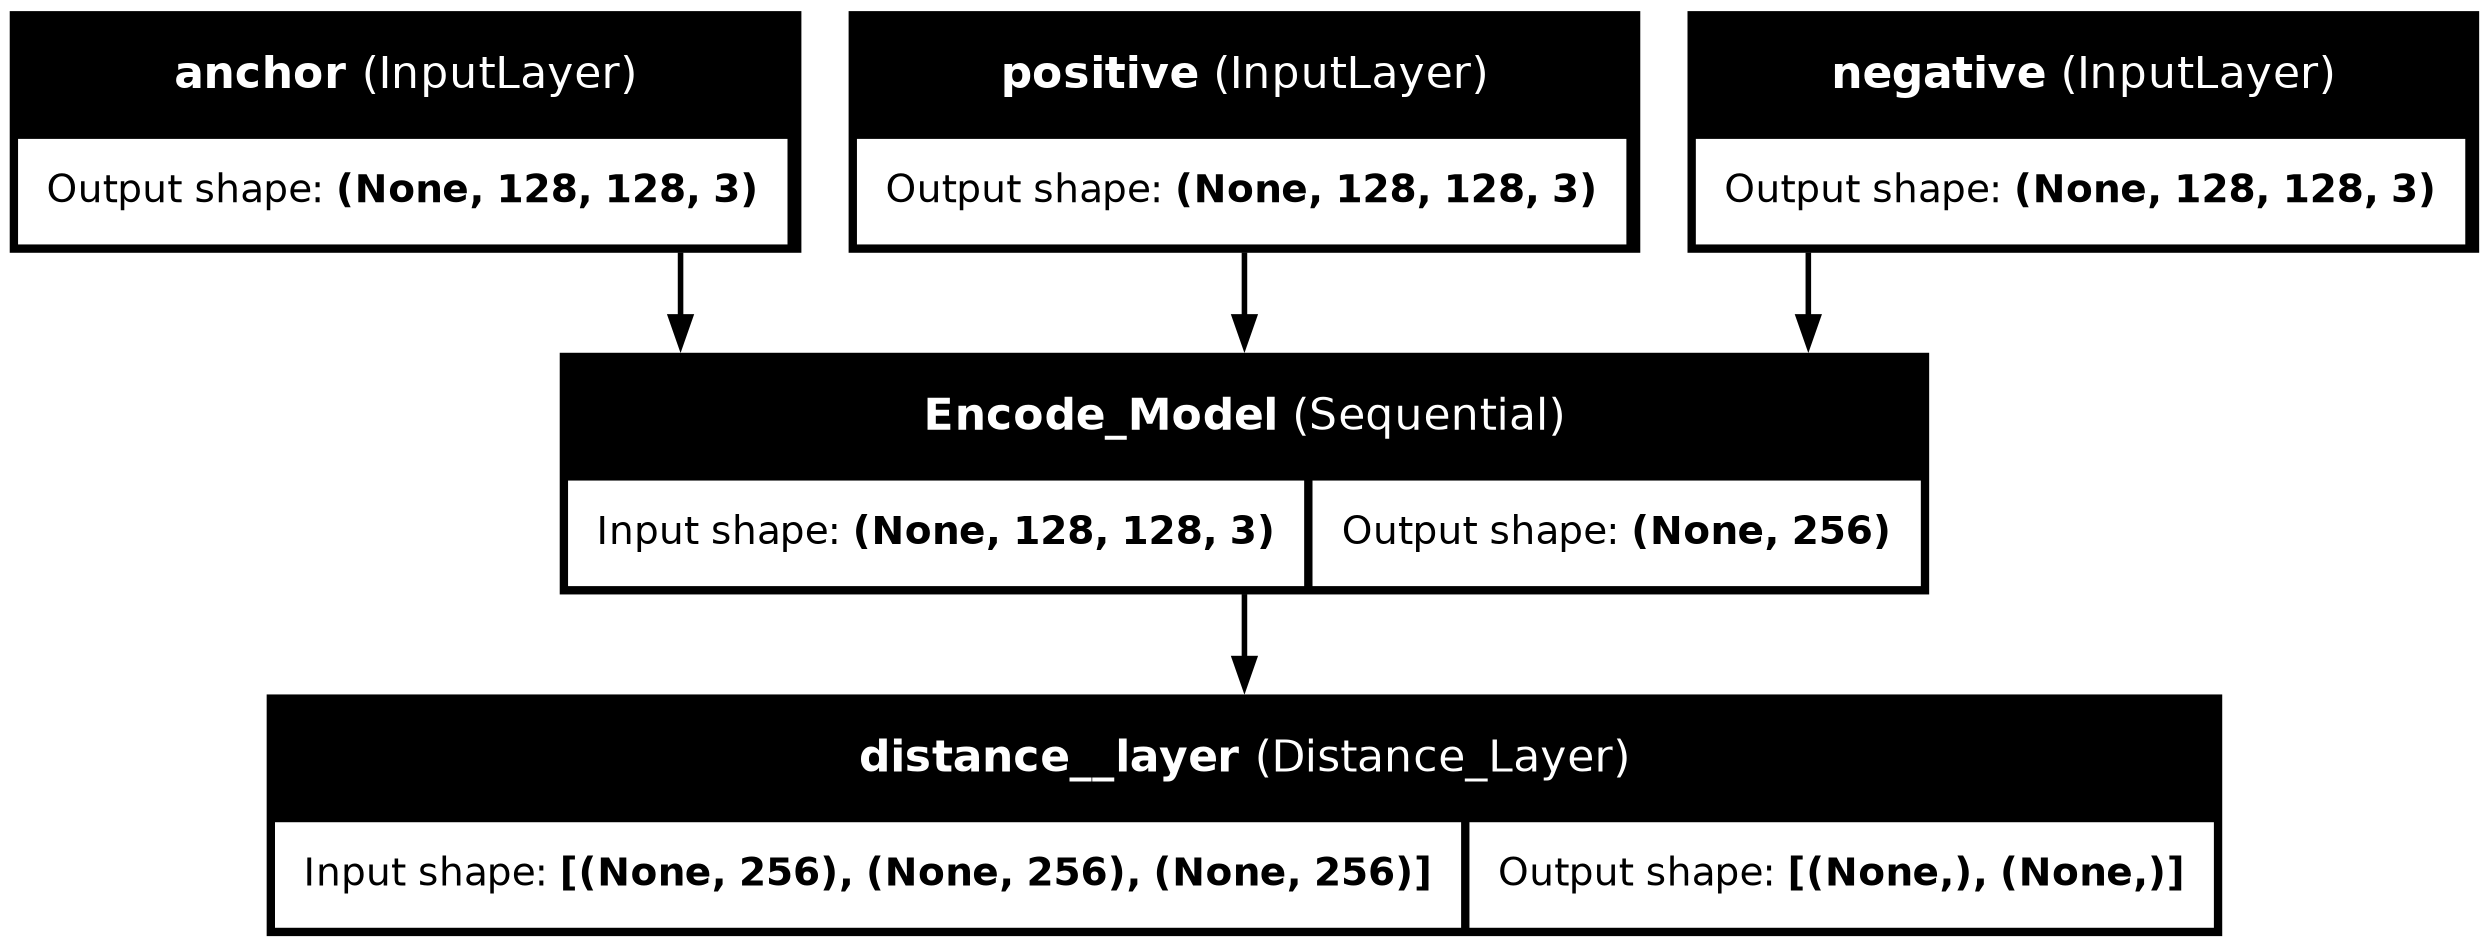

In [12]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

### Putting everything together



We now need to implement a model with custom training loop and loss function so we can compute the **triplet loss** using the three embeddings produced by the Siamese network.

$\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2$

$\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$



We'll create a **Mean metric** instance to track the loss of the training process.



**Triplet Loss Function:**



1. Compute the formula per training example: $ \mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2 + \alpha$

2. Compute the full formula by taking the max with zero and summing over the training examples:

$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2+ \alpha \large ] \small_+ \tag{3}$$

In [13]:
class SiameseModel(Model):

    def __init__(self, siamese_network, margin=1.0):

        super(SiameseModel, self).__init__()

        self.margin = margin

        self.siamese_network = siamese_network



    def call(self, inputs):

        return self.siamese_network(inputs)



    @tf.function(reduce_retracing=True)

    def train_step(self, data):

        # Ensure data is in the correct format # I removed this code as it was doing an error and the data's alrd tuple

        anchors, positives, negatives = data[0], data[1], data[2]



        with tf.GradientTape() as tape:



            ######## YOUR CODE STARTS HERE #######

            # get the distances between images
            positive_distance, negative_distance = self.siamese_network([anchors, positives, negatives])

            # triplet loss
            loss = tf.reduce_mean(tf.maximum(positive_distance - negative_distance + self.margin, 0))
    
            



            ######## YOUR CODE ENDS    HERE #######





        gradients = tape.gradient(loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))



        return loss



    @tf.function(reduce_retracing=True)

    def predict_step(self, batch_data):

        ######## YOUR CODE STARTS HERE #######

        #Do not train here

        return self.siamese_network(batch_data)

       ######## YOUR CODE ENDS    HERE #######


## **Training the Model**



In efficient_train: Inside the training loop, you need to retrieve batches of training data using the batch_triplets function. For each batch, invoke the train_step method of the model to compute the loss. Store the loss for each batch in epoch_losses and print the loss along with the current RAM usage. Additionally, implement a memory management strategy that checks if the RAM exceeds 8GB, triggering a cleanup if necessary.



In test_model: Implement batch prediction logic by utilizing the batch_triplets function to get test data. For each batch, call the predict_step method of the model to obtain positive and negative distances. Track progress and manage memory, ensuring the process cleans up when RAM usage exceeds 3GB.





NOTE: Batch size should be dynamic. Use tensordflow to check Resources and if they are exhausted, decrease the batch size by 5

In [14]:
def efficient_train(directory,model, train_triplet, test_triplet, epochs=100, batch_size=32):

    max_acc = 0

    train_loss = []

    test_metrics = []



    for epoch in range(1, epochs + 1):

        print(f"\nEpoch {epoch}/{epochs}")

        t = time.time()

        epoch_losses = []



       ######## YOUR CODE STARTS HERE #######

       # hint: use ram = psutil.Process().memory_info().rss / 1024 / 1024   #to check your System Ram Usage

        for anchors, positives, negatives in generate_batch_triplets(directory, train_triplet, batch_size):

            batch_loss = model.train_step((anchors, positives, negatives))
            epoch_losses.append(batch_loss.numpy())

            ram_usage = psutil.Process().memory_info().rss / 1024 / 1024
            print(f"Batch Loss: {batch_loss.numpy():.5f}, ram usage: {ram_usage:.2f} MB")


            if ram_usage > 8000:
                batch_size = max(5, batch_size - 5)
                print(f"high memory used. batch size changed to {batch_size}")
                gc.collect()
        
       ########## YOUR CODE ENDS HERE #######

        avg_loss = np.mean(epoch_losses)

        train_loss.append(avg_loss)

        print(f"\nEpoch {epoch} completed in {int(time.time()-t)} seconds")

        print(f"Average loss: {avg_loss:.5f}")



        # Test with optimized batch processing

        metric = test_model(directory,model, test_triplet, batch_size=batch_size)

        test_metrics.append(metric)



        if metric[0] >= max_acc:

            try:

                model.save_weights(f"siamese_model_epoch_{epoch}.weights.h5")

                max_acc = metric[0]

            except Exception as e:

                print(f"Error saving weights: {e}")



        gc.collect()

        tf.keras.backend.clear_session()



    return train_loss, test_metrics

In [15]:
def test_model(directory,model, test_triplet, batch_size=32):

    """Optimized batch prediction with memory management"""

    # Use a larger batch size for testing since we don't need gradients

    test_batch_size = min(batch_size * 2, 64)

    pos_distances = []

    neg_distances = []

    total_samples = 0



    try:

    ######## YOUR CODE STARTS HERE #######

        for anchors, positives, negatives in generate_batch_triplets(directory, test_triplet, test_batch_size):

            sample_positive_distances, sample_negative_distances = model.predict_step([anchors, positives, negatives])

            pos_distances.extend(sample_positive_distances.numpy())
            neg_distances.extend(sample_negative_distances.numpy())
            total_samples += len(sample_positive_distances)

            
            ram_usage = psutil.Process().memory_info().rss / 1024 / 1024

            if ram_usage > 3000:
                test_batch_size = max(5, test_batch_size - 5)
                print(f"high memory used. batch size changed to {test_batch_size}")
                gc.collect()

    ######## YOUR CODE ENDS HERE #######

    except Exception as e:

        print(f"Error during batch prediction: {e}")

        return 0.0, 0.0, 0.0, 0.0, 0.0



    # Convert to numpy arrays for final calculations

    pos_distances = np.array(pos_distances)

    neg_distances = np.array(neg_distances)



    # Calculate metrics

    accuracy = np.mean(pos_distances < neg_distances)

    metrics = (

        float(accuracy),

        float(np.mean(pos_distances)),

        float(np.mean(neg_distances)),

        float(np.std(pos_distances)),

        float(np.std(neg_distances))

    )



    print(f"Test Accuracy: {accuracy:.5f}")

    return metrics

In [17]:
# Clear initial memory

gc.collect()

tf.keras.backend.clear_session()



siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)

siamese_model.compile(optimizer=optimizer)



# Start training with aggressive memory management

train_loss, test_metrics = efficient_train(

    directory,

    siamese_model,

    train_triplet,

    test_triplet,

    epochs=35,

    batch_size=300

)


Epoch 1/35
Batch Loss: 0.79652, ram usage: 2726.80 MB
Batch Loss: 0.80303, ram usage: 2726.80 MB
Batch Loss: 0.81204, ram usage: 2726.80 MB
Batch Loss: 0.83509, ram usage: 2726.80 MB
Batch Loss: 0.83150, ram usage: 2726.81 MB
Batch Loss: 0.80090, ram usage: 2726.93 MB
Batch Loss: 0.83416, ram usage: 2727.06 MB
Batch Loss: 0.84015, ram usage: 2727.18 MB
Batch Loss: 0.83161, ram usage: 2727.30 MB
Batch Loss: 0.80982, ram usage: 2727.43 MB
Batch Loss: 0.81745, ram usage: 2727.55 MB
Batch Loss: 0.78835, ram usage: 2727.68 MB
Batch Loss: 0.82185, ram usage: 2727.80 MB
Batch Loss: 0.79114, ram usage: 2727.93 MB
Batch Loss: 0.81356, ram usage: 2728.05 MB
Batch Loss: 0.80321, ram usage: 2728.17 MB
Batch Loss: 0.78442, ram usage: 2728.29 MB
Batch Loss: 0.80081, ram usage: 2728.42 MB
Batch Loss: 0.81362, ram usage: 2728.54 MB
Batch Loss: 0.78938, ram usage: 2728.67 MB
Batch Loss: 0.78519, ram usage: 2728.79 MB
Batch Loss: 0.80912, ram usage: 2728.92 MB
Batch Loss: 0.82569, ram usage: 2729.04 MB

Show that we can achieve an accuracy of at least 84.576%



---




In [ ]:
###### HIGHEST ACCURACY - Epoch 17 - 83.98%

## **Evaluating the Model**


Create a series of plots to analyze model performance over time by visualizing several key metrics from training and testing. Your task involves generating four specific plots across two figures:



**Training Loss Plot:** In the first figure, create a line plot showing how the training loss changes over epochs. This will help visualize how well the model minimizes the loss during training.



**Testing Accuracy Plot:** In the same figure, add a line plot of the testing accuracy over epochs. This provides insight into the model's generalization performance on test data.



**Means Comparison Plot:** In the second figure, plot the "AP Mean" and "AN Mean" values over epochs. This comparison will help track how these metrics evolve, indicating the separation between positive and negative samples.



**75th Quartile Comparison Plot:** Also in the second figure, plot the AP Mean + AP Standard Deviation and AN Mean - AN Standard Deviation to observe the "75th Quartile" for each metric. This offers a perspective on the spread and reliability of AP and AN values over time.

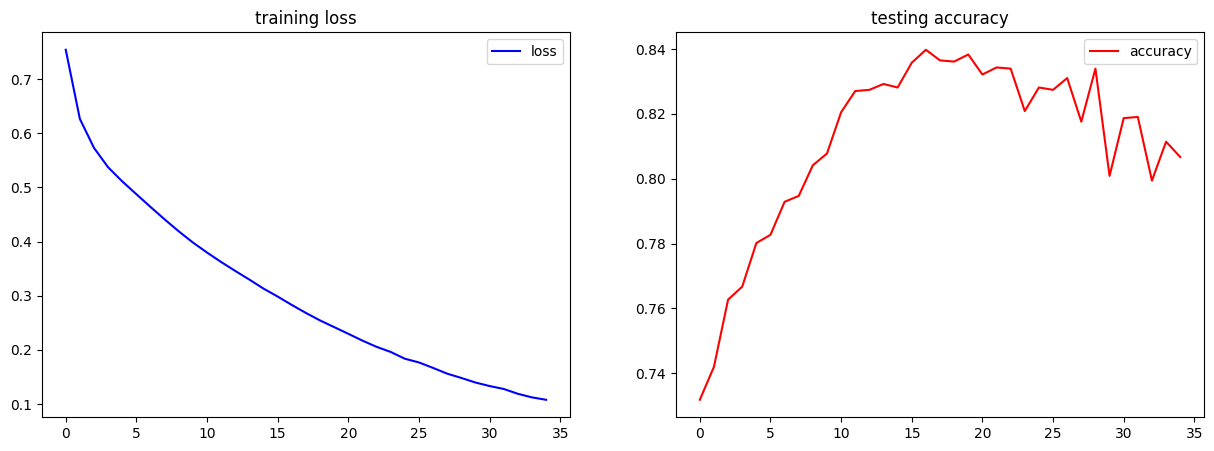

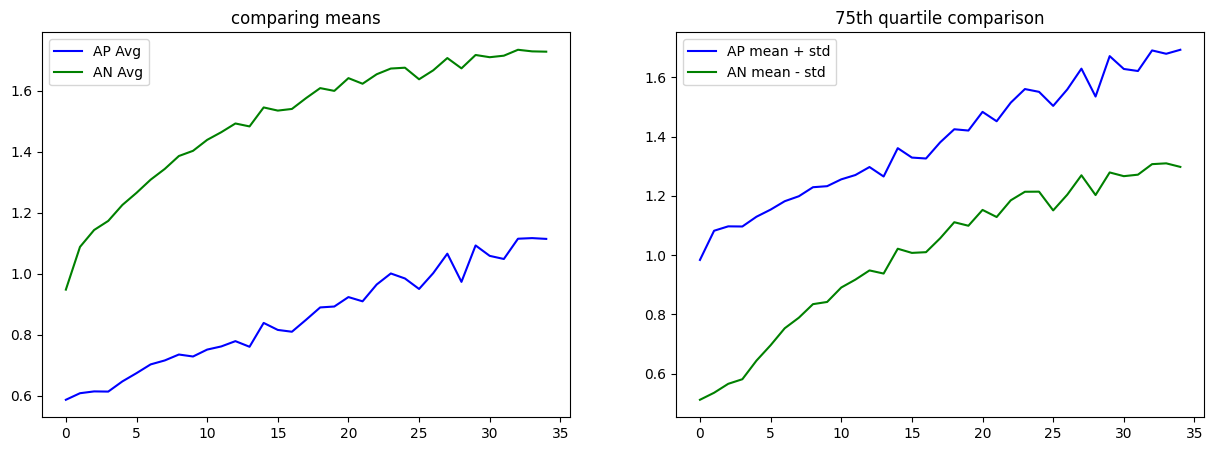

In [18]:
def stat_graphs(loss, metrics):

    # Extracting individual metrics from metrics

    ######## YOUR CODE STARTS HERE #######

    accuracy = metrics[:, 0]
    ap_avg = metrics[:, 1]
    an_avg = metrics[:, 2]
    ap_std = metrics[:, 3]
    an_std = metrics[:, 4]

    plt.figure(figsize=(15,5))
    
    plt.subplot(121)
    plt.plot(loss, 'b', label='loss')
    plt.title('training loss')
    plt.legend()

    plt.subplot(122)
    plt.plot(accuracy, 'r', label='accuracy')
    plt.title('testing accuracy')
    plt.legend()

    plt.figure(figsize=(15,5))

    plt.subplot(121)
    plt.plot(ap_avg, 'b', label = 'AP Avg')
    plt.plot(an_avg, 'g', label = 'AN Avg')
    plt.title('comparing means')
    plt.legend()
    
    ap_75th = (ap_avg+ap_std)
    an_75th = (an_avg-an_std)
    plt.subplot(122)
    plt.plot(ap_75th, 'b', label = 'AP mean + std')
    plt.plot(an_75th, 'g', label = 'AN mean - std')    
    plt.title('75th quartile comparison')
    plt.legend()




    ######## YOUR CODE ENDS HERE #######

test_metrics = np.array(test_metrics)

stat_graphs(train_loss, test_metrics)

## **Encoder steal**



After completing the model training, your next task is to extract the encoder component. This encoder will be essential for transforming images into feature vectors, enabling us to compute similarity by measuring the distance between these vectors.



Additionally, save the extracted encoder so that it can be reused in future applications.

In [19]:
def extract_encoder(model):

    """

    Extract encoder from siamese model and save weights



    """

    try:

       ######## YOUR CODE STARTS HERE #######

        encoder = model.siamese_network.get_layer('Encode_Model')
        encoder.save_weights('encoder.weights.h5')

        print("encoder weights are: 'encoder.weights.h5'." )

        return encoder
       ######## YOUR CODE ENDS HERE #######

    except Exception as e:

        print(f"Error extracting encoder: {str(e)}")

        raise

In [20]:
# Extract the encoder

encoder = extract_encoder(siamese_model)



# Print model summary

encoder.summary()



# Test the encoder

test_input = tf.random.normal((1, 128, 128, 3))

output = encoder.predict(test_input)

print(f"Output shape: {output.shape}")

encoder weights are: 'encoder.weights.h5'.


Model: "Encode_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 256)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,043,944 (84.09 MB)

 Trainable params: 9,583,800 (36.56 MB)

 Non-trainable params: 12,460,144 (47.53 MB)

I0000 00:00:1731531632.826509      71 service.cc:145] XLA service 0x7e88dc008f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731531632.826583      71 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Output shape: (1, 256)


I0000 00:00:1731531634.660759      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


###Classify Images Using Encodings





In this task, you'll classify images by calculating the distance between their encoded feature vectors. Apply a distance formula to assess similarity between image encodings. Set a threshold value: images with distances below this threshold will be classified as "same," while those with distances above it will be classified as "different."

In [21]:
def image_face_classifier(face_list1, face_list2, threshold):

    '''

    Classifies pairs of images as 'same' or 'different' based on the distance

    between their encodings.



    Parameters:

    - face_list1: Array-like, list of face images to encode and compare.

    - face_list2: Array-like, second list of face images to encode and compare.

    - threshold: Float, distance threshold for classifying images as 'same' or 'different'.



    Returns:

    - prediction: Array, containing 0 for 'same' and 1 for 'different' for each image pair.

     '''

    ######## YOUR CODE STARTS HERE #######

    # Getting the encodings for the passed faces


    pred_1 = encoder.predict(face_list1)
    pred_2 = encoder.predict(face_list2)

    distance = np.sum(np.square(pred_1 - pred_2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)


     ######## YOUR CODE Ends HERE #######

    return prediction

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Accuracy of model: 0.755859375



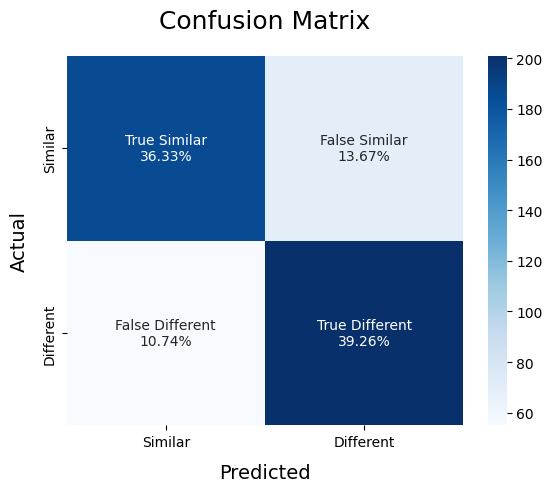

In [22]:
def ModelMetrics(directory,pos_list, neg_list):

    true = np.array([0]*len(pos_list)+[1]*len(neg_list))

    pred = np.append(pos_list, neg_list)



    # Compute and print the accuracy

    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")



    # Compute and plot the Confusion matrix

    cf_matrix = confusion_matrix(true, pred)



    categories  = ['Similar','Different']

    names = ['True Similar','False Similar', 'False Different','True Different']

    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]



    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]

    labels = np.asarray(labels).reshape(2,2)



    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',

                xticklabels = categories, yticklabels = categories)



    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)

    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)

    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)





pos_list = np.array([])

neg_list = np.array([])

######## YOUR CODE STARTS HERE #######

for data in  generate_batch_triplets(directory, test_triplet, batch_size=256) :

    a, p, n  = data

    pos_list = np.append(pos_list, image_face_classifier(a, p, 1.5))

    neg_list = np.append(neg_list, image_face_classifier(a, n, 1.5))

    break

######## YOUR CODE ENDS HERE #######

ModelMetrics(directory,pos_list, neg_list)

### Who is this ?

To secure the TA labs, Omar developed a facial recognition system that unlocks the door only for authorized TAs. However, he wanted to grant special access to Cristiano Ronaldo. To achieve this, he need to use the Encoder from their trained model.



If the person is identified as Ronaldo, the system should display: "Olá, lenda!"<br>

If the person is not Ronaldo, the system should display: "Access Denied"<br>

If the person is a TA, The system should display: "Hello, you are late"<br>



**Instructions: Testing the Encoder with Image Classification**



1. **Objective:** Use the encoder we extracted to test the model’s effectiveness. For this test, use three images of Cristiano Ronaldo as inputs. (use google)



2. **Task:** Create two sets of images:

   - A **positive set** containing images of Cristiano Ronaldo.

   - A **negative set** containing images of different individuals.



3. **Procedure:**

   - Select one of Ronaldo’s images as the **anchor image**.

   - Compare the anchor image to both the positive and negative sets by calculating the distance between the anchor and each image encoding.

   - Determine if the model successfully classifies the images as "same" (positive set) or "different" (negative set).

   -Plot the three images.



4. **Evaluation:** Reflect on the model's performance:

   - Did the model correctly classify the positive and negative sets in relation to the anchor image?

   - Summarize any observations or limitations noticed during testing.





   NOTE: Yes you can use your image instead of Ronaldo's...




In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Lambda
from tensorflow.keras.applications import Xception
import tensorflow as tf
 
# Define the encoder architecture
def create_encoder(input_shape=(128, 128, 3)):
    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    # Freeze layers if needed
    for layer in pretrained_model.layers[:-27]:
        layer.trainable = False
 
    encoder = Sequential([
        pretrained_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dense(256, activation="relu"),
        Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encoder
 
# Instantiate and build the encoder
encoder = create_encoder()
encoder.build(input_shape=(None, 128, 128, 3))  # Build the model with the correct input shape
 
# Load the weights into the encoder
encoder.load_weights('/kaggle/input/encoder-weights/encoder.weights.h5') ###

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test on anchor image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test on TA images
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Test on negative images
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


['Access Denied!', 'Access Denied!', 'Access Denied!']

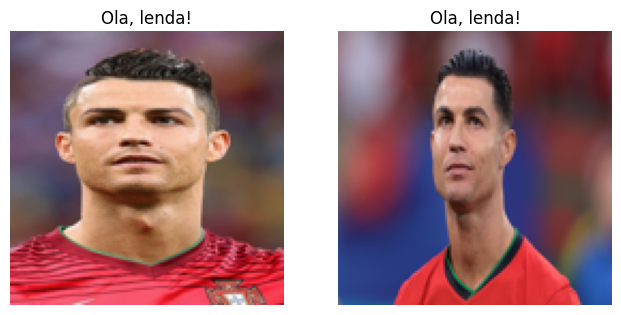

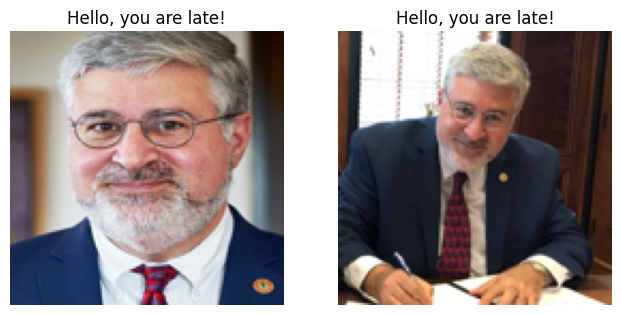

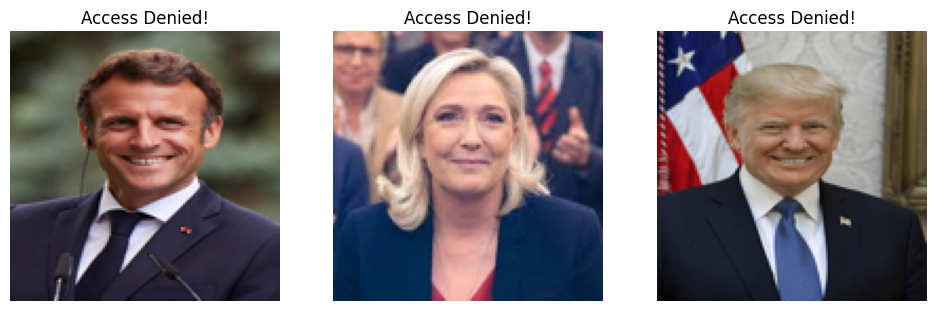

In [28]:
### YOUR CODE STARTS HERE ###
from PIL import Image

def loadimage(image_path): # i used my own function to read images bcz the other one handles different structures and files

    image = Image.open(image_path).convert('RGB')
    
    image = image.resize((128, 128))

    image = np.array(image).astype(np.float32)/255

    image = np.expand_dims(image, axis=0)

    return image 
    

def WhoIsIt(encoder, anchor_image, test_images, TA_embeddings):

    threshold = 0.9
    
    anchor_embedding = encoder.predict(anchor_image)
    predictions = []

    n = len(test_images)+1
    plt.figure(figsize=(4*n, 4))

    plt.subplot(1, n, 1)
    plt.imshow(anchor_image[0])
    plt.title('anchor image')

    i=0 # counter for plots
    
    for image in test_images:
        i+=1
        image_embedding = encoder.predict(image)
                                         
        distance = np.linalg.norm(anchor_embedding - image_embedding)

        if distance <= threshold:
            output='Ola, lenda!'
        else: # check if this is the TA
            output = 'Access Denied!'
            for TA_ID, TA_embedding in TA_embeddings.items():
                
                distance = np.linalg.norm(image_embedding - TA_embedding)
                if distance < threshold:
                    output = 'Hello, you are late!'
                    break
                    
        predictions.append(output)
        plt.subplot(1,n,i)
        plt.imshow(image[0])
        plt.title(output)
        plt.axis('off')

    return predictions    

anchor_image_path = '/kaggle/input/whos-this/who is this/CR1.jpg'
positive_images_paths = ['/kaggle/input/whos-this/who is this/CR2.jpg', '/kaggle/input/whos-this/who is this/CR3.jpg']
negative_images_paths = ['/kaggle/input/whos-this/who is this/N1.jpg', '/kaggle/input/whos-this/who is this/N2.jpg', '/kaggle/input/whos-this/who is this/N3.jpg']
ta_images_paths = ['/kaggle/input/whos-this/who is this/TA1.jpg', '/kaggle/input/whos-this/who is this/TA2.jpg']

anchor_image = loadimage(anchor_image_path)
positive_images = []
for path in positive_images_paths:
    positive_images.append(loadimage(path))
negative_images = []
for path in negative_images_paths:
    negative_images.append(loadimage(path))
ta_images = {'TA 1': loadimage(ta_images_paths[0]),
            'TA 2': loadimage(ta_images_paths[1])} # this will be a dictionary to be able to compare results in the function

TA_embeddings = {TA_ID: encoder.predict(image) for TA_ID, image in ta_images.items()}

# Test the function with every case
print('Test on anchor image')
WhoIsIt(encoder, anchor_image, positive_images, TA_embeddings)

print('Test on TA images')
WhoIsIt(encoder, anchor_image, list(ta_images.values()), TA_embeddings)

print('Test on negative images')
WhoIsIt(encoder, anchor_image, negative_images, TA_embeddings)



SHORT ANWER:

1.Can the same encoding be utilized for both verification and recognition tasks?

Answer:
Yes it can work because verification is about comparing the distance between 2 encoded images, and recognition involves comparing that distance to the images in the database of people and find the onw with smallest one.

2.Christophe stole Whebe's ID can he enter the TA room with such system ? justify

Answer:
No because face recognition works by taking face image, encode it using the model and compare it to the faces in the database by taking distance measures. Christophe's face won't match Whebe's face so the system won't recognize him. 